In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:2


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.cos(12*x[x>0])
    
    return 50*y

In [3]:
# Domain bounds
label = "Regr_disc_tanh"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) 
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 5000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []

elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []

    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.0008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)

                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1331.7733 Test MSE 1270.389020570417 Test RE 0.995133684119625
1 Train Loss 1325.4802 Test MSE 1264.2891732720125 Test RE 0.9927417130289812
2 Train Loss 1319.078 Test MSE 1258.0774061567172 Test RE 0.9902999165905918
3 Train Loss 1312.5553 Test MSE 1251.7317239911986 Test RE 0.9877992466210317
4 Train Loss 1305.8881 Test MSE 1245.2224291343362 Test RE 0.9852275064270815
5 Train Loss 1299.045 Test MSE 1238.526289978918 Test RE 0.9825749227060332
6 Train Loss 1292.0004 Test MSE 1231.6299424975518 Test RE 0.9798355229611362
7 Train Loss 1284.7399 Test MSE 1224.5249694850004 Test RE 

120 Train Loss 821.6397 Test MSE 804.7752537829305 Test RE 0.7920459322117299
121 Train Loss 819.8754 Test MSE 803.0253741654146 Test RE 0.7911843629364138
122 Train Loss 818.08276 Test MSE 801.2384809772425 Test RE 0.7903036004183489
123 Train Loss 816.26 Test MSE 799.41303719996 Test RE 0.7894028215283933
124 Train Loss 814.4062 Test MSE 797.5476808782055 Test RE 0.7884812844289909
125 Train Loss 812.52 Test MSE 795.6413896006285 Test RE 0.7875384102503263
126 Train Loss 810.601 Test MSE 793.6935124136465 Test RE 0.7865737997044168
127 Train Loss 808.64874 Test MSE 791.7038782922771 Test RE 0.7855872878701926
128 Train Loss 806.66345 Test MSE 789.6727926070349 Test RE 0.7845789438334504
129 Train Loss 804.6455 Test MSE 787.6012259709805 Test RE 0.783549166116877
130 Train Loss 802.5962 Test MSE 785.4909294699323 Test RE 0.7824987423076163
131 Train Loss 800.51733 Test MSE 783.3443308809377 Test RE 0.7814288000670634
132 Train Loss 798.4114 Test MSE 781.1647439916867 Test RE 0.7803409

246 Train Loss 636.5031 Test MSE 627.705725758845 Test RE 0.6995054557669308
247 Train Loss 635.1443 Test MSE 626.3820761973044 Test RE 0.698767539350921
248 Train Loss 633.77094 Test MSE 625.0419359864312 Test RE 0.6980196348930043
249 Train Loss 632.38226 Test MSE 623.6845934541014 Test RE 0.6972613124384363
250 Train Loss 630.97754 Test MSE 622.3091340120044 Test RE 0.6964920261526009
251 Train Loss 629.55585 Test MSE 620.9148425912962 Test RE 0.6957113390620536
252 Train Loss 628.1164 Test MSE 619.5007442446605 Test RE 0.694918665924664
253 Train Loss 626.65857 Test MSE 618.0661286039032 Test RE 0.6941135667903287
254 Train Loss 625.1815 Test MSE 616.6101042523204 Test RE 0.6932954972303103
255 Train Loss 623.6847 Test MSE 615.1319096843878 Test RE 0.6924639826558343
256 Train Loss 622.1674 Test MSE 613.63084800883 Test RE 0.6916185818429124
257 Train Loss 620.6292 Test MSE 612.1063328632742 Test RE 0.6907589129532034
258 Train Loss 619.0696 Test MSE 610.5578909199844 Test RE 0.689

359 Train Loss 451.21887 Test MSE 445.28198187504466 Test RE 0.5891564301384752
360 Train Loss 449.96216 Test MSE 444.0567690355134 Test RE 0.5883453269708411
361 Train Loss 448.71085 Test MSE 442.83683492448625 Test RE 0.587536605861269
362 Train Loss 447.46475 Test MSE 441.6221112632599 Test RE 0.5867302313028526
363 Train Loss 446.22375 Test MSE 440.41252005120253 Test RE 0.5859261610977012
364 Train Loss 444.98788 Test MSE 439.2078857260267 Test RE 0.5851242878013155
365 Train Loss 443.75693 Test MSE 438.00820698538115 Test RE 0.5843246195895009
366 Train Loss 442.53085 Test MSE 436.81336443690054 Test RE 0.58352708578133
367 Train Loss 441.30954 Test MSE 435.6232793870611 Test RE 0.5827316425063014
368 Train Loss 440.093 Test MSE 434.43796001143255 Test RE 0.5819383038126458
369 Train Loss 438.8811 Test MSE 433.2572769947913 Test RE 0.581146991591332
370 Train Loss 437.6738 Test MSE 432.081169209319 Test RE 0.5803576730791185
371 Train Loss 436.47104 Test MSE 430.90956171928207 Te

476 Train Loss 329.16632 Test MSE 326.96512294621067 Test RE 0.5048516449957021
477 Train Loss 328.2982 Test MSE 326.1280433665178 Test RE 0.5042049830119848
478 Train Loss 327.43256 Test MSE 325.2934992989233 Test RE 0.5035594531041659
479 Train Loss 326.56952 Test MSE 324.4614765201574 Test RE 0.5029150486085349
480 Train Loss 325.709 Test MSE 323.6318847496819 Test RE 0.5022717037997367
481 Train Loss 324.85104 Test MSE 322.8047990433101 Test RE 0.5016294810722522
482 Train Loss 323.99557 Test MSE 321.98021282857997 Test RE 0.5009883796280633
483 Train Loss 323.14267 Test MSE 321.1580379248165 Test RE 0.5003483350867449
484 Train Loss 322.2922 Test MSE 320.3383709994463 Test RE 0.4997094269072647
485 Train Loss 321.44427 Test MSE 319.5211285302098 Test RE 0.49907159422569763
486 Train Loss 320.59885 Test MSE 318.70631913569224 Test RE 0.4984348479103333
487 Train Loss 319.75586 Test MSE 317.89393139166515 Test RE 0.4977991831851966
488 Train Loss 318.91534 Test MSE 317.0839550767346

599 Train Loss 239.35454 Test MSE 240.50482399848062 Test RE 0.4329870993151711
600 Train Loss 238.74805 Test MSE 239.92037760446382 Test RE 0.4324606822781245
601 Train Loss 238.14328 Test MSE 239.33758634073035 Test RE 0.43193511719160654
602 Train Loss 237.54027 Test MSE 238.75646138678485 Test RE 0.4314104172694355
603 Train Loss 236.939 Test MSE 238.17696572643808 Test RE 0.4308865521891598
604 Train Loss 236.33943 Test MSE 237.59911822980294 Test RE 0.43036354208917116
605 Train Loss 235.74162 Test MSE 237.02286706873076 Test RE 0.429841343095153
606 Train Loss 235.14551 Test MSE 236.44824047695252 Test RE 0.4293199837988948
607 Train Loss 234.55113 Test MSE 235.8752401928406 Test RE 0.42879946884335707
608 Train Loss 233.95839 Test MSE 235.30387363373677 Test RE 0.4282798080572812
609 Train Loss 233.36743 Test MSE 234.73408200922492 Test RE 0.427760950986188
610 Train Loss 232.77815 Test MSE 234.1659226518007 Test RE 0.42724295286070396
611 Train Loss 232.1906 Test MSE 233.59934

729 Train Loss 173.5065 Test MSE 176.8044256605749 Test RE 0.37124415690164825
730 Train Loss 173.09007 Test MSE 176.39995213644602 Test RE 0.37081926818856614
731 Train Loss 172.67493 Test MSE 175.9965798010358 Test RE 0.3703950508343328
732 Train Loss 172.26091 Test MSE 175.59442825531949 Test RE 0.3699716331459965
733 Train Loss 171.84816 Test MSE 175.19335080740615 Test RE 0.3695488631580197
734 Train Loss 171.4366 Test MSE 174.79348201800036 Test RE 0.36912688517779335
735 Train Loss 171.02625 Test MSE 174.3947858643489 Test RE 0.3687056638449676
736 Train Loss 170.6171 Test MSE 173.9972103410045 Test RE 0.36828514671800155
737 Train Loss 170.20915 Test MSE 173.6008119803327 Test RE 0.3678653961087927
738 Train Loss 169.80244 Test MSE 173.20555008079995 Test RE 0.36744637147115655
739 Train Loss 169.39691 Test MSE 172.81144952734272 Test RE 0.3670281017176686
740 Train Loss 168.99257 Test MSE 172.41845580929754 Test RE 0.36661053147953415
741 Train Loss 168.58943 Test MSE 172.0265

855 Train Loss 129.72154 Test MSE 134.1703292086327 Test RE 0.3234009592202857
856 Train Loss 129.43709 Test MSE 133.89297872157582 Test RE 0.3230665268030264
857 Train Loss 129.15356 Test MSE 133.6160012525507 Test RE 0.32273219831741745
858 Train Loss 128.87088 Test MSE 133.34040021380497 Test RE 0.322399187147129
859 Train Loss 128.58911 Test MSE 133.065046660688 Test RE 0.3220661311515959
860 Train Loss 128.30818 Test MSE 132.79125596868147 Test RE 0.3217346236808817
861 Train Loss 128.02817 Test MSE 132.51749842687838 Test RE 0.3214028144811102
862 Train Loss 127.749016 Test MSE 132.24557650548846 Test RE 0.3210728906911122
863 Train Loss 127.47075 Test MSE 131.97334346002745 Test RE 0.3207422494625797
864 Train Loss 127.19339 Test MSE 131.70336875640606 Test RE 0.32041401414715515
865 Train Loss 126.91686 Test MSE 131.43242821107796 Test RE 0.32008426615896074
866 Train Loss 126.64123 Test MSE 131.1646462911669 Test RE 0.3197580282469356
867 Train Loss 126.36645 Test MSE 130.8947

982 Train Loss 100.072044 Test MSE 105.19342153142901 Test RE 0.2863567017859776
983 Train Loss 99.88466 Test MSE 105.00627723982822 Test RE 0.28610186703790336
984 Train Loss 99.697914 Test MSE 104.83048684402299 Test RE 0.28586228599278
985 Train Loss 99.51179 Test MSE 104.6378216962142 Test RE 0.28559947585966744
986 Train Loss 99.32631 Test MSE 104.46741833675414 Test RE 0.28536683082185116
987 Train Loss 99.141464 Test MSE 104.27448365501556 Test RE 0.2851031955013281
988 Train Loss 98.95726 Test MSE 104.1043392896292 Test RE 0.28487049952143
989 Train Loss 98.77365 Test MSE 103.91545358281493 Test RE 0.28461194932398165
990 Train Loss 98.59068 Test MSE 103.74235448674906 Test RE 0.2843748017052587
991 Train Loss 98.40837 Test MSE 103.5596012889945 Test RE 0.2841242130586972
992 Train Loss 98.22665 Test MSE 103.38253544755615 Test RE 0.28388121185435694
993 Train Loss 98.04555 Test MSE 103.20591597105043 Test RE 0.28363861583192673
994 Train Loss 97.86504 Test MSE 103.025556797342

1106 Train Loss 81.180435 Test MSE 86.54605858037652 Test RE 0.2597387272911396
1107 Train Loss 81.059326 Test MSE 86.41820969331178 Test RE 0.2595468087880077
1108 Train Loss 80.93863 Test MSE 86.3120272015541 Test RE 0.25938730653866315
1109 Train Loss 80.8184 Test MSE 86.17252352792252 Test RE 0.2591776016079104
1110 Train Loss 80.69857 Test MSE 86.07308164427191 Test RE 0.2590280147814294
1111 Train Loss 80.57917 Test MSE 85.9350681393321 Test RE 0.25882026280162745
1112 Train Loss 80.4602 Test MSE 85.8300049063424 Test RE 0.2586619990650953
1113 Train Loss 80.34169 Test MSE 85.70335822078472 Test RE 0.25847109392585327
1114 Train Loss 80.22357 Test MSE 85.58644921588545 Test RE 0.2582947419654538
1115 Train Loss 80.10591 Test MSE 85.47336496828963 Test RE 0.25812404484231743
1116 Train Loss 79.98868 Test MSE 85.3462451603853 Test RE 0.257932026614128
1117 Train Loss 79.87188 Test MSE 85.24204426325758 Test RE 0.25777452140040014
1118 Train Loss 79.75549 Test MSE 85.11125611682635 

1225 Train Loss 69.59929 Test MSE 74.90546465963524 Test RE 0.24164054814120445
1226 Train Loss 69.521225 Test MSE 75.04494326809791 Test RE 0.24186541833297756
1227 Train Loss 69.45043 Test MSE 74.60893066091626 Test RE 0.24116177336012964
1228 Train Loss 69.37673 Test MSE 74.8268057035964 Test RE 0.2415136402722586
1229 Train Loss 69.29818 Test MSE 74.67620557972828 Test RE 0.2412704767210992
1230 Train Loss 69.222336 Test MSE 74.4355191027864 Test RE 0.24088134736280936
1231 Train Loss 69.15125 Test MSE 74.6597554009736 Test RE 0.24124390091264772
1232 Train Loss 69.07858 Test MSE 74.3396702302036 Test RE 0.240726208773237
1233 Train Loss 69.00245 Test MSE 74.32099719053507 Test RE 0.24069597342014445
1234 Train Loss 68.928474 Test MSE 74.39467860429423 Test RE 0.24081525617270208
1235 Train Loss 68.857704 Test MSE 74.08101038351697 Test RE 0.24030704857751023
1236 Train Loss 68.78577 Test MSE 74.20094838819946 Test RE 0.24050149983726185
1237 Train Loss 68.711876 Test MSE 74.084226

1343 Train Loss 62.5881 Test MSE 67.92663472033718 Test RE 0.23010873793696676
1344 Train Loss 62.54288 Test MSE 67.880916693191 Test RE 0.2300312875501756
1345 Train Loss 62.497852 Test MSE 67.83494303475493 Test RE 0.2299533777961516
1346 Train Loss 62.453022 Test MSE 67.7904660581328 Test RE 0.22987797928046974
1347 Train Loss 62.408394 Test MSE 67.74468392144848 Test RE 0.22980034238569805
1348 Train Loss 62.363968 Test MSE 67.70011935265362 Test RE 0.2297247450300583
1349 Train Loss 62.31973 Test MSE 67.65563403950296 Test RE 0.22964925730091992
1350 Train Loss 62.27572 Test MSE 67.61056886725785 Test RE 0.22957276029187
1351 Train Loss 62.231876 Test MSE 67.5669589482226 Test RE 0.22949870926259344
1352 Train Loss 62.188255 Test MSE 67.52235199787708 Test RE 0.22942294051501907
1353 Train Loss 62.144814 Test MSE 67.47855128990535 Test RE 0.22934851688276672
1354 Train Loss 62.10159 Test MSE 67.43510564860038 Test RE 0.22927467269398255
1355 Train Loss 62.058548 Test MSE 67.391063

1459 Train Loss 58.514297 Test MSE 63.767655482585965 Test RE 0.22295298224405816
1460 Train Loss 58.487984 Test MSE 63.74024280440665 Test RE 0.22290505516189896
1461 Train Loss 58.461773 Test MSE 63.71305182997249 Test RE 0.22285750551414862
1462 Train Loss 58.4357 Test MSE 63.68604693746164 Test RE 0.2228102712296908
1463 Train Loss 58.409756 Test MSE 63.65899093995926 Test RE 0.2227629375135136
1464 Train Loss 58.383934 Test MSE 63.632259472031905 Test RE 0.2227161616732851
1465 Train Loss 58.35823 Test MSE 63.605472585119884 Test RE 0.2226692790018836
1466 Train Loss 58.332657 Test MSE 63.57891789574534 Test RE 0.22262279297975232
1467 Train Loss 58.307217 Test MSE 63.552484596499184 Test RE 0.22257650981803337
1468 Train Loss 58.281883 Test MSE 63.52602404671391 Test RE 0.22253016930107264
1469 Train Loss 58.256668 Test MSE 63.49993581735249 Test RE 0.22248447138172542
1470 Train Loss 58.23159 Test MSE 63.473704795186286 Test RE 0.2224385138713451
1471 Train Loss 58.20663 Test MS

1569 Train Loss 56.269024 Test MSE 61.3960155967614 Test RE 0.2187676768209722
1570 Train Loss 56.2537 Test MSE 61.3794699358721 Test RE 0.2187381968974146
1571 Train Loss 56.238464 Test MSE 61.36295151280163 Test RE 0.2187087615405193
1572 Train Loss 56.223297 Test MSE 61.346473932032985 Test RE 0.21867939501597045
1573 Train Loss 56.20821 Test MSE 61.33017030361612 Test RE 0.21865033462927788
1574 Train Loss 56.19319 Test MSE 61.31382731370005 Test RE 0.21862120020584525
1575 Train Loss 56.17824 Test MSE 61.29758837626316 Test RE 0.21859224742924646
1576 Train Loss 56.16338 Test MSE 61.28152231804244 Test RE 0.21856359910869502
1577 Train Loss 56.148582 Test MSE 61.26534844956233 Test RE 0.21853475475194112
1578 Train Loss 56.13386 Test MSE 61.24941821225076 Test RE 0.21850634116314696
1579 Train Loss 56.11922 Test MSE 61.233466132195396 Test RE 0.21847788491220163
1580 Train Loss 56.10465 Test MSE 61.21756513798153 Test RE 0.21844951610210409
1581 Train Loss 56.090145 Test MSE 61.20

1675 Train Loss 55.002552 Test MSE 59.98132620989424 Test RE 0.2162325614845576
1676 Train Loss 54.993412 Test MSE 59.97053779119806 Test RE 0.21621311449611721
1677 Train Loss 54.984306 Test MSE 59.95978956001815 Test RE 0.21619373820936544
1678 Train Loss 54.975235 Test MSE 59.949020536962955 Test RE 0.21617432269843725
1679 Train Loss 54.966198 Test MSE 59.93836749705317 Test RE 0.21615511457807493
1680 Train Loss 54.957207 Test MSE 59.927625581068455 Test RE 0.21613574447993852
1681 Train Loss 54.94825 Test MSE 59.916999664980075 Test RE 0.21611658184770463
1682 Train Loss 54.939342 Test MSE 59.90639655935216 Test RE 0.21609745865774868
1683 Train Loss 54.930458 Test MSE 59.89572000887808 Test RE 0.21607820129657473
1684 Train Loss 54.921616 Test MSE 59.88521332974835 Test RE 0.21605924865774986
1685 Train Loss 54.9128 Test MSE 59.8746007280863 Test RE 0.21604010326100123
1686 Train Loss 54.904026 Test MSE 59.86405995414383 Test RE 0.2160210857636212
1687 Train Loss 54.895283 Test 

1782 Train Loss 54.070393 Test MSE 58.65640310657205 Test RE 0.21383105317125753
1783 Train Loss 54.061676 Test MSE 58.64422161340509 Test RE 0.2138088482914282
1784 Train Loss 54.05301 Test MSE 58.632088026615854 Test RE 0.2137867284444155
1785 Train Loss 54.044384 Test MSE 58.62020521870067 Test RE 0.21376506355543742
1786 Train Loss 54.035797 Test MSE 58.60846767767622 Test RE 0.2137436613630998
1787 Train Loss 54.027252 Test MSE 58.596864019750456 Test RE 0.21372250118606104
1788 Train Loss 54.018757 Test MSE 58.5854775828384 Test RE 0.2137017350917588
1789 Train Loss 54.0103 Test MSE 58.5741912886274 Test RE 0.2136811496418531
1790 Train Loss 54.00189 Test MSE 58.56308892241131 Test RE 0.21366089772926153
1791 Train Loss 53.993507 Test MSE 58.55216874798278 Test RE 0.21364097628136144
1792 Train Loss 53.98518 Test MSE 58.54132820777552 Test RE 0.21362119827099954
1793 Train Loss 53.976894 Test MSE 58.53067734369405 Test RE 0.21360176453149338
1794 Train Loss 53.96866 Test MSE 58.5

1896 Train Loss 53.35833 Test MSE 57.80339537486435 Test RE 0.21227054543463927
1897 Train Loss 53.354004 Test MSE 57.79839350720305 Test RE 0.21226136109399896
1898 Train Loss 53.349716 Test MSE 57.7934589597904 Test RE 0.2122522999761774
1899 Train Loss 53.345436 Test MSE 57.78850171973028 Test RE 0.21224319679921733
1900 Train Loss 53.341187 Test MSE 57.783601768373295 Test RE 0.21223419844006758
1901 Train Loss 53.336956 Test MSE 57.77872985703329 Test RE 0.21222525119584937
1902 Train Loss 53.33275 Test MSE 57.77381222180251 Test RE 0.21221621959735062
1903 Train Loss 53.32856 Test MSE 57.76901941301473 Test RE 0.21220741688191275
1904 Train Loss 53.324394 Test MSE 57.7641527678584 Test RE 0.21219847818121124
1905 Train Loss 53.32024 Test MSE 57.759366988537835 Test RE 0.21218968764179102
1906 Train Loss 53.31612 Test MSE 57.7545926822322 Test RE 0.2121809178131738
1907 Train Loss 53.312008 Test MSE 57.749826170580704 Test RE 0.21217216194080138
1908 Train Loss 53.30793 Test MSE 5

2009 Train Loss 52.976044 Test MSE 57.34635209293977 Test RE 0.2114296833829215
2010 Train Loss 52.973354 Test MSE 57.3429181913744 Test RE 0.21142335307974428
2011 Train Loss 52.97067 Test MSE 57.33963008826726 Test RE 0.21141729137437582
2012 Train Loss 52.96799 Test MSE 57.3362544221777 Test RE 0.21141106806351556
2013 Train Loss 52.96532 Test MSE 57.33288631009624 Test RE 0.2114048584964878
2014 Train Loss 52.962666 Test MSE 57.32962212812608 Test RE 0.2113988403645377
2015 Train Loss 52.960003 Test MSE 57.32627636425279 Test RE 0.21139267164323466
2016 Train Loss 52.957363 Test MSE 57.32291119526335 Test RE 0.21138646696234148
2017 Train Loss 52.954727 Test MSE 57.319667085493656 Test RE 0.21138048531738443
2018 Train Loss 52.9521 Test MSE 57.31632075271581 Test RE 0.21137431501139112
2019 Train Loss 52.949467 Test MSE 57.31300983744567 Test RE 0.21136820983449636
2020 Train Loss 52.946857 Test MSE 57.30979118993046 Test RE 0.21136227462609333
2021 Train Loss 52.944252 Test MSE 57

2130 Train Loss 52.64916 Test MSE 56.86802133165069 Test RE 0.2105460605172642
2131 Train Loss 52.64392 Test MSE 56.85631814871095 Test RE 0.21052439468652234
2132 Train Loss 52.638386 Test MSE 56.84347841217078 Test RE 0.21050062221517857
2133 Train Loss 52.632507 Test MSE 56.829650479996154 Test RE 0.21047501711982247
2134 Train Loss 52.62625 Test MSE 56.81441288378532 Test RE 0.21044679815045264
2135 Train Loss 52.619553 Test MSE 56.7976126583954 Test RE 0.210415680913913
2136 Train Loss 52.61239 Test MSE 56.779167953416895 Test RE 0.21038151248574744
2137 Train Loss 52.60469 Test MSE 56.75870337894011 Test RE 0.21034359579644551
2138 Train Loss 52.59641 Test MSE 56.73598975948334 Test RE 0.21030150408027612
2139 Train Loss 52.58753 Test MSE 56.710957935443815 Test RE 0.21025510662569546
2140 Train Loss 52.57802 Test MSE 56.683296049167545 Test RE 0.21020382233728951
2141 Train Loss 52.56792 Test MSE 56.65305960568944 Test RE 0.2101477505819899
2142 Train Loss 52.55732 Test MSE 56.6

2253 Train Loss 51.808968 Test MSE 55.66068544089911 Test RE 0.20829907248180074
2254 Train Loss 51.80497 Test MSE 55.65744533059338 Test RE 0.20829300965856815
2255 Train Loss 51.80101 Test MSE 55.65431159960811 Test RE 0.2082871457221025
2256 Train Loss 51.797092 Test MSE 55.651136636097476 Test RE 0.20828120446166667
2257 Train Loss 51.793205 Test MSE 55.64802691915161 Test RE 0.2082753851318333
2258 Train Loss 51.78936 Test MSE 55.6450692080519 Test RE 0.20826985010536314
2259 Train Loss 51.785553 Test MSE 55.642024230959876 Test RE 0.20826415161664205
2260 Train Loss 51.78178 Test MSE 55.639025947720974 Test RE 0.20825854036025923
2261 Train Loss 51.778034 Test MSE 55.636226470871875 Test RE 0.20825330103151274
2262 Train Loss 51.77433 Test MSE 55.6333262164756 Test RE 0.2082478729546852
2263 Train Loss 51.770668 Test MSE 55.63043856732838 Test RE 0.20824246832910304
2264 Train Loss 51.76704 Test MSE 55.62777159752402 Test RE 0.2082374766101288
2265 Train Loss 51.76343 Test MSE 55

2370 Train Loss 51.507225 Test MSE 55.45147992107286 Test RE 0.2079072488830888
2371 Train Loss 51.505535 Test MSE 55.450637227351585 Test RE 0.20790566909839117
2372 Train Loss 51.503853 Test MSE 55.44979526971006 Test RE 0.20790409068162224
2373 Train Loss 51.502182 Test MSE 55.448927055696714 Test RE 0.20790246302952123
2374 Train Loss 51.50051 Test MSE 55.448121115148375 Test RE 0.20790095211089027
2375 Train Loss 51.49886 Test MSE 55.44732102738096 Test RE 0.20789945215376526
2376 Train Loss 51.49721 Test MSE 55.446504830269014 Test RE 0.2078979219846449
2377 Train Loss 51.495575 Test MSE 55.445673699102855 Test RE 0.20789636380626741
2378 Train Loss 51.493942 Test MSE 55.4449444997627 Test RE 0.2078949967168298
2379 Train Loss 51.492325 Test MSE 55.44416306113345 Test RE 0.20789353168016014
2380 Train Loss 51.49071 Test MSE 55.443360779457116 Test RE 0.20789202755632405
2381 Train Loss 51.48911 Test MSE 55.44264780727985 Test RE 0.20789069086148854
2382 Train Loss 51.487507 Test 

2494 Train Loss 51.345455 Test MSE 55.41692288364055 Test RE 0.2078424554970463
2495 Train Loss 51.34439 Test MSE 55.41720996398777 Test RE 0.20784299384710178
2496 Train Loss 51.343334 Test MSE 55.41752303234003 Test RE 0.20784358092981264
2497 Train Loss 51.342274 Test MSE 55.417954567470545 Test RE 0.20784439016511683
2498 Train Loss 51.341225 Test MSE 55.41824052985568 Test RE 0.20784492641371477
2499 Train Loss 51.340164 Test MSE 55.418571091563706 Test RE 0.2078455462951001
2500 Train Loss 51.339108 Test MSE 55.419088420459595 Test RE 0.2078465164054253
2501 Train Loss 51.33806 Test MSE 55.4194474557952 Test RE 0.2078471896763599
2502 Train Loss 51.337006 Test MSE 55.41978237139747 Test RE 0.20784781771547556
2503 Train Loss 51.335953 Test MSE 55.42030821463754 Test RE 0.20784880378133486
2504 Train Loss 51.3349 Test MSE 55.420779460470655 Test RE 0.20784968746168275
2505 Train Loss 51.33385 Test MSE 55.42112596686258 Test RE 0.20785033722819085
2506 Train Loss 51.332806 Test MSE

2610 Train Loss 51.223953 Test MSE 55.573315867159195 Test RE 0.20813552662981866
2611 Train Loss 51.223034 Test MSE 55.573088346623685 Test RE 0.2081351005696294
2612 Train Loss 51.222134 Test MSE 55.57283412522209 Test RE 0.20813462450775239
2613 Train Loss 51.22122 Test MSE 55.57253300329676 Test RE 0.20813406061727655
2614 Train Loss 51.22032 Test MSE 55.57215344661074 Test RE 0.2081333498452016
2615 Train Loss 51.219414 Test MSE 55.57173327571458 Test RE 0.20813256301460384
2616 Train Loss 51.218517 Test MSE 55.5713372127495 Test RE 0.2081318213268603
2617 Train Loss 51.217625 Test MSE 55.570868665544914 Test RE 0.2081309438980138
2618 Train Loss 51.21673 Test MSE 55.570373859744414 Test RE 0.20813001729177186
2619 Train Loss 51.215836 Test MSE 55.56995490598569 Test RE 0.20812923272788156
2620 Train Loss 51.214954 Test MSE 55.569452048861834 Test RE 0.20812829103641986
2621 Train Loss 51.21407 Test MSE 55.56891991062778 Test RE 0.20812729450611123
2622 Train Loss 51.21319 Test MS

2720 Train Loss 51.137062 Test MSE 55.57073779370096 Test RE 0.20813069881909826
2721 Train Loss 51.13636 Test MSE 55.57077998199066 Test RE 0.2081307778235969
2722 Train Loss 51.13565 Test MSE 55.57091702578446 Test RE 0.20813103446039252
2723 Train Loss 51.134945 Test MSE 55.57108762229848 Test RE 0.2081313539296724
2724 Train Loss 51.13424 Test MSE 55.57111812088761 Test RE 0.20813141104311078
2725 Train Loss 51.13354 Test MSE 55.57119879022309 Test RE 0.20813156210914202
2726 Train Loss 51.13284 Test MSE 55.5713691322762 Test RE 0.20813188110109476
2727 Train Loss 51.132133 Test MSE 55.571457712995425 Test RE 0.208132046982057
2728 Train Loss 51.131435 Test MSE 55.571539798573454 Test RE 0.20813220069975474
2729 Train Loss 51.130737 Test MSE 55.571660360049286 Test RE 0.20813242646920227
2730 Train Loss 51.13004 Test MSE 55.5717703222104 Test RE 0.20813263238962948
2731 Train Loss 51.12934 Test MSE 55.571855209982445 Test RE 0.20813279135441148
2732 Train Loss 51.12864 Test MSE 55.

2844 Train Loss 51.051857 Test MSE 55.57373667752009 Test RE 0.20813631464668345
2845 Train Loss 51.05114 Test MSE 55.57356941252325 Test RE 0.208136001423673
2846 Train Loss 51.050415 Test MSE 55.5734510018641 Test RE 0.20813577968576313
2847 Train Loss 51.049694 Test MSE 55.57324628708678 Test RE 0.20813539633266684
2848 Train Loss 51.048973 Test MSE 55.57304146618025 Test RE 0.20813501278012417
2849 Train Loss 51.04825 Test MSE 55.57287165555897 Test RE 0.20813469478814547
2850 Train Loss 51.04752 Test MSE 55.57268201885234 Test RE 0.20813433966872705
2851 Train Loss 51.046795 Test MSE 55.572485695536514 Test RE 0.2081339720271242
2852 Train Loss 51.046062 Test MSE 55.572234208450524 Test RE 0.20813350108305279
2853 Train Loss 51.04534 Test MSE 55.572027671141015 Test RE 0.20813311431280784
2854 Train Loss 51.044605 Test MSE 55.57183559345173 Test RE 0.20813275461959638
2855 Train Loss 51.043865 Test MSE 55.571565985918944 Test RE 0.208132249739508
2856 Train Loss 51.043133 Test MSE

2963 Train Loss 50.960625 Test MSE 55.4835450595053 Test RE 0.2079673519791491
2964 Train Loss 50.959885 Test MSE 55.48230174476712 Test RE 0.20796502182592916
2965 Train Loss 50.95914 Test MSE 55.48120649283849 Test RE 0.20796296914238696
2966 Train Loss 50.95839 Test MSE 55.48000018676127 Test RE 0.2079607083015274
2967 Train Loss 50.95765 Test MSE 55.47873808143495 Test RE 0.20795834285623666
2968 Train Loss 50.9569 Test MSE 55.47758435761526 Test RE 0.20795618051666906
2969 Train Loss 50.95616 Test MSE 55.47648553278677 Test RE 0.2079541210493316
2970 Train Loss 50.95541 Test MSE 55.47523696431455 Test RE 0.20795178090090974
2971 Train Loss 50.954674 Test MSE 55.47397864843726 Test RE 0.20794942245662193
2972 Train Loss 50.953922 Test MSE 55.47291203657087 Test RE 0.20794742329960125
2973 Train Loss 50.953186 Test MSE 55.47174390832754 Test RE 0.20794523384777555
2974 Train Loss 50.952442 Test MSE 55.470494813955874 Test RE 0.20794289261361618
2975 Train Loss 50.951702 Test MSE 55.

3091 Train Loss 50.859245 Test MSE 55.368322167228996 Test RE 0.20775129644855006
3092 Train Loss 50.85837 Test MSE 55.36780425110729 Test RE 0.20775032479189562
3093 Train Loss 50.8575 Test MSE 55.36732907803414 Test RE 0.20774943332100013
3094 Train Loss 50.856617 Test MSE 55.36682859465951 Test RE 0.2077484943613811
3095 Train Loss 50.855732 Test MSE 55.36636512709365 Test RE 0.20774762484354042
3096 Train Loss 50.854855 Test MSE 55.36587396793834 Test RE 0.20774670336915793
3097 Train Loss 50.853977 Test MSE 55.36540879961991 Test RE 0.20774583065298172
3098 Train Loss 50.853092 Test MSE 55.36498002874431 Test RE 0.207745026219888
3099 Train Loss 50.85221 Test MSE 55.364499789633776 Test RE 0.20774412522161342
3100 Train Loss 50.851326 Test MSE 55.364059228225756 Test RE 0.20774329866103092
3101 Train Loss 50.850445 Test MSE 55.36364879223295 Test RE 0.20774252861737583
3102 Train Loss 50.849564 Test MSE 55.3632536747517 Test RE 0.20774178731100512
3103 Train Loss 50.848675 Test MS

3212 Train Loss 50.75631 Test MSE 55.365735279675285 Test RE 0.20774644317234878
3213 Train Loss 50.755543 Test MSE 55.36610931857642 Test RE 0.20774714491612303
3214 Train Loss 50.754784 Test MSE 55.36657085717686 Test RE 0.20774801081701316
3215 Train Loss 50.754036 Test MSE 55.36702321064234 Test RE 0.20774885948200392
3216 Train Loss 50.753277 Test MSE 55.36743441949968 Test RE 0.20774963095216392
3217 Train Loss 50.752525 Test MSE 55.36786669459926 Test RE 0.2077504419416748
3218 Train Loss 50.751778 Test MSE 55.368370740248466 Test RE 0.20775138757561662
3219 Train Loss 50.751022 Test MSE 55.36882386403961 Test RE 0.2077522376720028
3220 Train Loss 50.75028 Test MSE 55.36925328526087 Test RE 0.20775304329726646
3221 Train Loss 50.749535 Test MSE 55.369752209866625 Test RE 0.20775397931198192
3222 Train Loss 50.748795 Test MSE 55.37026627504405 Test RE 0.20775494372697464
3223 Train Loss 50.748055 Test MSE 55.37071639673011 Test RE 0.207755788176729
3224 Train Loss 50.74731 Test M

3318 Train Loss 50.683857 Test MSE 55.433030247794335 Test RE 0.20787265882405181
3319 Train Loss 50.683235 Test MSE 55.433772195978335 Test RE 0.20787404996418027
3320 Train Loss 50.682613 Test MSE 55.434467473826345 Test RE 0.2078753535897789
3321 Train Loss 50.681984 Test MSE 55.43524910297086 Test RE 0.20787681911176772
3322 Train Loss 50.681362 Test MSE 55.436013423005434 Test RE 0.20787825216990755
3323 Train Loss 50.68073 Test MSE 55.43670818036258 Test RE 0.20787955479327153
3324 Train Loss 50.68011 Test MSE 55.437469889496874 Test RE 0.20788098293733892
3325 Train Loss 50.679493 Test MSE 55.438262862568045 Test RE 0.20788246968837867
3326 Train Loss 50.67887 Test MSE 55.43901931707423 Test RE 0.2078838879605828
3327 Train Loss 50.678246 Test MSE 55.439692318645086 Test RE 0.2078851497592247
3328 Train Loss 50.67763 Test MSE 55.44050107187344 Test RE 0.2078866660660962
3329 Train Loss 50.677006 Test MSE 55.441302006341274 Test RE 0.2078881677029112
3330 Train Loss 50.676388 Tes

3442 Train Loss 50.60833 Test MSE 55.527604522146326 Test RE 0.2080499089914792
3443 Train Loss 50.607716 Test MSE 55.528450676875394 Test RE 0.20805149416470287
3444 Train Loss 50.6071 Test MSE 55.529163989206765 Test RE 0.20805283046364456
3445 Train Loss 50.606487 Test MSE 55.52987335975403 Test RE 0.20805415936964877
3446 Train Loss 50.605877 Test MSE 55.53067915516368 Test RE 0.20805566890378102
3447 Train Loss 50.605263 Test MSE 55.53142222591836 Test RE 0.20805706092318435
3448 Train Loss 50.604652 Test MSE 55.532120420744405 Test RE 0.20805836886651657
3449 Train Loss 50.60404 Test MSE 55.532883143734495 Test RE 0.20805979768244434
3450 Train Loss 50.603424 Test MSE 55.53366404665821 Test RE 0.20806126054484178
3451 Train Loss 50.602806 Test MSE 55.53436955047582 Test RE 0.20806258215354467
3452 Train Loss 50.602196 Test MSE 55.53513241979627 Test RE 0.20806401121465448
3453 Train Loss 50.601578 Test MSE 55.535890698104545 Test RE 0.2080654316658267
3454 Train Loss 50.60096 Tes

3569 Train Loss 50.526352 Test MSE 55.61620637831054 Test RE 0.2082158288145804
3570 Train Loss 50.525658 Test MSE 55.616763498912015 Test RE 0.2082168716853984
3571 Train Loss 50.524967 Test MSE 55.61743473087323 Test RE 0.2082181281536704
3572 Train Loss 50.524273 Test MSE 55.61815176684833 Test RE 0.20821947035336077
3573 Train Loss 50.52358 Test MSE 55.618735413758365 Test RE 0.20822056285938448
3574 Train Loss 50.52289 Test MSE 55.61935692976556 Test RE 0.20822172624480084
3575 Train Loss 50.52219 Test MSE 55.62002860327871 Test RE 0.20822298351029134
3576 Train Loss 50.521492 Test MSE 55.62070318916417 Test RE 0.2082242462196366
3577 Train Loss 50.520794 Test MSE 55.62126554545238 Test RE 0.20822529884852778
3578 Train Loss 50.520096 Test MSE 55.621924097248694 Test RE 0.2082265315311839
3579 Train Loss 50.519394 Test MSE 55.62261366027653 Test RE 0.20822782225309686
3580 Train Loss 50.518692 Test MSE 55.62320850474066 Test RE 0.2082289356746716
3581 Train Loss 50.517998 Test MSE

3695 Train Loss 50.43103 Test MSE 55.69047285206258 Test RE 0.208354801765076
3696 Train Loss 50.430195 Test MSE 55.6909586804943 Test RE 0.20835571057820543
3697 Train Loss 50.429363 Test MSE 55.69158585030018 Test RE 0.20835688378518333
3698 Train Loss 50.428524 Test MSE 55.69210139768131 Test RE 0.20835784818218817
3699 Train Loss 50.427704 Test MSE 55.692586790859906 Test RE 0.20835875616783883
3700 Train Loss 50.426853 Test MSE 55.69319279826831 Test RE 0.20835988977119285
3701 Train Loss 50.426018 Test MSE 55.693763717151434 Test RE 0.20836095773196794
3702 Train Loss 50.42518 Test MSE 55.69423160186106 Test RE 0.20836183295295277
3703 Train Loss 50.42433 Test MSE 55.69476987036364 Test RE 0.20836283982868842
3704 Train Loss 50.423492 Test MSE 55.69540584893066 Test RE 0.20836402947290739
3705 Train Loss 50.42265 Test MSE 55.695895731543075 Test RE 0.20836494582937412
3706 Train Loss 50.421803 Test MSE 55.6963484835136 Test RE 0.2083657927270392
3707 Train Loss 50.42095 Test MSE 

3813 Train Loss 50.31758 Test MSE 55.74886813355629 Test RE 0.208464010296452
3814 Train Loss 50.316414 Test MSE 55.749304729106036 Test RE 0.20846482658460305
3815 Train Loss 50.31525 Test MSE 55.749684775884575 Test RE 0.2084655371427987
3816 Train Loss 50.31407 Test MSE 55.75004346660304 Test RE 0.20846620777020514
3817 Train Loss 50.312897 Test MSE 55.75046214352447 Test RE 0.20846699054830536
3818 Train Loss 50.311714 Test MSE 55.75084787545215 Test RE 0.20846771172829148
3819 Train Loss 50.31053 Test MSE 55.75118932336752 Test RE 0.20846835011101858
3820 Train Loss 50.309338 Test MSE 55.751582441926075 Test RE 0.2084690850965303
3821 Train Loss 50.308136 Test MSE 55.75198204686048 Test RE 0.208469832206497
3822 Train Loss 50.30693 Test MSE 55.75231096732707 Test RE 0.2084704471612558
3823 Train Loss 50.305725 Test MSE 55.7526825589173 Test RE 0.20847114189242083
3824 Train Loss 50.30451 Test MSE 55.75306944485012 Test RE 0.2084718652155738
3825 Train Loss 50.303288 Test MSE 55.75

3926 Train Loss 50.139122 Test MSE 55.760456328170775 Test RE 0.20848567527441328
3927 Train Loss 50.136948 Test MSE 55.76016823083297 Test RE 0.20848513668264457
3928 Train Loss 50.13476 Test MSE 55.759802949590096 Test RE 0.20848445379522695
3929 Train Loss 50.132565 Test MSE 55.759422010159355 Test RE 0.20848374163269592
3930 Train Loss 50.130352 Test MSE 55.75905776315329 Test RE 0.20848306067421415
3931 Train Loss 50.128128 Test MSE 55.75873525878046 Test RE 0.20848245775158014
3932 Train Loss 50.12588 Test MSE 55.758251048916094 Test RE 0.2084815525169
3933 Train Loss 50.123623 Test MSE 55.757873870444264 Test RE 0.20848084737564393
3934 Train Loss 50.121353 Test MSE 55.75753097862229 Test RE 0.20848020633176484
3935 Train Loss 50.119072 Test MSE 55.757035636546995 Test RE 0.2084792802752698
3936 Train Loss 50.116764 Test MSE 55.756579764985844 Test RE 0.20847842800642025
3937 Train Loss 50.114456 Test MSE 55.756200387753935 Test RE 0.2084777187439099
3938 Train Loss 50.112125 Te

4047 Train Loss 49.777767 Test MSE 55.746974854585446 Test RE 0.20846047045886365
4048 Train Loss 49.774014 Test MSE 55.57517729657831 Test RE 0.20813901235261745
4049 Train Loss 49.770164 Test MSE 55.62888486264143 Test RE 0.20823956030279114
4050 Train Loss 49.766335 Test MSE 55.714738174446786 Test RE 0.20840018875472824
4051 Train Loss 49.76261 Test MSE 55.578523437737225 Test RE 0.2081452782078682
4052 Train Loss 49.758804 Test MSE 55.642543459760816 Test RE 0.20826512333266917
4053 Train Loss 49.75499 Test MSE 55.67300718026149 Test RE 0.20832212703845915
4054 Train Loss 49.751278 Test MSE 55.6247288416348 Test RE 0.20823178139302043
4055 Train Loss 49.74753 Test MSE 55.57678556101231 Test RE 0.20814202395028994
4056 Train Loss 49.7439 Test MSE 55.75435270841887 Test RE 0.20847426439119793
4057 Train Loss 49.74058 Test MSE 55.48816663866948 Test RE 0.20797601326391119
4058 Train Loss 49.73798 Test MSE 55.7756721108729 Test RE 0.20851411887548194
4059 Train Loss 49.736526 Test MSE

4172 Train Loss 49.206154 Test MSE 55.2595232873654 Test RE 0.20754708019120774
4173 Train Loss 49.195114 Test MSE 55.31007281537791 Test RE 0.2076419869884571
4174 Train Loss 49.191868 Test MSE 55.12143320109599 Test RE 0.20728759440562136
4175 Train Loss 49.193 Test MSE 55.39488147603827 Test RE 0.2078011179808681
4176 Train Loss 49.19194 Test MSE 55.060655118812996 Test RE 0.20717328299797685
4177 Train Loss 49.188084 Test MSE 55.36080717156276 Test RE 0.2077371972036115
4178 Train Loss 49.17626 Test MSE 55.115310309638204 Test RE 0.20727608132790343
4179 Train Loss 49.163563 Test MSE 55.249392347074114 Test RE 0.20752805411812222
4180 Train Loss 49.151474 Test MSE 55.20729542445654 Test RE 0.20744897671257195
4181 Train Loss 49.142887 Test MSE 55.15876865558249 Test RE 0.2073577836772422
4182 Train Loss 49.137566 Test MSE 55.26675377469349 Test RE 0.20756065809921526
4183 Train Loss 49.13421 Test MSE 55.10345572598888 Test RE 0.20725378893971405
4184 Train Loss 49.131714 Test MSE 5

4292 Train Loss 48.39055 Test MSE 54.55301953282971 Test RE 0.2062160472299089
4293 Train Loss 48.385075 Test MSE 54.74039919122651 Test RE 0.20656990086394572
4294 Train Loss 48.376637 Test MSE 54.54602275282892 Test RE 0.20620282253039549
4295 Train Loss 48.36607 Test MSE 54.6967704837335 Test RE 0.20648756519986436
4296 Train Loss 48.354027 Test MSE 54.55799113890179 Test RE 0.20622544360800432
4297 Train Loss 48.34217 Test MSE 54.646587267746526 Test RE 0.20639281931392303
4298 Train Loss 48.331318 Test MSE 54.57732583904915 Test RE 0.20626198228758888
4299 Train Loss 48.32205 Test MSE 54.60331597234895 Test RE 0.20631108819625452
4300 Train Loss 48.31427 Test MSE 54.59906166619135 Test RE 0.20630305088556936
4301 Train Loss 48.307724 Test MSE 54.561442428617696 Test RE 0.206231966323395
4302 Train Loss 48.302082 Test MSE 54.62112521829128 Test RE 0.20634473034141265
4303 Train Loss 48.2971 Test MSE 54.52330729317898 Test RE 0.2061598819142224
4304 Train Loss 48.292767 Test MSE 54.

4414 Train Loss 47.672203 Test MSE 54.30296589799137 Test RE 0.2057428901261763
4415 Train Loss 47.668243 Test MSE 53.98067403761425 Test RE 0.20513143236981093
4416 Train Loss 47.664597 Test MSE 54.31429700524543 Test RE 0.20576435463657866
4417 Train Loss 47.660515 Test MSE 53.962061155389485 Test RE 0.20509606400473063
4418 Train Loss 47.656734 Test MSE 54.31893541224541 Test RE 0.2057731405226132
4419 Train Loss 47.652306 Test MSE 53.95160692083488 Test RE 0.2050761960996662
4420 Train Loss 47.64811 Test MSE 54.31376215419268 Test RE 0.20576334151886658
4421 Train Loss 47.64311 Test MSE 53.95112555372475 Test RE 0.20507528123204968
4422 Train Loss 47.638252 Test MSE 54.296997595384234 Test RE 0.2057315834733175
4423 Train Loss 47.632633 Test MSE 53.961769011748295 Test RE 0.20509550882215657
4424 Train Loss 47.62715 Test MSE 54.26722871205836 Test RE 0.20567517852048892
4425 Train Loss 47.621178 Test MSE 53.98360630746833 Test RE 0.20513700373917337
4426 Train Loss 47.615433 Test M

4531 Train Loss 47.22148 Test MSE 53.90336501872583 Test RE 0.20498448911542347
4532 Train Loss 47.218414 Test MSE 53.96957919113725 Test RE 0.20511035057761431
4533 Train Loss 47.215378 Test MSE 53.89358901216782 Test RE 0.20496590010362004
4534 Train Loss 47.212357 Test MSE 53.978663017677924 Test RE 0.20512761130560994
4535 Train Loss 47.209377 Test MSE 53.87886968643568 Test RE 0.20493790822250962
4536 Train Loss 47.206436 Test MSE 53.99430155230773 Test RE 0.205157323628608
4537 Train Loss 47.20355 Test MSE 53.857143863781154 Test RE 0.20489658503207747
4538 Train Loss 47.20075 Test MSE 54.0177599366871 Test RE 0.2052018851527286
4539 Train Loss 47.198048 Test MSE 53.82661011619438 Test RE 0.2048384948035415
4540 Train Loss 47.195526 Test MSE 54.05221259052017 Test RE 0.2052673138432832
4541 Train Loss 47.193184 Test MSE 53.782442594392414 Test RE 0.2047544372588321
4542 Train Loss 47.19122 Test MSE 54.104030216739424 Test RE 0.20536568092642613
4543 Train Loss 47.1896 Test MSE 53

4650 Train Loss 46.914658 Test MSE 53.87783400892346 Test RE 0.2049359385208049
4651 Train Loss 46.912113 Test MSE 53.878770015972 Test RE 0.20493771866521288
4652 Train Loss 46.90953 Test MSE 53.88777018923897 Test RE 0.20495483484989266
4653 Train Loss 46.90689 Test MSE 53.887182268374815 Test RE 0.20495371680815652
4654 Train Loss 46.904205 Test MSE 53.89948953270006 Test RE 0.2049771201060648
4655 Train Loss 46.90145 Test MSE 53.89727719421396 Test RE 0.2049729133554171
4656 Train Loss 46.898632 Test MSE 53.91364206646647 Test RE 0.20500402903633966
4657 Train Loss 46.89572 Test MSE 53.90920392462464 Test RE 0.20499559095231093
4658 Train Loss 46.89271 Test MSE 53.93064001117252 Test RE 0.2050363434228204
4659 Train Loss 46.8896 Test MSE 53.92290145449663 Test RE 0.20502163246920777
4660 Train Loss 46.88636 Test MSE 53.95125231963355 Test RE 0.20507552215880384
4661 Train Loss 46.88297 Test MSE 53.937372070960535 Test RE 0.20504914017295586
4662 Train Loss 46.879417 Test MSE 53.976

4777 Train Loss 46.52875 Test MSE 53.87725539034963 Test RE 0.20493483806770552
4778 Train Loss 46.526386 Test MSE 53.90246137965466 Test RE 0.20498277092241637
4779 Train Loss 46.52414 Test MSE 53.923335888259 Test RE 0.20502245835336236
4780 Train Loss 46.52173 Test MSE 53.933296747629356 Test RE 0.20504139362081542
4781 Train Loss 46.51937 Test MSE 53.92956590242522 Test RE 0.20503430161109232
4782 Train Loss 46.51687 Test MSE 53.91898348081719 Test RE 0.20501418402031366
4783 Train Loss 46.514446 Test MSE 53.910041573384504 Test RE 0.20499718357122393
4784 Train Loss 46.511982 Test MSE 53.90467884427844 Test RE 0.2049869872175231
4785 Train Loss 46.509544 Test MSE 53.90052754772213 Test RE 0.20497909385671909
4786 Train Loss 46.507065 Test MSE 53.89838647027839 Test RE 0.20497502264913833
4787 Train Loss 46.504517 Test MSE 53.90136755823777 Test RE 0.2049806910945507
4788 Train Loss 46.501953 Test MSE 53.9080736734392 Test RE 0.20499344198972888
4789 Train Loss 46.49932 Test MSE 53

4901 Train Loss 46.20026 Test MSE 53.575437968719314 Test RE 0.2043600150593138
4902 Train Loss 46.19826 Test MSE 53.571896085406266 Test RE 0.20435325980617924
4903 Train Loss 46.19627 Test MSE 53.568356995731065 Test RE 0.20434650965815754
4904 Train Loss 46.19428 Test MSE 53.56479283878843 Test RE 0.2043397114736784
4905 Train Loss 46.192307 Test MSE 53.56120277087747 Test RE 0.20433286363861247
4906 Train Loss 46.19033 Test MSE 53.55761196063664 Test RE 0.20432601415802643
4907 Train Loss 46.188366 Test MSE 53.5540161024838 Test RE 0.20431915481843152
4908 Train Loss 46.18641 Test MSE 53.55042879638339 Test RE 0.20431231156298135
4909 Train Loss 46.184456 Test MSE 53.54685545466264 Test RE 0.20430549471853177
4910 Train Loss 46.182503 Test MSE 53.54332844294258 Test RE 0.20429876603451758
4911 Train Loss 46.180565 Test MSE 53.539832369159264 Test RE 0.2042920961538802
4912 Train Loss 46.178627 Test MSE 53.53632786709766 Test RE 0.20428540997504363
4913 Train Loss 46.176693 Test MSE

27 Train Loss 1224.6604 Test MSE 1074.960632450342 Test RE 0.9153966965945649
28 Train Loss 1214.8499 Test MSE 1066.5072497883607 Test RE 0.9117902985800604
29 Train Loss 1205.1722 Test MSE 1058.2180954725645 Test RE 0.9082400585624316
30 Train Loss 1195.665 Test MSE 1050.12413320649 Test RE 0.9047599765006025
31 Train Loss 1186.3635 Test MSE 1042.2532064252202 Test RE 0.9013629049067262
32 Train Loss 1177.2996 Test MSE 1034.6295333949947 Test RE 0.8980602966084092
33 Train Loss 1168.5009 Test MSE 1027.2730902897792 Test RE 0.8948618982117257
34 Train Loss 1159.9911 Test MSE 1020.1994648328118 Test RE 0.89177564377602
35 Train Loss 1151.7888 Test MSE 1013.4199103316962 Test RE 0.8888076363211678
36 Train Loss 1143.9075 Test MSE 1006.9413980559498 Test RE 0.8859621311054431
37 Train Loss 1136.357 Test MSE 1000.7669015506794 Test RE 0.8832416242875796
38 Train Loss 1129.1415 Test MSE 994.8958567360731 Test RE 0.8806470246564578
39 Train Loss 1122.2621 Test MSE 989.3244916181827 Test RE 0

153 Train Loss 865.95654 Test MSE 772.2498356607371 Test RE 0.7758753839159883
154 Train Loss 863.99854 Test MSE 770.2692322025957 Test RE 0.774879794169844
155 Train Loss 862.0664 Test MSE 768.3170653507447 Test RE 0.7738972453134545
156 Train Loss 860.1635 Test MSE 766.3977853497111 Test RE 0.7729300311706409
157 Train Loss 858.29236 Test MSE 764.5153246529825 Test RE 0.7719801948080519
158 Train Loss 856.455 Test MSE 762.672972135183 Test RE 0.7710494629476499
159 Train Loss 854.65295 Test MSE 760.8732280323557 Test RE 0.7701391701973578
160 Train Loss 852.88666 Test MSE 759.117787925303 Test RE 0.7692502482240756
161 Train Loss 851.15607 Test MSE 757.4074980170855 Test RE 0.7683832004305653
162 Train Loss 849.46014 Test MSE 755.7424668443213 Test RE 0.7675381560625284
163 Train Loss 847.79755 Test MSE 754.1219441082952 Test RE 0.7667148064602164
164 Train Loss 846.16614 Test MSE 752.5445066229527 Test RE 0.7659124973554226
165 Train Loss 844.56335 Test MSE 751.0081468160956 Test RE

278 Train Loss 699.5203 Test MSE 624.8362336608245 Test RE 0.6979047657383544
279 Train Loss 698.29376 Test MSE 623.7398782384433 Test RE 0.6972922151475033
280 Train Loss 697.0595 Test MSE 622.6350085568522 Test RE 0.6966743626346553
281 Train Loss 695.81696 Test MSE 621.5208551142512 Test RE 0.6960507631926799
282 Train Loss 694.5651 Test MSE 620.3966650192423 Test RE 0.6954209793923951
283 Train Loss 693.30334 Test MSE 619.2616103703888 Test RE 0.6947845299819697
284 Train Loss 692.03076 Test MSE 618.1148376353256 Test RE 0.6941409173697196
285 Train Loss 690.7463 Test MSE 616.9554256679339 Test RE 0.6934896039040304
286 Train Loss 689.44916 Test MSE 615.7824410260345 Test RE 0.6928300427490193
287 Train Loss 688.1383 Test MSE 614.5949416446098 Test RE 0.6921616798466953
288 Train Loss 686.81274 Test MSE 613.3918070427214 Test RE 0.6914838581093083
289 Train Loss 685.47125 Test MSE 612.1721149951419 Test RE 0.6907960293582264
290 Train Loss 684.1129 Test MSE 610.9346985559229 Test R

404 Train Loss 475.1465 Test MSE 424.6136884070394 Test RE 0.5753207743078275
405 Train Loss 473.81534 Test MSE 423.4317145024735 Test RE 0.5745194717946133
406 Train Loss 472.49026 Test MSE 422.25511877616117 Test RE 0.57372070380863
407 Train Loss 471.1712 Test MSE 421.08383780413027 Test RE 0.5729244378035886
408 Train Loss 469.8581 Test MSE 419.91777223121125 Test RE 0.57213061654109
409 Train Loss 468.55075 Test MSE 418.756912033717 Test RE 0.5713392433733352
410 Train Loss 467.24927 Test MSE 417.6010808028401 Test RE 0.5705502079772712
411 Train Loss 465.9534 Test MSE 416.45030841937216 Test RE 0.5697635405058649
412 Train Loss 464.66315 Test MSE 415.30451913583073 Test RE 0.5689791988926356
413 Train Loss 463.37845 Test MSE 414.1635573883394 Test RE 0.5681970860592771
414 Train Loss 462.09918 Test MSE 413.02744094041776 Test RE 0.5674172234238276
415 Train Loss 460.82532 Test MSE 411.8960736403419 Test RE 0.5666395541398139
416 Train Loss 459.55673 Test MSE 410.7694420741815 Tes

529 Train Loss 341.0439 Test MSE 305.58465841144164 Test RE 0.48806631465315875
530 Train Loss 340.16684 Test MSE 304.8079402708456 Test RE 0.4874456500614518
531 Train Loss 339.29218 Test MSE 304.03332597426265 Test RE 0.48682587853638776
532 Train Loss 338.41986 Test MSE 303.260803859613 Test RE 0.48620699414446794
533 Train Loss 337.5499 Test MSE 302.4904141641703 Test RE 0.4855890325741796
534 Train Loss 336.68237 Test MSE 301.72211047698545 Test RE 0.4849719600539234
535 Train Loss 335.8172 Test MSE 300.95591111877786 Test RE 0.48435579472426954
536 Train Loss 334.95438 Test MSE 300.1917803164997 Test RE 0.48374051122879647
537 Train Loss 334.0939 Test MSE 299.4296958933126 Test RE 0.48312609504564863
538 Train Loss 333.23575 Test MSE 298.66965332714193 Test RE 0.482512545835255
539 Train Loss 332.3799 Test MSE 297.9116798624525 Test RE 0.48189988894430447
540 Train Loss 331.52643 Test MSE 297.15573747603037 Test RE 0.48128809698830183
541 Train Loss 330.67523 Test MSE 296.4018037

654 Train Loss 248.20241 Test MSE 223.50731668477513 Test RE 0.4174062362497549
655 Train Loss 247.58212 Test MSE 222.96096374933904 Test RE 0.41689575931898126
656 Train Loss 246.96355 Test MSE 222.41614510532486 Test RE 0.416386092735844
657 Train Loss 246.3467 Test MSE 221.87284909568535 Test RE 0.41587722855468656
658 Train Loss 245.73154 Test MSE 221.3311056115926 Test RE 0.4153691977727381
659 Train Loss 245.1181 Test MSE 220.79085834591967 Test RE 0.41486195055166164
660 Train Loss 244.5063 Test MSE 220.25217459750013 Test RE 0.4143555530730342
661 Train Loss 243.8963 Test MSE 219.71496280184948 Test RE 0.413849922221813
662 Train Loss 243.2879 Test MSE 219.17928938356764 Test RE 0.4133451234456737
663 Train Loss 242.6812 Test MSE 218.64513067559864 Test RE 0.41284113745304113
664 Train Loss 242.07617 Test MSE 218.11245651920382 Test RE 0.41233793871693036
665 Train Loss 241.47282 Test MSE 217.58129310993976 Test RE 0.41183555491439144
666 Train Loss 240.87115 Test MSE 217.05161

778 Train Loss 183.08553 Test MSE 166.32565193133894 Test RE 0.3600747586024543
779 Train Loss 182.64761 Test MSE 165.94244855439516 Test RE 0.3596597251159837
780 Train Loss 182.21094 Test MSE 165.56037247479634 Test RE 0.3592454351928681
781 Train Loss 181.7755 Test MSE 165.17940402636623 Test RE 0.3588318700473847
782 Train Loss 181.34131 Test MSE 164.79952549808195 Test RE 0.35841901292874323
783 Train Loss 180.90837 Test MSE 164.42081838402004 Test RE 0.3580069550083394
784 Train Loss 180.4767 Test MSE 164.04316682654837 Test RE 0.3575955727706714
785 Train Loss 180.0462 Test MSE 163.6666443402444 Test RE 0.35718494876922197
786 Train Loss 179.617 Test MSE 163.29122686231727 Test RE 0.35677505933462794
787 Train Loss 179.18904 Test MSE 162.9169125156962 Test RE 0.3563659049486088
788 Train Loss 178.76228 Test MSE 162.543683968989 Test RE 0.35595746916869286
789 Train Loss 178.33676 Test MSE 162.1715282654853 Test RE 0.35554974026802416
790 Train Loss 177.91245 Test MSE 161.8005338

898 Train Loss 138.70317 Test MSE 127.61950478526617 Test RE 0.3154071894826796
899 Train Loss 138.39613 Test MSE 127.35289316660283 Test RE 0.31507755653813874
900 Train Loss 138.0901 Test MSE 127.08704220725558 Test RE 0.3147485203115628
901 Train Loss 137.78494 Test MSE 126.8220757250619 Test RE 0.31442023616239007
902 Train Loss 137.48076 Test MSE 126.55792749224919 Test RE 0.3140926242664586
903 Train Loss 137.17749 Test MSE 126.29459218608557 Test RE 0.31376568011764144
904 Train Loss 136.87515 Test MSE 126.03209676215059 Test RE 0.3134394393245007
905 Train Loss 136.57375 Test MSE 125.7703967964073 Test RE 0.31311384878725845
906 Train Loss 136.27324 Test MSE 125.50953001846923 Test RE 0.31278895755051156
907 Train Loss 135.97365 Test MSE 125.24950187098229 Test RE 0.31246477458458266
908 Train Loss 135.67505 Test MSE 124.99025282687779 Test RE 0.3121412277670583
909 Train Loss 135.37727 Test MSE 124.73185789629987 Test RE 0.31181841283748346
910 Train Loss 135.08047 Test MSE 12

1013 Train Loss 109.02139 Test MSE 101.95242661834952 Test RE 0.2819108847424868
1014 Train Loss 108.80757 Test MSE 101.77976494305369 Test RE 0.2816720683002552
1015 Train Loss 108.59597 Test MSE 101.57351579402383 Test RE 0.28138652978778556
1016 Train Loss 108.385025 Test MSE 101.41386093238512 Test RE 0.28116529891689307
1017 Train Loss 108.17356 Test MSE 101.22419238856106 Test RE 0.2809022521802376
1018 Train Loss 107.96296 Test MSE 101.03370986754469 Test RE 0.2806378284105668
1019 Train Loss 107.754074 Test MSE 100.87505708055978 Test RE 0.28041739967269413
1020 Train Loss 107.54563 Test MSE 100.6769967834004 Test RE 0.28014197557973086
1021 Train Loss 107.337074 Test MSE 100.50282082701769 Test RE 0.2798995412584179
1022 Train Loss 107.12948 Test MSE 100.33482945983144 Test RE 0.2796655161258603
1023 Train Loss 106.92321 Test MSE 100.14018264748154 Test RE 0.27939411272458003
1024 Train Loss 106.71734 Test MSE 99.97733190946734 Test RE 0.2791668410666952
1025 Train Loss 106.51

1140 Train Loss 87.00388 Test MSE 83.12008680270525 Test RE 0.25454587002437545
1141 Train Loss 86.8677 Test MSE 83.05826034458924 Test RE 0.2544511841441753
1142 Train Loss 86.73864 Test MSE 82.88324491648568 Test RE 0.2541829605698493
1143 Train Loss 86.600784 Test MSE 82.79690519515424 Test RE 0.25405053450285964
1144 Train Loss 86.45723 Test MSE 82.67723366071506 Test RE 0.25386687056721047
1145 Train Loss 86.32088 Test MSE 82.53861534896494 Test RE 0.25365396213920444
1146 Train Loss 86.19102 Test MSE 82.47113874241887 Test RE 0.25355025790301094
1147 Train Loss 86.05727 Test MSE 82.31420909150725 Test RE 0.2533089098361628
1148 Train Loss 85.91835 Test MSE 82.20804133993198 Test RE 0.2531454999283334
1149 Train Loss 85.78275 Test MSE 82.11759740152708 Test RE 0.2530062083432101
1150 Train Loss 85.65263 Test MSE 81.971734958501 Test RE 0.25278140569897534
1151 Train Loss 85.52171 Test MSE 81.88957676859269 Test RE 0.25265469574718363
1152 Train Loss 85.387085 Test MSE 81.758860990

1261 Train Loss 73.56423 Test MSE 71.84536714147349 Test RE 0.23665323482171585
1262 Train Loss 73.47011 Test MSE 71.73663652424509 Test RE 0.2364740917804192
1263 Train Loss 73.375534 Test MSE 71.66486433268311 Test RE 0.23635576652897752
1264 Train Loss 73.28843 Test MSE 71.62131015836907 Test RE 0.23628393324701435
1265 Train Loss 73.20719 Test MSE 71.51769408793423 Test RE 0.23611295289229747
1266 Train Loss 73.124405 Test MSE 71.48030774514648 Test RE 0.23605123002879536
1267 Train Loss 73.03633 Test MSE 71.37620701534374 Test RE 0.23587928016311552
1268 Train Loss 72.946014 Test MSE 71.31149583633437 Test RE 0.2357723293443263
1269 Train Loss 72.85883 Test MSE 71.25297118241691 Test RE 0.23567556145261945
1270 Train Loss 72.77607 Test MSE 71.16276750329307 Test RE 0.23552633584945953
1271 Train Loss 72.69455 Test MSE 71.12200280341055 Test RE 0.2354588670304246
1272 Train Loss 72.61078 Test MSE 71.02364189915053 Test RE 0.23529599225756706
1273 Train Loss 72.5246 Test MSE 70.9660

1379 Train Loss 65.304794 Test MSE 65.02883281670385 Test RE 0.22514693572380343
1380 Train Loss 65.2502 Test MSE 64.98432192295589 Test RE 0.22506986831875656
1381 Train Loss 65.1963 Test MSE 64.94584276515515 Test RE 0.22500322315621846
1382 Train Loss 65.14293 Test MSE 64.89481949456044 Test RE 0.2249148213773828
1383 Train Loss 65.08984 Test MSE 64.8618029887037 Test RE 0.22485759919590864
1384 Train Loss 65.036835 Test MSE 64.80795116216193 Test RE 0.2247642352567197
1385 Train Loss 64.98382 Test MSE 64.77506505000318 Test RE 0.22470720089862392
1386 Train Loss 64.930756 Test MSE 64.72287627920046 Test RE 0.22461666022779944
1387 Train Loss 64.877815 Test MSE 64.68689309457345 Test RE 0.22455421286062602
1388 Train Loss 64.82508 Test MSE 64.63955591968524 Test RE 0.22447203464077498
1389 Train Loss 64.77266 Test MSE 64.59935583817624 Test RE 0.22440222291792694
1390 Train Loss 64.720604 Test MSE 64.55761037489036 Test RE 0.22432970448071485
1391 Train Loss 64.668884 Test MSE 64.51

1498 Train Loss 60.251564 Test MSE 60.99577844351612 Test RE 0.21805344385057115
1499 Train Loss 60.219383 Test MSE 60.97443735326693 Test RE 0.21801529444536896
1500 Train Loss 60.18735 Test MSE 60.94558893237082 Test RE 0.21796371429686803
1501 Train Loss 60.15547 Test MSE 60.92467369050215 Test RE 0.21792631081067626
1502 Train Loss 60.123726 Test MSE 60.89583004534856 Test RE 0.21787471813937997
1503 Train Loss 60.092125 Test MSE 60.87551521360777 Test RE 0.2178383736357144
1504 Train Loss 60.06069 Test MSE 60.84651152752292 Test RE 0.21778647371734713
1505 Train Loss 60.02943 Test MSE 60.82708801384505 Test RE 0.2177517098821678
1506 Train Loss 59.998295 Test MSE 60.797543638307154 Test RE 0.21769882127713863
1507 Train Loss 59.967358 Test MSE 60.77956555082367 Test RE 0.2176666316721406
1508 Train Loss 59.93659 Test MSE 60.7489577813765 Test RE 0.21761181778042146
1509 Train Loss 59.906048 Test MSE 60.73325322016585 Test RE 0.2175836879232591
1510 Train Loss 59.875717 Test MSE 60

1624 Train Loss 57.30229 Test MSE 58.759934295697285 Test RE 0.21401968068610802
1625 Train Loss 57.273724 Test MSE 58.76391455215886 Test RE 0.21402692915227836
1626 Train Loss 57.215717 Test MSE 58.642586383269986 Test RE 0.21380586735742027
1627 Train Loss 57.147957 Test MSE 58.61829614672341 Test RE 0.21376158270601314
1628 Train Loss 57.10544 Test MSE 58.62926281595473 Test RE 0.21378157768276929
1629 Train Loss 57.09956 Test MSE 58.61815439900136 Test RE 0.21376132425227326
1630 Train Loss 57.11077 Test MSE 58.67220525369806 Test RE 0.21385985447885097
1631 Train Loss 57.10948 Test MSE 58.596224027759014 Test RE 0.2137213340496885
1632 Train Loss 57.079834 Test MSE 58.5865036930325 Test RE 0.21370360655016252
1633 Train Loss 57.03547 Test MSE 58.53794499205732 Test RE 0.21361502539228208
1634 Train Loss 57.00224 Test MSE 58.52684634540614 Test RE 0.21359477399745266
1635 Train Loss 56.991955 Test MSE 58.560585378803474 Test RE 0.21365633073064946
1636 Train Loss 56.991817 Test MS

1750 Train Loss 55.50608 Test MSE 57.47142731564103 Test RE 0.21166012708353207
1751 Train Loss 55.49661 Test MSE 57.46410620300873 Test RE 0.21164664528000812
1752 Train Loss 55.48719 Test MSE 57.45887645719584 Test RE 0.2116370141953647
1753 Train Loss 55.477825 Test MSE 57.451317429811304 Test RE 0.21162309273794508
1754 Train Loss 55.468502 Test MSE 57.44656530218518 Test RE 0.21161434027771306
1755 Train Loss 55.459248 Test MSE 57.438612876900144 Test RE 0.21159969270509213
1756 Train Loss 55.450027 Test MSE 57.43456878637862 Test RE 0.2115922435055759
1757 Train Loss 55.44088 Test MSE 57.42597010642458 Test RE 0.21157640389779686
1758 Train Loss 55.431793 Test MSE 57.423009288724515 Test RE 0.21157094950812572
1759 Train Loss 55.422775 Test MSE 57.413375576085286 Test RE 0.2115532014028864
1760 Train Loss 55.413868 Test MSE 57.41216503285861 Test RE 0.21155097112429366
1761 Train Loss 55.40506 Test MSE 57.40090774289133 Test RE 0.2115302298112404
1762 Train Loss 55.396435 Test MS

1872 Train Loss 54.649044 Test MSE 56.92377581964682 Test RE 0.2106492469099098
1873 Train Loss 54.644043 Test MSE 56.92128250486977 Test RE 0.2106446335420869
1874 Train Loss 54.639046 Test MSE 56.9178386622928 Test RE 0.2106382612512808
1875 Train Loss 54.634083 Test MSE 56.91527627168125 Test RE 0.21063351982407172
1876 Train Loss 54.629143 Test MSE 56.91217181279832 Test RE 0.21062777521505316
1877 Train Loss 54.624233 Test MSE 56.90923811371105 Test RE 0.2106223464424768
1878 Train Loss 54.61935 Test MSE 56.90657934501133 Test RE 0.2106174263041866
1879 Train Loss 54.614487 Test MSE 56.90338681431981 Test RE 0.21061151827003394
1880 Train Loss 54.60966 Test MSE 56.900903827964896 Test RE 0.21060692319002067
1881 Train Loss 54.604847 Test MSE 56.897770698272446 Test RE 0.21060112479453152
1882 Train Loss 54.600063 Test MSE 56.8951438925221 Test RE 0.21059626331556666
1883 Train Loss 54.59529 Test MSE 56.892323599910114 Test RE 0.2105910436218852
1884 Train Loss 54.59056 Test MSE 56

1982 Train Loss 54.227848 Test MSE 56.68895864918073 Test RE 0.21021432164241258
1983 Train Loss 54.225018 Test MSE 56.687519181342054 Test RE 0.21021165270402156
1984 Train Loss 54.222187 Test MSE 56.68604358411917 Test RE 0.21020891674243752
1985 Train Loss 54.219383 Test MSE 56.68462318219128 Test RE 0.21020628308693645
1986 Train Loss 54.216595 Test MSE 56.68317447927587 Test RE 0.21020359692282534
1987 Train Loss 54.213818 Test MSE 56.68176523006051 Test RE 0.21020098388026046
1988 Train Loss 54.21105 Test MSE 56.68033088421615 Test RE 0.210198324269944
1989 Train Loss 54.208294 Test MSE 56.67894958009813 Test RE 0.21019576297949844
1990 Train Loss 54.205563 Test MSE 56.67753006125592 Test RE 0.21019313079668156
1991 Train Loss 54.202835 Test MSE 56.67616089911752 Test RE 0.21019059195797263
1992 Train Loss 54.200127 Test MSE 56.674764363798516 Test RE 0.21018800232955567
1993 Train Loss 54.19743 Test MSE 56.673412743854634 Test RE 0.21018549595839614
1994 Train Loss 54.194748 Tes

2092 Train Loss 53.990124 Test MSE 56.57202313507481 Test RE 0.2099973992480627
2093 Train Loss 53.990086 Test MSE 56.58665903897018 Test RE 0.2100245619940681
2094 Train Loss 53.98963 Test MSE 56.573297782849636 Test RE 0.20999976500409456
2095 Train Loss 53.984715 Test MSE 56.57002141648059 Test RE 0.20999368398922982
2096 Train Loss 53.985737 Test MSE 56.57956298685695 Test RE 0.210011392883291
2097 Train Loss 53.983116 Test MSE 56.57395790085566 Test RE 0.21000099017769402
2098 Train Loss 53.980274 Test MSE 56.56793295045314 Test RE 0.20998980765409822
2099 Train Loss 53.98072 Test MSE 56.57353736155071 Test RE 0.21000020966102306
2100 Train Loss 53.97736 Test MSE 56.574070979467564 Test RE 0.21000120004995224
2101 Train Loss 53.9761 Test MSE 56.56594010328539 Test RE 0.2099861087273623
2102 Train Loss 53.97539 Test MSE 56.56888209485685 Test RE 0.20999156933960034
2103 Train Loss 53.972343 Test MSE 56.57309893701057 Test RE 0.2099993959464489
2104 Train Loss 53.97179 Test MSE 56.5

2206 Train Loss 53.847324 Test MSE 56.51586396667498 Test RE 0.20989314093351777
2207 Train Loss 53.846367 Test MSE 56.51542890039156 Test RE 0.20989233303996296
2208 Train Loss 53.845413 Test MSE 56.515045683133565 Test RE 0.20989162142454876
2209 Train Loss 53.844463 Test MSE 56.51467961679168 Test RE 0.20989094165528077
2210 Train Loss 53.843506 Test MSE 56.51426102226853 Test RE 0.2098901643407678
2211 Train Loss 53.84256 Test MSE 56.51387638634866 Test RE 0.2098894500835844
2212 Train Loss 53.841618 Test MSE 56.51351327713612 Test RE 0.2098887757986102
2213 Train Loss 53.840687 Test MSE 56.51310192949184 Test RE 0.2098880119334248
2214 Train Loss 53.83975 Test MSE 56.512717298830395 Test RE 0.2098872976786815
2215 Train Loss 53.83882 Test MSE 56.51235952704908 Test RE 0.20988663329838977
2216 Train Loss 53.83789 Test MSE 56.51196177025626 Test RE 0.20988589466367594
2217 Train Loss 53.836975 Test MSE 56.5115718958521 Test RE 0.20988517066404208
2218 Train Loss 53.836044 Test MSE 5

2325 Train Loss 53.7552 Test MSE 56.47579558649598 Test RE 0.2098187231617486
2326 Train Loss 53.75457 Test MSE 56.475497247880604 Test RE 0.20981816896760783
2327 Train Loss 53.753956 Test MSE 56.47519446906116 Test RE 0.2098176065238425
2328 Train Loss 53.75334 Test MSE 56.47489563243497 Test RE 0.20981705140164078
2329 Train Loss 53.752724 Test MSE 56.47460190549368 Test RE 0.20981650576981456
2330 Train Loss 53.752106 Test MSE 56.47429704450989 Test RE 0.2098159394537138
2331 Train Loss 53.75149 Test MSE 56.47399760454719 Test RE 0.20981538320632648
2332 Train Loss 53.750885 Test MSE 56.47370126423267 Test RE 0.20981483271547358
2333 Train Loss 53.750275 Test MSE 56.4734066524401 Test RE 0.2098142854341443
2334 Train Loss 53.749664 Test MSE 56.47310330653757 Test RE 0.20981372192653053
2335 Train Loss 53.749065 Test MSE 56.47281028588206 Test RE 0.20981317759807605
2336 Train Loss 53.74846 Test MSE 56.47251018044021 Test RE 0.20981262010713747
2337 Train Loss 53.74786 Test MSE 56.4

2442 Train Loss 53.693512 Test MSE 56.441762105983 Test RE 0.2097554930869553
2443 Train Loss 53.693058 Test MSE 56.441474639551124 Test RE 0.209754958928048
2444 Train Loss 53.69261 Test MSE 56.44117925883987 Test RE 0.20975441006171866
2445 Train Loss 53.692165 Test MSE 56.44089478145247 Test RE 0.20975388145421486
2446 Train Loss 53.691727 Test MSE 56.44061003582794 Test RE 0.20975335234694664
2447 Train Loss 53.691277 Test MSE 56.44031671344998 Test RE 0.20975280730117202
2448 Train Loss 53.690834 Test MSE 56.4400302628411 Test RE 0.20975227502301433
2449 Train Loss 53.690395 Test MSE 56.43974839166418 Test RE 0.20975175125296883
2450 Train Loss 53.68996 Test MSE 56.43945319992301 Test RE 0.20975120272938932
2451 Train Loss 53.68952 Test MSE 56.43916546313033 Test RE 0.2097506680571713
2452 Train Loss 53.68907 Test MSE 56.43888104067085 Test RE 0.20975013954230437
2453 Train Loss 53.68864 Test MSE 56.4385888389555 Test RE 0.20974959657060854
2454 Train Loss 53.6882 Test MSE 56.4383

2561 Train Loss 53.646732 Test MSE 56.407151489647994 Test RE 0.20969117120981082
2562 Train Loss 53.64638 Test MSE 56.40685234680331 Test RE 0.20969061518371335
2563 Train Loss 53.646034 Test MSE 56.40656515466547 Test RE 0.2096900813693787
2564 Train Loss 53.645683 Test MSE 56.406271788133544 Test RE 0.209689536077073
2565 Train Loss 53.645344 Test MSE 56.40597354318261 Test RE 0.20968898171559794
2566 Train Loss 53.645008 Test MSE 56.405679246147365 Test RE 0.2096884346908569
2567 Train Loss 53.64466 Test MSE 56.40538810747516 Test RE 0.20968789353532039
2568 Train Loss 53.644318 Test MSE 56.40508707330197 Test RE 0.20968733398500083
2569 Train Loss 53.643974 Test MSE 56.404789923137955 Test RE 0.2096867816526583
2570 Train Loss 53.643635 Test MSE 56.40449994881828 Test RE 0.20968624265712188
2571 Train Loss 53.643295 Test MSE 56.40420296149832 Test RE 0.20968569062459552
2572 Train Loss 53.64296 Test MSE 56.40391027472275 Test RE 0.20968514658439047
2573 Train Loss 53.64262 Test MS

2679 Train Loss 53.609993 Test MSE 56.37216482349731 Test RE 0.20962613040589662
2680 Train Loss 53.609715 Test MSE 56.37187228189736 Test RE 0.2096255864810418
2681 Train Loss 53.609432 Test MSE 56.37156879858541 Test RE 0.20962502221068577
2682 Train Loss 53.60915 Test MSE 56.371272719793794 Test RE 0.20962447170618426
2683 Train Loss 53.60887 Test MSE 56.37098357618743 Test RE 0.20962393409499924
2684 Train Loss 53.608597 Test MSE 56.37067701758033 Test RE 0.20962336410220733
2685 Train Loss 53.60831 Test MSE 56.370384928451266 Test RE 0.20962282101146937
2686 Train Loss 53.60804 Test MSE 56.370090719483166 Test RE 0.20962227397782385
2687 Train Loss 53.607765 Test MSE 56.36978752744278 Test RE 0.2096217102401253
2688 Train Loss 53.607483 Test MSE 56.369489005790435 Test RE 0.20962115518479424
2689 Train Loss 53.607216 Test MSE 56.36919211805294 Test RE 0.2096206031660201
2690 Train Loss 53.60693 Test MSE 56.36889525112476 Test RE 0.2096200511844843
2691 Train Loss 53.606655 Test MS

2784 Train Loss 53.5829 Test MSE 56.34111882793676 Test RE 0.20956839847179015
2785 Train Loss 53.582664 Test MSE 56.34082996194999 Test RE 0.20956786123308174
2786 Train Loss 53.582424 Test MSE 56.34053481105328 Test RE 0.20956731230415035
2787 Train Loss 53.582195 Test MSE 56.34024130517366 Test RE 0.2095667664332365
2788 Train Loss 53.58195 Test MSE 56.339954113694745 Test RE 0.20956623230465551
2789 Train Loss 53.58171 Test MSE 56.33965385347884 Test RE 0.20956567386893274
2790 Train Loss 53.581474 Test MSE 56.33936324021817 Test RE 0.20956513337357835
2791 Train Loss 53.58124 Test MSE 56.33907043386421 Test RE 0.2095645887980026
2792 Train Loss 53.58101 Test MSE 56.33877634814866 Test RE 0.20956404184158317
2793 Train Loss 53.580776 Test MSE 56.33848552171857 Test RE 0.20956350094555412
2794 Train Loss 53.580536 Test MSE 56.338193477246755 Test RE 0.20956295778273484
2795 Train Loss 53.580307 Test MSE 56.33789951079662 Test RE 0.20956241104387674
2796 Train Loss 53.580074 Test MSE

2892 Train Loss 53.559235 Test MSE 56.3100140458345 Test RE 0.20951054126689508
2893 Train Loss 53.559032 Test MSE 56.3097294453585 Test RE 0.2095100118151082
2894 Train Loss 53.55883 Test MSE 56.30945341828639 Test RE 0.20950949831143326
2895 Train Loss 53.558624 Test MSE 56.30916529397642 Test RE 0.20950896230146349
2896 Train Loss 53.558414 Test MSE 56.308891159950214 Test RE 0.20950845231694348
2897 Train Loss 53.558224 Test MSE 56.30860200838924 Test RE 0.20950791439324665
2898 Train Loss 53.55802 Test MSE 56.3083265862829 Test RE 0.20950740200988446
2899 Train Loss 53.557823 Test MSE 56.308044849748505 Test RE 0.20950687787813713
2900 Train Loss 53.557617 Test MSE 56.30776117095947 Test RE 0.20950635013176955
2901 Train Loss 53.55743 Test MSE 56.307479223497666 Test RE 0.20950582560498704
2902 Train Loss 53.55722 Test MSE 56.30720020151645 Test RE 0.2095053065193899
2903 Train Loss 53.55703 Test MSE 56.30691805815555 Test RE 0.20950478162554734
2904 Train Loss 53.556828 Test MSE 

3008 Train Loss 53.53764 Test MSE 56.27816683606618 Test RE 0.2094512865326182
3009 Train Loss 53.537468 Test MSE 56.277903709994725 Test RE 0.20945079689194845
3010 Train Loss 53.5373 Test MSE 56.27763805131678 Test RE 0.2094503025372924
3011 Train Loss 53.53713 Test MSE 56.27737530753669 Test RE 0.20944981360571702
3012 Train Loss 53.53697 Test MSE 56.27710527514346 Test RE 0.2094493111098031
3013 Train Loss 53.536793 Test MSE 56.27683680148733 Test RE 0.20944881151330547
3014 Train Loss 53.53661 Test MSE 56.276579207289366 Test RE 0.20944833216102288
3015 Train Loss 53.536446 Test MSE 56.27631126854366 Test RE 0.2094478335575985
3016 Train Loss 53.536285 Test MSE 56.27604257071928 Test RE 0.20944733354042336
3017 Train Loss 53.536114 Test MSE 56.27578924623922 Test RE 0.20944686213026237
3018 Train Loss 53.535946 Test MSE 56.27550833329359 Test RE 0.20944633937963367
3019 Train Loss 53.535778 Test MSE 56.275243838967 Test RE 0.20944584718120468
3020 Train Loss 53.535606 Test MSE 56.

3134 Train Loss 53.51788 Test MSE 56.24585775093984 Test RE 0.20939115530092658
3135 Train Loss 53.517735 Test MSE 56.24561003953927 Test RE 0.2093906942124524
3136 Train Loss 53.517597 Test MSE 56.2453570586178 Test RE 0.20939022331427656
3137 Train Loss 53.517452 Test MSE 56.24512439417157 Test RE 0.20938979023221183
3138 Train Loss 53.51731 Test MSE 56.244869290920796 Test RE 0.20938931538148198
3139 Train Loss 53.517162 Test MSE 56.24461804377787 Test RE 0.209388847707482
3140 Train Loss 53.517014 Test MSE 56.24438876612131 Test RE 0.20938842092679702
3141 Train Loss 53.516876 Test MSE 56.24412818132126 Test RE 0.20938793586949436
3142 Train Loss 53.51673 Test MSE 56.24388489986564 Test RE 0.20938748301993873
3143 Train Loss 53.516594 Test MSE 56.2436484104703 Test RE 0.20938704281233753
3144 Train Loss 53.516453 Test MSE 56.24339228731856 Test RE 0.20938656605690023
3145 Train Loss 53.51631 Test MSE 56.243152955338864 Test RE 0.20938612055608088
3146 Train Loss 53.516167 Test MSE 

3260 Train Loss 53.501263 Test MSE 56.21608423001725 Test RE 0.20933572777756604
3261 Train Loss 53.50114 Test MSE 56.21585747551211 Test RE 0.2093353055864095
3262 Train Loss 53.501026 Test MSE 56.21562946206974 Test RE 0.20933488105039622
3263 Train Loss 53.500908 Test MSE 56.21540694283491 Test RE 0.20933446674316447
3264 Train Loss 53.50079 Test MSE 56.21518348304652 Test RE 0.20933405068389646
3265 Train Loss 53.50067 Test MSE 56.21495631998274 Test RE 0.2093336277286609
3266 Train Loss 53.500553 Test MSE 56.214728940666035 Test RE 0.20933320436992783
3267 Train Loss 53.500427 Test MSE 56.21450512148364 Test RE 0.20933278763899124
3268 Train Loss 53.50031 Test MSE 56.21427909364579 Test RE 0.20933236679489733
3269 Train Loss 53.500183 Test MSE 56.21405254209292 Test RE 0.2093319449748428
3270 Train Loss 53.50007 Test MSE 56.21383109443152 Test RE 0.2093315326569861
3271 Train Loss 53.49995 Test MSE 56.213606283114494 Test RE 0.2093311140754405
3272 Train Loss 53.49983 Test MSE 56.

3388 Train Loss 53.487053 Test MSE 56.18839107772193 Test RE 0.20928415997099317
3389 Train Loss 53.486942 Test MSE 56.18818084879595 Test RE 0.20928376845217153
3390 Train Loss 53.486843 Test MSE 56.187973695576076 Test RE 0.2092833826606598
3391 Train Loss 53.48674 Test MSE 56.187767126436185 Test RE 0.20928299795620045
3392 Train Loss 53.486637 Test MSE 56.18756263949168 Test RE 0.20928261712882548
3393 Train Loss 53.486538 Test MSE 56.18735485410151 Test RE 0.2092822301578623
3394 Train Loss 53.48644 Test MSE 56.187148353121586 Test RE 0.2092818455782231
3395 Train Loss 53.48634 Test MSE 56.18694838775919 Test RE 0.20928147316959803
3396 Train Loss 53.48624 Test MSE 56.18674093744575 Test RE 0.2092810868205568
3397 Train Loss 53.486137 Test MSE 56.18653180628686 Test RE 0.2092806973404391
3398 Train Loss 53.48604 Test MSE 56.18633093931081 Test RE 0.20928032325062576
3399 Train Loss 53.485928 Test MSE 56.18612549216959 Test RE 0.20927994063013147
3400 Train Loss 53.485836 Test MSE 

3515 Train Loss 53.47512 Test MSE 56.16328596174441 Test RE 0.20923740039997368
3516 Train Loss 53.475033 Test MSE 56.16310091460828 Test RE 0.20923705570136014
3517 Train Loss 53.474945 Test MSE 56.16292131122775 Test RE 0.20923672114261993
3518 Train Loss 53.474865 Test MSE 56.162719970203035 Test RE 0.2092363460911392
3519 Train Loss 53.474773 Test MSE 56.16254148717408 Test RE 0.2092360136182238
3520 Train Loss 53.47468 Test MSE 56.16235527433813 Test RE 0.20923566674588914
3521 Train Loss 53.474598 Test MSE 56.16215906633962 Test RE 0.20923530125420842
3522 Train Loss 53.474514 Test MSE 56.161973872318455 Test RE 0.20923495627852196
3523 Train Loss 53.47443 Test MSE 56.16178735945078 Test RE 0.20923460884553993
3524 Train Loss 53.474342 Test MSE 56.16159562604918 Test RE 0.20923425168723522
3525 Train Loss 53.47426 Test MSE 56.16141774142471 Test RE 0.20923392032569413
3526 Train Loss 53.474182 Test MSE 56.161226205154506 Test RE 0.2092335635334292
3527 Train Loss 53.474094 Test M

3636 Train Loss 53.465424 Test MSE 56.14138491986277 Test RE 0.20919660004597393
3637 Train Loss 53.465355 Test MSE 56.141209662849846 Test RE 0.2091962735203645
3638 Train Loss 53.465275 Test MSE 56.14103925123606 Test RE 0.20919595602184748
3639 Train Loss 53.465206 Test MSE 56.14086775221441 Test RE 0.20919563649686485
3640 Train Loss 53.465134 Test MSE 56.140695839041165 Test RE 0.20919531619977402
3641 Train Loss 53.465065 Test MSE 56.14051921268031 Test RE 0.20919498712087747
3642 Train Loss 53.46498 Test MSE 56.140349720191594 Test RE 0.20919467133286687
3643 Train Loss 53.464912 Test MSE 56.140176014239664 Test RE 0.2091943476940954
3644 Train Loss 53.46484 Test MSE 56.14000212473996 Test RE 0.20919402371284687
3645 Train Loss 53.46477 Test MSE 56.139832554640584 Test RE 0.20919370777878174
3646 Train Loss 53.464687 Test MSE 56.139658200867636 Test RE 0.20919338293153084
3647 Train Loss 53.46461 Test MSE 56.13947972953115 Test RE 0.20919305041211844
3648 Train Loss 53.464546 Te

3757 Train Loss 53.457096 Test MSE 56.12124715025922 Test RE 0.20915907754111185
3758 Train Loss 53.45703 Test MSE 56.121099060555274 Test RE 0.20915880158211347
3759 Train Loss 53.45697 Test MSE 56.120941625827754 Test RE 0.2091585082086534
3760 Train Loss 53.45691 Test MSE 56.1207755061748 Test RE 0.20915819865072816
3761 Train Loss 53.456844 Test MSE 56.12061652117355 Test RE 0.2091579023875375
3762 Train Loss 53.456776 Test MSE 56.12047035117674 Test RE 0.2091576300043054
3763 Train Loss 53.45672 Test MSE 56.120295035478705 Test RE 0.20915730330849983
3764 Train Loss 53.456654 Test MSE 56.12013960342658 Test RE 0.20915701366487485
3765 Train Loss 53.45659 Test MSE 56.11999222109308 Test RE 0.20915673902132262
3766 Train Loss 53.456524 Test MSE 56.11981786643023 Test RE 0.20915641411499608
3767 Train Loss 53.456463 Test MSE 56.119665452481236 Test RE 0.20915613009432485
3768 Train Loss 53.4564 Test MSE 56.119514666737004 Test RE 0.20915584910740462
3769 Train Loss 53.456333 Test MSE

3881 Train Loss 53.449745 Test MSE 56.10227092595816 Test RE 0.20912371317074357
3882 Train Loss 53.449696 Test MSE 56.10213339216557 Test RE 0.2091234568389183
3883 Train Loss 53.449635 Test MSE 56.10198484704802 Test RE 0.2091231799841254
3884 Train Loss 53.449577 Test MSE 56.101828358270595 Test RE 0.20912288832373516
3885 Train Loss 53.449528 Test MSE 56.1016906882887 Test RE 0.20912263173707166
3886 Train Loss 53.44947 Test MSE 56.10154517185569 Test RE 0.20912236052600128
3887 Train Loss 53.449417 Test MSE 56.1013939788737 Test RE 0.2091220787347022
3888 Train Loss 53.449364 Test MSE 56.10125251614762 Test RE 0.20912181507816985
3889 Train Loss 53.449306 Test MSE 56.101104262617056 Test RE 0.20912153876466077
3890 Train Loss 53.449257 Test MSE 56.10095667427799 Test RE 0.20912126369056666
3891 Train Loss 53.449203 Test MSE 56.10082088105098 Test RE 0.20912101059979873
3892 Train Loss 53.44915 Test MSE 56.10066729336482 Test RE 0.20912072434343362
3893 Train Loss 53.44909 Test MSE

4004 Train Loss 53.44345 Test MSE 56.084962518681 Test RE 0.20909145175282284
4005 Train Loss 53.443405 Test MSE 56.08483091901672 Test RE 0.20909120644303072
4006 Train Loss 53.443356 Test MSE 56.084691548160734 Test RE 0.20909094664695
4007 Train Loss 53.443306 Test MSE 56.084554023211794 Test RE 0.20909069029144015
4008 Train Loss 53.443256 Test MSE 56.0844221414816 Test RE 0.20909044445496436
4009 Train Loss 53.44322 Test MSE 56.08428788254138 Test RE 0.20909019418691122
4010 Train Loss 53.443165 Test MSE 56.08415219296632 Test RE 0.20908994125175034
4011 Train Loss 53.443115 Test MSE 56.08401860538645 Test RE 0.2090896922345612
4012 Train Loss 53.44307 Test MSE 56.08388864252616 Test RE 0.20908944997383458
4013 Train Loss 53.443024 Test MSE 56.083747431504726 Test RE 0.2090891867453558
4014 Train Loss 53.442978 Test MSE 56.083619752810804 Test RE 0.20908894874191722
4015 Train Loss 53.44293 Test MSE 56.083483733122804 Test RE 0.20908869518989132
4016 Train Loss 53.44288 Test MSE 5

4118 Train Loss 53.43835 Test MSE 56.07011555468571 Test RE 0.2090637742917601
4119 Train Loss 53.438316 Test MSE 56.06998463779036 Test RE 0.20906353022238408
4120 Train Loss 53.43827 Test MSE 56.06986956753842 Test RE 0.20906331569579203
4121 Train Loss 53.43823 Test MSE 56.069740629846784 Test RE 0.2090630753157356
4122 Train Loss 53.438187 Test MSE 56.069605545461336 Test RE 0.20906282347602897
4123 Train Loss 53.438152 Test MSE 56.06949610198839 Test RE 0.20906261943881124
4124 Train Loss 53.438107 Test MSE 56.06935693053466 Test RE 0.20906235997895564
4125 Train Loss 53.43807 Test MSE 56.069233446401356 Test RE 0.20906212976498534
4126 Train Loss 53.43803 Test MSE 56.069119641075304 Test RE 0.20906191759518694
4127 Train Loss 53.43799 Test MSE 56.06898738704237 Test RE 0.20906167103078374
4128 Train Loss 53.437946 Test MSE 56.06885825090455 Test RE 0.2090614302788675
4129 Train Loss 53.4379 Test MSE 56.068740013871164 Test RE 0.20906120984619678
4130 Train Loss 53.437862 Test MSE

4228 Train Loss 53.434036 Test MSE 56.05678691577617 Test RE 0.20903892414522315
4229 Train Loss 53.434 Test MSE 56.05667736170791 Test RE 0.20903871987846964
4230 Train Loss 53.43396 Test MSE 56.05655224721464 Test RE 0.20903848659860594
4231 Train Loss 53.433918 Test MSE 56.05643490015709 Test RE 0.2090382678011312
4232 Train Loss 53.433884 Test MSE 56.05631995679493 Test RE 0.20903805348520396
4233 Train Loss 53.43385 Test MSE 56.05619938989251 Test RE 0.2090378286837528
4234 Train Loss 53.433804 Test MSE 56.056082737960224 Test RE 0.2090376111816782
4235 Train Loss 53.43377 Test MSE 56.05596539055556 Test RE 0.2090373923826399
4236 Train Loss 53.433727 Test MSE 56.055848978720306 Test RE 0.2090371753277828
4237 Train Loss 53.433693 Test MSE 56.05573818855053 Test RE 0.2090369687545526
4238 Train Loss 53.433662 Test MSE 56.0556206431013 Test RE 0.20903674958557833
4239 Train Loss 53.43362 Test MSE 56.055500744802146 Test RE 0.2090365260293689
4240 Train Loss 53.43359 Test MSE 56.055

4336 Train Loss 53.43026 Test MSE 56.0445628852494 Test RE 0.20901613085246432
4337 Train Loss 53.43023 Test MSE 56.04445566905075 Test RE 0.20901593092293883
4338 Train Loss 53.43019 Test MSE 56.044342836964105 Test RE 0.20901572052107825
4339 Train Loss 53.43016 Test MSE 56.044228969362095 Test RE 0.2090155081880419
4340 Train Loss 53.430126 Test MSE 56.0441231708221 Test RE 0.20901531090148406
4341 Train Loss 53.4301 Test MSE 56.04401381139125 Test RE 0.20901510697460204
4342 Train Loss 53.43006 Test MSE 56.04390481939212 Test RE 0.2090149037326866
4343 Train Loss 53.430035 Test MSE 56.043786643737036 Test RE 0.20901468336540246
4344 Train Loss 53.429996 Test MSE 56.04368723175139 Test RE 0.20901449798736899
4345 Train Loss 53.429962 Test MSE 56.0435784708248 Test RE 0.20901429517575337
4346 Train Loss 53.429928 Test MSE 56.04346366725426 Test RE 0.2090140810959219
4347 Train Loss 53.429897 Test MSE 56.04335894842939 Test RE 0.20901388582141758
4348 Train Loss 53.429863 Test MSE 56.

4447 Train Loss 53.426804 Test MSE 56.032819245233156 Test RE 0.20899423096895323
4448 Train Loss 53.426773 Test MSE 56.03271628970512 Test RE 0.2089940389643247
4449 Train Loss 53.426746 Test MSE 56.03262885935367 Test RE 0.20899387591289142
4450 Train Loss 53.426712 Test MSE 56.03251648820608 Test RE 0.20899366634844718
4451 Train Loss 53.42669 Test MSE 56.0324128198566 Test RE 0.2089934730139352
4452 Train Loss 53.426655 Test MSE 56.03232230993201 Test RE 0.20899330421885598
4453 Train Loss 53.426632 Test MSE 56.03221565415413 Test RE 0.20899310531264326
4454 Train Loss 53.426598 Test MSE 56.03210471793004 Test RE 0.2089928984234709
4455 Train Loss 53.42657 Test MSE 56.032008096337 Test RE 0.2089927182300301
4456 Train Loss 53.426548 Test MSE 56.03191369207729 Test RE 0.2089925421716322
4457 Train Loss 53.426514 Test MSE 56.03180616603297 Test RE 0.20899234164169622
4458 Train Loss 53.426487 Test MSE 56.03170114320924 Test RE 0.20899214577993802
4459 Train Loss 53.426456 Test MSE 56

4563 Train Loss 53.423595 Test MSE 56.02138447349402 Test RE 0.20897290486673406
4564 Train Loss 53.423565 Test MSE 56.021284484994894 Test RE 0.20897271837637296
4565 Train Loss 53.42354 Test MSE 56.021196644276145 Test RE 0.2089725545429198
4566 Train Loss 53.42352 Test MSE 56.02109908446588 Test RE 0.20897237258204723
4567 Train Loss 53.423485 Test MSE 56.02100163736669 Test RE 0.20897219083123633
4568 Train Loss 53.423466 Test MSE 56.02090721994215 Test RE 0.20897201473099
4569 Train Loss 53.42344 Test MSE 56.020810852476835 Test RE 0.20897183499352198
4570 Train Loss 53.423405 Test MSE 56.020720287895394 Test RE 0.20897166607902276
4571 Train Loss 53.42338 Test MSE 56.020620947762126 Test RE 0.20897148079684277
4572 Train Loss 53.42336 Test MSE 56.02052815809974 Test RE 0.2089713077319887
4573 Train Loss 53.42333 Test MSE 56.020439009721386 Test RE 0.2089711414584705
4574 Train Loss 53.423306 Test MSE 56.02033572045252 Test RE 0.20897094881015546
4575 Train Loss 53.423283 Test MSE

4681 Train Loss 53.420685 Test MSE 56.01056494469523 Test RE 0.20895272420214026
4682 Train Loss 53.42066 Test MSE 56.01048255414514 Test RE 0.2089525705192035
4683 Train Loss 53.42063 Test MSE 56.01038281725439 Test RE 0.20895238448001913
4684 Train Loss 53.42061 Test MSE 56.010296798546534 Test RE 0.20895222402922312
4685 Train Loss 53.42058 Test MSE 56.01021402140041 Test RE 0.20895206962479965
4686 Train Loss 53.420563 Test MSE 56.01012068177106 Test RE 0.20895189551801222
4687 Train Loss 53.420536 Test MSE 56.01003159087619 Test RE 0.208951729336271
4688 Train Loss 53.420517 Test MSE 56.00994788576773 Test RE 0.20895157320054672
4689 Train Loss 53.42049 Test MSE 56.00985637684682 Test RE 0.20895140250818292
4690 Train Loss 53.42047 Test MSE 56.009767069658466 Test RE 0.20895123592259507
4691 Train Loss 53.420452 Test MSE 56.009685116073655 Test RE 0.20895108305364035
4692 Train Loss 53.42043 Test MSE 56.009598256381985 Test RE 0.20895092103314644
4693 Train Loss 53.4204 Test MSE 5

4801 Train Loss 53.41803 Test MSE 56.000320172113646 Test RE 0.20893361378040723
4802 Train Loss 53.41801 Test MSE 56.000218561955975 Test RE 0.20893342422982072
4803 Train Loss 53.417988 Test MSE 56.000145162592034 Test RE 0.20893328730548483
4804 Train Loss 53.417965 Test MSE 56.0000713194147 Test RE 0.20893314955313771
4805 Train Loss 53.417946 Test MSE 55.99997017164492 Test RE 0.20893296086470253
4806 Train Loss 53.41792 Test MSE 55.99989750217036 Test RE 0.2089328253016535
4807 Train Loss 53.4179 Test MSE 55.99982711066755 Test RE 0.20893269398801867
4808 Train Loss 53.41788 Test MSE 55.9997219628051 Test RE 0.20893249783708734
4809 Train Loss 53.417854 Test MSE 55.99965031313355 Test RE 0.20893236417615912
4810 Train Loss 53.41784 Test MSE 55.99958210045528 Test RE 0.20893223692678883
4811 Train Loss 53.41782 Test MSE 55.99947932441433 Test RE 0.2089320452000189
4812 Train Loss 53.4178 Test MSE 55.99940136838973 Test RE 0.20893189977440493
4813 Train Loss 53.417774 Test MSE 55.9

4921 Train Loss 53.415623 Test MSE 55.99076197877344 Test RE 0.20891578251541965
4922 Train Loss 53.415607 Test MSE 55.990681741753086 Test RE 0.20891563282299444
4923 Train Loss 53.415585 Test MSE 55.990607472235816 Test RE 0.208915494263614
4924 Train Loss 53.41557 Test MSE 55.99052710284949 Test RE 0.20891534432403622
4925 Train Loss 53.415546 Test MSE 55.990455481940415 Test RE 0.20891521070579358
4926 Train Loss 53.415527 Test MSE 55.99037332999736 Test RE 0.20891505744041436
4927 Train Loss 53.41551 Test MSE 55.99030061416446 Test RE 0.20891492177926013
4928 Train Loss 53.415485 Test MSE 55.99022931486375 Test RE 0.20891478876075154
4929 Train Loss 53.41547 Test MSE 55.99014391118889 Test RE 0.20891462942850983
4930 Train Loss 53.41545 Test MSE 55.990066271490896 Test RE 0.20891448458092393
4931 Train Loss 53.415436 Test MSE 55.99000290215468 Test RE 0.2089143663565956
4932 Train Loss 53.415413 Test MSE 55.9899215745204 Test RE 0.20891421462846133
4933 Train Loss 53.415398 Test M

34 Train Loss 999.87396 Test MSE 1023.1332228039553 Test RE 0.8930569499429565
35 Train Loss 993.5573 Test MSE 1016.9491902567005 Test RE 0.8903539472854317
36 Train Loss 987.5795 Test MSE 1011.1066898065602 Test RE 0.8877926658029042
37 Train Loss 981.9335 Test MSE 1005.5946244694807 Test RE 0.8853694503218145
38 Train Loss 976.6083 Test MSE 1000.3983163671669 Test RE 0.8830789591572635
39 Train Loss 971.5891 Test MSE 995.5004641455932 Test RE 0.8809145726838213
40 Train Loss 966.859 Test MSE 990.8820820134937 Test RE 0.8788688028251606
41 Train Loss 962.3994 Test MSE 986.5232287847309 Test RE 0.8769336167758116
42 Train Loss 958.1907 Test MSE 982.4037417849042 Test RE 0.8751007680013552
43 Train Loss 954.2134 Test MSE 978.5036932094822 Test RE 0.8733620075736606
44 Train Loss 950.44794 Test MSE 974.8038467012327 Test RE 0.8717092975845135
45 Train Loss 946.87585 Test MSE 971.285841310168 Test RE 0.8701349039849972
46 Train Loss 943.4792 Test MSE 967.9324680290102 Test RE 0.8686315308

155 Train Loss 750.96405 Test MSE 769.8893077610378 Test RE 0.7746886713316455
156 Train Loss 749.57825 Test MSE 768.4543643498504 Test RE 0.773966390315841
157 Train Loss 748.2071 Test MSE 767.0342343134845 Test RE 0.7732509013761951
158 Train Loss 746.8518 Test MSE 765.6303217838752 Test RE 0.7725429317891266
159 Train Loss 745.51306 Test MSE 764.243539634478 Test RE 0.7718429632214723
160 Train Loss 744.19147 Test MSE 762.8741240213802 Test RE 0.7711511368198191
161 Train Loss 742.88696 Test MSE 761.5216581773363 Test RE 0.7704672636859912
162 Train Loss 741.59875 Test MSE 760.1852378900152 Test RE 0.7697909071979187
163 Train Loss 740.32587 Test MSE 758.8635511866994 Test RE 0.76912142233243
164 Train Loss 739.0669 Test MSE 757.5549086627765 Test RE 0.7684579701901393
165 Train Loss 737.82 Test MSE 756.2575530777272 Test RE 0.7677996743801915
166 Train Loss 736.58356 Test MSE 754.9696916503675 Test RE 0.7671456373298867
167 Train Loss 735.3558 Test MSE 753.6895964868839 Test RE 0.7

274 Train Loss 621.76733 Test MSE 634.9187987823706 Test RE 0.703513043637673
275 Train Loss 620.78345 Test MSE 633.8778977119537 Test RE 0.7029361290304363
276 Train Loss 619.79614 Test MSE 632.8326258778453 Test RE 0.7023563150819383
277 Train Loss 618.80493 Test MSE 631.7825293232555 Test RE 0.7017733424820497
278 Train Loss 617.8094 Test MSE 630.7271163714647 Test RE 0.7011869300509762
279 Train Loss 616.80914 Test MSE 629.6658962842852 Test RE 0.7005967961416207
280 Train Loss 615.8035 Test MSE 628.5981756300093 Test RE 0.700002545241613
281 Train Loss 614.792 Test MSE 627.5234566733103 Test RE 0.6994038894824556
282 Train Loss 613.7741 Test MSE 626.4410136506164 Test RE 0.6988004127456724
283 Train Loss 612.74915 Test MSE 625.3501378609348 Test RE 0.6981917069047682
284 Train Loss 611.71643 Test MSE 624.2501125957347 Test RE 0.6975773578229406
285 Train Loss 610.67535 Test MSE 623.1400058519696 Test RE 0.6969568293734832
286 Train Loss 609.62494 Test MSE 622.01907953453 Test RE 0

395 Train Loss 433.70056 Test MSE 441.74847802773235 Test RE 0.5868141694662046
396 Train Loss 432.3856 Test MSE 440.45412208572594 Test RE 0.5859538341810694
397 Train Loss 431.07935 Test MSE 439.167481774738 Test RE 0.5850973735794592
398 Train Loss 429.7819 Test MSE 437.8883174038881 Test RE 0.5842446447997807
399 Train Loss 428.4929 Test MSE 436.61662962866455 Test RE 0.5833956646439732
400 Train Loss 427.21234 Test MSE 435.35228375470143 Test RE 0.5825503593831085
401 Train Loss 425.94006 Test MSE 434.0950555883875 Test RE 0.5817085948224365
402 Train Loss 424.67584 Test MSE 432.8449125668035 Test RE 0.5808703645054699
403 Train Loss 423.4196 Test MSE 431.60168516404684 Test RE 0.5800355698404847
404 Train Loss 422.1712 Test MSE 430.36528200152713 Test RE 0.5792041641920548
405 Train Loss 420.93042 Test MSE 429.1355634432781 Test RE 0.5783760680765566
406 Train Loss 419.69717 Test MSE 427.9124381685421 Test RE 0.5775512341020911
407 Train Loss 418.47122 Test MSE 426.69583427502386

521 Train Loss 308.0521 Test MSE 315.1918606580565 Test RE 0.4956790434664226
522 Train Loss 307.25272 Test MSE 314.37928837460663 Test RE 0.4950396948209774
523 Train Loss 306.4557 Test MSE 313.5689527415574 Test RE 0.49440128263814986
524 Train Loss 305.6609 Test MSE 312.7609717901149 Test RE 0.49376390371982043
525 Train Loss 304.86847 Test MSE 311.95530409911834 Test RE 0.4931275293340177
526 Train Loss 304.0784 Test MSE 311.1520268104433 Test RE 0.49249222442494917
527 Train Loss 303.29074 Test MSE 310.35105314625474 Test RE 0.4918579243721112
528 Train Loss 302.50546 Test MSE 309.5524869809843 Test RE 0.49122471548658647
529 Train Loss 301.7227 Test MSE 308.7563451275463 Test RE 0.4905926153507733
530 Train Loss 300.94238 Test MSE 307.9626021100013 Test RE 0.4899616079900461
531 Train Loss 300.16455 Test MSE 307.17126962102026 Test RE 0.4893317069452626
532 Train Loss 299.38928 Test MSE 306.3823593731969 Test RE 0.488702925835529
533 Train Loss 298.61655 Test MSE 305.595916613723

645 Train Loss 225.92987 Test MSE 230.98296347000445 Test RE 0.42432931426211057
646 Train Loss 225.38152 Test MSE 230.42284698788342 Test RE 0.4238145184964457
647 Train Loss 224.8399 Test MSE 229.85856187770923 Test RE 0.42329525831762743
648 Train Loss 224.29938 Test MSE 229.3007317040932 Test RE 0.4227813111750975
649 Train Loss 223.75636 Test MSE 228.74269260391836 Test RE 0.42226654565769084
650 Train Loss 223.21748 Test MSE 228.18446885751368 Test RE 0.42175098120736093
651 Train Loss 222.68208 Test MSE 227.6325785428094 Test RE 0.42124064587926624
652 Train Loss 222.14523 Test MSE 227.07700374057765 Test RE 0.42072627824752584
653 Train Loss 221.6097 Test MSE 226.5244904268011 Test RE 0.42021412061050795
654 Train Loss 221.07816 Test MSE 225.97785395239669 Test RE 0.4197067955307728
655 Train Loss 220.5474 Test MSE 225.42584209977295 Test RE 0.41919385857277236
656 Train Loss 220.01646 Test MSE 224.8789010659318 Test RE 0.4186850137153564
657 Train Loss 219.48813 Test MSE 224.3

770 Train Loss 168.63387 Test MSE 171.6847551297355 Test RE 0.3658296720327712
771 Train Loss 168.25352 Test MSE 171.29645194970809 Test RE 0.36541573534733274
772 Train Loss 167.87436 Test MSE 170.90134534291892 Test RE 0.36499406426126135
773 Train Loss 167.49672 Test MSE 170.50869849377153 Test RE 0.3645745351470921
774 Train Loss 167.12068 Test MSE 170.12296033035642 Test RE 0.3641619170836582
775 Train Loss 166.74594 Test MSE 169.72715196889095 Test RE 0.3637380405321911
776 Train Loss 166.3724 Test MSE 169.34773857464103 Test RE 0.36333125736391
777 Train Loss 165.99977 Test MSE 168.9514545373053 Test RE 0.3629058997259645
778 Train Loss 165.62808 Test MSE 168.5751919120741 Test RE 0.362501570457799
779 Train Loss 165.25722 Test MSE 168.18092025725105 Test RE 0.36207740436395675
780 Train Loss 164.88734 Test MSE 167.8060453995036 Test RE 0.3616736444214144
781 Train Loss 164.51845 Test MSE 167.41516481713444 Test RE 0.3612521648897017
782 Train Loss 164.15073 Test MSE 167.0412171

880 Train Loss 132.859 Test MSE 134.60577561429483 Test RE 0.32392532891938985
881 Train Loss 132.59058 Test MSE 134.26378226699234 Test RE 0.32351356812564663
882 Train Loss 132.3244 Test MSE 134.04816358816853 Test RE 0.3232536931423481
883 Train Loss 132.05286 Test MSE 133.69515162994813 Test RE 0.322827772923874
884 Train Loss 131.78389 Test MSE 133.48146309460648 Test RE 0.3225696776221614
885 Train Loss 131.50769 Test MSE 133.13081846027592 Test RE 0.3221457172360975
886 Train Loss 131.23454 Test MSE 132.90793823948258 Test RE 0.3218759450471646
887 Train Loss 130.95721 Test MSE 132.57204966175394 Test RE 0.32146896090189125
888 Train Loss 130.68321 Test MSE 132.33438452242189 Test RE 0.3211806790271601
889 Train Loss 130.40924 Test MSE 132.01958537997206 Test RE 0.32079843671238445
890 Train Loss 130.1381 Test MSE 131.76625874143596 Test RE 0.3204905058411401
891 Train Loss 129.86871 Test MSE 131.47203601625523 Test RE 0.3201324920056519
892 Train Loss 129.60144 Test MSE 131.205

991 Train Loss 107.26103 Test MSE 107.95598827271014 Test RE 0.2900924525558899
992 Train Loss 107.075935 Test MSE 107.66536848732157 Test RE 0.2897017219306488
993 Train Loss 106.894485 Test MSE 107.57355083374473 Test RE 0.2895781659244799
994 Train Loss 106.7083 Test MSE 107.26624892120746 Test RE 0.2891642557825309
995 Train Loss 106.52772 Test MSE 107.188001989637 Test RE 0.2890587689974332
996 Train Loss 106.33935 Test MSE 106.87160010985305 Test RE 0.28863182601464293
997 Train Loss 106.157974 Test MSE 106.79804098707582 Test RE 0.28853247708310037
998 Train Loss 105.96701 Test MSE 106.4810661825939 Test RE 0.28810397911319713
999 Train Loss 105.78328 Test MSE 106.40323565409126 Test RE 0.2879986675083259
1000 Train Loss 105.590744 Test MSE 106.0948145287364 Test RE 0.28758096717649045
1001 Train Loss 105.40474 Test MSE 106.00568101589865 Test RE 0.2874601389908934
1002 Train Loss 105.212975 Test MSE 105.71280330291873 Test RE 0.2870627598161432
1003 Train Loss 105.02653 Test MS

1128 Train Loss 86.38874 Test MSE 86.02811648193057 Test RE 0.2589603469457983
1129 Train Loss 86.25645 Test MSE 85.9949631248009 Test RE 0.25891044330654556
1130 Train Loss 86.12561 Test MSE 85.80583954362423 Test RE 0.2586255834720599
1131 Train Loss 86.00048 Test MSE 85.71339746132473 Test RE 0.2584862320578529
1132 Train Loss 85.87938 Test MSE 85.58666926124383 Test RE 0.2582950740070506
1133 Train Loss 85.761734 Test MSE 85.44322840973368 Test RE 0.2580785355997515
1134 Train Loss 85.64674 Test MSE 85.3679679045993 Test RE 0.25796484958688076
1135 Train Loss 85.53381 Test MSE 85.18085771193844 Test RE 0.2576819898012833
1136 Train Loss 85.42329 Test MSE 85.15223555314539 Test RE 0.2576386934862579
1137 Train Loss 85.31418 Test MSE 84.92226446692023 Test RE 0.2572905551916796
1138 Train Loss 85.20975 Test MSE 84.94508303926052 Test RE 0.2573251197952733
1139 Train Loss 85.10592 Test MSE 84.66599668054961 Test RE 0.25690205225046825
1140 Train Loss 85.01293 Test MSE 84.7513471896739

1232 Train Loss 76.000824 Test MSE 75.32123262559458 Test RE 0.242310241425891
1233 Train Loss 75.92082 Test MSE 75.17352793064545 Test RE 0.24207254003369963
1234 Train Loss 75.84618 Test MSE 75.19605519014117 Test RE 0.2421088082693063
1235 Train Loss 75.77401 Test MSE 74.97720122420532 Test RE 0.24175622938401303
1236 Train Loss 75.7052 Test MSE 75.06234009587222 Test RE 0.24189345118247332
1237 Train Loss 75.633026 Test MSE 74.79297708880952 Test RE 0.2414590408847734
1238 Train Loss 75.56552 Test MSE 74.91735585698154 Test RE 0.24165972752570908
1239 Train Loss 75.48836 Test MSE 74.61786512481356 Test RE 0.24117621256088673
1240 Train Loss 75.41796 Test MSE 74.75810997682497 Test RE 0.24140275243919934
1241 Train Loss 75.3334 Test MSE 74.45070680769969 Test RE 0.24090592063287375
1242 Train Loss 75.2565 Test MSE 74.58347872115111 Test RE 0.24112063513147955
1243 Train Loss 75.16581 Test MSE 74.29104316100954 Test RE 0.24064746397350764
1244 Train Loss 75.0824 Test MSE 74.397556798

1345 Train Loss 67.86497 Test MSE 67.05231482957409 Test RE 0.22862301551489833
1346 Train Loss 67.79403 Test MSE 67.03211455859183 Test RE 0.2285885752815138
1347 Train Loss 67.729836 Test MSE 66.98483637558235 Test RE 0.22850794856366552
1348 Train Loss 67.671906 Test MSE 66.8699419195687 Test RE 0.22831189251892267
1349 Train Loss 67.61846 Test MSE 66.91119870102747 Test RE 0.22838231251000277
1350 Train Loss 67.56706 Test MSE 66.7257968726859 Test RE 0.22806568486653345
1351 Train Loss 67.517296 Test MSE 66.82455216027421 Test RE 0.22823439296763307
1352 Train Loss 67.465126 Test MSE 66.59593620955974 Test RE 0.22784364791518888
1353 Train Loss 67.4142 Test MSE 66.72366948814609 Test RE 0.22806204918661604
1354 Train Loss 67.35801 Test MSE 66.47653445675958 Test RE 0.2276393025936684
1355 Train Loss 67.303986 Test MSE 66.6108268743878 Test RE 0.22786911909223528
1356 Train Loss 67.24416 Test MSE 66.36452162874042 Test RE 0.22744743585032043
1357 Train Loss 67.18735 Test MSE 66.4904

1462 Train Loss 62.074078 Test MSE 61.49920103160864 Test RE 0.21895143598668787
1463 Train Loss 62.03181 Test MSE 61.3315407323598 Test RE 0.2186527774973478
1464 Train Loss 62.015926 Test MSE 61.54002039225942 Test RE 0.21902408713450697
1465 Train Loss 62.008446 Test MSE 61.194218692455266 Test RE 0.21840785725749165
1466 Train Loss 62.007725 Test MSE 61.52025996137953 Test RE 0.21898892011804472
1467 Train Loss 61.973244 Test MSE 61.10489677041168 Test RE 0.21824839992528797
1468 Train Loss 61.938023 Test MSE 61.40992248486867 Test RE 0.218792452087818
1469 Train Loss 61.859863 Test MSE 61.057349519150975 Test RE 0.21816347112648904
1470 Train Loss 61.78707 Test MSE 61.236683690376914 Test RE 0.21848362487856532
1471 Train Loss 61.707737 Test MSE 61.04776498596204 Test RE 0.21814634724941692
1472 Train Loss 61.64289 Test MSE 61.05982378661022 Test RE 0.21816789147320528
1473 Train Loss 61.59197 Test MSE 61.053690609014915 Test RE 0.21815693421896468
1474 Train Loss 61.55391 Test MS

1576 Train Loss 58.292118 Test MSE 58.04318284336244 Test RE 0.21271037373809754
1577 Train Loss 58.269768 Test MSE 57.701843065035455 Test RE 0.21208399894948174
1578 Train Loss 58.255768 Test MSE 58.011137808427286 Test RE 0.212651648043822
1579 Train Loss 58.23118 Test MSE 57.648709893128355 Test RE 0.2119863305710628
1580 Train Loss 58.216305 Test MSE 57.972584532476596 Test RE 0.21258097385464592
1581 Train Loss 58.188255 Test MSE 57.60089151683978 Test RE 0.21189839325999402
1582 Train Loss 58.17034 Test MSE 57.92438923514853 Test RE 0.21249259127192066
1583 Train Loss 58.138245 Test MSE 57.55970583220427 Test RE 0.21182262411171476
1584 Train Loss 58.115612 Test MSE 57.865140280033835 Test RE 0.21238388762151086
1585 Train Loss 58.08038 Test MSE 57.52563325534863 Test RE 0.2117599204292376
1586 Train Loss 58.0532 Test MSE 57.79659506382713 Test RE 0.21225805872705375
1587 Train Loss 58.01719 Test MSE 57.497695057815875 Test RE 0.21170849197336444
1588 Train Loss 57.987514 Test M

1711 Train Loss 55.87254 Test MSE 55.559412001338046 Test RE 0.20810948832872428
1712 Train Loss 55.864635 Test MSE 55.65974267175702 Test RE 0.20829730841109384
1713 Train Loss 55.858738 Test MSE 55.49911452124325 Test RE 0.20799652921183076
1714 Train Loss 55.853386 Test MSE 55.66797286637527 Test RE 0.208312707907537
1715 Train Loss 55.845673 Test MSE 55.46280048579678 Test RE 0.2079284702044887
1716 Train Loss 55.83693 Test MSE 55.649977779793524 Test RE 0.2082790358694516
1717 Train Loss 55.82431 Test MSE 55.445824478279626 Test RE 0.207896646483158
1718 Train Loss 55.811153 Test MSE 55.61169841655603 Test RE 0.20820739019502163
1719 Train Loss 55.795536 Test MSE 55.44220519579094 Test RE 0.20788986104008297
1720 Train Loss 55.780373 Test MSE 55.56251697892361 Test RE 0.20811530342148346
1721 Train Loss 55.764877 Test MSE 55.445597459803345 Test RE 0.20789622087465942
1722 Train Loss 55.75043 Test MSE 55.51109142104811 Test RE 0.20801897118434
1723 Train Loss 55.736794 Test MSE 55

1818 Train Loss 54.942593 Test MSE 54.4878607668448 Test RE 0.2060928570019467
1819 Train Loss 54.969856 Test MSE 54.94566524254635 Test RE 0.20695683732401018
1820 Train Loss 55.009365 Test MSE 54.386097474200284 Test RE 0.20590031421446822
1821 Train Loss 55.103634 Test MSE 55.15037026979147 Test RE 0.20734199709425666
1822 Train Loss 55.206654 Test MSE 54.29196883623624 Test RE 0.20572205625649304
1823 Train Loss 55.46687 Test MSE 55.43342047298198 Test RE 0.207873390490751
1824 Train Loss 55.58883 Test MSE 54.26908521237136 Test RE 0.20567869659923305
1825 Train Loss 55.97232 Test MSE 55.480278847831364 Test RE 0.20796123056613222
1826 Train Loss 55.667294 Test MSE 54.260013582932714 Test RE 0.20566150523796578
1827 Train Loss 55.499176 Test MSE 54.984042971214244 Test RE 0.20702910095844518
1828 Train Loss 55.032253 Test MSE 54.55529776932514 Test RE 0.20622035316956033
1829 Train Loss 54.827385 Test MSE 54.410148659713116 Test RE 0.20594583687106494
1830 Train Loss 54.903477 Test

1943 Train Loss 54.241875 Test MSE 54.061497007003986 Test RE 0.20528494221879112
1944 Train Loss 54.237904 Test MSE 54.0520338922588 Test RE 0.20526697453300655
1945 Train Loss 54.23395 Test MSE 54.05466901440088 Test RE 0.2052719780168569
1946 Train Loss 54.230022 Test MSE 54.04510151771654 Test RE 0.2052538109841543
1947 Train Loss 54.226097 Test MSE 54.04784799219818 Test RE 0.20525902623194378
1948 Train Loss 54.222187 Test MSE 54.03823798214775 Test RE 0.2052407773185427
1949 Train Loss 54.218304 Test MSE 54.04113833069966 Test RE 0.20524628510179377
1950 Train Loss 54.214428 Test MSE 54.031367368531775 Test RE 0.20522772938288697
1951 Train Loss 54.210575 Test MSE 54.03461264343764 Test RE 0.20523389256579472
1952 Train Loss 54.206734 Test MSE 54.0244090528184 Test RE 0.20521451404720828
1953 Train Loss 54.202904 Test MSE 54.02832990172281 Test RE 0.20522196068585155
1954 Train Loss 54.199097 Test MSE 54.01729366747366 Test RE 0.20520099952244544
1955 Train Loss 54.195297 Test M

2067 Train Loss 53.856113 Test MSE 53.72709518165614 Test RE 0.20464905393204677
2068 Train Loss 53.853767 Test MSE 53.747522692196 Test RE 0.20468795491305733
2069 Train Loss 53.851322 Test MSE 53.725493199289296 Test RE 0.2046460028958931
2070 Train Loss 53.84876 Test MSE 53.73377984985526 Test RE 0.20466178464519255
2071 Train Loss 53.84619 Test MSE 53.73466161488893 Test RE 0.2046634638762609
2072 Train Loss 53.84377 Test MSE 53.71945855341709 Test RE 0.20463450927560192
2073 Train Loss 53.8414 Test MSE 53.73535236634748 Test RE 0.2046647793319427
2074 Train Loss 53.838974 Test MSE 53.71859188701051 Test RE 0.20463285856490132
2075 Train Loss 53.83647 Test MSE 53.723355687774706 Test RE 0.20464193185333443
2076 Train Loss 53.833996 Test MSE 53.72489824693858 Test RE 0.20464486977500096
2077 Train Loss 53.831615 Test MSE 53.7119795312808 Test RE 0.2046202637923177
2078 Train Loss 53.82925 Test MSE 53.724086055736116 Test RE 0.20464332290012116
2079 Train Loss 53.826847 Test MSE 53.7

2192 Train Loss 53.595047 Test MSE 53.55570462015871 Test RE 0.20432237580735088
2193 Train Loss 53.593285 Test MSE 53.55453435464528 Test RE 0.2043201434332465
2194 Train Loss 53.591522 Test MSE 53.55347061992972 Test RE 0.20431811425391055
2195 Train Loss 53.589767 Test MSE 53.552397349284654 Test RE 0.2043160668634198
2196 Train Loss 53.58801 Test MSE 53.551251508221334 Test RE 0.20431388101364253
2197 Train Loss 53.58625 Test MSE 53.55026413394729 Test RE 0.2043119974423518
2198 Train Loss 53.584496 Test MSE 53.54906414261747 Test RE 0.20430970824730313
2199 Train Loss 53.58275 Test MSE 53.5481278356696 Test RE 0.20430792205889234
2200 Train Loss 53.581017 Test MSE 53.54693614951746 Test RE 0.204305648662175
2201 Train Loss 53.579277 Test MSE 53.54597767270544 Test RE 0.20430382014389556
2202 Train Loss 53.57754 Test MSE 53.54482379648148 Test RE 0.20430161883391118
2203 Train Loss 53.575813 Test MSE 53.543853388536135 Test RE 0.20429976751758983
2204 Train Loss 53.574097 Test MSE 

2314 Train Loss 57.671253 Test MSE 52.93072625928832 Test RE 0.20312668806143738
2315 Train Loss 55.007145 Test MSE 56.10035176386914 Test RE 0.20912013625907874
2316 Train Loss 58.31771 Test MSE 53.37157047617335 Test RE 0.20397082483654264
2317 Train Loss 53.462734 Test MSE 53.118944066654365 Test RE 0.20348751942758045
2318 Train Loss 56.585224 Test MSE 53.434450943050685 Test RE 0.2040909450155623
2319 Train Loss 53.449306 Test MSE 55.495887464834915 Test RE 0.2079904820316574
2320 Train Loss 56.56146 Test MSE 52.95150345281567 Test RE 0.2031665513764095
2321 Train Loss 54.193974 Test MSE 52.97834825655035 Test RE 0.20321804448583913
2322 Train Loss 55.57439 Test MSE 54.21372242623615 Test RE 0.20557375792892355
2323 Train Loss 53.96777 Test MSE 54.853550381532216 Test RE 0.20678328589909345
2324 Train Loss 55.025692 Test MSE 52.926348218615445 Test RE 0.20311828731432213
2325 Train Loss 54.617996 Test MSE 52.92672819375398 Test RE 0.20311901643850544
2326 Train Loss 54.676857 Test

2439 Train Loss 53.241943 Test MSE 53.32051512878199 Test RE 0.2038732420515101
2440 Train Loss 53.240093 Test MSE 53.324152924103664 Test RE 0.20388019656493733
2441 Train Loss 53.238224 Test MSE 53.322942936326 Test RE 0.2038778834110298
2442 Train Loss 53.23636 Test MSE 53.31794702541255 Test RE 0.20386833236653282
2443 Train Loss 53.2345 Test MSE 53.31727152118211 Test RE 0.20386704092186142
2444 Train Loss 53.23264 Test MSE 53.320116815798904 Test RE 0.20387248056682947
2445 Train Loss 53.23077 Test MSE 53.319090442501825 Test RE 0.20387051835922806
2446 Train Loss 53.2289 Test MSE 53.314888372544516 Test RE 0.20386248469762014
2447 Train Loss 53.22704 Test MSE 53.31413566394602 Test RE 0.203861045610046
2448 Train Loss 53.225178 Test MSE 53.316306228239526 Test RE 0.20386519543820353
2449 Train Loss 53.22331 Test MSE 53.31540429642034 Test RE 0.20386347107564703
2450 Train Loss 53.221443 Test MSE 53.31186556780731 Test RE 0.2038567053999581
2451 Train Loss 53.219585 Test MSE 53.3

2552 Train Loss 53.058163 Test MSE 53.2662514158753 Test RE 0.20376947584505292
2553 Train Loss 53.05689 Test MSE 53.26605902979707 Test RE 0.203769107859277
2554 Train Loss 53.05562 Test MSE 53.265869433716915 Test RE 0.20376874520940957
2555 Train Loss 53.054344 Test MSE 53.26567892774791 Test RE 0.2037683808185024
2556 Train Loss 53.05309 Test MSE 53.265504726936584 Test RE 0.20376804761476783
2557 Train Loss 53.051846 Test MSE 53.26532840228407 Test RE 0.2037677103480874
2558 Train Loss 53.05059 Test MSE 53.265151505453794 Test RE 0.2037673719864075
2559 Train Loss 53.049347 Test MSE 53.26497572201274 Test RE 0.2037670357538205
2560 Train Loss 53.048107 Test MSE 53.26480694156493 Test RE 0.20376671291579868
2561 Train Loss 53.046883 Test MSE 53.26464672865307 Test RE 0.20376640646502153
2562 Train Loss 53.045647 Test MSE 53.26448568034818 Test RE 0.20376609841586346
2563 Train Loss 53.04442 Test MSE 53.264322020479824 Test RE 0.2037657853708952
2564 Train Loss 53.04321 Test MSE 53.

2679 Train Loss 52.92532 Test MSE 53.25806476926653 Test RE 0.20375381627875921
2680 Train Loss 52.924404 Test MSE 53.258103323250324 Test RE 0.20375389002834005
2681 Train Loss 52.923492 Test MSE 53.25812807522956 Test RE 0.2037539373761722
2682 Train Loss 52.92258 Test MSE 53.25812447465125 Test RE 0.2037539304886599
2683 Train Loss 52.921673 Test MSE 53.25813030322382 Test RE 0.20375394163808122
2684 Train Loss 52.92076 Test MSE 53.25817759787518 Test RE 0.20375403210754986
2685 Train Loss 52.919853 Test MSE 53.258216933720796 Test RE 0.2037541073526674
2686 Train Loss 52.918934 Test MSE 53.258200801004115 Test RE 0.2037540764925699
2687 Train Loss 52.918037 Test MSE 53.25822944200739 Test RE 0.203754131279629
2688 Train Loss 52.91712 Test MSE 53.258281661164425 Test RE 0.20375423116904026
2689 Train Loss 52.916214 Test MSE 53.25830661572713 Test RE 0.20375427890431244
2690 Train Loss 52.915302 Test MSE 53.25830469936448 Test RE 0.2037542752385266
2691 Train Loss 52.914394 Test MSE 

2812 Train Loss 52.773823 Test MSE 53.339133849451706 Test RE 0.2039088336772687
2813 Train Loss 52.772163 Test MSE 53.34053137269004 Test RE 0.20391150493799637
2814 Train Loss 52.77051 Test MSE 53.34174598499984 Test RE 0.2039138265497962
2815 Train Loss 52.768852 Test MSE 53.34281046762836 Test RE 0.2039158611817637
2816 Train Loss 52.767193 Test MSE 53.34359849140294 Test RE 0.20391736738242844
2817 Train Loss 52.76554 Test MSE 53.34417802162201 Test RE 0.20391847506881408
2818 Train Loss 52.76389 Test MSE 53.34456145086671 Test RE 0.20391920793385462
2819 Train Loss 52.762226 Test MSE 53.34469789672009 Test RE 0.20391946872813055
2820 Train Loss 52.760582 Test MSE 53.34457411474075 Test RE 0.2039192321388245
2821 Train Loss 52.75892 Test MSE 53.34423645567189 Test RE 0.20391858675653257
2822 Train Loss 52.75726 Test MSE 53.34367982300634 Test RE 0.20391752283613418
2823 Train Loss 52.755608 Test MSE 53.34286681598417 Test RE 0.20391596888437977
2824 Train Loss 52.753956 Test MSE 5

2953 Train Loss 52.570316 Test MSE 53.23552589073927 Test RE 0.20371069728342214
2954 Train Loss 52.56883 Test MSE 53.23464161106081 Test RE 0.20370900538712797
2955 Train Loss 52.567345 Test MSE 53.233719242873065 Test RE 0.20370724060094417
2956 Train Loss 52.56585 Test MSE 53.23285662326332 Test RE 0.2037055901191184
2957 Train Loss 52.564358 Test MSE 53.231978317298456 Test RE 0.2037039096102726
2958 Train Loss 52.562866 Test MSE 53.2310407980288 Test RE 0.20370211579020925
2959 Train Loss 52.561367 Test MSE 53.23012012754947 Test RE 0.20370035419272117
2960 Train Loss 52.55987 Test MSE 53.22924869775599 Test RE 0.20369868679761038
2961 Train Loss 52.558365 Test MSE 53.2283237544105 Test RE 0.20369691699465486
2962 Train Loss 52.55687 Test MSE 53.227372002824104 Test RE 0.20369509588028525
2963 Train Loss 52.55536 Test MSE 53.22643949685482 Test RE 0.20369331157535325
2964 Train Loss 52.55386 Test MSE 53.225537520024524 Test RE 0.20369158567157658
2965 Train Loss 52.552345 Test MSE

3084 Train Loss 52.35263 Test MSE 53.07420454501612 Test RE 0.2034018075201122
3085 Train Loss 52.350693 Test MSE 53.07259927530126 Test RE 0.20339873147560694
3086 Train Loss 52.348743 Test MSE 53.07098801077395 Test RE 0.2033956438969612
3087 Train Loss 52.346786 Test MSE 53.06936952782777 Test RE 0.2033925424388655
3088 Train Loss 52.344833 Test MSE 53.06777578323854 Test RE 0.20338948834004514
3089 Train Loss 52.342865 Test MSE 53.06614236216553 Test RE 0.20338635816144005
3090 Train Loss 52.340893 Test MSE 53.06448626855305 Test RE 0.2033831844855179
3091 Train Loss 52.338913 Test MSE 53.06289108593672 Test RE 0.2033801274903276
3092 Train Loss 52.336933 Test MSE 53.061232350992036 Test RE 0.20337694865523157
3093 Train Loss 52.33495 Test MSE 53.059574235153086 Test RE 0.20337377095694392
3094 Train Loss 52.33296 Test MSE 53.05796932189349 Test RE 0.20337069517152193
3095 Train Loss 52.33095 Test MSE 53.05627812916737 Test RE 0.20336745398282266
3096 Train Loss 52.32895 Test MSE 5

3207 Train Loss 52.062332 Test MSE 52.826193798368635 Test RE 0.20292601231191157
3208 Train Loss 52.059525 Test MSE 52.823767717402575 Test RE 0.20292135249683496
3209 Train Loss 52.056705 Test MSE 52.821339888355126 Test RE 0.20291668921706413
3210 Train Loss 52.053886 Test MSE 52.81888048247123 Test RE 0.20291196517646154
3211 Train Loss 52.051064 Test MSE 52.81644240415161 Test RE 0.20290728199340638
3212 Train Loss 52.048225 Test MSE 52.81400279281277 Test RE 0.2029025957574568
3213 Train Loss 52.045387 Test MSE 52.81151498434888 Test RE 0.20289781682845143
3214 Train Loss 52.04254 Test MSE 52.809076803542425 Test RE 0.202893133121946
3215 Train Loss 52.03969 Test MSE 52.80662223082066 Test RE 0.2028884178176154
3216 Train Loss 52.036823 Test MSE 52.80413509444934 Test RE 0.2028836398458028
3217 Train Loss 52.03396 Test MSE 52.801658229311315 Test RE 0.20287888149395517
3218 Train Loss 52.031094 Test MSE 52.799195040137796 Test RE 0.20287414930457515
3219 Train Loss 52.028206 Test

3336 Train Loss 51.668053 Test MSE 52.50141076924723 Test RE 0.20230124139676336
3337 Train Loss 51.664948 Test MSE 52.499033783367075 Test RE 0.20229666178042358
3338 Train Loss 51.661842 Test MSE 52.49661275196043 Test RE 0.20229199719725938
3339 Train Loss 51.658752 Test MSE 52.49434065603307 Test RE 0.20228761946913335
3340 Train Loss 51.655655 Test MSE 52.492045053108 Test RE 0.2022831963530215
3341 Train Loss 51.652557 Test MSE 52.48960735621458 Test RE 0.20227849934756242
3342 Train Loss 51.649475 Test MSE 52.48730039684827 Test RE 0.20227405414945865
3343 Train Loss 51.646393 Test MSE 52.48510127601603 Test RE 0.20226981665065058
3344 Train Loss 51.643303 Test MSE 52.48265349454357 Test RE 0.2022650999017976
3345 Train Loss 51.640224 Test MSE 52.480376027313845 Test RE 0.2022607112409388
3346 Train Loss 51.637142 Test MSE 52.47816511093021 Test RE 0.20225645073192605
3347 Train Loss 51.63407 Test MSE 52.47578259793274 Test RE 0.2022518594500936
3348 Train Loss 51.630997 Test MS

3463 Train Loss 51.31381 Test MSE 52.258839478536785 Test RE 0.20183335600092517
3464 Train Loss 51.31141 Test MSE 52.25732573774863 Test RE 0.2018304328055487
3465 Train Loss 51.309032 Test MSE 52.255821165732875 Test RE 0.2018275272740979
3466 Train Loss 51.306644 Test MSE 52.25430170804288 Test RE 0.20182459295395103
3467 Train Loss 51.30427 Test MSE 52.25277536307201 Test RE 0.20182164529039057
3468 Train Loss 51.301903 Test MSE 52.2512782438626 Test RE 0.201818754025532
3469 Train Loss 51.299538 Test MSE 52.249804727219164 Test RE 0.20181590830194746
3470 Train Loss 51.297176 Test MSE 52.248257389025575 Test RE 0.20181291996757358
3471 Train Loss 51.29483 Test MSE 52.246791487579586 Test RE 0.20181008886907334
3472 Train Loss 51.29248 Test MSE 52.24531187093621 Test RE 0.20180723124210811
3473 Train Loss 51.290146 Test MSE 52.243762977499244 Test RE 0.20180423977549078
3474 Train Loss 51.287807 Test MSE 52.242332336504916 Test RE 0.2018014766571937
3475 Train Loss 51.28548 Test MS

3585 Train Loss 51.04896 Test MSE 52.06596250409058 Test RE 0.2014605483220676
3586 Train Loss 51.046867 Test MSE 52.064197524925476 Test RE 0.20145713364704076
3587 Train Loss 51.044754 Test MSE 52.06239308952917 Test RE 0.2014536425768831
3588 Train Loss 51.042656 Test MSE 52.060543861561804 Test RE 0.20145006478304786
3589 Train Loss 51.040546 Test MSE 52.05876481753429 Test RE 0.20144662271761948
3590 Train Loss 51.03844 Test MSE 52.05697990203298 Test RE 0.20144316923305305
3591 Train Loss 51.036335 Test MSE 52.05510007786695 Test RE 0.2014395320535915
3592 Train Loss 51.034225 Test MSE 52.053338361345816 Test RE 0.20143612333519767
3593 Train Loss 51.032112 Test MSE 52.0515285203618 Test RE 0.20143262144144683
3594 Train Loss 51.030003 Test MSE 52.04966294152646 Test RE 0.20142901163580604
3595 Train Loss 51.027885 Test MSE 52.047852565890146 Test RE 0.20142550858386055
3596 Train Loss 51.02577 Test MSE 52.046056082963034 Test RE 0.20142203235389206
3597 Train Loss 51.023655 Test

3695 Train Loss 50.809036 Test MSE 51.8589812229183 Test RE 0.20105970980170934
3696 Train Loss 50.806778 Test MSE 51.85705473863258 Test RE 0.20105597523192395
3697 Train Loss 50.80451 Test MSE 51.85513981521006 Test RE 0.20105226300460505
3698 Train Loss 50.802246 Test MSE 51.8531656211941 Test RE 0.20104843580489268
3699 Train Loss 50.79997 Test MSE 51.85125758861623 Test RE 0.20104473679742038
3700 Train Loss 50.797695 Test MSE 51.84930158331952 Test RE 0.20104094471698647
3701 Train Loss 50.795425 Test MSE 51.84736605614598 Test RE 0.2010371922667978
3702 Train Loss 50.79315 Test MSE 51.84544315972186 Test RE 0.20103346423476967
3703 Train Loss 50.790874 Test MSE 51.84348984496779 Test RE 0.20102967715815764
3704 Train Loss 50.788593 Test MSE 51.84156360070483 Test RE 0.20102594249580716
3705 Train Loss 50.786324 Test MSE 51.83962436855215 Test RE 0.20102218258204457
3706 Train Loss 50.784042 Test MSE 51.83766005456033 Test RE 0.2010183739662278
3707 Train Loss 50.781765 Test MSE 

3807 Train Loss 50.54898 Test MSE 51.64181097708671 Test RE 0.20063827850135946
3808 Train Loss 50.546635 Test MSE 51.63988799108955 Test RE 0.20063454288302468
3809 Train Loss 50.544285 Test MSE 51.63802921448695 Test RE 0.20063093193260922
3810 Train Loss 50.54194 Test MSE 51.63608830847694 Test RE 0.20062716136422487
3811 Train Loss 50.53959 Test MSE 51.634152911132595 Test RE 0.2006234014268773
3812 Train Loss 50.537247 Test MSE 51.6322800969386 Test RE 0.20061976300405315
3813 Train Loss 50.5349 Test MSE 51.630373469154144 Test RE 0.20061605882185532
3814 Train Loss 50.532555 Test MSE 51.62844894688536 Test RE 0.2006123198050259
3815 Train Loss 50.53021 Test MSE 51.62656071925629 Test RE 0.20060865123472887
3816 Train Loss 50.527866 Test MSE 51.6246623927658 Test RE 0.20060496297608507
3817 Train Loss 50.52552 Test MSE 51.62275657145163 Test RE 0.2006012600875333
3818 Train Loss 50.52318 Test MSE 51.62085590124427 Test RE 0.20059756713917584
3819 Train Loss 50.520832 Test MSE 51.6

3929 Train Loss 50.269287 Test MSE 51.42180836820873 Test RE 0.20021044632232737
3930 Train Loss 50.26709 Test MSE 51.420265876655584 Test RE 0.20020744345984487
3931 Train Loss 50.26489 Test MSE 51.41861111988577 Test RE 0.20020422199373436
3932 Train Loss 50.262695 Test MSE 51.4168669210156 Test RE 0.20020082634640388
3933 Train Loss 50.2605 Test MSE 51.415327318982875 Test RE 0.200197828965145
3934 Train Loss 50.258316 Test MSE 51.41369514120337 Test RE 0.20019465130336347
3935 Train Loss 50.256126 Test MSE 51.41192899829413 Test RE 0.2001912127701147
3936 Train Loss 50.253944 Test MSE 51.41041721952642 Test RE 0.2001882694157638
3937 Train Loss 50.251755 Test MSE 51.40880995001631 Test RE 0.20018514009845845
3938 Train Loss 50.249573 Test MSE 51.40701625110082 Test RE 0.2001816477495675
3939 Train Loss 50.2474 Test MSE 51.40555770090377 Test RE 0.20017880789351167
3940 Train Loss 50.245224 Test MSE 51.40394285194513 Test RE 0.20017566367046777
3941 Train Loss 50.243042 Test MSE 51.

4052 Train Loss 50.01987 Test MSE 51.24723003507127 Test RE 0.1998702976223318
4053 Train Loss 50.018055 Test MSE 51.246057220993755 Test RE 0.19986801055198938
4054 Train Loss 50.016243 Test MSE 51.244852982392274 Test RE 0.19986566217437188
4055 Train Loss 50.01443 Test MSE 51.24375865345185 Test RE 0.19986352810691657
4056 Train Loss 50.012623 Test MSE 51.24253888622863 Test RE 0.1998611493935098
4057 Train Loss 50.010815 Test MSE 51.241419277886784 Test RE 0.19985896597874125
4058 Train Loss 50.00902 Test MSE 51.240322875578435 Test RE 0.19985682779632075
4059 Train Loss 50.00723 Test MSE 51.23906330678492 Test RE 0.19985437138156417
4060 Train Loss 50.005436 Test MSE 51.23803948395436 Test RE 0.19985237469703157
4061 Train Loss 50.003643 Test MSE 51.23683620994772 Test RE 0.19985002801689003
4062 Train Loss 50.00186 Test MSE 51.2356736167863 Test RE 0.19984776064822435
4063 Train Loss 50.000076 Test MSE 51.23465661630646 Test RE 0.19984577720326588
4064 Train Loss 49.998302 Test M

4164 Train Loss 49.83552 Test MSE 51.132380862299314 Test RE 0.19964620927915638
4165 Train Loss 49.834 Test MSE 51.13149518487697 Test RE 0.19964448020940906
4166 Train Loss 49.83248 Test MSE 51.13048861988299 Test RE 0.19964251511790043
4167 Train Loss 49.83097 Test MSE 51.12956820203879 Test RE 0.19964071819237414
4168 Train Loss 49.829453 Test MSE 51.128671064668644 Test RE 0.19963896670159437
4169 Train Loss 49.827946 Test MSE 51.127670221028076 Test RE 0.199637012725832
4170 Train Loss 49.826435 Test MSE 51.12676510515168 Test RE 0.1996352456256622
4171 Train Loss 49.824924 Test MSE 51.12585151098027 Test RE 0.1996334619570572
4172 Train Loss 49.82341 Test MSE 51.12489581689075 Test RE 0.19963159607702163
4173 Train Loss 49.821907 Test MSE 51.123965540542024 Test RE 0.19962977980537802
4174 Train Loss 49.8204 Test MSE 51.12306328312232 Test RE 0.19962801822210857
4175 Train Loss 49.81889 Test MSE 51.12209327922146 Test RE 0.19962612435207713
4176 Train Loss 49.817383 Test MSE 51.

4281 Train Loss 49.662617 Test MSE 51.02675359473984 Test RE 0.19943989201789875
4282 Train Loss 49.661156 Test MSE 51.02587749273534 Test RE 0.19943817987253504
4283 Train Loss 49.659687 Test MSE 51.02500111830963 Test RE 0.19943646718007957
4284 Train Loss 49.65822 Test MSE 51.024123675214796 Test RE 0.19943475238439634
4285 Train Loss 49.656754 Test MSE 51.02323438645437 Test RE 0.19943301442356787
4286 Train Loss 49.655285 Test MSE 51.02239828189468 Test RE 0.1994313803882324
4287 Train Loss 49.653812 Test MSE 51.021491533652195 Test RE 0.19942960827575648
4288 Train Loss 49.652344 Test MSE 51.02061895450155 Test RE 0.19942790292711812
4289 Train Loss 49.650875 Test MSE 51.019764926875865 Test RE 0.19942623382103258
4290 Train Loss 49.649403 Test MSE 51.01887083267801 Test RE 0.19942448639412855
4291 Train Loss 49.647938 Test MSE 51.01798802331516 Test RE 0.1994227610073991
4292 Train Loss 49.646458 Test MSE 51.01715492298467 Test RE 0.19942113275966936
4293 Train Loss 49.644993 Te

4404 Train Loss 49.47625 Test MSE 50.919089153542444 Test RE 0.19922937575382973
4405 Train Loss 49.474644 Test MSE 50.91813544717459 Test RE 0.19922750997797647
4406 Train Loss 49.473045 Test MSE 50.917198878870394 Test RE 0.1992256777130324
4407 Train Loss 49.47143 Test MSE 50.91635412113479 Test RE 0.19922402504817519
4408 Train Loss 49.46982 Test MSE 50.91538785459644 Test RE 0.19922213464944494
4409 Train Loss 49.468204 Test MSE 50.9144941804024 Test RE 0.19922038625402486
4410 Train Loss 49.46659 Test MSE 50.913607087674755 Test RE 0.19921865071949307
4411 Train Loss 49.464966 Test MSE 50.91264960894015 Test RE 0.1992167774627223
4412 Train Loss 49.463345 Test MSE 50.91173803886928 Test RE 0.19921499400746884
4413 Train Loss 49.46172 Test MSE 50.910880048574064 Test RE 0.19921331536460338
4414 Train Loss 49.460094 Test MSE 50.909844519236096 Test RE 0.19921128935089685
4415 Train Loss 49.45846 Test MSE 50.90899525496813 Test RE 0.199209627749521
4416 Train Loss 49.45683 Test MSE 

4517 Train Loss 49.25178 Test MSE 50.766269545627814 Test RE 0.19893018507825247
4518 Train Loss 49.248524 Test MSE 50.763081342718564 Test RE 0.19892393841330688
4519 Train Loss 49.245197 Test MSE 50.75992475109092 Test RE 0.19891775349127577
4520 Train Loss 49.24178 Test MSE 50.7564286789779 Test RE 0.1989109031778743
4521 Train Loss 49.23829 Test MSE 50.75300727928786 Test RE 0.19890419895153977
4522 Train Loss 49.234703 Test MSE 50.749347443311784 Test RE 0.19889702725959493
4523 Train Loss 49.231018 Test MSE 50.74550436034384 Test RE 0.19888949620463706
4524 Train Loss 49.227226 Test MSE 50.74167215691898 Test RE 0.19888198618568703
4525 Train Loss 49.223328 Test MSE 50.73746103673958 Test RE 0.19887373327159183
4526 Train Loss 49.21932 Test MSE 50.73324437359258 Test RE 0.19886546915126807
4527 Train Loss 49.21517 Test MSE 50.72877432107822 Test RE 0.1988567080451816
4528 Train Loss 49.21089 Test MSE 50.72411040977758 Test RE 0.19884756657292776
4529 Train Loss 49.20647 Test MSE 

4639 Train Loss 47.861134 Test MSE 49.36132672638058 Test RE 0.19615820243935425
4640 Train Loss 47.849304 Test MSE 49.35148524773611 Test RE 0.1961386468163473
4641 Train Loss 47.83741 Test MSE 49.340588557358146 Test RE 0.196116992147968
4642 Train Loss 47.82538 Test MSE 49.32885627260336 Test RE 0.19609367425433694
4643 Train Loss 47.813206 Test MSE 49.31620666850268 Test RE 0.19606853008340425
4644 Train Loss 47.800957 Test MSE 49.30350097755411 Test RE 0.19604327117976456
4645 Train Loss 47.788727 Test MSE 49.290909175630006 Test RE 0.19601823547618696
4646 Train Loss 47.776623 Test MSE 49.278832307408344 Test RE 0.19599422058723798
4647 Train Loss 47.76472 Test MSE 49.2676878214747 Test RE 0.19597205713247182
4648 Train Loss 47.753044 Test MSE 49.257038537581074 Test RE 0.19595087616223467
4649 Train Loss 47.74159 Test MSE 49.24721620587792 Test RE 0.19593133793459658
4650 Train Loss 47.73031 Test MSE 49.237652700907674 Test RE 0.19591231268355713
4651 Train Loss 47.719128 Test M

4758 Train Loss 46.658672 Test MSE 48.31771774052153 Test RE 0.19407351298795858
4759 Train Loss 46.648766 Test MSE 48.3095713647391 Test RE 0.1940571518839494
4760 Train Loss 46.638798 Test MSE 48.30310330300836 Test RE 0.1940441605075189
4761 Train Loss 46.62884 Test MSE 48.297595943262245 Test RE 0.1940330980561567
4762 Train Loss 46.619072 Test MSE 48.29239172296047 Test RE 0.19402264393135074
4763 Train Loss 46.609562 Test MSE 48.286125756349804 Test RE 0.1940100562461741
4764 Train Loss 46.600143 Test MSE 48.27884668000989 Test RE 0.19399543230177574
4765 Train Loss 46.590664 Test MSE 48.27059241653395 Test RE 0.19397884783496816
4766 Train Loss 46.58117 Test MSE 48.2624686960295 Test RE 0.19396252427054186
4767 Train Loss 46.57172 Test MSE 48.25511848631758 Test RE 0.19394775379201795
4768 Train Loss 46.562355 Test MSE 48.24861494139278 Test RE 0.19393468377507914
4769 Train Loss 46.553074 Test MSE 48.242697708203764 Test RE 0.19392279128930404
4770 Train Loss 46.543926 Test MSE

4878 Train Loss 45.73663 Test MSE 47.56258662343869 Test RE 0.19255100669845981
4879 Train Loss 45.730053 Test MSE 47.55776377740769 Test RE 0.19254124411544382
4880 Train Loss 45.723503 Test MSE 47.55314160658511 Test RE 0.1925318872820377
4881 Train Loss 45.71699 Test MSE 47.548495278863655 Test RE 0.19252248108859202
4882 Train Loss 45.710506 Test MSE 47.54377946047423 Test RE 0.19251293374578235
4883 Train Loss 45.70404 Test MSE 47.53916233982242 Test RE 0.19250358576132326
4884 Train Loss 45.697605 Test MSE 47.53427776761456 Test RE 0.1924936957908926
4885 Train Loss 45.691196 Test MSE 47.529550710584054 Test RE 0.192484124263314
4886 Train Loss 45.68481 Test MSE 47.5245138833295 Test RE 0.19247392497723448
4887 Train Loss 45.67845 Test MSE 47.51965845231665 Test RE 0.19246409249648705
4888 Train Loss 45.672115 Test MSE 47.51443037174485 Test RE 0.19245350482085036
4889 Train Loss 45.665806 Test MSE 47.50954472478962 Test RE 0.19244361009998162
4890 Train Loss 45.65951 Test MSE 47

3 Train Loss 1385.3915 Test MSE 1260.4790875193587 Test RE 0.9912447117335512
4 Train Loss 1377.811 Test MSE 1253.514651554847 Test RE 0.988502491484194
5 Train Loss 1370.1178 Test MSE 1246.4220867977988 Test RE 0.9857019803708745
6 Train Loss 1362.2834 Test MSE 1239.177418467547 Test RE 0.982833172556558
7 Train Loss 1354.2821 Test MSE 1231.7563403038685 Test RE 0.9798858001909254
8 Train Loss 1346.087 Test MSE 1224.1341190139262 Test RE 0.976849283705484
9 Train Loss 1337.6715 Test MSE 1216.2870994864315 Test RE 0.9737133204768078
10 Train Loss 1329.0098 Test MSE 1208.1945459546146 Test RE 0.9704686186103588
11 Train Loss 1320.079 Test MSE 1199.8401081539216 Test RE 0.9671074942589047
12 Train Loss 1310.8616 Test MSE 1191.2123757267216 Test RE 0.9636241140237521
13 Train Loss 1301.3451 Test MSE 1182.3051290540345 Test RE 0.9600146219885463
14 Train Loss 1291.5227 Test MSE 1173.1181047281036 Test RE 0.9562774827590127
15 Train Loss 1281.3945 Test MSE 1163.6575892748822 Test RE 0.95241

128 Train Loss 830.1053 Test MSE 766.3990887704624 Test RE 0.7729306884354665
129 Train Loss 827.75073 Test MSE 764.3560692573265 Test RE 0.7718997854228206
130 Train Loss 825.41144 Test MSE 762.3393461974 Test RE 0.770880799413019
131 Train Loss 823.0938 Test MSE 760.3543712395721 Test RE 0.7698765376910015
132 Train Loss 820.8044 Test MSE 758.4061532420415 Test RE 0.7688895970040012
133 Train Loss 818.5492 Test MSE 756.4990767422719 Test RE 0.767922269511048
134 Train Loss 816.33344 Test MSE 754.6366873595855 Test RE 0.7669764312226759
135 Train Loss 814.1621 Test MSE 752.8215730528383 Test RE 0.7660534784606005
136 Train Loss 812.0384 Test MSE 751.0552430486416 Test RE 0.7651542628201055
137 Train Loss 809.9649 Test MSE 749.3380730807871 Test RE 0.7642790596980189
138 Train Loss 807.9427 Test MSE 747.6691957191401 Test RE 0.7634275088229072
139 Train Loss 805.9713 Test MSE 746.0467632274849 Test RE 0.7625987450633599
140 Train Loss 804.04926 Test MSE 744.4680239606486 Test RE 0.7617

253 Train Loss 657.39233 Test MSE 618.9454745926643 Test RE 0.6946071620620068
254 Train Loss 656.3185 Test MSE 618.0146031269522 Test RE 0.6940846335772417
255 Train Loss 655.24713 Test MSE 617.0860824105432 Test RE 0.6935630324632064
256 Train Loss 654.17847 Test MSE 616.1598893844506 Test RE 0.6930423478456816
257 Train Loss 653.1123 Test MSE 615.2360679558725 Test RE 0.6925226065033484
258 Train Loss 652.04877 Test MSE 614.3145439320026 Test RE 0.692003768773801
259 Train Loss 650.98785 Test MSE 613.395275545444 Test RE 0.6914858131486703
260 Train Loss 649.92944 Test MSE 612.4782727088116 Test RE 0.6909687472031224
261 Train Loss 648.87354 Test MSE 611.563465127001 Test RE 0.6904525332545124
262 Train Loss 647.8201 Test MSE 610.6508438095221 Test RE 0.6899371681363393
263 Train Loss 646.7691 Test MSE 609.7404134429293 Test RE 0.689422656401688
264 Train Loss 645.72064 Test MSE 608.8320216392557 Test RE 0.6889089137471828
265 Train Loss 644.67456 Test MSE 607.9257437355064 Test RE 

376 Train Loss 507.82782 Test MSE 477.84329064378807 Test RE 0.6103174779925781
377 Train Loss 505.8522 Test MSE 475.7928988501736 Test RE 0.6090066557343222
378 Train Loss 503.87018 Test MSE 473.7372802736708 Test RE 0.6076896536416314
379 Train Loss 501.88272 Test MSE 471.67794930784453 Test RE 0.6063674048655162
380 Train Loss 499.891 Test MSE 469.6164778980608 Test RE 0.605040887634136
381 Train Loss 497.89636 Test MSE 467.55452194637866 Test RE 0.6037111428702937
382 Train Loss 495.90012 Test MSE 465.4938113444271 Test RE 0.6023792684969185
383 Train Loss 493.90356 Test MSE 463.43612177488205 Test RE 0.6010464018301811
384 Train Loss 491.9082 Test MSE 461.38343247034436 Test RE 0.5997138225749655
385 Train Loss 489.91565 Test MSE 459.33756732695457 Test RE 0.5983827206546645
386 Train Loss 487.92746 Test MSE 457.30060277977793 Test RE 0.5970544614549184
387 Train Loss 485.94543 Test MSE 455.27441578791144 Test RE 0.5957302919998484
388 Train Loss 483.97104 Test MSE 453.26098604477

499 Train Loss 338.53326 Test MSE 315.06851231614104 Test RE 0.49558204354551516
500 Train Loss 337.58133 Test MSE 314.18962346785554 Test RE 0.49489034366060736
501 Train Loss 336.63315 Test MSE 313.3141867009463 Test RE 0.49420039819053996
502 Train Loss 335.68857 Test MSE 312.4421659408147 Test RE 0.4935121860030149
503 Train Loss 334.74768 Test MSE 311.573584897987 Test RE 0.4928257331112626
504 Train Loss 333.81042 Test MSE 310.70835989187583 Test RE 0.49214098060485173
505 Train Loss 332.87674 Test MSE 309.8464751904816 Test RE 0.49145792311473946
506 Train Loss 331.94662 Test MSE 308.9878922595001 Test RE 0.4907765371155346
507 Train Loss 331.01996 Test MSE 308.13262565034313 Test RE 0.49009684115119506
508 Train Loss 330.0969 Test MSE 307.28060100594394 Test RE 0.4894187830471738
509 Train Loss 329.17725 Test MSE 306.4318313850595 Test RE 0.48874238003435055
510 Train Loss 328.26105 Test MSE 305.58621877558977 Test RE 0.4880675607239057
511 Train Loss 327.3482 Test MSE 304.7438

619 Train Loss 245.1499 Test MSE 229.21968221002774 Test RE 0.4227065856397329
620 Train Loss 244.51624 Test MSE 228.64066761988843 Test RE 0.4221723644140359
621 Train Loss 243.8845 Test MSE 228.06349836635667 Test RE 0.4216391721361876
622 Train Loss 243.25479 Test MSE 227.48809913596565 Test RE 0.4211069430076613
623 Train Loss 242.62694 Test MSE 226.91450569489166 Test RE 0.4205757138304808
624 Train Loss 242.00105 Test MSE 226.3427605709255 Test RE 0.4200455278599551
625 Train Loss 241.37709 Test MSE 225.7727925687592 Test RE 0.4195163229060658
626 Train Loss 240.75505 Test MSE 225.2046199182548 Test RE 0.4189881196441702
627 Train Loss 240.1349 Test MSE 224.63823856318513 Test RE 0.41846091808941926
628 Train Loss 239.51672 Test MSE 224.0735812767378 Test RE 0.4179346593379949
629 Train Loss 238.90038 Test MSE 223.5107197757386 Test RE 0.417409413921978
630 Train Loss 238.28589 Test MSE 222.94962130392534 Test RE 0.41688515504670487
631 Train Loss 237.67337 Test MSE 222.390295192

742 Train Loss 180.03699 Test MSE 169.8954943812913 Test RE 0.3639183810457693
743 Train Loss 179.60085 Test MSE 169.49914736182564 Test RE 0.36349364292315306
744 Train Loss 179.16609 Test MSE 169.10400311343125 Test RE 0.36306969910715425
745 Train Loss 178.73264 Test MSE 168.7100615605726 Test RE 0.3626465523022889
746 Train Loss 178.30048 Test MSE 168.3173262454685 Test RE 0.3622242091132228
747 Train Loss 177.86966 Test MSE 167.92577168900561 Test RE 0.3618026449063387
748 Train Loss 177.44012 Test MSE 167.5354209053811 Test RE 0.3613818872291247
749 Train Loss 177.01189 Test MSE 167.14630181139503 Test RE 0.360961969045953
750 Train Loss 176.58504 Test MSE 166.7583260916656 Test RE 0.36054279781815046
751 Train Loss 176.15938 Test MSE 166.37158555272188 Test RE 0.3601244755152668
752 Train Loss 175.73508 Test MSE 165.98602326263338 Test RE 0.3597069434107278
753 Train Loss 175.31207 Test MSE 165.60162035499093 Test RE 0.3592901837930761
754 Train Loss 174.89035 Test MSE 165.21838

854 Train Loss 138.62085 Test MSE 132.24385752809434 Test RE 0.3210708039716579
855 Train Loss 138.31055 Test MSE 131.9608451560012 Test RE 0.32072706143688723
856 Train Loss 138.0012 Test MSE 131.67853843525836 Test RE 0.3203838085496383
857 Train Loss 137.69263 Test MSE 131.39704160201356 Test RE 0.32004117382837893
858 Train Loss 137.38498 Test MSE 131.1162706753263 Test RE 0.31969905687586264
859 Train Loss 137.07816 Test MSE 130.83624407619263 Test RE 0.31935748183795026
860 Train Loss 136.77219 Test MSE 130.5569468428651 Test RE 0.31901643217580145
861 Train Loss 136.46706 Test MSE 130.2783758376816 Test RE 0.31867590573866006
862 Train Loss 136.16277 Test MSE 130.00056314390318 Test RE 0.31833594348720246
863 Train Loss 135.85936 Test MSE 129.7234271361011 Test RE 0.31799644718500664
864 Train Loss 135.55667 Test MSE 129.44703673683102 Test RE 0.31765750289253825
865 Train Loss 135.25488 Test MSE 129.17136106401034 Test RE 0.3173190744466179
866 Train Loss 134.95389 Test MSE 128

961 Train Loss 110.440186 Test MSE 106.67197247571353 Test RE 0.28836212938551975
962 Train Loss 110.224205 Test MSE 106.47758675981362 Test RE 0.2880992719677248
963 Train Loss 110.008965 Test MSE 106.28392512688768 Test RE 0.2878371549828006
964 Train Loss 109.79453 Test MSE 106.09095790416434 Test RE 0.2875757402391106
965 Train Loss 109.580826 Test MSE 105.89865567742841 Test RE 0.287314989751428
966 Train Loss 109.36787 Test MSE 105.70705289634884 Test RE 0.28705495210516824
967 Train Loss 109.155685 Test MSE 105.51611603433943 Test RE 0.28679558367626296
968 Train Loss 108.944244 Test MSE 105.32584073960916 Test RE 0.28653688036252467
969 Train Loss 108.73353 Test MSE 105.13624444123317 Test RE 0.286278867696195
970 Train Loss 108.52358 Test MSE 104.94733347647102 Test RE 0.2860215561820461
971 Train Loss 108.31436 Test MSE 104.75911475923895 Test RE 0.2857649571440855
972 Train Loss 108.10591 Test MSE 104.57152929223342 Test RE 0.28550899196390156
973 Train Loss 107.89816 Test M

1065 Train Loss 91.64444 Test MSE 89.76306652426943 Test RE 0.2645220631689261
1066 Train Loss 91.495995 Test MSE 89.62947422791615 Test RE 0.2643251488407962
1067 Train Loss 91.34809 Test MSE 89.49637149480293 Test RE 0.26412881012795214
1068 Train Loss 91.20072 Test MSE 89.3637817525953 Test RE 0.26393308291142153
1069 Train Loss 91.05392 Test MSE 89.2316790031164 Test RE 0.26373793013182995
1070 Train Loss 90.907646 Test MSE 89.10007771436437 Test RE 0.2635433744622623
1071 Train Loss 90.76193 Test MSE 88.96895663646654 Test RE 0.2633493857761446
1072 Train Loss 90.61676 Test MSE 88.83828952256188 Test RE 0.26315592645325686
1073 Train Loss 90.47209 Test MSE 88.70813558035336 Test RE 0.2629630854185079
1074 Train Loss 90.328026 Test MSE 88.57843869058428 Test RE 0.26277078079336225
1075 Train Loss 90.184425 Test MSE 88.44924264944687 Test RE 0.2625790787652079
1076 Train Loss 90.04139 Test MSE 88.3205322937402 Test RE 0.26238795813095206
1077 Train Loss 89.89891 Test MSE 88.19228399

1171 Train Loss 78.6618 Test MSE 78.06040861331584 Test RE 0.24667689385039532
1172 Train Loss 78.56294 Test MSE 77.97100264202385 Test RE 0.24653558850583956
1173 Train Loss 78.46452 Test MSE 77.88193290951521 Test RE 0.24639473400284018
1174 Train Loss 78.36647 Test MSE 77.79319503590175 Test RE 0.24625432418275792
1175 Train Loss 78.26881 Test MSE 77.7048267363668 Test RE 0.24611441953431457
1176 Train Loss 78.171524 Test MSE 77.61679599295022 Test RE 0.24597497018553105
1177 Train Loss 78.07463 Test MSE 77.52911458768736 Test RE 0.24583599559095454
1178 Train Loss 77.97814 Test MSE 77.44176781690139 Test RE 0.24569747323121027
1179 Train Loss 77.882 Test MSE 77.35476236124624 Test RE 0.24555941447535456
1180 Train Loss 77.78626 Test MSE 77.26807990927976 Test RE 0.24542179102502484
1181 Train Loss 77.69091 Test MSE 77.18172190820086 Test RE 0.2452846059125496
1182 Train Loss 77.595924 Test MSE 77.09570410541637 Test RE 0.2451478849105103
1183 Train Loss 77.50132 Test MSE 77.0100375

1276 Train Loss 70.18581 Test MSE 70.34891399725721 Test RE 0.234175663678622
1277 Train Loss 70.121346 Test MSE 70.28984758499683 Test RE 0.2340773336539152
1278 Train Loss 70.05714 Test MSE 70.23103243298786 Test RE 0.23397938085140432
1279 Train Loss 69.99322 Test MSE 70.17245306053164 Test RE 0.2338817799467951
1280 Train Loss 69.92956 Test MSE 70.11409058819528 Test RE 0.23378449990556083
1281 Train Loss 69.86615 Test MSE 70.05599797766865 Test RE 0.2336876294612765
1282 Train Loss 69.803024 Test MSE 69.99812268473373 Test RE 0.2335910814507542
1283 Train Loss 69.74014 Test MSE 69.94048813084234 Test RE 0.23349489536998747
1284 Train Loss 69.677505 Test MSE 69.88310600853302 Test RE 0.2333990911921041
1285 Train Loss 69.61516 Test MSE 69.82594940884182 Test RE 0.2333036244332449
1286 Train Loss 69.55306 Test MSE 69.76902219214682 Test RE 0.23320850195960002
1287 Train Loss 69.49123 Test MSE 69.71231777949707 Test RE 0.2331137131928242
1288 Train Loss 69.429634 Test MSE 69.65585852

1383 Train Loss 64.606766 Test MSE 65.26032773940248 Test RE 0.2255473278808036
1384 Train Loss 64.56543 Test MSE 65.2232435648144 Test RE 0.22548323515129506
1385 Train Loss 64.52427 Test MSE 65.18630148182697 Test RE 0.22541936988061054
1386 Train Loss 64.483246 Test MSE 65.14954238960185 Test RE 0.2253558029983548
1387 Train Loss 64.44242 Test MSE 65.11293795073863 Test RE 0.22529248573302932
1388 Train Loss 64.40176 Test MSE 65.07648766207029 Test RE 0.2252294174244243
1389 Train Loss 64.36125 Test MSE 65.04020212585019 Test RE 0.2251666166340277
1390 Train Loss 64.3209 Test MSE 65.00409250984852 Test RE 0.2251041029223
1391 Train Loss 64.28075 Test MSE 64.96812200149854 Test RE 0.2250418127713239
1392 Train Loss 64.240746 Test MSE 64.93232310230006 Test RE 0.22497980267296958
1393 Train Loss 64.200905 Test MSE 64.89667400840572 Test RE 0.22491803507512942
1394 Train Loss 64.16124 Test MSE 64.86116731689768 Test RE 0.2248564973456686
1395 Train Loss 64.121735 Test MSE 64.8258030137

1496 Train Loss 60.920544 Test MSE 61.8947081493803 Test RE 0.2196543562500234
1497 Train Loss 60.895985 Test MSE 61.8715904418652 Test RE 0.21961333190761423
1498 Train Loss 60.871513 Test MSE 61.848586875650476 Test RE 0.21957250251046598
1499 Train Loss 60.847168 Test MSE 61.82570650243794 Test RE 0.21953188423782574
1500 Train Loss 60.822964 Test MSE 61.80292219244987 Test RE 0.21949142903156788
1501 Train Loss 60.798843 Test MSE 61.780247681956624 Test RE 0.21945116137835075
1502 Train Loss 60.774845 Test MSE 61.757684637790106 Test RE 0.21941108434237547
1503 Train Loss 60.750973 Test MSE 61.735219408395935 Test RE 0.21937117377326076
1504 Train Loss 60.727203 Test MSE 61.71287205605933 Test RE 0.21933146541320067
1505 Train Loss 60.70355 Test MSE 61.69064466207907 Test RE 0.21929196307124046
1506 Train Loss 60.680016 Test MSE 61.66851716906623 Test RE 0.21925263120330443
1507 Train Loss 60.65658 Test MSE 61.64651000775804 Test RE 0.21921350622676122
1508 Train Loss 60.63327 Test

1634 Train Loss 58.353016 Test MSE 59.32697629353876 Test RE 0.21504986198229198
1635 Train Loss 58.33689 Test MSE 59.305353398932425 Test RE 0.2150106688144889
1636 Train Loss 58.32068 Test MSE 59.283462143922044 Test RE 0.2149709819434985
1637 Train Loss 58.30442 Test MSE 59.26128165032171 Test RE 0.2149307632349925
1638 Train Loss 58.288086 Test MSE 59.23884711045678 Test RE 0.21489007622078923
1639 Train Loss 58.271687 Test MSE 59.21616825879258 Test RE 0.2148489382941956
1640 Train Loss 58.255238 Test MSE 59.193281775731435 Test RE 0.21480741575119777
1641 Train Loss 58.238724 Test MSE 59.17018982287472 Test RE 0.2147655122916114
1642 Train Loss 58.222164 Test MSE 59.14693656925561 Test RE 0.21472330786667868
1643 Train Loss 58.205574 Test MSE 59.1235537424561 Test RE 0.214680859901199
1644 Train Loss 58.188946 Test MSE 59.100085619730095 Test RE 0.21463824865322112
1645 Train Loss 58.172318 Test MSE 59.07658350749315 Test RE 0.21459556721072245
1646 Train Loss 58.155685 Test MSE 

1740 Train Loss 56.881992 Test MSE 57.88251269954232 Test RE 0.21241576644431673
1741 Train Loss 56.8718 Test MSE 57.8752721076215 Test RE 0.2124024803591789
1742 Train Loss 56.861668 Test MSE 57.868067345060766 Test RE 0.21238925919397542
1743 Train Loss 56.851616 Test MSE 57.86089369055581 Test RE 0.21237609429615184
1744 Train Loss 56.841602 Test MSE 57.853779587710825 Test RE 0.2123630378799436
1745 Train Loss 56.83168 Test MSE 57.84669515544111 Test RE 0.21235003511997552
1746 Train Loss 56.82181 Test MSE 57.8396669712527 Test RE 0.2123371348108958
1747 Train Loss 56.81201 Test MSE 57.832656166398 Test RE 0.2123242656208868
1748 Train Loss 56.80226 Test MSE 57.82569863028076 Test RE 0.21231149344096859
1749 Train Loss 56.79259 Test MSE 57.81879632450823 Test RE 0.2122988218899607
1750 Train Loss 56.78299 Test MSE 57.81192294753171 Test RE 0.2122862026960583
1751 Train Loss 56.773438 Test MSE 57.80508657182534 Test RE 0.21227365069059562
1752 Train Loss 56.763954 Test MSE 57.798296

1852 Train Loss 56.069225 Test MSE 57.20869588020612 Test RE 0.21117576926860435
1853 Train Loss 56.06426 Test MSE 57.203558250295195 Test RE 0.2111662867302297
1854 Train Loss 56.059326 Test MSE 57.198441618063285 Test RE 0.21115684252410133
1855 Train Loss 56.05442 Test MSE 57.19332959568861 Test RE 0.21114740640493118
1856 Train Loss 56.049545 Test MSE 57.18823814106511 Test RE 0.21113800783194273
1857 Train Loss 56.044697 Test MSE 57.18318127123699 Test RE 0.21112867268664087
1858 Train Loss 56.039883 Test MSE 57.17814853379689 Test RE 0.21111938168068253
1859 Train Loss 56.03509 Test MSE 57.1731361402867 Test RE 0.21111012782551022
1860 Train Loss 56.030334 Test MSE 57.16814557105384 Test RE 0.21110091385919869
1861 Train Loss 56.025608 Test MSE 57.16316398289975 Test RE 0.21109171607333754
1862 Train Loss 56.0209 Test MSE 57.158199746619296 Test RE 0.21108254992651873
1863 Train Loss 56.016224 Test MSE 57.153244608829105 Test RE 0.2110734001825254
1864 Train Loss 56.011578 Test M

1968 Train Loss 55.64719 Test MSE 56.73355203878622 Test RE 0.21029698612052844
1969 Train Loss 55.644585 Test MSE 56.73040869181625 Test RE 0.21029116024212968
1970 Train Loss 55.641994 Test MSE 56.72726567200068 Test RE 0.21028533480870015
1971 Train Loss 55.63941 Test MSE 56.72413324134382 Test RE 0.21027952884118908
1972 Train Loss 55.636845 Test MSE 56.72100152225992 Test RE 0.21027372403232344
1973 Train Loss 55.634293 Test MSE 56.717883808390845 Test RE 0.21026794502369442
1974 Train Loss 55.631752 Test MSE 56.71477932871851 Test RE 0.21026219038820787
1975 Train Loss 55.62922 Test MSE 56.71170897417788 Test RE 0.21025649885404118
1976 Train Loss 55.626705 Test MSE 56.708641282150914 Test RE 0.21025081210152097
1977 Train Loss 55.624207 Test MSE 56.70558772752999 Test RE 0.2102451514035473
1978 Train Loss 55.62171 Test MSE 56.7025346942671 Test RE 0.2102394915196951
1979 Train Loss 55.619232 Test MSE 56.69948742561689 Test RE 0.2102338421706611
1980 Train Loss 55.61677 Test MSE 

2083 Train Loss 55.4128 Test MSE 56.40637670339778 Test RE 0.209689731087505
2084 Train Loss 55.41111 Test MSE 56.403264714478134 Test RE 0.20968394662519269
2085 Train Loss 55.40941 Test MSE 56.400128659578606 Test RE 0.20967811726839738
2086 Train Loss 55.40771 Test MSE 56.39697651123735 Test RE 0.20967225783349638
2087 Train Loss 55.406017 Test MSE 56.393809035511836 Test RE 0.20966636974202937
2088 Train Loss 55.404316 Test MSE 56.39060231195609 Test RE 0.20966040852344592
2089 Train Loss 55.402626 Test MSE 56.38737583695604 Test RE 0.20965441041635557
2090 Train Loss 55.400925 Test MSE 56.38411726157374 Test RE 0.2096483524595813
2091 Train Loss 55.399227 Test MSE 56.3808403463908 Test RE 0.2096422602310902
2092 Train Loss 55.397522 Test MSE 56.37753353212215 Test RE 0.20963611223667866
2093 Train Loss 55.395817 Test MSE 56.374196725252965 Test RE 0.20962990829757083
2094 Train Loss 55.394104 Test MSE 56.37082906754648 Test RE 0.20962364681305642
2095 Train Loss 55.3924 Test MSE 5

2193 Train Loss 55.094456 Test MSE 55.68312414360608 Test RE 0.20834105444772127
2194 Train Loss 55.089714 Test MSE 55.676091652843105 Test RE 0.20832789783315603
2195 Train Loss 55.084988 Test MSE 55.66923268113005 Test RE 0.20831506504328978
2196 Train Loss 55.080296 Test MSE 55.662565857264354 Test RE 0.20830259099467524
2197 Train Loss 55.075626 Test MSE 55.656096240480636 Test RE 0.20829048521874632
2198 Train Loss 55.07099 Test MSE 55.64981978025992 Test RE 0.20827874019984677
2199 Train Loss 55.066383 Test MSE 55.64374721817675 Test RE 0.2082673761011758
2200 Train Loss 55.061817 Test MSE 55.63787205559344 Test RE 0.20825638082266792
2201 Train Loss 55.05728 Test MSE 55.63219790364205 Test RE 0.20824576118144628
2202 Train Loss 55.052795 Test MSE 55.626699642655325 Test RE 0.20823547021794492
2203 Train Loss 55.048347 Test MSE 55.621400897699566 Test RE 0.20822555220257044
2204 Train Loss 55.043945 Test MSE 55.61628957765642 Test RE 0.20821598455528445
2205 Train Loss 55.039585 

2314 Train Loss 54.785442 Test MSE 55.70537115909359 Test RE 0.20838266942423325
2315 Train Loss 54.784195 Test MSE 55.70839874741888 Test RE 0.20838833214895738
2316 Train Loss 54.782955 Test MSE 55.71143487157387 Test RE 0.20839401068435628
2317 Train Loss 54.781715 Test MSE 55.71448974670774 Test RE 0.2083997241339913
2318 Train Loss 54.78049 Test MSE 55.717550852151746 Test RE 0.20840544907889133
2319 Train Loss 54.779278 Test MSE 55.72062471972714 Test RE 0.20841119773355649
2320 Train Loss 54.77807 Test MSE 55.723709102760324 Test RE 0.20841696589453784
2321 Train Loss 54.77687 Test MSE 55.72682765592876 Test RE 0.20842279779541448
2322 Train Loss 54.775677 Test MSE 55.72995383823461 Test RE 0.20842864379950535
2323 Train Loss 54.774494 Test MSE 55.733082275890034 Test RE 0.2084344938569895
2324 Train Loss 54.773323 Test MSE 55.73622948609546 Test RE 0.20844037885274885
2325 Train Loss 54.77215 Test MSE 55.739378878680554 Test RE 0.20844626776303696
2326 Train Loss 54.770992 Test

2439 Train Loss 54.66978 Test MSE 56.15028061661031 Test RE 0.2092131731658344
2440 Train Loss 54.66901 Test MSE 56.15421446366079 Test RE 0.20922050169741732
2441 Train Loss 54.668243 Test MSE 56.15814544404889 Test RE 0.20922782463215972
2442 Train Loss 54.66749 Test MSE 56.16210117579236 Test RE 0.209235193416926
2443 Train Loss 54.666714 Test MSE 56.166056760601464 Test RE 0.20924256166849303
2444 Train Loss 54.66594 Test MSE 56.170026575091846 Test RE 0.20924995616549083
2445 Train Loss 54.665176 Test MSE 56.1739815803932 Test RE 0.2092573228178594
2446 Train Loss 54.66441 Test MSE 56.177927099475134 Test RE 0.2092646715426602
2447 Train Loss 54.663647 Test MSE 56.18187440295452 Test RE 0.20927202333275927
2448 Train Loss 54.662872 Test MSE 56.18582013300764 Test RE 0.2092793719342697
2449 Train Loss 54.662098 Test MSE 56.189793191883055 Test RE 0.20928677117277503
2450 Train Loss 54.66133 Test MSE 56.19377087264268 Test RE 0.20929417875681663
2451 Train Loss 54.660553 Test MSE 56

2566 Train Loss 54.407486 Test MSE 57.08338019257884 Test RE 0.21094435213545143
2567 Train Loss 54.40549 Test MSE 57.112536314209706 Test RE 0.21099821662304769
2568 Train Loss 54.40352 Test MSE 57.142604103311385 Test RE 0.2110537509724211
2569 Train Loss 54.40156 Test MSE 57.17321892755457 Test RE 0.2111102806702338
2570 Train Loss 54.399624 Test MSE 57.20405512257185 Test RE 0.21116720382742618
2571 Train Loss 54.39771 Test MSE 57.23478833150794 Test RE 0.21122392161027453
2572 Train Loss 54.395817 Test MSE 57.265200278049626 Test RE 0.21128003151918753
2573 Train Loss 54.39395 Test MSE 57.29508528901253 Test RE 0.2113351547219024
2574 Train Loss 54.392097 Test MSE 57.32428326833832 Test RE 0.21138899680545423
2575 Train Loss 54.390263 Test MSE 57.352687857470364 Test RE 0.2114413626933061
2576 Train Loss 54.38845 Test MSE 57.38021080085517 Test RE 0.2114920908358032
2577 Train Loss 54.386654 Test MSE 57.406801008069294 Test RE 0.21154108827839152
2578 Train Loss 54.384884 Test MSE

2679 Train Loss 54.223076 Test MSE 58.358228742220774 Test RE 0.21328686558269255
2680 Train Loss 54.221367 Test MSE 58.361218092648414 Test RE 0.21329232823150657
2681 Train Loss 54.219658 Test MSE 58.36413347398548 Test RE 0.21329765557668426
2682 Train Loss 54.217945 Test MSE 58.366992596250796 Test RE 0.21330287998910483
2683 Train Loss 54.21623 Test MSE 58.36981717546771 Test RE 0.21330804115610993
2684 Train Loss 54.21452 Test MSE 58.37259788193883 Test RE 0.2133131220353636
2685 Train Loss 54.2128 Test MSE 58.37533230278688 Test RE 0.21331811822397312
2686 Train Loss 54.21109 Test MSE 58.37798642990373 Test RE 0.2133229675922286
2687 Train Loss 54.209377 Test MSE 58.3805848205613 Test RE 0.213327715017347
2688 Train Loss 54.207664 Test MSE 58.38315493834768 Test RE 0.2133324106822006
2689 Train Loss 54.205944 Test MSE 58.3856377496232 Test RE 0.21333694673788492
2690 Train Loss 54.20423 Test MSE 58.38810526078191 Test RE 0.21334145474494973
2691 Train Loss 54.202515 Test MSE 58.

2790 Train Loss 54.027718 Test MSE 58.454329735339954 Test RE 0.2134624076495916
2791 Train Loss 54.02583 Test MSE 58.45319769207644 Test RE 0.21346034065257305
2792 Train Loss 54.02393 Test MSE 58.4520031672804 Test RE 0.21345815954886407
2793 Train Loss 54.022034 Test MSE 58.45081270359735 Test RE 0.21345598583823916
2794 Train Loss 54.02013 Test MSE 58.449617370958556 Test RE 0.21345380321494015
2795 Train Loss 54.018227 Test MSE 58.448393796032676 Test RE 0.21345156899938778
2796 Train Loss 54.016323 Test MSE 58.44714425793784 Test RE 0.21344928735163796
2797 Train Loss 54.014404 Test MSE 58.44590900236174 Test RE 0.2134470317596934
2798 Train Loss 54.012493 Test MSE 58.44464063266825 Test RE 0.21344471567615816
2799 Train Loss 54.010574 Test MSE 58.44333956772098 Test RE 0.21344233986393404
2800 Train Loss 54.008648 Test MSE 58.44203522990302 Test RE 0.21343995804873275
2801 Train Loss 54.006725 Test MSE 58.44071449777706 Test RE 0.21343754626925662
2802 Train Loss 54.00479 Test M

2902 Train Loss 53.793453 Test MSE 58.30946572162738 Test RE 0.2131977377461533
2903 Train Loss 53.79109 Test MSE 58.3086890308703 Test RE 0.2131963178286347
2904 Train Loss 53.78872 Test MSE 58.30791680866367 Test RE 0.21319490607098043
2905 Train Loss 53.78633 Test MSE 58.30715492627428 Test RE 0.21319351320716423
2906 Train Loss 53.78394 Test MSE 58.306431258368356 Test RE 0.2131921901981599
2907 Train Loss 53.781544 Test MSE 58.30571747644216 Test RE 0.21319088525465185
2908 Train Loss 53.779133 Test MSE 58.30502749496282 Test RE 0.21318962381577466
2909 Train Loss 53.77672 Test MSE 58.30432983460802 Test RE 0.21318834833062433
2910 Train Loss 53.77429 Test MSE 58.303669950754944 Test RE 0.21318714190266969
2911 Train Loss 53.771843 Test MSE 58.30303222092397 Test RE 0.2131859759711609
2912 Train Loss 53.76939 Test MSE 58.30238116523667 Test RE 0.2131847856700367
2913 Train Loss 53.76693 Test MSE 58.30178070678233 Test RE 0.213183687868078
2914 Train Loss 53.764454 Test MSE 58.3011

3013 Train Loss 53.415264 Test MSE 58.43107384005808 Test RE 0.2134199407076739
3014 Train Loss 53.411755 Test MSE 58.429702199351226 Test RE 0.21341743572892655
3015 Train Loss 53.408268 Test MSE 58.42868957282955 Test RE 0.21341558638617947
3016 Train Loss 53.404793 Test MSE 58.42795440144886 Test RE 0.2134142437450387
3017 Train Loss 53.40132 Test MSE 58.42743404478062 Test RE 0.21341329341421478
3018 Train Loss 53.39788 Test MSE 58.42707457464528 Test RE 0.21341263690905832
3019 Train Loss 53.394444 Test MSE 58.426807191836474 Test RE 0.2134121485829185
3020 Train Loss 53.391033 Test MSE 58.42658312411814 Test RE 0.21341173936306423
3021 Train Loss 53.38763 Test MSE 58.42634116869642 Test RE 0.2134112974736186
3022 Train Loss 53.384243 Test MSE 58.4260462450182 Test RE 0.21341075884563854
3023 Train Loss 53.38088 Test MSE 58.42558711451251 Test RE 0.21340992031908726
3024 Train Loss 53.377518 Test MSE 58.4249819790803 Test RE 0.21340881513345594
3025 Train Loss 53.374187 Test MSE 5

3131 Train Loss 53.12112 Test MSE 58.032344928959105 Test RE 0.21269051400320355
3132 Train Loss 53.119568 Test MSE 58.028771890046094 Test RE 0.2126839662479666
3133 Train Loss 53.118034 Test MSE 58.02516918957462 Test RE 0.21267736393247907
3134 Train Loss 53.116524 Test MSE 58.021555134785956 Test RE 0.21267074060311164
3135 Train Loss 53.115013 Test MSE 58.0180020844773 Test RE 0.21266422887305533
3136 Train Loss 53.11351 Test MSE 58.0144856624209 Test RE 0.21265778407584043
3137 Train Loss 53.112034 Test MSE 58.01099647972221 Test RE 0.21265138900907898
3138 Train Loss 53.110558 Test MSE 58.00749007595034 Test RE 0.21264496218532608
3139 Train Loss 53.10909 Test MSE 58.00395057234848 Test RE 0.21263847449649176
3140 Train Loss 53.107635 Test MSE 58.00046703564038 Test RE 0.21263208919819718
3141 Train Loss 53.106197 Test MSE 57.99702886802695 Test RE 0.21262578687310907
3142 Train Loss 53.104763 Test MSE 57.9936006450428 Test RE 0.2126195025910007
3143 Train Loss 53.103344 Test MS

3245 Train Loss 52.998634 Test MSE 57.70926772713515 Test RE 0.21209764323963626
3246 Train Loss 52.997887 Test MSE 57.7070657654956 Test RE 0.21209359678966602
3247 Train Loss 52.997143 Test MSE 57.7049011568244 Test RE 0.21208961890638647
3248 Train Loss 52.996403 Test MSE 57.702759944463175 Test RE 0.21208568394490646
3249 Train Loss 52.99566 Test MSE 57.700598861212136 Test RE 0.2120817123921482
3250 Train Loss 52.99493 Test MSE 57.69840762754446 Test RE 0.21207768535421623
3251 Train Loss 52.994198 Test MSE 57.6962260489387 Test RE 0.21207367598434304
3252 Train Loss 52.993473 Test MSE 57.694062341330756 Test RE 0.21206969938344783
3253 Train Loss 52.99275 Test MSE 57.69195661495272 Test RE 0.21206582927258558
3254 Train Loss 52.992027 Test MSE 57.689883400402074 Test RE 0.2120620188461528
3255 Train Loss 52.99131 Test MSE 57.68779177253872 Test RE 0.21205817450792802
3256 Train Loss 52.990593 Test MSE 57.68562486730503 Test RE 0.21205419173905046
3257 Train Loss 52.98988 Test MSE

3355 Train Loss 52.931374 Test MSE 57.51540250519023 Test RE 0.21174108917914908
3356 Train Loss 52.93084 Test MSE 57.514073391697934 Test RE 0.21173864262090444
3357 Train Loss 52.930325 Test MSE 57.512699745364095 Test RE 0.21173611405937418
3358 Train Loss 52.929794 Test MSE 57.51137148105775 Test RE 0.2117336690068226
3359 Train Loss 52.929268 Test MSE 57.510059648663315 Test RE 0.2117312541742184
3360 Train Loss 52.928753 Test MSE 57.50875151218685 Test RE 0.21172884611766687
3361 Train Loss 52.928223 Test MSE 57.50742908657603 Test RE 0.21172641172941334
3362 Train Loss 52.927704 Test MSE 57.50613715289824 Test RE 0.21172403344522953
3363 Train Loss 52.927174 Test MSE 57.50482028076789 Test RE 0.21172160922505953
3364 Train Loss 52.926662 Test MSE 57.50352666657078 Test RE 0.21171922779322014
3365 Train Loss 52.926136 Test MSE 57.50226997133181 Test RE 0.2117169143003383
3366 Train Loss 52.925617 Test MSE 57.50104433590107 Test RE 0.2117146579621597
3367 Train Loss 52.92509 Test 

3463 Train Loss 52.863407 Test MSE 57.424671085495824 Test RE 0.2115740108713448
3464 Train Loss 52.86226 Test MSE 57.424630855594266 Test RE 0.21157393676031416
3465 Train Loss 52.86108 Test MSE 57.42461379303054 Test RE 0.21157390532786088
3466 Train Loss 52.859863 Test MSE 57.42462754277211 Test RE 0.21157393065747268
3467 Train Loss 52.858604 Test MSE 57.42469376058242 Test RE 0.21157405264309945
3468 Train Loss 52.85732 Test MSE 57.42481122073495 Test RE 0.21157426902655888
3469 Train Loss 52.85599 Test MSE 57.42490797724804 Test RE 0.21157444726989547
3470 Train Loss 52.854618 Test MSE 57.4250189660241 Test RE 0.21157465173149956
3471 Train Loss 52.853207 Test MSE 57.42523437546537 Test RE 0.2115750485544837
3472 Train Loss 52.851746 Test MSE 57.42549339184364 Test RE 0.2115755257083134
3473 Train Loss 52.850243 Test MSE 57.425826775327934 Test RE 0.2115761398578785
3474 Train Loss 52.848682 Test MSE 57.42614495957907 Test RE 0.2115767260061862
3475 Train Loss 52.84707 Test MSE 5

3579 Train Loss 52.607124 Test MSE 56.96710889161998 Test RE 0.2107294097445558
3580 Train Loss 52.603935 Test MSE 56.9563060739499 Test RE 0.21070942822040103
3581 Train Loss 52.600708 Test MSE 56.94540895270405 Test RE 0.21068927034691964
3582 Train Loss 52.597443 Test MSE 56.93444259070738 Test RE 0.21066898244226193
3583 Train Loss 52.59414 Test MSE 56.923372344894126 Test RE 0.2106485003694512
3584 Train Loss 52.590797 Test MSE 56.91220531256578 Test RE 0.21062783720513567
3585 Train Loss 52.58741 Test MSE 56.90093442807547 Test RE 0.2106069798200023
3586 Train Loss 52.584007 Test MSE 56.889611145812324 Test RE 0.2105860233897015
3587 Train Loss 52.580547 Test MSE 56.87825202009991 Test RE 0.2105649985269649
3588 Train Loss 52.577057 Test MSE 56.866874796534006 Test RE 0.2105439380619444
3589 Train Loss 52.573532 Test MSE 56.85544252674292 Test RE 0.21052277357825736
3590 Train Loss 52.569973 Test MSE 56.84396591484942 Test RE 0.2105015248639963
3591 Train Loss 52.566376 Test MSE 

3686 Train Loss 52.083496 Test MSE 55.96611515717593 Test RE 0.20886979567209313
3687 Train Loss 52.076427 Test MSE 55.956153388857 Test RE 0.20885120580655084
3688 Train Loss 52.069145 Test MSE 55.94598827853704 Test RE 0.20883223477437116
3689 Train Loss 52.061623 Test MSE 55.93559160996764 Test RE 0.2088128298047159
3690 Train Loss 52.05381 Test MSE 55.92493821604755 Test RE 0.20879294379654798
3691 Train Loss 52.04567 Test MSE 55.9139633871963 Test RE 0.20877245580560666
3692 Train Loss 52.037136 Test MSE 55.902615110396496 Test RE 0.20875126854129294
3693 Train Loss 52.028145 Test MSE 55.890848309662104 Test RE 0.2087292976205618
3694 Train Loss 52.018612 Test MSE 55.878560288111935 Test RE 0.20870635100965088
3695 Train Loss 52.008442 Test MSE 55.86569018316036 Test RE 0.20868231471280071
3696 Train Loss 51.997536 Test MSE 55.85211806920252 Test RE 0.20865696433955272
3697 Train Loss 51.98575 Test MSE 55.83766109917859 Test RE 0.20862995781937152
3698 Train Loss 51.97294 Test MSE

3820 Train Loss 49.85906 Test MSE 52.76651163200637 Test RE 0.20281134867812511
3821 Train Loss 49.845833 Test MSE 52.73644599199645 Test RE 0.2027535608724874
3822 Train Loss 49.832516 Test MSE 52.70648352745803 Test RE 0.20269595498538995
3823 Train Loss 49.819157 Test MSE 52.67681935945231 Test RE 0.20263890647135774
3824 Train Loss 49.805866 Test MSE 52.647546030549286 Test RE 0.2025825938487153
3825 Train Loss 49.792732 Test MSE 52.618897313054376 Test RE 0.20252746762068072
3826 Train Loss 49.77984 Test MSE 52.592711005654884 Test RE 0.2024770664645656
3827 Train Loss 49.76722 Test MSE 52.57231753357284 Test RE 0.2024378061688999
3828 Train Loss 49.754887 Test MSE 52.56046257897305 Test RE 0.2024149802176964
3829 Train Loss 49.74281 Test MSE 52.55705696884166 Test RE 0.20240842245887622
3830 Train Loss 49.730953 Test MSE 52.55901680368387 Test RE 0.20241219629443283
3831 Train Loss 49.719257 Test MSE 52.562191145385356 Test RE 0.20241830862123708
3832 Train Loss 49.70774 Test MSE

3937 Train Loss 48.87411 Test MSE 51.79413132666181 Test RE 0.2009339574266703
3938 Train Loss 48.86834 Test MSE 51.807056003963964 Test RE 0.20095902633407936
3939 Train Loss 48.862644 Test MSE 51.81827082123367 Test RE 0.2009807762363019
3940 Train Loss 48.857014 Test MSE 51.8270097212715 Test RE 0.2009977227383894
3941 Train Loss 48.851433 Test MSE 51.83298614561037 Test RE 0.20100931141638043
3942 Train Loss 48.8459 Test MSE 51.83666533052431 Test RE 0.20101644526451437
3943 Train Loss 48.8404 Test MSE 51.83886010695379 Test RE 0.2010207007609213
3944 Train Loss 48.83495 Test MSE 51.83994304311276 Test RE 0.2010228004545507
3945 Train Loss 48.82954 Test MSE 51.83956289666501 Test RE 0.20102206339506415
3946 Train Loss 48.82419 Test MSE 51.83734236974914 Test RE 0.2010177579991688
3947 Train Loss 48.81889 Test MSE 51.833622924035474 Test RE 0.20101054613204275
3948 Train Loss 48.813652 Test MSE 51.82997401090563 Test RE 0.20100347077353456
3949 Train Loss 48.808464 Test MSE 51.82843

4048 Train Loss 48.41379 Test MSE 51.82312715264908 Test RE 0.20099019382564956
4049 Train Loss 48.410374 Test MSE 51.820518125234294 Test RE 0.20098513435167675
4050 Train Loss 48.40696 Test MSE 51.81774030067925 Test RE 0.200979747403189
4051 Train Loss 48.403553 Test MSE 51.814870670646876 Test RE 0.20097418226757374
4052 Train Loss 48.40015 Test MSE 51.811947239381944 Test RE 0.20096851263559562
4053 Train Loss 48.396755 Test MSE 51.80898753801417 Test RE 0.20096277249931352
4054 Train Loss 48.393353 Test MSE 51.8059972822978 Test RE 0.20095697293847464
4055 Train Loss 48.389965 Test MSE 51.80292696545481 Test RE 0.20095101792599424
4056 Train Loss 48.38659 Test MSE 51.79980281882022 Test RE 0.20094495832715661
4057 Train Loss 48.3832 Test MSE 51.7966413312648 Test RE 0.2009388261157957
4058 Train Loss 48.37982 Test MSE 51.79343546114797 Test RE 0.2009326076262432
4059 Train Loss 48.376457 Test MSE 51.79016728675927 Test RE 0.2009262680857611
4060 Train Loss 48.373077 Test MSE 51.7

4160 Train Loss 47.99512 Test MSE 51.25395251722365 Test RE 0.19988340643277103
4161 Train Loss 47.99037 Test MSE 51.24824660694267 Test RE 0.19987227998815674
4162 Train Loss 47.98559 Test MSE 51.24247761152555 Test RE 0.19986102989868657
4163 Train Loss 47.980797 Test MSE 51.23666371834899 Test RE 0.19984969161360677
4164 Train Loss 47.975983 Test MSE 51.230927027530484 Test RE 0.19983850325842592
4165 Train Loss 47.97113 Test MSE 51.22524285678111 Test RE 0.19982741671607246
4166 Train Loss 47.966267 Test MSE 51.21951738874458 Test RE 0.199816249004662
4167 Train Loss 47.96138 Test MSE 51.21372651889568 Test RE 0.19980495308995813
4168 Train Loss 47.95648 Test MSE 51.207986616366426 Test RE 0.19979375596401494
4169 Train Loss 47.951546 Test MSE 51.20240573720823 Test RE 0.19978286845149934
4170 Train Loss 47.9466 Test MSE 51.19688846211124 Test RE 0.199772104438326
4171 Train Loss 47.941635 Test MSE 51.19136187736329 Test RE 0.1997613216808642
4172 Train Loss 47.936653 Test MSE 51.1

4271 Train Loss 47.342854 Test MSE 50.997178540478615 Test RE 0.1993820860617706
4272 Train Loss 47.336266 Test MSE 50.99301461711128 Test RE 0.19937394611463677
4273 Train Loss 47.329697 Test MSE 50.988776418978084 Test RE 0.19936566062837255
4274 Train Loss 47.32315 Test MSE 50.984429161203515 Test RE 0.19935716157766772
4275 Train Loss 47.31661 Test MSE 50.979943081570674 Test RE 0.1993483907451735
4276 Train Loss 47.310093 Test MSE 50.975376464380254 Test RE 0.19933946205557082
4277 Train Loss 47.303593 Test MSE 50.97076423295354 Test RE 0.19933044377465842
4278 Train Loss 47.297115 Test MSE 50.96606432662558 Test RE 0.19932125364356046
4279 Train Loss 47.290657 Test MSE 50.96120126036536 Test RE 0.19931174402574073
4280 Train Loss 47.284214 Test MSE 50.95625676947474 Test RE 0.19930207471866168
4281 Train Loss 47.277798 Test MSE 50.95130192572625 Test RE 0.19929238469521365
4282 Train Loss 47.271397 Test MSE 50.94621368668108 Test RE 0.19928243330464027
4283 Train Loss 47.265022 T

4393 Train Loss 46.711266 Test MSE 50.036854957407456 Test RE 0.19749589050994665
4394 Train Loss 46.70739 Test MSE 50.03073080543981 Test RE 0.19748380410025787
4395 Train Loss 46.703533 Test MSE 50.02482626195772 Test RE 0.19747215040166657
4396 Train Loss 46.699703 Test MSE 50.018855204106615 Test RE 0.19746036472533676
4397 Train Loss 46.69588 Test MSE 50.0129548882864 Test RE 0.19744871798862293
4398 Train Loss 46.692078 Test MSE 50.00729720772628 Test RE 0.1974375495486606
4399 Train Loss 46.688297 Test MSE 50.00165800973307 Test RE 0.19742641696516108
4400 Train Loss 46.684525 Test MSE 49.99598649328287 Test RE 0.19741521994721178
4401 Train Loss 46.680775 Test MSE 49.99053723557533 Test RE 0.19740446112636503
4402 Train Loss 46.67704 Test MSE 49.98517345109129 Test RE 0.19739387048813692
4403 Train Loss 46.67333 Test MSE 49.979828547929905 Test RE 0.19738331656529176
4404 Train Loss 46.669624 Test MSE 49.974546052481394 Test RE 0.1973728853167871
4405 Train Loss 46.665943 Test 

4511 Train Loss 46.359016 Test MSE 49.693075111426346 Test RE 0.19681627017697423
4512 Train Loss 46.356663 Test MSE 49.692256996498024 Test RE 0.19681465004186346
4513 Train Loss 46.35429 Test MSE 49.69154966262394 Test RE 0.1968132492787193
4514 Train Loss 46.351913 Test MSE 49.69100668282186 Test RE 0.19681217398612133
4515 Train Loss 46.34954 Test MSE 49.6903809981727 Test RE 0.1968109349013061
4516 Train Loss 46.34715 Test MSE 49.689771064934554 Test RE 0.19680972700254593
4517 Train Loss 46.344753 Test MSE 49.6893894783442 Test RE 0.19680897131284109
4518 Train Loss 46.342346 Test MSE 49.68892764709968 Test RE 0.19680805670366294
4519 Train Loss 46.339928 Test MSE 49.68851138881459 Test RE 0.19680723234339167
4520 Train Loss 46.337486 Test MSE 49.688281856971315 Test RE 0.19680677777574898
4521 Train Loss 46.335045 Test MSE 49.688072517412664 Test RE 0.19680636319623596
4522 Train Loss 46.33257 Test MSE 49.687833561992214 Test RE 0.19680588996391457
4523 Train Loss 46.33008 Test 

4630 Train Loss 44.460888 Test MSE 47.91665456879633 Test RE 0.19326637705690367
4631 Train Loss 44.417065 Test MSE 47.84680554314936 Test RE 0.19312546163358588
4632 Train Loss 44.372353 Test MSE 47.77416247203532 Test RE 0.19297880026849068
4633 Train Loss 44.32663 Test MSE 47.69769471235183 Test RE 0.19282429660584918
4634 Train Loss 44.279755 Test MSE 47.6174702957972 Test RE 0.1926620694079127
4635 Train Loss 44.231506 Test MSE 47.533131990004605 Test RE 0.1924913758198512
4636 Train Loss 44.18164 Test MSE 47.44455638622987 Test RE 0.19231194318514966
4637 Train Loss 44.1299 Test MSE 47.35305489988774 Test RE 0.1921264074516739
4638 Train Loss 44.076054 Test MSE 47.25920587724642 Test RE 0.1919359253559209
4639 Train Loss 44.019917 Test MSE 47.16481309369261 Test RE 0.19174414873155077
4640 Train Loss 43.961533 Test MSE 47.07144109131118 Test RE 0.19155425711946678
4641 Train Loss 43.901283 Test MSE 46.979435356699106 Test RE 0.19136695978838614
4642 Train Loss 43.840008 Test MSE 

4748 Train Loss 39.662598 Test MSE 44.18555445490015 Test RE 0.18558942043172696
4749 Train Loss 39.619537 Test MSE 44.18343282502948 Test RE 0.1855849647132272
4750 Train Loss 39.57622 Test MSE 44.14140873393024 Test RE 0.18549668620793425
4751 Train Loss 39.532658 Test MSE 44.15468866177545 Test RE 0.18552458741713812
4752 Train Loss 39.48885 Test MSE 44.09961582410603 Test RE 0.18540885165113946
4753 Train Loss 39.444805 Test MSE 44.136463279176006 Test RE 0.1854862947049092
4754 Train Loss 39.400543 Test MSE 44.05226763250321 Test RE 0.18530929147018324
4755 Train Loss 39.356068 Test MSE 44.12437027298261 Test RE 0.18546088215016868
4756 Train Loss 39.311382 Test MSE 43.97913992575048 Test RE 0.18515541889148285
4757 Train Loss 39.2665 Test MSE 44.11759172721703 Test RE 0.18544663601639394
4758 Train Loss 39.2214 Test MSE 43.86573709127559 Test RE 0.18491654766257906
4759 Train Loss 39.17614 Test MSE 44.14173220329741 Test RE 0.18549736586890905
4760 Train Loss 39.13072 Test MSE 43

4861 Train Loss 36.51659 Test MSE 41.90868027590256 Test RE 0.18074448449715852
4862 Train Loss 36.509136 Test MSE 41.91541497496711 Test RE 0.18075900667732933
4863 Train Loss 36.501804 Test MSE 41.90390969370633 Test RE 0.18073419687948847
4864 Train Loss 36.49457 Test MSE 41.902797643953825 Test RE 0.1807317986933307
4865 Train Loss 36.487446 Test MSE 41.90140896360295 Test RE 0.18072880389595247
4866 Train Loss 36.480423 Test MSE 41.89091186015388 Test RE 0.18070616446891055
4867 Train Loss 36.47351 Test MSE 41.89492765540047 Test RE 0.18071482579344902
4868 Train Loss 36.46669 Test MSE 41.88308801918839 Test RE 0.1806892887045832
4869 Train Loss 36.45998 Test MSE 41.88391332767948 Test RE 0.18069106894186573
4870 Train Loss 36.453365 Test MSE 41.87867356052561 Test RE 0.18067976616872813
4871 Train Loss 36.446857 Test MSE 41.87218632963164 Test RE 0.18066577149487092
4872 Train Loss 36.44043 Test MSE 41.87309402058639 Test RE 0.18066772968970482
4873 Train Loss 36.43411 Test MSE 4

4978 Train Loss 36.097218 Test MSE 41.59334258111386 Test RE 0.18006320357499123
4979 Train Loss 36.09569 Test MSE 41.59244094973326 Test RE 0.18006125192233963
4980 Train Loss 36.094166 Test MSE 41.59163062657844 Test RE 0.1800594978955375
4981 Train Loss 36.09267 Test MSE 41.59080978750729 Test RE 0.18005772108854512
4982 Train Loss 36.091187 Test MSE 41.5899192951089 Test RE 0.18005579348854187
4983 Train Loss 36.089706 Test MSE 41.589236634052284 Test RE 0.18005431575565956
4984 Train Loss 36.08825 Test MSE 41.588347723634435 Test RE 0.18005239154370908
4985 Train Loss 36.08681 Test MSE 41.5877096406223 Test RE 0.1800510102816572
4986 Train Loss 36.08538 Test MSE 41.586898291201855 Test RE 0.1800492539334883
4987 Train Loss 36.08396 Test MSE 41.58617837841164 Test RE 0.18004769550611013
4988 Train Loss 36.08256 Test MSE 41.5854922082299 Test RE 0.18004621011030814
4989 Train Loss 36.081165 Test MSE 41.584712498244585 Test RE 0.18004452220812847
4990 Train Loss 36.07979 Test MSE 41.

93 Train Loss 824.7615 Test MSE 806.3639452196248 Test RE 0.7928273281303946
94 Train Loss 823.0909 Test MSE 804.7308626829405 Test RE 0.792024087432786
95 Train Loss 821.39813 Test MSE 803.075765205906 Test RE 0.7912091865466742
96 Train Loss 819.68176 Test MSE 801.3974793203336 Test RE 0.7903820107373379
97 Train Loss 817.9403 Test MSE 799.6948796792103 Test RE 0.789541965895151
98 Train Loss 816.17255 Test MSE 797.9669984087351 Test RE 0.7886885325893819
99 Train Loss 814.3771 Test MSE 796.212944928129 Test RE 0.7878212267124624
100 Train Loss 812.5529 Test MSE 794.4320444497204 Test RE 0.7869396681847253
101 Train Loss 810.69916 Test MSE 792.6237356347939 Test RE 0.7860435307133152
102 Train Loss 808.81476 Test MSE 790.7877564388465 Test RE 0.7851326342924756
103 Train Loss 806.8994 Test MSE 788.9240133705084 Test RE 0.7842068810262038
104 Train Loss 804.95264 Test MSE 787.0327175377264 Test RE 0.7832663232848088
105 Train Loss 802.9745 Test MSE 785.1143451939063 Test RE 0.78231114

208 Train Loss 654.00574 Test MSE 645.5544365779261 Test RE 0.7093809083808736
209 Train Loss 652.95355 Test MSE 644.5418603797499 Test RE 0.7088243448483292
210 Train Loss 651.9044 Test MSE 643.5324505061786 Test RE 0.7082690863866139
211 Train Loss 650.85815 Test MSE 642.5263001623567 Test RE 0.7077151873982593
212 Train Loss 649.815 Test MSE 641.5233823880546 Test RE 0.7071626362183978
213 Train Loss 648.7747 Test MSE 640.5237070227794 Test RE 0.7066114414362417
214 Train Loss 647.7373 Test MSE 639.5273273429734 Test RE 0.7060616356380258
215 Train Loss 646.70294 Test MSE 638.5341593545338 Test RE 0.705513175668723
216 Train Loss 645.6714 Test MSE 637.5441775563171 Test RE 0.7049660505705008
217 Train Loss 644.6427 Test MSE 636.5573277179616 Test RE 0.7044202334478432
218 Train Loss 643.6169 Test MSE 635.5735992797088 Test RE 0.7038757214962583
219 Train Loss 642.5939 Test MSE 634.592852066525 Test RE 0.7033324400676441
220 Train Loss 641.5736 Test MSE 633.6149998522145 Test RE 0.70

330 Train Loss 527.795 Test MSE 519.1670715198851 Test RE 0.6361603988274612
331 Train Loss 526.1319 Test MSE 517.3387414694907 Test RE 0.6350392404705305
332 Train Loss 524.43915 Test MSE 515.4786039734225 Test RE 0.6338965423186257
333 Train Loss 522.7176 Test MSE 513.5877872829835 Test RE 0.6327328826659985
334 Train Loss 520.96796 Test MSE 511.6675963936704 Test RE 0.6315489510202287
335 Train Loss 519.19116 Test MSE 509.71943272874086 Test RE 0.6303454996919391
336 Train Loss 517.38855 Test MSE 507.7449951633072 Test RE 0.6291234691631382
337 Train Loss 515.56134 Test MSE 505.7459826637596 Test RE 0.627883805587865
338 Train Loss 513.71106 Test MSE 503.7242258194746 Test RE 0.6266275429328635
339 Train Loss 511.83914 Test MSE 501.68176701512556 Test RE 0.6253558540983813
340 Train Loss 509.9473 Test MSE 499.62070975334314 Test RE 0.6240699585116083
341 Train Loss 508.0373 Test MSE 497.54327300168626 Test RE 0.6227711569042205
342 Train Loss 506.11127 Test MSE 495.4516980920377 Tes

458 Train Loss 341.25064 Test MSE 328.7880987320201 Test RE 0.5062570748230801
459 Train Loss 340.26984 Test MSE 327.83477995094125 Test RE 0.5055225976188483
460 Train Loss 339.2936 Test MSE 326.88576207548726 Test RE 0.5047903725620612
461 Train Loss 338.3218 Test MSE 325.9410797812683 Test RE 0.5040604362800077
462 Train Loss 337.35455 Test MSE 325.0006632653232 Test RE 0.5033327446779005
463 Train Loss 336.39163 Test MSE 324.06449828958375 Test RE 0.5026072964642524
464 Train Loss 335.43314 Test MSE 323.13250066321956 Test RE 0.5018840359852834
465 Train Loss 334.47894 Test MSE 322.20462983298603 Test RE 0.501162941174149
466 Train Loss 333.52905 Test MSE 321.28088969915586 Test RE 0.5004440244300811
467 Train Loss 332.5834 Test MSE 320.36117673422797 Test RE 0.499727214407709
468 Train Loss 331.64197 Test MSE 319.4454647816666 Test RE 0.4990124997558401
469 Train Loss 330.70462 Test MSE 318.5337432798929 Test RE 0.4982998812296541
470 Train Loss 329.77142 Test MSE 317.625925056856

586 Train Loss 241.45805 Test MSE 231.84856795573077 Test RE 0.4251236539870186
587 Train Loss 240.83647 Test MSE 231.24769367302437 Test RE 0.4245724071206231
588 Train Loss 240.21675 Test MSE 230.6487109784324 Test RE 0.4240221823490154
589 Train Loss 239.59901 Test MSE 230.05158202936212 Test RE 0.42347294882643693
590 Train Loss 238.98312 Test MSE 229.45630505590975 Test RE 0.4229247087836533
591 Train Loss 238.36917 Test MSE 228.8629049090202 Test RE 0.42237748902104
592 Train Loss 237.75714 Test MSE 228.27131601612294 Test RE 0.42183123292224906
593 Train Loss 237.14696 Test MSE 227.68159917680438 Test RE 0.4212860004854955
594 Train Loss 236.53868 Test MSE 227.09367093463678 Test RE 0.42074171837959634
595 Train Loss 235.93225 Test MSE 226.50758817190186 Test RE 0.42019844305912946
596 Train Loss 235.32767 Test MSE 225.9233339362513 Test RE 0.41965616268953787
597 Train Loss 234.72498 Test MSE 225.34084686362897 Test RE 0.41911482406687345
598 Train Loss 234.12411 Test MSE 224.7

713 Train Loss 175.72914 Test MSE 168.3673436017398 Test RE 0.3622780245818012
714 Train Loss 175.30156 Test MSE 167.95398301392623 Test RE 0.3618330348316548
715 Train Loss 174.8751 Test MSE 167.5416951198255 Test RE 0.36138865405555604
716 Train Loss 174.44974 Test MSE 167.13047083005537 Test RE 0.3609448746877536
717 Train Loss 174.02553 Test MSE 166.7203063201397 Test RE 0.3605016948143977
718 Train Loss 173.6024 Test MSE 166.31123626180607 Test RE 0.3600591541808171
719 Train Loss 173.18042 Test MSE 165.90316516327653 Test RE 0.359617151651391
720 Train Loss 172.75949 Test MSE 165.49618147565963 Test RE 0.35917578519527577
721 Train Loss 172.33969 Test MSE 165.09017523093235 Test RE 0.35873493768199793
722 Train Loss 171.92093 Test MSE 164.68525566319857 Test RE 0.35829472985378524
723 Train Loss 171.50328 Test MSE 164.28134890008937 Test RE 0.3578550836130111
724 Train Loss 171.0867 Test MSE 163.87851604800665 Test RE 0.3574160676680313
725 Train Loss 170.67122 Test MSE 163.47663

822 Train Loss 135.71408 Test MSE 129.96545313245767 Test RE 0.31829295316048606
823 Train Loss 135.40964 Test MSE 129.67703658929062 Test RE 0.31793958255961513
824 Train Loss 135.10622 Test MSE 129.38967163689523 Test RE 0.31758710933951245
825 Train Loss 134.80379 Test MSE 129.10326136686254 Test RE 0.3172354174286252
826 Train Loss 134.50243 Test MSE 128.81790119368307 Test RE 0.3168846267854445
827 Train Loss 134.20198 Test MSE 128.53339493070865 Test RE 0.3165344988356281
828 Train Loss 133.9026 Test MSE 128.25013300731777 Test RE 0.31618551705974685
829 Train Loss 133.6042 Test MSE 127.96746005687125 Test RE 0.315836876502002
830 Train Loss 133.30684 Test MSE 127.68643375461062 Test RE 0.31548988495760993
831 Train Loss 133.01048 Test MSE 127.4055455996868 Test RE 0.3151426822106462
832 Train Loss 132.71527 Test MSE 127.12756496059438 Test RE 0.3147986963951169
833 Train Loss 132.42146 Test MSE 126.84905164424858 Test RE 0.3144536740471117
834 Train Loss 132.12961 Test MSE 126.5

952 Train Loss 103.59897 Test MSE 99.71260070589786 Test RE 0.2787969914205745
953 Train Loss 103.4023 Test MSE 99.52795586253882 Test RE 0.278538737799202
954 Train Loss 103.20627 Test MSE 99.34396502735298 Test RE 0.27828116051126045
955 Train Loss 103.010925 Test MSE 99.16059017278053 Test RE 0.2780242081261312
956 Train Loss 102.81623 Test MSE 98.97782764545228 Test RE 0.2777678772516917
957 Train Loss 102.6222 Test MSE 98.79568205539036 Test RE 0.27751217608482454
958 Train Loss 102.428825 Test MSE 98.61413942261177 Test RE 0.2772570867151746
959 Train Loss 102.23608 Test MSE 98.43321237388585 Test RE 0.27700262859954583
960 Train Loss 102.044 Test MSE 98.25291784587193 Test RE 0.2767488273318983
961 Train Loss 101.85259 Test MSE 98.07320552241592 Test RE 0.2764956137934365
962 Train Loss 101.6618 Test MSE 97.89411012280871 Test RE 0.27624303858677335
963 Train Loss 101.47167 Test MSE 97.7156381849528 Test RE 0.2759911126973589
964 Train Loss 101.28221 Test MSE 97.53773966970994 T

1078 Train Loss 83.44971 Test MSE 80.83152488303035 Test RE 0.25101718037364196
1079 Train Loss 83.322876 Test MSE 80.71402350027776 Test RE 0.2508346674710949
1080 Train Loss 83.19655 Test MSE 80.59766077364063 Test RE 0.2506537922530212
1081 Train Loss 83.07068 Test MSE 80.48105234825059 Test RE 0.25047240408819027
1082 Train Loss 82.94526 Test MSE 80.36579627917041 Test RE 0.2502929903825464
1083 Train Loss 82.82035 Test MSE 80.25003228911555 Test RE 0.2501126564691172
1084 Train Loss 82.6959 Test MSE 80.13597511737541 Test RE 0.24993485413795175
1085 Train Loss 82.571945 Test MSE 80.02097095710866 Test RE 0.2497554473986938
1086 Train Loss 82.4485 Test MSE 79.90834319427302 Test RE 0.2495796228503962
1087 Train Loss 82.32556 Test MSE 79.79394385748914 Test RE 0.24940090578278173
1088 Train Loss 82.2032 Test MSE 79.68325500847502 Test RE 0.24922786333038718
1089 Train Loss 82.08149 Test MSE 79.56933388499846 Test RE 0.2490496422386805
1090 Train Loss 81.960594 Test MSE 79.4619299530

1209 Train Loss 70.42401 Test MSE 69.13789972101691 Test RE 0.23215131722485294
1210 Train Loss 70.349335 Test MSE 69.08153468702302 Test RE 0.23205666664264366
1211 Train Loss 70.27809 Test MSE 69.01081194516244 Test RE 0.23193785134450304
1212 Train Loss 70.207054 Test MSE 68.95741561461668 Test RE 0.23184810434420536
1213 Train Loss 70.133514 Test MSE 68.88080165113583 Test RE 0.2317192731043129
1214 Train Loss 70.05725 Test MSE 68.82177591007367 Test RE 0.2316199687054715
1215 Train Loss 69.9796 Test MSE 68.74958000914654 Test RE 0.23149844902761843
1216 Train Loss 69.90282 Test MSE 68.68679713711006 Test RE 0.23139272142026784
1217 Train Loss 69.82822 Test MSE 68.62560434387122 Test RE 0.23128962502743736
1218 Train Loss 69.75593 Test MSE 68.55964671480548 Test RE 0.2311784494482901
1219 Train Loss 69.68499 Test MSE 68.50488378132161 Test RE 0.23108610256674247
1220 Train Loss 69.614174 Test MSE 68.43523164389187 Test RE 0.23096859463544298
1221 Train Loss 69.54265 Test MSE 68.380

1333 Train Loss 62.953896 Test MSE 62.715611404299494 Test RE 0.2211061849989336
1334 Train Loss 62.8951 Test MSE 62.659115310108696 Test RE 0.2210065730358872
1335 Train Loss 62.841187 Test MSE 62.614706201513215 Test RE 0.22092824090103247
1336 Train Loss 62.792057 Test MSE 62.57913167618215 Test RE 0.22086547182945387
1337 Train Loss 62.74655 Test MSE 62.52694171896238 Test RE 0.22077335355021915
1338 Train Loss 62.70306 Test MSE 62.5033976974227 Test RE 0.220731784413405
1339 Train Loss 62.6598 Test MSE 62.442853740903 Test RE 0.22062485251950228
1340 Train Loss 62.615654 Test MSE 62.42153459287678 Test RE 0.2205871865966281
1341 Train Loss 62.56914 Test MSE 62.3550872582506 Test RE 0.22046974849244616
1342 Train Loss 62.520535 Test MSE 62.32922386136245 Test RE 0.2204240209643986
1343 Train Loss 62.469547 Test MSE 62.26345208041832 Test RE 0.22030769104605508
1344 Train Loss 62.41767 Test MSE 62.23113906724215 Test RE 0.22025051682151964
1345 Train Loss 62.365665 Test MSE 62.17333

1441 Train Loss 58.65141 Test MSE 59.03352390248874 Test RE 0.21451734599170932
1442 Train Loss 58.62267 Test MSE 59.0233329071818 Test RE 0.21449882905862797
1443 Train Loss 58.594547 Test MSE 58.987649830891854 Test RE 0.2144339806768597
1444 Train Loss 58.566845 Test MSE 58.98378524477637 Test RE 0.21442695622207708
1445 Train Loss 58.539448 Test MSE 58.9434803297757 Test RE 0.21435368237987754
1446 Train Loss 58.512306 Test MSE 58.94459326117388 Test RE 0.21435570601180445
1447 Train Loss 58.48526 Test MSE 58.90030957625827 Test RE 0.21427517068570276
1448 Train Loss 58.458275 Test MSE 58.90498225946578 Test RE 0.21428366996306
1449 Train Loss 58.43107 Test MSE 58.85730807359661 Test RE 0.2141969381878308
1450 Train Loss 58.403538 Test MSE 58.863412164657305 Test RE 0.21420804508143962
1451 Train Loss 58.375282 Test MSE 58.81333907201889 Test RE 0.21411691596630295
1452 Train Loss 58.346252 Test MSE 58.8181658288872 Test RE 0.21412570197562952
1453 Train Loss 58.3162 Test MSE 58.76

1570 Train Loss 55.40599 Test MSE 56.41710945936933 Test RE 0.20970967955609218
1571 Train Loss 55.385803 Test MSE 56.42923598398114 Test RE 0.2097322162739084
1572 Train Loss 55.365444 Test MSE 56.38591875537541 Test RE 0.20965170160477611
1573 Train Loss 55.3448 Test MSE 56.39703516393104 Test RE 0.2096723668627412
1574 Train Loss 55.324127 Test MSE 56.355351238282246 Test RE 0.2095948664863114
1575 Train Loss 55.303314 Test MSE 56.36495148917647 Test RE 0.2096127181860476
1576 Train Loss 55.28263 Test MSE 56.32562905480393 Test RE 0.20953958834020053
1577 Train Loss 55.26202 Test MSE 56.333659760483556 Test RE 0.209554525508365
1578 Train Loss 55.24165 Test MSE 56.29690475218044 Test RE 0.20948615222059022
1579 Train Loss 55.221485 Test MSE 56.30374055774026 Test RE 0.20949887017678112
1580 Train Loss 55.20168 Test MSE 56.26919787798029 Test RE 0.2094345959155702
1581 Train Loss 55.182137 Test MSE 56.275563062614516 Test RE 0.20944644122547632
1582 Train Loss 55.163017 Test MSE 56.2

1691 Train Loss 53.66755 Test MSE 55.3383235573942 Test RE 0.20769500889793108
1692 Train Loss 53.652767 Test MSE 55.33916059664902 Test RE 0.20769657967390423
1693 Train Loss 53.6456 Test MSE 55.323814898856234 Test RE 0.20766778026767257
1694 Train Loss 53.643543 Test MSE 55.35061881357648 Test RE 0.20771808080676743
1695 Train Loss 53.64411 Test MSE 55.31989070393414 Test RE 0.20766041505522456
1696 Train Loss 53.643833 Test MSE 55.35681412678966 Test RE 0.20772970527087126
1697 Train Loss 53.6414 Test MSE 55.31293874512495 Test RE 0.20764736647548757
1698 Train Loss 53.63301 Test MSE 55.344397715511036 Test RE 0.20770640730708137
1699 Train Loss 53.620625 Test MSE 55.29776439535908 Test RE 0.20761888191138247
1700 Train Loss 53.603317 Test MSE 55.31664832492186 Test RE 0.2076543293270249
1701 Train Loss 53.585278 Test MSE 55.28188092927636 Test RE 0.20758906204123503
1702 Train Loss 53.56767 Test MSE 55.288738299084116 Test RE 0.2076019367010761
1703 Train Loss 53.55262 Test MSE 55

1797 Train Loss 52.905933 Test MSE 54.91952730701933 Test RE 0.20690760625252538
1798 Train Loss 52.9005 Test MSE 54.95659893418525 Test RE 0.2069774275714279
1799 Train Loss 52.894455 Test MSE 54.91214376608469 Test RE 0.20689369715492115
1800 Train Loss 52.88501 Test MSE 54.94330724473606 Test RE 0.20695239649139052
1801 Train Loss 52.87532 Test MSE 54.902731180051575 Test RE 0.20687596439082045
1802 Train Loss 52.86381 Test MSE 54.92635182500824 Test RE 0.20692046143251605
1803 Train Loss 52.852997 Test MSE 54.89401536245801 Test RE 0.20685954294240264
1804 Train Loss 52.842186 Test MSE 54.91031906325581 Test RE 0.20689025963978488
1805 Train Loss 52.832584 Test MSE 54.88747335287055 Test RE 0.2068472163032786
1806 Train Loss 52.823772 Test MSE 54.89735552068154 Test RE 0.20686583627956062
1807 Train Loss 52.815994 Test MSE 54.88276886026455 Test RE 0.20683835151143412
1808 Train Loss 52.808968 Test MSE 54.887337932707055 Test RE 0.20684696113302375
1809 Train Loss 52.802578 Test MS

1909 Train Loss 52.369297 Test MSE 54.6841111231179 Test RE 0.20646366843415928
1910 Train Loss 52.367653 Test MSE 54.69740092552142 Test RE 0.20648875519713042
1911 Train Loss 52.36816 Test MSE 54.680972487356414 Test RE 0.20645774328023003
1912 Train Loss 52.370045 Test MSE 54.70804753288518 Test RE 0.2065088502811507
1913 Train Loss 52.373173 Test MSE 54.68156859181388 Test RE 0.20645886862639742
1914 Train Loss 52.37629 Test MSE 54.71874655963936 Test RE 0.2065290423351664
1915 Train Loss 52.380165 Test MSE 54.6832548508128 Test RE 0.20646205196998235
1916 Train Loss 52.382046 Test MSE 54.72556577252898 Test RE 0.20654191106590478
1917 Train Loss 52.383877 Test MSE 54.68291486153223 Test RE 0.20646141013736088
1918 Train Loss 52.381504 Test MSE 54.72387167669549 Test RE 0.20653871416429223
1919 Train Loss 52.37837 Test MSE 54.67846900380829 Test RE 0.20645301705229135
1920 Train Loss 52.37063 Test MSE 54.71282109293359 Test RE 0.2065178595671615
1921 Train Loss 52.3626 Test MSE 54.

2022 Train Loss 52.089314 Test MSE 54.60063008020297 Test RE 0.20630601399759083
2023 Train Loss 52.084644 Test MSE 54.552722207112005 Test RE 0.20621548526818514
2024 Train Loss 52.07453 Test MSE 54.58565124832528 Test RE 0.20627771363675074
2025 Train Loss 52.064995 Test MSE 54.5447898721312 Test RE 0.20620049215960562
2026 Train Loss 52.053555 Test MSE 54.568495226502456 Test RE 0.2062452950158777
2027 Train Loss 52.043934 Test MSE 54.53892463254469 Test RE 0.20618940541964131
2028 Train Loss 52.034996 Test MSE 54.55453525205706 Test RE 0.20621891199760986
2029 Train Loss 52.027878 Test MSE 54.53596715200889 Test RE 0.20618381483067696
2030 Train Loss 52.02198 Test MSE 54.5447720544208 Test RE 0.20620045848066978
2031 Train Loss 52.01729 Test MSE 54.534813067723455 Test RE 0.20618163319925153
2032 Train Loss 52.013424 Test MSE 54.53808737353084 Test RE 0.20618782274633082
2033 Train Loss 52.010185 Test MSE 54.534315378706744 Test RE 0.20618069238216027
2034 Train Loss 52.00735 Test 

2140 Train Loss 51.63969 Test MSE 54.15406378337231 Test RE 0.2054606165809764
2141 Train Loss 51.637 Test MSE 54.166342806041456 Test RE 0.20548390857791066
2142 Train Loss 51.635086 Test MSE 54.13288367388515 Test RE 0.20542043396467619
2143 Train Loss 51.63259 Test MSE 54.151628071776315 Test RE 0.20545599598190542
2144 Train Loss 51.630856 Test MSE 54.11168046019345 Test RE 0.20538019964079926
2145 Train Loss 51.62712 Test MSE 54.13399762386433 Test RE 0.20542254753128683
2146 Train Loss 51.624172 Test MSE 54.08927911966216 Test RE 0.20533768323756696
2147 Train Loss 51.61785 Test MSE 54.111841634749425 Test RE 0.20538050550856715
2148 Train Loss 51.612328 Test MSE 54.06505006303972 Test RE 0.2052916880264311
2149 Train Loss 51.60298 Test MSE 54.08498475450931 Test RE 0.20532953178399957
2150 Train Loss 51.594612 Test MSE 54.039546414922164 Test RE 0.20524326206031235
2151 Train Loss 51.583294 Test MSE 54.0553870189262 Test RE 0.20527334131925426
2152 Train Loss 51.573277 Test MSE 

2263 Train Loss 50.89896 Test MSE 53.7212997929539 Test RE 0.20463801617915905
2264 Train Loss 50.895817 Test MSE 53.68185339540876 Test RE 0.2045628717305769
2265 Train Loss 50.88003 Test MSE 53.70911062594772 Test RE 0.20461479905232685
2266 Train Loss 50.869072 Test MSE 53.67461554436671 Test RE 0.20454908079927792
2267 Train Loss 50.852047 Test MSE 53.69432952733934 Test RE 0.2045866414492615
2268 Train Loss 50.839664 Test MSE 53.66898268070332 Test RE 0.2045383473519701
2269 Train Loss 50.82645 Test MSE 53.68319837150796 Test RE 0.20456543433257882
2270 Train Loss 50.81658 Test MSE 53.66643617918654 Test RE 0.2045334947968782
2271 Train Loss 50.80759 Test MSE 53.67658818010643 Test RE 0.2045528395324887
2272 Train Loss 50.80048 Test MSE 53.66591437127543 Test RE 0.20453250043743587
2273 Train Loss 50.794174 Test MSE 53.67313172824378 Test RE 0.2045462534355549
2274 Train Loss 50.788773 Test MSE 53.66611232165384 Test RE 0.20453287765311368
2275 Train Loss 50.78381 Test MSE 53.6715

2388 Train Loss 50.429424 Test MSE 53.6959609644457 Test RE 0.2045897494841881
2389 Train Loss 50.439342 Test MSE 53.67041674968067 Test RE 0.2045410800303679
2390 Train Loss 50.447815 Test MSE 53.715368542748486 Test RE 0.2046267190513518
2391 Train Loss 50.46276 Test MSE 53.68021154259087 Test RE 0.20455974344164635
2392 Train Loss 50.468685 Test MSE 53.73013803156826 Test RE 0.20465484902981806
2393 Train Loss 50.48032 Test MSE 53.68353617572383 Test RE 0.20456607795068957
2394 Train Loss 50.472816 Test MSE 53.725986529033634 Test RE 0.20464694246594184
2395 Train Loss 50.469227 Test MSE 53.67523412328731 Test RE 0.2045502594699007
2396 Train Loss 50.448174 Test MSE 53.70477371280026 Test RE 0.20460653774883042
2397 Train Loss 50.43255 Test MSE 53.66293977662618 Test RE 0.20452683194450721
2398 Train Loss 50.411316 Test MSE 53.682674945107586 Test RE 0.20456443704466393
2399 Train Loss 50.39614 Test MSE 53.655135052927115 Test RE 0.20451195823964027
2400 Train Loss 50.382233 Test MS

2502 Train Loss 50.136852 Test MSE 53.63327921347706 Test RE 0.20447030112897951
2503 Train Loss 50.150604 Test MSE 53.68603738436752 Test RE 0.20457084343857612
2504 Train Loss 50.17372 Test MSE 53.64878803085757 Test RE 0.20449986172454698
2505 Train Loss 50.189877 Test MSE 53.713498632797744 Test RE 0.2046231573437941
2506 Train Loss 50.21387 Test MSE 53.657864250286394 Test RE 0.2045171594789839
2507 Train Loss 50.21021 Test MSE 53.712280887529204 Test RE 0.2046208378123882
2508 Train Loss 50.208324 Test MSE 53.64594864304382 Test RE 0.20449445002635527
2509 Train Loss 50.177208 Test MSE 53.67934150610525 Test RE 0.20455808570636255
2510 Train Loss 50.15227 Test MSE 53.626572344500964 Test RE 0.2044575161714481
2511 Train Loss 50.121094 Test MSE 53.64646350316884 Test RE 0.20449543132865447
2512 Train Loss 50.09945 Test MSE 53.61627487412863 Test RE 0.20443788507996424
2513 Train Loss 50.08221 Test MSE 53.62730036560266 Test RE 0.20445890399910965
2514 Train Loss 50.07114 Test MSE 

2619 Train Loss 49.94037 Test MSE 53.59920154151833 Test RE 0.20440533233425068
2620 Train Loss 49.923843 Test MSE 53.645526393095246 Test RE 0.2044936452317426
2621 Train Loss 49.908646 Test MSE 53.58270133070203 Test RE 0.2043738674001893
2622 Train Loss 49.87666 Test MSE 53.612117232064556 Test RE 0.2044299584193474
2623 Train Loss 49.852142 Test MSE 53.56771928765369 Test RE 0.2043452933262133
2624 Train Loss 49.82791 Test MSE 53.58633871987734 Test RE 0.2043808041041908
2625 Train Loss 49.811306 Test MSE 53.56146581211708 Test RE 0.20433336538148766
2626 Train Loss 49.798763 Test MSE 53.57183769938282 Test RE 0.204353148447628
2627 Train Loss 49.790432 Test MSE 53.56079340069792 Test RE 0.20433208277544496
2628 Train Loss 49.784653 Test MSE 53.56417092584519 Test RE 0.2043385252291928
2629 Train Loss 49.78067 Test MSE 53.562235664537205 Test RE 0.2043348338436388
2630 Train Loss 49.77786 Test MSE 53.55969265249389 Test RE 0.20432998311154468
2631 Train Loss 49.775856 Test MSE 53.5

2733 Train Loss 49.64621 Test MSE 53.592588405853476 Test RE 0.2043927220541299
2734 Train Loss 49.675472 Test MSE 53.52491664413721 Test RE 0.20426363718367582
2735 Train Loss 49.670547 Test MSE 53.587133624102805 Test RE 0.20438231999953071
2736 Train Loss 49.6616 Test MSE 53.50863169728366 Test RE 0.20423256123121677
2737 Train Loss 49.621193 Test MSE 53.54603055667538 Test RE 0.2043039210328408
2738 Train Loss 49.587006 Test MSE 53.48726224634716 Test RE 0.204191775535658
2739 Train Loss 49.550735 Test MSE 53.50999286669592 Test RE 0.20423515888077917
2740 Train Loss 49.52583 Test MSE 53.478222486365 Test RE 0.20417451981382126
2741 Train Loss 49.507523 Test MSE 53.49052532737364 Test RE 0.2041980039732218
2742 Train Loss 49.496025 Test MSE 53.478449025727656 Test RE 0.2041749522657097
2743 Train Loss 49.48877 Test MSE 53.4815216392821 Test RE 0.2041808176350908
2744 Train Loss 49.48447 Test MSE 53.48259305071026 Test RE 0.2041828628327507
2745 Train Loss 49.482136 Test MSE 53.4774

2855 Train Loss 49.19766 Test MSE 53.41617078560185 Test RE 0.20405603183053397
2856 Train Loss 49.18469 Test MSE 53.42819068128272 Test RE 0.204078989244127
2857 Train Loss 49.176003 Test MSE 53.41646117653432 Test RE 0.20405658649347552
2858 Train Loss 49.169987 Test MSE 53.420262962612455 Test RE 0.20406384797869498
2859 Train Loss 49.165703 Test MSE 53.41835511893695 Test RE 0.20406020399253433
2860 Train Loss 49.16255 Test MSE 53.415436930490365 Test RE 0.2040546301194593
2861 Train Loss 49.160175 Test MSE 53.42099847500928 Test RE 0.2040652527918219
2862 Train Loss 49.158466 Test MSE 53.41204350397771 Test RE 0.20404814832852414
2863 Train Loss 49.157497 Test MSE 53.425245736204666 Test RE 0.20407336478174837
2864 Train Loss 49.157578 Test MSE 53.40989973347908 Test RE 0.2040440534019745
2865 Train Loss 49.159077 Test MSE 53.433495307994804 Test RE 0.20408912000070556
2866 Train Loss 49.16312 Test MSE 53.410489552765014 Test RE 0.20404518005439493
2867 Train Loss 49.17025 Test MS

2963 Train Loss 48.95892 Test MSE 53.42818250286237 Test RE 0.2040789736246216
2964 Train Loss 48.99795 Test MSE 53.362652965174114 Test RE 0.20395378404083722
2965 Train Loss 49.02046 Test MSE 53.450318596349696 Test RE 0.20412124572902582
2966 Train Loss 49.03642 Test MSE 53.35934708862899 Test RE 0.2039474663594966
2967 Train Loss 49.01101 Test MSE 53.41990537589383 Test RE 0.20406316499212906
2968 Train Loss 48.97807 Test MSE 53.333639039013754 Test RE 0.20389833042042643
2969 Train Loss 48.928776 Test MSE 53.37086885871923 Test RE 0.20396948414186297
2970 Train Loss 48.889683 Test MSE 53.315021918973926 Test RE 0.20386274002113958
2971 Train Loss 48.85725 Test MSE 53.337575707715885 Test RE 0.20390585536508532
2972 Train Loss 48.83562 Test MSE 53.309387731945364 Test RE 0.20385196790559923
2973 Train Loss 48.82095 Test MSE 53.319888318606 Test RE 0.20387204373039503
2974 Train Loss 48.811565 Test MSE 53.30995438689747 Test RE 0.20385305133034923
2975 Train Loss 48.805485 Test MSE 

3075 Train Loss 48.476837 Test MSE 53.17658471500553 Test RE 0.20359789410262136
3076 Train Loss 48.488827 Test MSE 53.23047583016679 Test RE 0.2037010347907352
3077 Train Loss 48.509 Test MSE 53.186267081779626 Test RE 0.20361642876190886
3078 Train Loss 48.534534 Test MSE 53.266666855139 Test RE 0.20377027047273646
3079 Train Loss 48.570374 Test MSE 53.203884850366606 Test RE 0.20365014959156053
3080 Train Loss 48.598568 Test MSE 53.29671926303771 Test RE 0.20382774472586043
3081 Train Loss 48.62453 Test MSE 53.20834042934974 Test RE 0.2036586767915251
3082 Train Loss 48.615143 Test MSE 53.28160473975534 Test RE 0.20379884071744772
3083 Train Loss 48.593876 Test MSE 53.18725452754001 Test RE 0.20361831890439444
3084 Train Loss 48.547283 Test MSE 53.23453413831488 Test RE 0.20370879975808104
3085 Train Loss 48.505527 Test MSE 53.165199705837026 Test RE 0.2035760979682447
3086 Train Loss 48.46612 Test MSE 53.19539458598856 Test RE 0.2036338997199475
3087 Train Loss 48.438087 Test MSE 5

3192 Train Loss 48.011272 Test MSE 53.005850562654345 Test RE 0.20327078527426168
3193 Train Loss 48.01857 Test MSE 53.050965087284155 Test RE 0.20335727114593333
3194 Train Loss 48.032192 Test MSE 53.0105738402625 Test RE 0.20327984166097043
3195 Train Loss 48.05243 Test MSE 53.0831586263419 Test RE 0.2034189646262067
3196 Train Loss 48.08412 Test MSE 53.02670234412802 Test RE 0.20331076332558737
3197 Train Loss 48.119408 Test MSE 53.12609286883793 Test RE 0.20350121174685168
3198 Train Loss 48.161957 Test MSE 53.0440865942783 Test RE 0.20334408724900413
3199 Train Loss 48.18128 Test MSE 53.14009669676225 Test RE 0.20352803103680717
3200 Train Loss 48.1868 Test MSE 53.03431877738284 Test RE 0.20332536396253076
3201 Train Loss 48.150307 Test MSE 53.099779502497505 Test RE 0.20345080840577065
3202 Train Loss 48.106575 Test MSE 53.00685789534019 Test RE 0.20327271676230582
3203 Train Loss 48.053047 Test MSE 53.048496184216155 Test RE 0.20335253913746462
3204 Train Loss 48.011337 Test MSE

3306 Train Loss 47.541172 Test MSE 52.85596059677055 Test RE 0.2029831772009248
3307 Train Loss 47.53886 Test MSE 52.84332360907612 Test RE 0.20295891078688316
3308 Train Loss 47.53772 Test MSE 52.86092340123992 Test RE 0.2029927063265201
3309 Train Loss 47.538074 Test MSE 52.83860735915753 Test RE 0.2029498535754928
3310 Train Loss 47.54043 Test MSE 52.87056643921535 Test RE 0.20301122073174058
3311 Train Loss 47.546062 Test MSE 52.836928213622144 Test RE 0.20294662880231062
3312 Train Loss 47.555836 Test MSE 52.889880924963116 Test RE 0.2030482990113228
3313 Train Loss 47.572662 Test MSE 52.84232498089933 Test RE 0.20295699302858586
3314 Train Loss 47.596237 Test MSE 52.92404699471305 Test RE 0.20311387150107924
3315 Train Loss 47.630764 Test MSE 52.858149721653135 Test RE 0.20298738061448576
3316 Train Loss 47.666565 Test MSE 52.963850037161144 Test RE 0.20319023594243657
3317 Train Loss 47.70553 Test MSE 52.87132648761677 Test RE 0.20301267993493857
3318 Train Loss 47.71864 Test MS

3409 Train Loss 47.177578 Test MSE 52.62764450251762 Test RE 0.20254430066549348
3410 Train Loss 47.195732 Test MSE 52.700900815113535 Test RE 0.2026852198433283
3411 Train Loss 47.2234 Test MSE 52.63657872394853 Test RE 0.20256149218960245
3412 Train Loss 47.256565 Test MSE 52.73877030958085 Test RE 0.20275802892551448
3413 Train Loss 47.2973 Test MSE 52.65059895792002 Test RE 0.2025884674461241
3414 Train Loss 47.326004 Test MSE 52.7604585807323 Test RE 0.20279971570616012
3415 Train Loss 47.343815 Test MSE 52.64656753659848 Test RE 0.20258071126558821
3416 Train Loss 47.325497 Test MSE 52.7322181646224 Test RE 0.2027454334359512
3417 Train Loss 47.291523 Test MSE 52.62001197105705 Test RE 0.2025296127403862
3418 Train Loss 47.239 Test MSE 52.67750380775242 Test RE 0.2026402229461016
3419 Train Loss 47.191456 Test MSE 52.59652161674967 Test RE 0.20248440158159767
3420 Train Loss 47.149647 Test MSE 52.6331362363632 Test RE 0.202554868214026
3421 Train Loss 47.119247 Test MSE 52.585647

3515 Train Loss 46.851673 Test MSE 52.27062544483163 Test RE 0.20185611451457333
3516 Train Loss 46.805218 Test MSE 52.33924086894926 Test RE 0.20198855888860828
3517 Train Loss 46.75689 Test MSE 52.243887203521496 Test RE 0.20180447970195903
3518 Train Loss 46.709164 Test MSE 52.28917198549081 Test RE 0.20189192239497067
3519 Train Loss 46.671516 Test MSE 52.228348522309034 Test RE 0.20177446653826628
3520 Train Loss 46.642387 Test MSE 52.25476685404383 Test RE 0.2018254912311294
3521 Train Loss 46.6216 Test MSE 52.22189012973338 Test RE 0.20176199075603773
3522 Train Loss 46.606693 Test MSE 52.23267325678124 Test RE 0.2017828202671538
3523 Train Loss 46.596024 Test MSE 52.219220803922084 Test RE 0.20175683415053433
3524 Train Loss 46.588135 Test MSE 52.217335984029184 Test RE 0.20175319297473554
3525 Train Loss 46.582127 Test MSE 52.21784245562494 Test RE 0.20175417140471377
3526 Train Loss 46.577435 Test MSE 52.20536705923274 Test RE 0.20173006935937882
3527 Train Loss 46.573807 Tes

3635 Train Loss 46.013157 Test MSE 52.00900621286446 Test RE 0.20135032674088543
3636 Train Loss 46.03409 Test MSE 51.94366579244932 Test RE 0.20122380586766683
3637 Train Loss 46.060715 Test MSE 52.045660371950085 Test RE 0.20142126663719845
3638 Train Loss 46.095123 Test MSE 51.95922413806172 Test RE 0.20125393923498172
3639 Train Loss 46.126366 Test MSE 52.07858627287641 Test RE 0.20148496962462378
3640 Train Loss 46.15384 Test MSE 51.967389523693974 Test RE 0.20126975212955886
3641 Train Loss 46.156258 Test MSE 52.07582770736851 Test RE 0.20147963329651136
3642 Train Loss 46.141277 Test MSE 51.95364991560152 Test RE 0.20124314361268072
3643 Train Loss 46.099163 Test MSE 52.03423493736626 Test RE 0.2013991567071484
3644 Train Loss 46.051 Test MSE 51.93177011268178 Test RE 0.20120076329855813
3645 Train Loss 45.999218 Test MSE 51.98696377537266 Test RE 0.2013076541090798
3646 Train Loss 45.95601 Test MSE 51.9195318224123 Test RE 0.20117705432016614
3647 Train Loss 45.921036 Test MSE 

3753 Train Loss 45.25871 Test MSE 51.872581038749146 Test RE 0.20108607163637648
3754 Train Loss 45.241425 Test MSE 51.85585922717198 Test RE 0.20105365764843242
3755 Train Loss 45.2296 Test MSE 51.8591907732342 Test RE 0.20106011601951532
3756 Train Loss 45.221752 Test MSE 51.863810275805214 Test RE 0.20106907081640027
3757 Train Loss 45.216778 Test MSE 51.852171083340735 Test RE 0.201046507752515
3758 Train Loss 45.213978 Test MSE 51.87390550126642 Test RE 0.2010886387851404
3759 Train Loss 45.21304 Test MSE 51.84880185807287 Test RE 0.2010399758950863
3760 Train Loss 45.21389 Test MSE 51.886479299524 Test RE 0.20111300840558338
3761 Train Loss 45.216923 Test MSE 51.84822455282324 Test RE 0.20103885666231355
3762 Train Loss 45.22228 Test MSE 51.903255208124804 Test RE 0.2011455176529725
3763 Train Loss 45.231075 Test MSE 51.85117091587094 Test RE 0.20104456876768148
3764 Train Loss 45.24293 Test MSE 51.92613474034898 Test RE 0.20118984635914205
3765 Train Loss 45.259644 Test MSE 51.8

3879 Train Loss 44.386036 Test MSE 51.66508370810771 Test RE 0.20068348290689836
3880 Train Loss 44.357063 Test MSE 51.70152518497736 Test RE 0.2007542455269869
3881 Train Loss 44.332672 Test MSE 51.65937771690237 Test RE 0.2006724006660038
3882 Train Loss 44.31243 Test MSE 51.67997645967937 Test RE 0.20071240489533326
3883 Train Loss 44.296093 Test MSE 51.65764001845298 Test RE 0.2006690255667734
3884 Train Loss 44.282867 Test MSE 51.66456427855307 Test RE 0.20068247409024045
3885 Train Loss 44.272057 Test MSE 51.65778054332343 Test RE 0.2006692985077134
3886 Train Loss 44.263023 Test MSE 51.653239905074855 Test RE 0.2006604790549035
3887 Train Loss 44.255276 Test MSE 51.65859757186939 Test RE 0.20067088541190461
3888 Train Loss 44.24849 Test MSE 51.64426132520424 Test RE 0.20064303847963094
3889 Train Loss 44.242462 Test MSE 51.659857072048574 Test RE 0.20067333169855844
3890 Train Loss 44.237183 Test MSE 51.63655145509208 Test RE 0.20062806111849918
3891 Train Loss 44.232677 Test MS

4004 Train Loss 43.37577 Test MSE 51.25125854479089 Test RE 0.1998781533016832
4005 Train Loss 43.36259 Test MSE 51.281716714833514 Test RE 0.1999375373902197
4006 Train Loss 43.350475 Test MSE 51.24472727178591 Test RE 0.1998654170253713
4007 Train Loss 43.33933 Test MSE 51.26841011743374 Test RE 0.19991159577696943
4008 Train Loss 43.3291 Test MSE 51.238630938129496 Test RE 0.19985352816798305
4009 Train Loss 43.319637 Test MSE 51.25717115650436 Test RE 0.19988968246078384
4010 Train Loss 43.310802 Test MSE 51.23246127715377 Test RE 0.19984149559011555
4011 Train Loss 43.302494 Test MSE 51.247654577558144 Test RE 0.19987112550373545
4012 Train Loss 43.29463 Test MSE 51.225913441245154 Test RE 0.19982872467202467
4013 Train Loss 43.287117 Test MSE 51.239638270596956 Test RE 0.19985549268142264
4014 Train Loss 43.279922 Test MSE 51.21887589006235 Test RE 0.19981499770175723
4015 Train Loss 43.27302 Test MSE 51.23302033678457 Test RE 0.19984258594382073
4016 Train Loss 43.266422 Test MS

4128 Train Loss 42.57058 Test MSE 50.81950847698709 Test RE 0.1990344674624959
4129 Train Loss 42.56469 Test MSE 50.81521140854892 Test RE 0.1990260525561541
4130 Train Loss 42.55911 Test MSE 50.80958835547489 Test RE 0.19901504044986448
4131 Train Loss 42.553764 Test MSE 50.81054568371108 Test RE 0.19901691531075583
4132 Train Loss 42.54858 Test MSE 50.80023640889948 Test RE 0.19899672438260618
4133 Train Loss 42.543568 Test MSE 50.805873351062196 Test RE 0.19900776470435705
4134 Train Loss 42.53872 Test MSE 50.79112988517392 Test RE 0.19897888736313277
4135 Train Loss 42.534077 Test MSE 50.80163168127666 Test RE 0.1989994571723117
4136 Train Loss 42.529697 Test MSE 50.78202417749724 Test RE 0.19896105034317235
4137 Train Loss 42.525677 Test MSE 50.79856732415395 Test RE 0.19899345525288548
4138 Train Loss 42.522232 Test MSE 50.772878771392016 Test RE 0.1989431339488968
4139 Train Loss 42.51956 Test MSE 50.7978980533617 Test RE 0.19899214437983206
4140 Train Loss 42.518066 Test MSE 50

4252 Train Loss 41.96466 Test MSE 50.43162252262968 Test RE 0.1982734353684492
4253 Train Loss 41.955276 Test MSE 50.42265984580999 Test RE 0.19825581606932902
4254 Train Loss 41.954716 Test MSE 50.44649257808307 Test RE 0.19830266424836507
4255 Train Loss 41.9594 Test MSE 50.413229716079506 Test RE 0.1982372761361705
4256 Train Loss 41.96502 Test MSE 50.45595704958912 Test RE 0.1983212655603471
4257 Train Loss 41.96811 Test MSE 50.408072589789654 Test RE 0.19822713632940805
4258 Train Loss 41.96666 Test MSE 50.451863247836954 Test RE 0.1983132198858524
4259 Train Loss 41.960484 Test MSE 50.40311224385025 Test RE 0.1982173829376302
4260 Train Loss 41.950512 Test MSE 50.4366062600333 Test RE 0.19828323198290748
4261 Train Loss 41.93862 Test MSE 50.39982934729529 Test RE 0.19821092760450812
4262 Train Loss 41.92666 Test MSE 50.41790636600436 Test RE 0.19824647079447913
4263 Train Loss 41.91619 Test MSE 50.40028566245888 Test RE 0.19821182489372816
4264 Train Loss 41.90809 Test MSE 50.402

4376 Train Loss 41.4501 Test MSE 50.154095454057156 Test RE 0.19772712975288592
4377 Train Loss 41.4466 Test MSE 50.160773369187474 Test RE 0.1977402927960045
4378 Train Loss 41.443092 Test MSE 50.14919464248029 Test RE 0.19771746905547938
4379 Train Loss 41.439507 Test MSE 50.157998663414865 Test RE 0.19773482359484537
4380 Train Loss 41.435814 Test MSE 50.14502807383728 Test RE 0.19770925535908368
4381 Train Loss 41.432 Test MSE 50.15424488342856 Test RE 0.1977274243072831
4382 Train Loss 41.4281 Test MSE 50.14138703654993 Test RE 0.19770207738086384
4383 Train Loss 41.424114 Test MSE 50.14984652833541 Test RE 0.1977187541090426
4384 Train Loss 41.420086 Test MSE 50.13808418151831 Test RE 0.19769556587317433
4385 Train Loss 41.416023 Test MSE 50.14514767324574 Test RE 0.19770949113416247
4386 Train Loss 41.41197 Test MSE 50.134996330828685 Test RE 0.1976894780479346
4387 Train Loss 41.40791 Test MSE 50.140414724665376 Test RE 0.197700160511161
4388 Train Loss 41.40389 Test MSE 50.131

4491 Train Loss 41.02761 Test MSE 49.97395506974768 Test RE 0.19737171827955122
4492 Train Loss 41.023125 Test MSE 49.97182711435942 Test RE 0.19736751606379774
4493 Train Loss 41.019474 Test MSE 49.96636486322171 Test RE 0.19735672898172468
4494 Train Loss 41.016483 Test MSE 49.97389143671461 Test RE 0.1973715926204448
4495 Train Loss 41.013714 Test MSE 49.961681920731934 Test RE 0.19734748044153147
4496 Train Loss 41.01068 Test MSE 49.9724364127792 Test RE 0.1973687192952587
4497 Train Loss 41.007175 Test MSE 49.95969628029095 Test RE 0.1973435587858089
4498 Train Loss 41.003235 Test MSE 49.96744537260107 Test RE 0.197358862863632
4499 Train Loss 40.99909 Test MSE 49.95966258868416 Test RE 0.19734349224394415
4500 Train Loss 40.99504 Test MSE 49.96112008369299 Test RE 0.19734637081680007
4501 Train Loss 40.991264 Test MSE 49.96043236336368 Test RE 0.1973450125648438
4502 Train Loss 40.98781 Test MSE 49.955647101810214 Test RE 0.19733556138447517
4503 Train Loss 40.984547 Test MSE 49.

4608 Train Loss 40.704636 Test MSE 49.8668582762653 Test RE 0.19716011590419888
4609 Train Loss 40.649063 Test MSE 49.85498336271603 Test RE 0.19713663940285434
4610 Train Loss 40.637157 Test MSE 49.83148413042152 Test RE 0.197090173579475
4611 Train Loss 40.66545 Test MSE 49.904125108314304 Test RE 0.1972337736494531
4612 Train Loss 40.690075 Test MSE 49.830745798801864 Test RE 0.1970887134739951
4613 Train Loss 40.68025 Test MSE 49.87483439216515 Test RE 0.19717588297988936
4614 Train Loss 40.646305 Test MSE 49.837031655022614 Test RE 0.19710114387443511
4615 Train Loss 40.620457 Test MSE 49.83207865500753 Test RE 0.1970913492880296
4616 Train Loss 40.622025 Test MSE 49.873098495193275 Test RE 0.19717245159008473
4617 Train Loss 40.638653 Test MSE 49.82517319519763 Test RE 0.19707769288856145
4618 Train Loss 40.645325 Test MSE 49.871022934013716 Test RE 0.1971683486993832
4619 Train Loss 40.632607 Test MSE 49.82676758744152 Test RE 0.19708084608012255
4620 Train Loss 40.611824 Test M

4723 Train Loss 40.307045 Test MSE 49.7232062054956 Test RE 0.196875930309311
4724 Train Loss 40.30429 Test MSE 49.72207678680016 Test RE 0.19687369436521154
4725 Train Loss 40.301556 Test MSE 49.72037505545741 Test RE 0.19687032534862453
4726 Train Loss 40.298824 Test MSE 49.7192315173489 Test RE 0.19686806138728388
4727 Train Loss 40.29609 Test MSE 49.717524330648786 Test RE 0.19686468147360742
4728 Train Loss 40.293354 Test MSE 49.7163286730215 Test RE 0.19686231425826117
4729 Train Loss 40.290627 Test MSE 49.71464050256984 Test RE 0.19685897189598195
4730 Train Loss 40.2879 Test MSE 49.71336909643705 Test RE 0.19685645463645968
4731 Train Loss 40.28517 Test MSE 49.71171038469131 Test RE 0.19685317050139498
4732 Train Loss 40.282444 Test MSE 49.7103572641978 Test RE 0.19685049137539265
4733 Train Loss 40.279713 Test MSE 49.7087344299882 Test RE 0.19684727817862213
4734 Train Loss 40.276993 Test MSE 49.70730777858858 Test RE 0.19684445337868342
4735 Train Loss 40.274277 Test MSE 49.7

4844 Train Loss 40.012207 Test MSE 49.43269175560667 Test RE 0.19629995085521934
4845 Train Loss 40.075325 Test MSE 49.50201913192553 Test RE 0.19643755404774446
4846 Train Loss 40.043472 Test MSE 49.434242357858686 Test RE 0.19630302959469445
4847 Train Loss 39.98405 Test MSE 49.41966490699299 Test RE 0.196274083983066
4848 Train Loss 40.012714 Test MSE 49.495414641489994 Test RE 0.19642444939821857
4849 Train Loss 40.03957 Test MSE 49.41728466632411 Test RE 0.19626935726968936
4850 Train Loss 39.9959 Test MSE 49.42398026300331 Test RE 0.19628265318381236
4851 Train Loss 39.97416 Test MSE 49.46983802577064 Test RE 0.19637369195046017
4852 Train Loss 40.003925 Test MSE 49.407992860566885 Test RE 0.19625090438938161
4853 Train Loss 40.001705 Test MSE 49.432295580146196 Test RE 0.19629916423631924
4854 Train Loss 39.968006 Test MSE 49.43502474213924 Test RE 0.1963045830097927
4855 Train Loss 39.96887 Test MSE 49.401112405580996 Test RE 0.19623723916591748
4856 Train Loss 39.9863 Test MSE

4956 Train Loss 39.670715 Test MSE 49.19243210216402 Test RE 0.19582232761469792
4957 Train Loss 39.66781 Test MSE 49.19007346939895 Test RE 0.19581763300543786
4958 Train Loss 39.6649 Test MSE 49.18826054148263 Test RE 0.1958140244875056
4959 Train Loss 39.66198 Test MSE 49.18603353847745 Test RE 0.1958095916883766
4960 Train Loss 39.659077 Test MSE 49.18392825386365 Test RE 0.1958054010746777
4961 Train Loss 39.656174 Test MSE 49.18202849012705 Test RE 0.19580161947766317
4962 Train Loss 39.653255 Test MSE 49.179734311768954 Test RE 0.1957970526766358
4963 Train Loss 39.650356 Test MSE 49.177815865932224 Test RE 0.19579323372855623
4964 Train Loss 39.64744 Test MSE 49.17570453617368 Test RE 0.1957890307306127
4965 Train Loss 39.644527 Test MSE 49.17354437192317 Test RE 0.19578473042507005
4966 Train Loss 39.64162 Test MSE 49.17164821583328 Test RE 0.1957809556108636
4967 Train Loss 39.638718 Test MSE 49.169418071449385 Test RE 0.1957765158090141
4968 Train Loss 39.63581 Test MSE 49.1

72 Train Loss 864.5692 Test MSE 890.9323627303125 Test RE 0.8333653292320856
73 Train Loss 862.9868 Test MSE 889.2061065989327 Test RE 0.8325575801826662
74 Train Loss 861.42523 Test MSE 887.5024213926521 Test RE 0.8317596233975711
75 Train Loss 859.88275 Test MSE 885.8192273139002 Test RE 0.8309705115773451
76 Train Loss 858.35724 Test MSE 884.1546535244005 Test RE 0.830189391619484
77 Train Loss 856.84705 Test MSE 882.5069676400077 Test RE 0.8294154720218141
78 Train Loss 855.35065 Test MSE 880.874515689741 Test RE 0.8286479950050922
79 Train Loss 853.86646 Test MSE 879.2556799186827 Test RE 0.8278862168673298
80 Train Loss 852.3929 Test MSE 877.6490083827596 Test RE 0.8271294691712511
81 Train Loss 850.9286 Test MSE 876.0530238205453 Test RE 0.8263770689896986
82 Train Loss 849.4723 Test MSE 874.4663414009672 Test RE 0.8256283744637679
83 Train Loss 848.0224 Test MSE 872.8876139601992 Test RE 0.8248827591459067
84 Train Loss 846.578 Test MSE 871.3154882215922 Test RE 0.8241395913909

210 Train Loss 661.18225 Test MSE 681.3179211954517 Test RE 0.7287657727342047
211 Train Loss 660.11523 Test MSE 680.1982474884074 Test RE 0.7281667018975468
212 Train Loss 659.0508 Test MSE 679.0808728945669 Test RE 0.7275683694305562
213 Train Loss 657.98895 Test MSE 677.9658806400043 Test RE 0.7269708217773007
214 Train Loss 656.9297 Test MSE 676.8533815994344 Test RE 0.7263741203679812
215 Train Loss 655.8729 Test MSE 675.7435291416576 Test RE 0.725778349652258
216 Train Loss 654.8188 Test MSE 674.6364237669187 Test RE 0.7251835659390657
217 Train Loss 653.76697 Test MSE 673.5320775440655 Test RE 0.7245897781508336
218 Train Loss 652.71747 Test MSE 672.4306299066608 Test RE 0.7239970638011218
219 Train Loss 651.6704 Test MSE 671.3321122690356 Test RE 0.723405442453987
220 Train Loss 650.62555 Test MSE 670.2364387487415 Test RE 0.7228148704834263
221 Train Loss 649.58295 Test MSE 669.1436473456506 Test RE 0.7222253709708625
222 Train Loss 648.5424 Test MSE 668.0536722218317 Test RE 

322 Train Loss 513.55646 Test MSE 526.0238641359196 Test RE 0.6403475977802136
323 Train Loss 511.69443 Test MSE 524.0512167397444 Test RE 0.6391457829962963
324 Train Loss 509.8489 Test MSE 522.0955874456577 Test RE 0.6379521014755862
325 Train Loss 508.02084 Test MSE 520.1578039701799 Test RE 0.6367671055953524
326 Train Loss 506.21094 Test MSE 518.2383702211728 Test RE 0.6355911529439908
327 Train Loss 504.4196 Test MSE 516.3377774042312 Test RE 0.6344245955808012
328 Train Loss 502.647 Test MSE 514.4562960628948 Test RE 0.6332676519398448
329 Train Loss 500.89346 Test MSE 512.5942013062763 Test RE 0.6321205444373619
330 Train Loss 499.1591 Test MSE 510.75144408855516 Test RE 0.630983296423062
331 Train Loss 497.44376 Test MSE 508.9280942600539 Test RE 0.629856004526721
332 Train Loss 495.7475 Test MSE 507.1238996408046 Test RE 0.628738565972637
333 Train Loss 494.06992 Test MSE 505.338726958332 Test RE 0.6276309506274496
334 Train Loss 492.41095 Test MSE 503.57229792421805 Test RE 

444 Train Loss 360.6976 Test MSE 364.10728520424203 Test RE 0.5327552587831751
445 Train Loss 359.7355 Test MSE 363.10545807925706 Test RE 0.532021826179201
446 Train Loss 358.77646 Test MSE 362.1070660494978 Test RE 0.5312899011080261
447 Train Loss 357.8206 Test MSE 361.11205604745913 Test RE 0.530559450824342
448 Train Loss 356.86774 Test MSE 360.12042311340394 Test RE 0.5298304777792621
449 Train Loss 355.91794 Test MSE 359.1321904482952 Test RE 0.5291030051693761
450 Train Loss 354.97122 Test MSE 358.14725177633693 Test RE 0.5283769607974289
451 Train Loss 354.0275 Test MSE 357.16573169981353 Test RE 0.5276524425986363
452 Train Loss 353.08694 Test MSE 356.1874917737417 Test RE 0.5269293544634361
453 Train Loss 352.14935 Test MSE 355.21259860720306 Test RE 0.5262077516241482
454 Train Loss 351.2148 Test MSE 354.2410034234334 Test RE 0.5254876040214531
455 Train Loss 350.2833 Test MSE 353.2727189212197 Test RE 0.52476892707818
456 Train Loss 349.35474 Test MSE 352.3076533731494 Tes

568 Train Loss 262.28857 Test MSE 261.9959962956066 Test RE 0.45191877900508665
569 Train Loss 261.6428 Test MSE 261.3245736367091 Test RE 0.4513393366421254
570 Train Loss 260.99893 Test MSE 260.65519188109243 Test RE 0.45076091412677705
571 Train Loss 260.3571 Test MSE 259.98780965352296 Test RE 0.45018347956835625
572 Train Loss 259.71722 Test MSE 259.32241253804716 Test RE 0.4496070242763717
573 Train Loss 259.0793 Test MSE 258.6590224769841 Test RE 0.4490315710682083
574 Train Loss 258.44333 Test MSE 257.9975930341141 Test RE 0.4484570834432142
575 Train Loss 257.80933 Test MSE 257.3381432888523 Test RE 0.4478835817203308
576 Train Loss 257.17725 Test MSE 256.680674647067 Test RE 0.44731107091664746
577 Train Loss 256.5471 Test MSE 256.0251485228197 Test RE 0.4467395211774522
578 Train Loss 255.91888 Test MSE 255.37159609376758 Test RE 0.44616896343197116
579 Train Loss 255.29259 Test MSE 254.71993736827721 Test RE 0.4455993315232695
580 Train Loss 254.66818 Test MSE 254.070241078

695 Train Loss 193.94394 Test MSE 190.68918759297645 Test RE 0.38554590548710416
696 Train Loss 193.50027 Test MSE 190.22557813988385 Test RE 0.38507694470825443
697 Train Loss 193.05789 Test MSE 189.76331264914873 Test RE 0.3846087740764676
698 Train Loss 192.61678 Test MSE 189.30245614813322 Test RE 0.38414146245900743
699 Train Loss 192.17697 Test MSE 188.8429412819363 Test RE 0.38367494457172296
700 Train Loss 191.73845 Test MSE 188.3847315724034 Test RE 0.38320918621183375
701 Train Loss 191.30115 Test MSE 187.92786770608623 Test RE 0.38274423158436516
702 Train Loss 190.86511 Test MSE 187.47234214427672 Test RE 0.38228007593578184
703 Train Loss 190.43036 Test MSE 187.01813192083907 Test RE 0.3818166987360608
704 Train Loss 189.99684 Test MSE 186.56528883721774 Test RE 0.38135415576596515
705 Train Loss 189.5646 Test MSE 186.11371781065174 Test RE 0.38089235276853806
706 Train Loss 189.13358 Test MSE 185.66351926035358 Test RE 0.3804313953198714
707 Train Loss 188.70383 Test MSE 

820 Train Loss 147.38094 Test MSE 142.21851144245935 Test RE 0.33295928124573554
821 Train Loss 147.07321 Test MSE 141.90010522382835 Test RE 0.3325863490941813
822 Train Loss 146.76633 Test MSE 141.5826870580505 Test RE 0.33221415750213645
823 Train Loss 146.46037 Test MSE 141.26627944116433 Test RE 0.3318427353836691
824 Train Loss 146.15536 Test MSE 140.95080747855437 Test RE 0.33147199726113186
825 Train Loss 145.85121 Test MSE 140.6363565842933 Test RE 0.3311020459779148
826 Train Loss 145.548 Test MSE 140.32286409247368 Test RE 0.3307328103245101
827 Train Loss 145.24571 Test MSE 140.0103547051816 Test RE 0.33036432184357434
828 Train Loss 144.94432 Test MSE 139.69880802461194 Test RE 0.3299965589462337
829 Train Loss 144.6438 Test MSE 139.3882641109919 Test RE 0.3296295714288777
830 Train Loss 144.34422 Test MSE 139.0786478978301 Test RE 0.3292632730256727
831 Train Loss 144.04552 Test MSE 138.7700096895243 Test RE 0.32889772565208697
832 Train Loss 143.74771 Test MSE 138.462295

934 Train Loss 117.7006 Test MSE 111.71464331780892 Test RE 0.29509925468896697
935 Train Loss 117.49045 Test MSE 111.52368176500472 Test RE 0.29484693004875245
936 Train Loss 117.27624 Test MSE 111.27584837041697 Test RE 0.29451913618414305
937 Train Loss 117.05455 Test MSE 111.05665621527254 Test RE 0.29422891999000705
938 Train Loss 116.8408 Test MSE 110.86243152362894 Test RE 0.2939715219615099
939 Train Loss 116.63201 Test MSE 110.62076066561436 Test RE 0.29365093044590096
940 Train Loss 116.41663 Test MSE 110.40976745483229 Test RE 0.2933707482962547
941 Train Loss 116.20078 Test MSE 110.20011367178114 Test RE 0.2930920795040851
942 Train Loss 115.99089 Test MSE 109.97324365674011 Test RE 0.29279022835167906
943 Train Loss 115.7822 Test MSE 109.77123164209337 Test RE 0.29252118867873383
944 Train Loss 115.57035 Test MSE 109.54764582999547 Test RE 0.2922231282280296
945 Train Loss 115.358635 Test MSE 109.33208794327011 Test RE 0.2919354816199763
946 Train Loss 115.15112 Test MSE 1

1045 Train Loss 97.48177 Test MSE 91.24376555860135 Test RE 0.2666948694367977
1046 Train Loss 97.33335 Test MSE 91.11441986639335 Test RE 0.266505771222025
1047 Train Loss 97.17248 Test MSE 90.94511103105617 Test RE 0.26625804554574634
1048 Train Loss 97.01716 Test MSE 90.78667146499218 Test RE 0.26602601438876866
1049 Train Loss 96.8723 Test MSE 90.67246304399669 Test RE 0.26585863314360125
1050 Train Loss 96.72777 Test MSE 90.48637581274103 Test RE 0.26558568199233096
1051 Train Loss 96.5772 Test MSE 90.35352396259707 Test RE 0.26539064429065495
1052 Train Loss 96.42275 Test MSE 90.20063789076467 Test RE 0.2651660171273817
1053 Train Loss 96.274 Test MSE 90.0399037899026 Test RE 0.2649296539118674
1054 Train Loss 96.13071 Test MSE 89.92257019282992 Test RE 0.2647569789002982
1055 Train Loss 95.98561 Test MSE 89.7448825305401 Test RE 0.2644952686789874
1056 Train Loss 95.836914 Test MSE 89.61081751277881 Test RE 0.2642976372677384
1057 Train Loss 95.68767 Test MSE 89.46540745424669 T

1154 Train Loss 83.6556 Test MSE 77.52238732916699 Test RE 0.24582532967414564
1155 Train Loss 83.54429 Test MSE 77.37758184219763 Test RE 0.24559563154210748
1156 Train Loss 83.43532 Test MSE 77.26495414641134 Test RE 0.24541682689183542
1157 Train Loss 83.33475 Test MSE 77.22376193048783 Test RE 0.2453513987117387
1158 Train Loss 83.2375 Test MSE 77.05288861756841 Test RE 0.24507980340011298
1159 Train Loss 83.13646 Test MSE 77.00825471221545 Test RE 0.24500881025809543
1160 Train Loss 83.030106 Test MSE 76.87691310428146 Test RE 0.24479978342041359
1161 Train Loss 82.92559 Test MSE 76.76761702301712 Test RE 0.2446257053236748
1162 Train Loss 82.82614 Test MSE 76.71535989808811 Test RE 0.24454243054740604
1163 Train Loss 82.72883 Test MSE 76.56046196441926 Test RE 0.2442954248810274
1164 Train Loss 82.62943 Test MSE 76.50926929683587 Test RE 0.24421373633426258
1165 Train Loss 82.527084 Test MSE 76.38364580455188 Test RE 0.2440131620358689
1166 Train Loss 82.425606 Test MSE 76.281920

1275 Train Loss 73.64936 Test MSE 67.7944929455032 Test RE 0.22988480678173015
1276 Train Loss 73.58099 Test MSE 67.74558426748217 Test RE 0.22980186943643766
1277 Train Loss 73.516235 Test MSE 67.72450250065309 Test RE 0.22976611060108493
1278 Train Loss 73.45516 Test MSE 67.59564989941946 Test RE 0.2295474300983414
1279 Train Loss 73.39449 Test MSE 67.61779173261797 Test RE 0.22958502264139793
1280 Train Loss 73.33118 Test MSE 67.48628368489764 Test RE 0.229361657076861
1281 Train Loss 73.2661 Test MSE 67.4629504801135 Test RE 0.2293220030546682
1282 Train Loss 73.20158 Test MSE 67.40432452401005 Test RE 0.2292223398791891
1283 Train Loss 73.139404 Test MSE 67.31162198879366 Test RE 0.2290646585773731
1284 Train Loss 73.07901 Test MSE 67.31192406917219 Test RE 0.22906517257376105
1285 Train Loss 73.01844 Test MSE 67.19046593123791 Test RE 0.22885841581018396
1286 Train Loss 72.956696 Test MSE 67.18204525936028 Test RE 0.22884407447482485
1287 Train Loss 72.894104 Test MSE 67.09555584

1387 Train Loss 67.918884 Test MSE 62.49121210820957 Test RE 0.2207102665594923
1388 Train Loss 67.86512 Test MSE 62.47431362834079 Test RE 0.22068042300195131
1389 Train Loss 67.82747 Test MSE 62.32134545369487 Test RE 0.22041008973704665
1390 Train Loss 67.799126 Test MSE 62.47538908111435 Test RE 0.220682322425393
1391 Train Loss 67.763306 Test MSE 62.2566259927627 Test RE 0.22029561429171798
1392 Train Loss 67.71688 Test MSE 62.316432584315145 Test RE 0.22040140196470848
1393 Train Loss 67.66843 Test MSE 62.27393108888905 Test RE 0.22032622928121895
1394 Train Loss 67.62888 Test MSE 62.159591021611064 Test RE 0.22012386779731583
1395 Train Loss 67.59644 Test MSE 62.26791653221014 Test RE 0.22031558922229635
1396 Train Loss 67.561356 Test MSE 62.08830015026781 Test RE 0.21999760148676253
1397 Train Loss 67.51971 Test MSE 62.14157460919277 Test RE 0.22009196499898678
1398 Train Loss 67.47553 Test MSE 62.084997890009284 Test RE 0.2199917509561898
1399 Train Loss 67.43593 Test MSE 62.0

1508 Train Loss 64.1295 Test MSE 59.11087770692672 Test RE 0.21465784497810883
1509 Train Loss 64.105804 Test MSE 59.08927217528768 Test RE 0.21461861175313193
1510 Train Loss 64.08223 Test MSE 59.07028076141922 Test RE 0.21458411954935452
1511 Train Loss 64.05876 Test MSE 59.04869366056881 Test RE 0.21454490632522152
1512 Train Loss 64.03538 Test MSE 59.030052928045485 Test RE 0.21451103944653432
1513 Train Loss 64.01211 Test MSE 59.008513498919676 Test RE 0.21447189949437243
1514 Train Loss 63.98894 Test MSE 58.99021986330335 Test RE 0.21443865196211545
1515 Train Loss 63.965874 Test MSE 58.96871026257837 Test RE 0.21439955302051084
1516 Train Loss 63.942905 Test MSE 58.95081989135802 Test RE 0.21436702747819342
1517 Train Loss 63.92004 Test MSE 58.92923110776208 Test RE 0.21432777147498308
1518 Train Loss 63.89726 Test MSE 58.91183679578161 Test RE 0.21429613726560187
1519 Train Loss 63.874603 Test MSE 58.890084373054854 Test RE 0.21425657059449393
1520 Train Loss 63.85202 Test MSE 

1628 Train Loss 61.917664 Test MSE 57.25657787586636 Test RE 0.21126412473831435
1629 Train Loss 61.903717 Test MSE 57.255431701440074 Test RE 0.2112620101625067
1630 Train Loss 61.88985 Test MSE 57.232940248782285 Test RE 0.21122051142528625
1631 Train Loss 61.87602 Test MSE 57.23003836883952 Test RE 0.21121515660398435
1632 Train Loss 61.862213 Test MSE 57.21655846795926 Test RE 0.21119028044514773
1633 Train Loss 61.848503 Test MSE 57.20184967291694 Test RE 0.21116313310967083
1634 Train Loss 61.834858 Test MSE 57.198807954559875 Test RE 0.21115751871677263
1635 Train Loss 61.821285 Test MSE 57.17913008983256 Test RE 0.2111211937769056
1636 Train Loss 61.80775 Test MSE 57.17469427935698 Test RE 0.21111300449731266
1637 Train Loss 61.794273 Test MSE 57.16194017678655 Test RE 0.21108945643008764
1638 Train Loss 61.78084 Test MSE 57.14845403022156 Test RE 0.21106455392268264
1639 Train Loss 61.767494 Test MSE 57.143850183519405 Test RE 0.21105605213170794
1640 Train Loss 61.754208 Test

1742 Train Loss 60.662476 Test MSE 56.282727185275945 Test RE 0.20945977252028963
1743 Train Loss 60.653973 Test MSE 56.27626534635215 Test RE 0.20944774810152234
1744 Train Loss 60.645515 Test MSE 56.26997906142747 Test RE 0.2094360496973721
1745 Train Loss 60.637093 Test MSE 56.26362059058736 Test RE 0.20942421629473612
1746 Train Loss 60.6287 Test MSE 56.25734252223966 Test RE 0.2094125318687376
1747 Train Loss 60.62034 Test MSE 56.25109924893261 Test RE 0.20940091155495133
1748 Train Loss 60.61202 Test MSE 56.24483191741074 Test RE 0.2093892458141145
1749 Train Loss 60.603725 Test MSE 56.238674717337545 Test RE 0.20937778443427146
1750 Train Loss 60.59547 Test MSE 56.23245127315138 Test RE 0.20936619910608656
1751 Train Loss 60.587254 Test MSE 56.22635669510564 Test RE 0.20935485304889584
1752 Train Loss 60.579063 Test MSE 56.22020002749548 Test RE 0.2093433907774254
1753 Train Loss 60.57091 Test MSE 56.21412701021274 Test RE 0.20933208362835107
1754 Train Loss 60.562794 Test MSE 5

1864 Train Loss 59.661552 Test MSE 55.472875516025056 Test RE 0.2079473548485828
1865 Train Loss 59.64887 Test MSE 55.460478383864526 Test RE 0.20792411741169722
1866 Train Loss 59.636154 Test MSE 55.44892499864658 Test RE 0.2079024591731275
1867 Train Loss 59.6234 Test MSE 55.43642553575734 Test RE 0.20787902485461246
1868 Train Loss 59.610638 Test MSE 55.42497824171441 Test RE 0.20785756085185086
1869 Train Loss 59.597866 Test MSE 55.41248745628862 Test RE 0.20783413774399542
1870 Train Loss 59.585114 Test MSE 55.40116353332825 Test RE 0.20781290049113926
1871 Train Loss 59.572384 Test MSE 55.38875059974668 Test RE 0.20778961837868515
1872 Train Loss 59.559708 Test MSE 55.37765004503059 Test RE 0.20776879559805486
1873 Train Loss 59.547096 Test MSE 55.365288062043966 Test RE 0.2077456041330099
1874 Train Loss 59.534546 Test MSE 55.354574061027655 Test RE 0.20772550223900016
1875 Train Loss 59.5221 Test MSE 55.34219780596513 Test RE 0.20770227915800163
1876 Train Loss 59.509754 Test M

1989 Train Loss 58.766766 Test MSE 54.704312294241134 Test RE 0.20650180037679977
1990 Train Loss 58.762398 Test MSE 54.68588028925655 Test RE 0.2064670082121064
1991 Train Loss 58.758595 Test MSE 54.70899984799477 Test RE 0.206510647645994
1992 Train Loss 58.75432 Test MSE 54.71998171227888 Test RE 0.20653137328633292
1993 Train Loss 58.750496 Test MSE 54.692418661502245 Test RE 0.20647935068332904
1994 Train Loss 58.746292 Test MSE 54.67767816485852 Test RE 0.20645152403611397
1995 Train Loss 58.742443 Test MSE 54.6964777035461 Test RE 0.2064870125570995
1996 Train Loss 58.738308 Test MSE 54.70397089524213 Test RE 0.20650115600695967
1997 Train Loss 58.734455 Test MSE 54.68065739280495 Test RE 0.20645714843159468
1998 Train Loss 58.730366 Test MSE 54.66891339130833 Test RE 0.20643497639328162
1999 Train Loss 58.726513 Test MSE 54.68409287226464 Test RE 0.2064636339804729
2000 Train Loss 58.72247 Test MSE 54.68883610050392 Test RE 0.20647258798201765
2001 Train Loss 58.71862 Test MSE 

2112 Train Loss 58.280197 Test MSE 54.31528278985557 Test RE 0.20576622190196683
2113 Train Loss 58.27559 Test MSE 54.311232649169426 Test RE 0.20575855004939891
2114 Train Loss 58.27095 Test MSE 54.307110424725614 Test RE 0.20575074136067978
2115 Train Loss 58.26633 Test MSE 54.30288308117873 Test RE 0.2057427332380893
2116 Train Loss 58.261673 Test MSE 54.29873671201353 Test RE 0.2057348782075468
2117 Train Loss 58.257008 Test MSE 54.29462632279933 Test RE 0.20572709104268785
2118 Train Loss 58.25233 Test MSE 54.290423292630884 Test RE 0.20571912806399803
2119 Train Loss 58.247658 Test MSE 54.28615945040284 Test RE 0.20571104955700517
2120 Train Loss 58.24297 Test MSE 54.281986012601486 Test RE 0.20570314202790216
2121 Train Loss 58.238262 Test MSE 54.277818161822985 Test RE 0.20569524478130888
2122 Train Loss 58.233562 Test MSE 54.27357398560558 Test RE 0.20568720260162987
2123 Train Loss 58.228855 Test MSE 54.26929433989164 Test RE 0.20567909289331276
2124 Train Loss 58.224136 Test

2235 Train Loss 57.821213 Test MSE 53.91460822224013 Test RE 0.2050058659085239
2236 Train Loss 57.818935 Test MSE 53.9127282593242 Test RE 0.2050022916751398
2237 Train Loss 57.816673 Test MSE 53.91088787684693 Test RE 0.20499879263272994
2238 Train Loss 57.81443 Test MSE 53.90908550555166 Test RE 0.20499536580150726
2239 Train Loss 57.812202 Test MSE 53.907261684697175 Test RE 0.20499189813013102
2240 Train Loss 57.80999 Test MSE 53.90545120247469 Test RE 0.20498845576177543
2241 Train Loss 57.8078 Test MSE 53.903679029483406 Test RE 0.20498508617685876
2242 Train Loss 57.805626 Test MSE 53.90192571736726 Test RE 0.2049817523992364
2243 Train Loss 57.803467 Test MSE 53.90015995119307 Test RE 0.2049783948864555
2244 Train Loss 57.80131 Test MSE 53.898420223043686 Test RE 0.20497508682984206
2245 Train Loss 57.799183 Test MSE 53.896711963234864 Test RE 0.20497183855766946
2246 Train Loss 57.797073 Test MSE 53.89499268385384 Test RE 0.2049685692796996
2247 Train Loss 57.794968 Test MSE 

2358 Train Loss 57.6243 Test MSE 53.75839066798443 Test RE 0.20470864825095547
2359 Train Loss 57.623127 Test MSE 53.75746071665653 Test RE 0.20470687764454226
2360 Train Loss 57.621956 Test MSE 53.75652717986738 Test RE 0.20470510019608776
2361 Train Loss 57.620796 Test MSE 53.75562584865649 Test RE 0.20470338405221722
2362 Train Loss 57.619637 Test MSE 53.754708371854896 Test RE 0.20470163715219994
2363 Train Loss 57.618492 Test MSE 53.75378443101211 Test RE 0.20469987792941186
2364 Train Loss 57.61734 Test MSE 53.7528767884567 Test RE 0.204698149724537
2365 Train Loss 57.61619 Test MSE 53.751975472226654 Test RE 0.20469643355091946
2366 Train Loss 57.615055 Test MSE 53.751067699537 Test RE 0.20469470506917578
2367 Train Loss 57.613922 Test MSE 53.7501585846618 Test RE 0.20469297401716052
2368 Train Loss 57.61279 Test MSE 53.749268875847356 Test RE 0.20469127990218797
2369 Train Loss 57.611656 Test MSE 53.748366615466026 Test RE 0.20468956187316936
2370 Train Loss 57.610535 Test MSE 

2475 Train Loss 57.5089 Test MSE 53.66365101824784 Test RE 0.2045281873260259
2476 Train Loss 57.50805 Test MSE 53.66290682795766 Test RE 0.20452676915547763
2477 Train Loss 57.507202 Test MSE 53.66217179679906 Test RE 0.20452536842942892
2478 Train Loss 57.506355 Test MSE 53.66144479693347 Test RE 0.20452398299892935
2479 Train Loss 57.5055 Test MSE 53.660712400394594 Test RE 0.20452258727459738
2480 Train Loss 57.504658 Test MSE 53.65996230142258 Test RE 0.2045211578049563
2481 Train Loss 57.503815 Test MSE 53.65923765351264 Test RE 0.20451977682812042
2482 Train Loss 57.502964 Test MSE 53.658501074486104 Test RE 0.20451837310434717
2483 Train Loss 57.502117 Test MSE 53.65776383399958 Test RE 0.2045169681103594
2484 Train Loss 57.501278 Test MSE 53.65704119187708 Test RE 0.20451559092779556
2485 Train Loss 57.500443 Test MSE 53.65631526378694 Test RE 0.20451420747362836
2486 Train Loss 57.49961 Test MSE 53.6555697589053 Test RE 0.20451278670079967
2487 Train Loss 57.49877 Test MSE 53

2600 Train Loss 57.40747 Test MSE 53.57031152360449 Test RE 0.20435023758008974
2601 Train Loss 57.406643 Test MSE 53.5695128368742 Test RE 0.2043487142322989
2602 Train Loss 57.405834 Test MSE 53.568693415834105 Test RE 0.20434715132582998
2603 Train Loss 57.405006 Test MSE 53.5678667748653 Test RE 0.2043455746364611
2604 Train Loss 57.404194 Test MSE 53.567062968225834 Test RE 0.2043440414883659
2605 Train Loss 57.403366 Test MSE 53.56626019026092 Test RE 0.20434251029084188
2606 Train Loss 57.40256 Test MSE 53.56542601588651 Test RE 0.20434091919647843
2607 Train Loss 57.401745 Test MSE 53.564622406091395 Test RE 0.20433938638891658
2608 Train Loss 57.400932 Test MSE 53.563801012410245 Test RE 0.2043378196484384
2609 Train Loss 57.40012 Test MSE 53.5629666480272 Test RE 0.20433622815512065
2610 Train Loss 57.3993 Test MSE 53.56214759432753 Test RE 0.2043346658538337
2611 Train Loss 57.39849 Test MSE 53.56133639001759 Test RE 0.20433311851306543
2612 Train Loss 57.39768 Test MSE 53.5

2724 Train Loss 57.227848 Test MSE 53.37491659447322 Test RE 0.2039772186882357
2725 Train Loss 57.22423 Test MSE 53.37116328797273 Test RE 0.20397004675683825
2726 Train Loss 57.22064 Test MSE 53.36746104142715 Test RE 0.2039629721452813
2727 Train Loss 57.21707 Test MSE 53.36376739984818 Test RE 0.20395591373238664
2728 Train Loss 57.21353 Test MSE 53.36011780754033 Test RE 0.20394893925609517
2729 Train Loss 57.210014 Test MSE 53.35652884843071 Test RE 0.20394208041899203
2730 Train Loss 57.20655 Test MSE 53.353006975835974 Test RE 0.2039353495662525
2731 Train Loss 57.203133 Test MSE 53.34952979150627 Test RE 0.20392870390187232
2732 Train Loss 57.199768 Test MSE 53.346111155550155 Test RE 0.20392216992517945
2733 Train Loss 57.19646 Test MSE 53.3427799214776 Test RE 0.20391580279671168
2734 Train Loss 57.19322 Test MSE 53.33951606134773 Test RE 0.20390956425008358
2735 Train Loss 57.19005 Test MSE 53.33633622383287 Test RE 0.20390348612082973
2736 Train Loss 57.186943 Test MSE 53.

2849 Train Loss 57.05461 Test MSE 53.19457248317963 Test RE 0.20363232619418406
2850 Train Loss 57.05391 Test MSE 53.19375620271846 Test RE 0.20363076380051254
2851 Train Loss 57.05321 Test MSE 53.19296156127397 Test RE 0.2036292428132749
2852 Train Loss 57.05251 Test MSE 53.192169176554614 Test RE 0.20362772613422014
2853 Train Loss 57.05181 Test MSE 53.19135015828084 Test RE 0.20362615846483095
2854 Train Loss 57.05111 Test MSE 53.19054208895889 Test RE 0.20362461174082186
2855 Train Loss 57.050404 Test MSE 53.18974714029629 Test RE 0.20362309011957844
2856 Train Loss 57.049713 Test MSE 53.18895037297001 Test RE 0.20362156500579817
2857 Train Loss 57.049026 Test MSE 53.18814621204749 Test RE 0.20362002572815374
2858 Train Loss 57.04833 Test MSE 53.18733270931067 Test RE 0.20361846855711674
2859 Train Loss 57.04763 Test MSE 53.186530347737076 Test RE 0.2036169327003377
2860 Train Loss 57.04694 Test MSE 53.185729248855715 Test RE 0.20361539924900923
2861 Train Loss 57.046238 Test MSE 5

2967 Train Loss 56.9709 Test MSE 53.093622997818954 Test RE 0.20343901379783277
2968 Train Loss 56.97014 Test MSE 53.09265540443854 Test RE 0.20343716002398196
2969 Train Loss 56.969364 Test MSE 53.09169144943878 Test RE 0.20343531320396338
2970 Train Loss 56.96859 Test MSE 53.090710546445855 Test RE 0.20343343389644983
2971 Train Loss 56.967815 Test MSE 53.08973717319193 Test RE 0.20343156899796666
2972 Train Loss 56.967033 Test MSE 53.0887609761985 Test RE 0.20342969867227373
2973 Train Loss 56.96624 Test MSE 53.0877582613081 Test RE 0.2034277775222276
2974 Train Loss 56.96546 Test MSE 53.086796608336705 Test RE 0.20342593502765777
2975 Train Loss 56.964676 Test MSE 53.08581159580023 Test RE 0.20342404775965003
2976 Train Loss 56.963886 Test MSE 53.084787797417235 Test RE 0.20342208616003385
2977 Train Loss 56.9631 Test MSE 53.08379902342733 Test RE 0.20342019164926398
2978 Train Loss 56.962307 Test MSE 53.0828220143351 Test RE 0.20341831966294313
2979 Train Loss 56.961514 Test MSE 5

3070 Train Loss 56.874207 Test MSE 52.97215663088446 Test RE 0.20320616900399832
3071 Train Loss 56.873024 Test MSE 52.97068488200833 Test RE 0.20320334610091872
3072 Train Loss 56.871826 Test MSE 52.969203302945836 Test RE 0.20320050430333889
3073 Train Loss 56.870625 Test MSE 52.967735007741666 Test RE 0.20319768794614468
3074 Train Loss 56.869427 Test MSE 52.966250713148355 Test RE 0.20319484086062628
3075 Train Loss 56.86821 Test MSE 52.964747388501216 Test RE 0.2031919572321284
3076 Train Loss 56.866993 Test MSE 52.96322903883518 Test RE 0.20318904474158775
3077 Train Loss 56.86577 Test MSE 52.96175795782535 Test RE 0.20318622288172236
3078 Train Loss 56.864544 Test MSE 52.960236233028525 Test RE 0.20318330383459607
3079 Train Loss 56.863308 Test MSE 52.95868963264648 Test RE 0.20318033702693117
3080 Train Loss 56.86206 Test MSE 52.957166643859985 Test RE 0.2031774154705082
3081 Train Loss 56.860817 Test MSE 52.9556532560339 Test RE 0.20317451229003775
3082 Train Loss 56.859547 Te

3184 Train Loss 56.685802 Test MSE 52.749760733669895 Test RE 0.20277915456637072
3185 Train Loss 56.68359 Test MSE 52.74727774045255 Test RE 0.20277438198367445
3186 Train Loss 56.681355 Test MSE 52.74474658688795 Test RE 0.20276951671593746
3187 Train Loss 56.679115 Test MSE 52.742201372017966 Test RE 0.2027646243024866
3188 Train Loss 56.676865 Test MSE 52.739677000627466 Test RE 0.20275977183778035
3189 Train Loss 56.6746 Test MSE 52.73711853800146 Test RE 0.20275485372281177
3190 Train Loss 56.672325 Test MSE 52.73454965184735 Test RE 0.20274991545073842
3191 Train Loss 56.67004 Test MSE 52.73197958718303 Test RE 0.20274497479280335
3192 Train Loss 56.667744 Test MSE 52.729406811657306 Test RE 0.20274002880295303
3193 Train Loss 56.665443 Test MSE 52.72682001615411 Test RE 0.20273505573897638
3194 Train Loss 56.663128 Test MSE 52.724219789531666 Test RE 0.20273005673099118
3195 Train Loss 56.660797 Test MSE 52.721588330559264 Test RE 0.20272499755244394
3196 Train Loss 56.65846 Te

3303 Train Loss 56.363113 Test MSE 52.39829904546676 Test RE 0.20210248595894137
3304 Train Loss 56.36025 Test MSE 52.395213174169214 Test RE 0.20209653470236927
3305 Train Loss 56.3574 Test MSE 52.39216983260683 Test RE 0.20209066529486192
3306 Train Loss 56.354546 Test MSE 52.389128944438866 Test RE 0.20208480044871965
3307 Train Loss 56.3517 Test MSE 52.38605227234577 Test RE 0.2020788664142436
3308 Train Loss 56.34887 Test MSE 52.38302144517931 Test RE 0.20207302063134494
3309 Train Loss 56.346043 Test MSE 52.380002551931405 Test RE 0.2020671976981667
3310 Train Loss 56.34323 Test MSE 52.3769617694954 Test RE 0.20206133237482352
3311 Train Loss 56.340412 Test MSE 52.37394136509694 Test RE 0.2020555061898436
3312 Train Loss 56.337605 Test MSE 52.37094273660569 Test RE 0.20204972184313838
3313 Train Loss 56.334805 Test MSE 52.367945433059056 Test RE 0.2020439398867567
3314 Train Loss 56.332012 Test MSE 52.36494889368176 Test RE 0.20203815923909238
3315 Train Loss 56.32923 Test MSE 52

3427 Train Loss 56.070724 Test MSE 52.09028592127126 Test RE 0.20150760052813693
3428 Train Loss 56.068653 Test MSE 52.08816823809422 Test RE 0.20150350443243223
3429 Train Loss 56.06659 Test MSE 52.08604807605589 Test RE 0.20149940345861653
3430 Train Loss 56.064514 Test MSE 52.083961048232275 Test RE 0.20149536649392383
3431 Train Loss 56.062435 Test MSE 52.08183860836604 Test RE 0.20149126094831024
3432 Train Loss 56.060352 Test MSE 52.07971171587311 Test RE 0.20148714670583082
3433 Train Loss 56.058277 Test MSE 52.07762117410102 Test RE 0.20148310269800151
3434 Train Loss 56.05617 Test MSE 52.075484234807064 Test RE 0.20147896885349736
3435 Train Loss 56.05407 Test MSE 52.07335908650487 Test RE 0.20147485773419344
3436 Train Loss 56.05196 Test MSE 52.07125105590945 Test RE 0.2014707796463749
3437 Train Loss 56.04984 Test MSE 52.06910355643713 Test RE 0.2014666251192109
3438 Train Loss 56.04771 Test MSE 52.06696270743755 Test RE 0.20146248337269673
3439 Train Loss 56.045567 Test MSE

3553 Train Loss 55.70666 Test MSE 51.81345310143259 Test RE 0.20097143308805684
3554 Train Loss 55.703426 Test MSE 51.811873212232136 Test RE 0.2009683690670531
3555 Train Loss 55.700176 Test MSE 51.81030641368998 Test RE 0.20096533038780187
3556 Train Loss 55.69693 Test MSE 51.80877709720332 Test RE 0.20096236435765943
3557 Train Loss 55.69367 Test MSE 51.8072316767906 Test RE 0.2009593670503156
3558 Train Loss 55.69042 Test MSE 51.8057183198873 Test RE 0.200956431886087
3559 Train Loss 55.687157 Test MSE 51.80419228164942 Test RE 0.20095347208292674
3560 Train Loss 55.68388 Test MSE 51.80268327608961 Test RE 0.2009505452723581
3561 Train Loss 55.680614 Test MSE 51.80118931729978 Test RE 0.20094764760394637
3562 Train Loss 55.677345 Test MSE 51.79965671875011 Test RE 0.20094467494679985
3563 Train Loss 55.674065 Test MSE 51.79818931153618 Test RE 0.2009418286947915
3564 Train Loss 55.670784 Test MSE 51.79666994067341 Test RE 0.20093888160916396
3565 Train Loss 55.667507 Test MSE 51.79

3671 Train Loss 55.31006 Test MSE 51.67737664028283 Test RE 0.20070735630009467
3672 Train Loss 55.306793 Test MSE 51.676663671630706 Test RE 0.20070597176244817
3673 Train Loss 55.30353 Test MSE 51.67605248568211 Test RE 0.20070478487243118
3674 Train Loss 55.30029 Test MSE 51.67545090214672 Test RE 0.20070361662292638
3675 Train Loss 55.297047 Test MSE 51.67476766237333 Test RE 0.20070228979225127
3676 Train Loss 55.293816 Test MSE 51.67417914767265 Test RE 0.20070114690772903
3677 Train Loss 55.2906 Test MSE 51.673583636068145 Test RE 0.2006999904287259
3678 Train Loss 55.287384 Test MSE 51.672951554861065 Test RE 0.2006987629245427
3679 Train Loss 55.284176 Test MSE 51.67238061112793 Test RE 0.20069765414312013
3680 Train Loss 55.28099 Test MSE 51.671811440000255 Test RE 0.2006965487980272
3681 Train Loss 55.2778 Test MSE 51.6712225670108 Test RE 0.2006954051850002
3682 Train Loss 55.274612 Test MSE 51.670644038314926 Test RE 0.20069428165462622
3683 Train Loss 55.271446 Test MSE 5

3792 Train Loss 54.97857 Test MSE 51.64444057825596 Test RE 0.2006433866872035
3793 Train Loss 54.976383 Test MSE 51.64437458366237 Test RE 0.2006432584896391
3794 Train Loss 54.9742 Test MSE 51.64424072758246 Test RE 0.20064299846773295
3795 Train Loss 54.972034 Test MSE 51.6441083972395 Test RE 0.20064274140931335
3796 Train Loss 54.969864 Test MSE 51.64402662711569 Test RE 0.20064258256652553
3797 Train Loss 54.967705 Test MSE 51.643909094350015 Test RE 0.20064235425269528
3798 Train Loss 54.96556 Test MSE 51.64375437313288 Test RE 0.20064205369786647
3799 Train Loss 54.963398 Test MSE 51.643664284573006 Test RE 0.20064187869547007
3800 Train Loss 54.96127 Test MSE 51.643529202244856 Test RE 0.20064161628971133
3801 Train Loss 54.95913 Test MSE 51.64339002425229 Test RE 0.20064134592751276
3802 Train Loss 54.95702 Test MSE 51.64327879253251 Test RE 0.20064112985248386
3803 Train Loss 54.9549 Test MSE 51.643123925885675 Test RE 0.20064082901331354
3804 Train Loss 54.95278 Test MSE 51

3907 Train Loss 54.73921 Test MSE 51.577945799353465 Test RE 0.20051417592617318
3908 Train Loss 54.736904 Test MSE 51.576654830761385 Test RE 0.20051166652880223
3909 Train Loss 54.734596 Test MSE 51.5753675358241 Test RE 0.20050916424104592
3910 Train Loss 54.73228 Test MSE 51.57409275278692 Test RE 0.20050668624357298
3911 Train Loss 54.72995 Test MSE 51.57272675621421 Test RE 0.20050403090592958
3912 Train Loss 54.72762 Test MSE 51.57143380156771 Test RE 0.20050151752085613
3913 Train Loss 54.72528 Test MSE 51.570087427681806 Test RE 0.20049890026020145
3914 Train Loss 54.72293 Test MSE 51.56870227953461 Test RE 0.20049620758932427
3915 Train Loss 54.72058 Test MSE 51.5673700754435 Test RE 0.20049361780539265
3916 Train Loss 54.718216 Test MSE 51.565971640152796 Test RE 0.20049089923305538
3917 Train Loss 54.715847 Test MSE 51.564568965984265 Test RE 0.2004881723832658
3918 Train Loss 54.713467 Test MSE 51.56319612183076 Test RE 0.2004855034882006
3919 Train Loss 54.711082 Test MSE

4015 Train Loss 54.43942 Test MSE 51.36710297352298 Test RE 0.2001039204495581
4016 Train Loss 54.435753 Test MSE 51.36411892819872 Test RE 0.20009810809295325
4017 Train Loss 54.432037 Test MSE 51.3610190878036 Test RE 0.20009207001062962
4018 Train Loss 54.428288 Test MSE 51.35785770170327 Test RE 0.20008591185767177
4019 Train Loss 54.42448 Test MSE 51.354714782509035 Test RE 0.20007978948903907
4020 Train Loss 54.42064 Test MSE 51.351453533489895 Test RE 0.20007343641727515
4021 Train Loss 54.416733 Test MSE 51.34812952897638 Test RE 0.20006696088715434
4022 Train Loss 54.412773 Test MSE 51.34481775848336 Test RE 0.20006050898182146
4023 Train Loss 54.408764 Test MSE 51.341359048568606 Test RE 0.2000537705907877
4024 Train Loss 54.40469 Test MSE 51.33788893032432 Test RE 0.2000470097455092
4025 Train Loss 54.400555 Test MSE 51.33437336822793 Test RE 0.20004016012878417
4026 Train Loss 54.39635 Test MSE 51.330710181982774 Test RE 0.20003302263602643
4027 Train Loss 54.39209 Test MSE

4125 Train Loss 53.848164 Test MSE 50.88350352160998 Test RE 0.19915974624478744
4126 Train Loss 53.8434 Test MSE 50.88009036269763 Test RE 0.199153066523311
4127 Train Loss 53.838634 Test MSE 50.876607296531965 Test RE 0.1991462497588882
4128 Train Loss 53.833855 Test MSE 50.87326288639317 Test RE 0.19913970414079393
4129 Train Loss 53.829075 Test MSE 50.869778833410734 Test RE 0.19913288498746945
4130 Train Loss 53.824284 Test MSE 50.86640591545396 Test RE 0.19912628313040512
4131 Train Loss 53.81948 Test MSE 50.86293620203173 Test RE 0.19911949158589334
4132 Train Loss 53.81466 Test MSE 50.85949527809328 Test RE 0.19911275616453744
4133 Train Loss 53.809814 Test MSE 50.856009616139154 Test RE 0.19910593293863948
4134 Train Loss 53.804962 Test MSE 50.852496258428744 Test RE 0.19909905526133012
4135 Train Loss 53.800068 Test MSE 50.84890608814 Test RE 0.19909202697184672
4136 Train Loss 53.79514 Test MSE 50.84531853366405 Test RE 0.19908500355535555
4137 Train Loss 53.790157 Test MSE 

4239 Train Loss 58.593815 Test MSE 49.65347558803643 Test RE 0.1967378348639358
4240 Train Loss 52.38507 Test MSE 56.20487316664982 Test RE 0.20931485303005187
4241 Train Loss 56.25435 Test MSE 50.59115208538856 Test RE 0.19858678538882377
4242 Train Loss 52.445644 Test MSE 50.511559576308464 Test RE 0.19843051061086073
4243 Train Loss 53.75413 Test MSE 49.563345966250644 Test RE 0.19655919721203305
4244 Train Loss 52.535187 Test MSE 50.818635696818255 Test RE 0.19903275833457268
4245 Train Loss 52.42227 Test MSE 53.193980090238604 Test RE 0.20363119233143437
4246 Train Loss 53.2544 Test MSE 50.687772732566316 Test RE 0.1987763287220232
4247 Train Loss 52.37442 Test MSE 49.486349260851405 Test RE 0.1964064604192836
4248 Train Loss 52.389656 Test MSE 49.930297126375564 Test RE 0.1972854861006196
4249 Train Loss 52.949463 Test MSE 49.585578570708655 Test RE 0.19660327749802028
4250 Train Loss 52.23427 Test MSE 51.310267683805925 Test RE 0.1999931870103703
4251 Train Loss 52.454575 Test M

4368 Train Loss 50.49872 Test MSE 48.315301486870275 Test RE 0.19406866035088288
4369 Train Loss 50.48409 Test MSE 48.30375823190009 Test RE 0.19404547599956312
4370 Train Loss 50.469444 Test MSE 48.29134598310544 Test RE 0.19402054320385811
4371 Train Loss 50.45479 Test MSE 48.279178998783586 Test RE 0.19399609996699213
4372 Train Loss 50.440125 Test MSE 48.268082378374594 Test RE 0.19397380438495532
4373 Train Loss 50.42544 Test MSE 48.258176200053086 Test RE 0.193953898500964
4374 Train Loss 50.410732 Test MSE 48.24887334818879 Test RE 0.19393520310577111
4375 Train Loss 50.395985 Test MSE 48.23925849185905 Test RE 0.19391587879941344
4376 Train Loss 50.381187 Test MSE 48.22866206266661 Test RE 0.193894579459437
4377 Train Loss 50.36633 Test MSE 48.21702225646937 Test RE 0.19387118018376973
4378 Train Loss 50.351395 Test MSE 48.20486572125728 Test RE 0.1938467391224299
4379 Train Loss 50.336372 Test MSE 48.192948826957725 Test RE 0.19382277687450655
4380 Train Loss 50.32126 Test MSE

4482 Train Loss 48.514618 Test MSE 46.91413134828913 Test RE 0.1912339082162698
4483 Train Loss 48.496952 Test MSE 46.90224875440376 Test RE 0.1912096884480562
4484 Train Loss 48.479282 Test MSE 46.89038740248477 Test RE 0.19118550891642103
4485 Train Loss 48.461624 Test MSE 46.87855274149493 Test RE 0.19116138074652406
4486 Train Loss 48.443966 Test MSE 46.86674169084592 Test RE 0.19113729767601284
4487 Train Loss 48.42632 Test MSE 46.85493268435566 Test RE 0.19111321573956727
4488 Train Loss 48.40866 Test MSE 46.84314433303352 Test RE 0.19108917289794947
4489 Train Loss 48.391018 Test MSE 46.83135790324846 Test RE 0.1910651309506764
4490 Train Loss 48.373367 Test MSE 46.81959338951315 Test RE 0.19104113069056633
4491 Train Loss 48.355717 Test MSE 46.80783639346973 Test RE 0.19101714275435272
4492 Train Loss 48.338074 Test MSE 46.79608450549573 Test RE 0.1909931622293722
4493 Train Loss 48.32043 Test MSE 46.784320868139424 Test RE 0.19096915471316148
4494 Train Loss 48.302788 Test MSE

4594 Train Loss 46.567253 Test MSE 45.60919761491992 Test RE 0.1885555312860891
4595 Train Loss 46.551098 Test MSE 45.59811260358942 Test RE 0.18853261631143334
4596 Train Loss 46.534996 Test MSE 45.58705879023985 Test RE 0.1885097630555914
4597 Train Loss 46.518948 Test MSE 45.57602567966798 Test RE 0.18848694983871736
4598 Train Loss 46.502956 Test MSE 45.565018425841544 Test RE 0.18846418733416814
4599 Train Loss 46.487015 Test MSE 45.554061357227546 Test RE 0.1884415258795888
4600 Train Loss 46.471134 Test MSE 45.54314589598968 Test RE 0.1884189477675315
4601 Train Loss 46.455307 Test MSE 45.53225049801475 Test RE 0.18839640845699115
4602 Train Loss 46.439533 Test MSE 45.52138104762707 Test RE 0.1883739201369798
4603 Train Loss 46.423824 Test MSE 45.51054570331476 Test RE 0.18835149970826112
4604 Train Loss 46.408173 Test MSE 45.499740041426044 Test RE 0.18832913804005755
4605 Train Loss 46.392574 Test MSE 45.488980269256366 Test RE 0.18830686869928792
4606 Train Loss 46.377052 Tes

4703 Train Loss 45.239872 Test MSE 44.67071746725695 Test RE 0.186605536505797
4704 Train Loss 45.232105 Test MSE 44.66516260835117 Test RE 0.18659393383058026
4705 Train Loss 45.22439 Test MSE 44.65965618157511 Test RE 0.18658243160555135
4706 Train Loss 45.216743 Test MSE 44.65419164402429 Test RE 0.18657101618073646
4707 Train Loss 45.209152 Test MSE 44.64877627228873 Test RE 0.1865597027742613
4708 Train Loss 45.201622 Test MSE 44.64340811475334 Test RE 0.18654848732714369
4709 Train Loss 45.19414 Test MSE 44.638084329653516 Test RE 0.18653736391935105
4710 Train Loss 45.186737 Test MSE 44.632795990528656 Test RE 0.18652631391492516
4711 Train Loss 45.179375 Test MSE 44.627557064815456 Test RE 0.18651536651450332
4712 Train Loss 45.17207 Test MSE 44.62236809601248 Test RE 0.1865045228719621
4713 Train Loss 45.164825 Test MSE 44.61722179549483 Test RE 0.18649376777268298
4714 Train Loss 45.15763 Test MSE 44.61211327410709 Test RE 0.1864830910134069
4715 Train Loss 45.15049 Test MSE 

4812 Train Loss 44.5332 Test MSE 44.26001312143324 Test RE 0.18574572631296019
4813 Train Loss 44.52581 Test MSE 44.25441471769965 Test RE 0.1857339785481071
4814 Train Loss 44.51866 Test MSE 44.250281519930155 Test RE 0.18572530491411945
4815 Train Loss 44.511585 Test MSE 44.247225395008414 Test RE 0.18571889128787755
4816 Train Loss 44.50444 Test MSE 44.24467760655281 Test RE 0.1857135442943137
4817 Train Loss 44.497143 Test MSE 44.24221239476887 Test RE 0.18570837045623878
4818 Train Loss 44.489635 Test MSE 44.23981808723591 Test RE 0.1857033452897493
4819 Train Loss 44.48193 Test MSE 44.23784891107043 Test RE 0.18569921228596947
4820 Train Loss 44.474052 Test MSE 44.23675174726938 Test RE 0.18569690946472123
4821 Train Loss 44.46606 Test MSE 44.23670712116618 Test RE 0.1856968157990337
4822 Train Loss 44.458015 Test MSE 44.23746977457762 Test RE 0.18569841652509222
4823 Train Loss 44.45 Test MSE 44.23842833398727 Test RE 0.18570042841683437
4824 Train Loss 44.442062 Test MSE 44.238

4928 Train Loss 43.520706 Test MSE 43.66751896674128 Test RE 0.1844982791591662
4929 Train Loss 43.512897 Test MSE 43.66168138375925 Test RE 0.1844859466516487
4930 Train Loss 43.505104 Test MSE 43.65583743862815 Test RE 0.18447359987761636
4931 Train Loss 43.49734 Test MSE 43.64998476905251 Test RE 0.18446123384277166
4932 Train Loss 43.489597 Test MSE 43.64414649258908 Test RE 0.1844488973929577
4933 Train Loss 43.48188 Test MSE 43.63829315241945 Test RE 0.18443652828474238
4934 Train Loss 43.474174 Test MSE 43.632441049613874 Test RE 0.18442416096197042
4935 Train Loss 43.46649 Test MSE 43.62656080516806 Test RE 0.18441173333172492
4936 Train Loss 43.458824 Test MSE 43.62067842457373 Test RE 0.18439930034880692
4937 Train Loss 43.451168 Test MSE 43.6148053123743 Test RE 0.18438688611918158
4938 Train Loss 43.443527 Test MSE 43.60893281307462 Test RE 0.18437447234932744
4939 Train Loss 43.435905 Test MSE 43.603063381086976 Test RE 0.18436206422819904
4940 Train Loss 43.428284 Test MS

37 Train Loss 1073.4427 Test MSE 977.003216884113 Test RE 0.8726921267198974
38 Train Loss 1065.7819 Test MSE 970.6261586248771 Test RE 0.8698393625470646
39 Train Loss 1058.4907 Test MSE 964.5825123123954 Test RE 0.8671270874745092
40 Train Loss 1051.5631 Test MSE 958.863041478559 Test RE 0.8645524597347493
41 Train Loss 1044.9904 Test MSE 953.4565869792754 Test RE 0.8621116675276237
42 Train Loss 1038.7612 Test MSE 948.3504906112221 Test RE 0.8598001125243259
43 Train Loss 1032.8634 Test MSE 943.530970999505 Test RE 0.8576125765361663
44 Train Loss 1027.2825 Test MSE 938.9834104335979 Test RE 0.8555433515187555
45 Train Loss 1022.0039 Test MSE 934.6926271594948 Test RE 0.8535863657134293
46 Train Loss 1017.0115 Test MSE 930.6430836939979 Test RE 0.8517352827596416
47 Train Loss 1012.289 Test MSE 926.8192313830416 Test RE 0.8499836647667466
48 Train Loss 1007.8198 Test MSE 923.2055318099248 Test RE 0.8483249888309681
49 Train Loss 1003.5877 Test MSE 919.7867735065604 Test RE 0.8467527

151 Train Loss 802.40283 Test MSE 739.5682130788255 Test RE 0.7592803828755703
152 Train Loss 800.65656 Test MSE 737.8626976693256 Test RE 0.7584043907693689
153 Train Loss 798.9428 Test MSE 736.2009384794402 Test RE 0.7575498985648423
154 Train Loss 797.26 Test MSE 734.5818302034394 Test RE 0.7567164097903832
155 Train Loss 795.6068 Test MSE 733.0037757079893 Test RE 0.7559031704097319
156 Train Loss 793.98114 Test MSE 731.4649173191603 Test RE 0.7551092869868132
157 Train Loss 792.3812 Test MSE 729.963244314779 Test RE 0.7543337817085759
158 Train Loss 790.8053 Test MSE 728.4965264535439 Test RE 0.7535755578052106
159 Train Loss 789.2513 Test MSE 727.0625079984376 Test RE 0.7528334996466669
160 Train Loss 787.71765 Test MSE 725.6589968017275 Test RE 0.7521065190614221
161 Train Loss 786.2027 Test MSE 724.2837734458402 Test RE 0.7513935085685216
162 Train Loss 784.70514 Test MSE 722.9347523682046 Test RE 0.7506934251540057
163 Train Loss 783.22375 Test MSE 721.6098815012947 Test RE 0.

256 Train Loss 669.46857 Test MSE 620.5483835191857 Test RE 0.6955060070722888
257 Train Loss 668.37555 Test MSE 619.5655602623204 Test RE 0.6949550183284853
258 Train Loss 667.283 Test MSE 618.5826523340382 Test RE 0.6944035448666447
259 Train Loss 666.1913 Test MSE 617.5996033857158 Test RE 0.6938515538781519
260 Train Loss 665.0999 Test MSE 616.6162294702458 Test RE 0.6932989407154493
261 Train Loss 664.009 Test MSE 615.6324196089238 Test RE 0.6927456414497197
262 Train Loss 662.9181 Test MSE 614.6480388443097 Test RE 0.6921915784438856
263 Train Loss 661.8272 Test MSE 613.6630155071056 Test RE 0.6916367094745777
264 Train Loss 660.73627 Test MSE 612.677137621794 Test RE 0.6910809130495597
265 Train Loss 659.6449 Test MSE 611.6902604405028 Test RE 0.6905241052279408
266 Train Loss 658.55304 Test MSE 610.7022104398627 Test RE 0.6899661855384978
267 Train Loss 657.4605 Test MSE 609.7127879826963 Test RE 0.6894070384161587
268 Train Loss 656.36707 Test MSE 608.7218437432642 Test RE 0.6

370 Train Loss 495.49115 Test MSE 454.94858914971485 Test RE 0.5955170804368851
371 Train Loss 493.91095 Test MSE 453.4164416844449 Test RE 0.5945134621147942
372 Train Loss 492.3438 Test MSE 451.89656734089675 Test RE 0.5935162064325552
373 Train Loss 490.7894 Test MSE 450.3886519358006 Test RE 0.5925251388487164
374 Train Loss 489.2474 Test MSE 448.89253717791655 Test RE 0.5915401861696741
375 Train Loss 487.71747 Test MSE 447.40803333100547 Test RE 0.5905612537689658
376 Train Loss 486.1994 Test MSE 445.9349573366211 Test RE 0.5895882506197911
377 Train Loss 484.69278 Test MSE 444.47302432825353 Test RE 0.588621017499624
378 Train Loss 483.19742 Test MSE 443.0221063893222 Test RE 0.5876594980599417
379 Train Loss 481.71298 Test MSE 441.58194594347964 Test RE 0.5867035492792149
380 Train Loss 480.23923 Test MSE 440.15228634295033 Test RE 0.5857530276584498
381 Train Loss 478.77585 Test MSE 438.7330537349691 Test RE 0.5848079104399528
382 Train Loss 477.3226 Test MSE 437.3238890115582

485 Train Loss 357.20163 Test MSE 324.19483329720157 Test RE 0.5027083577358672
486 Train Loss 356.22214 Test MSE 323.3015121264535 Test RE 0.5020152717266573
487 Train Loss 355.24554 Test MSE 322.4112479486007 Test RE 0.50132360420883
488 Train Loss 354.27194 Test MSE 321.52407168920377 Test RE 0.5006333851382153
489 Train Loss 353.30127 Test MSE 320.6398734216377 Test RE 0.4999445348146758
490 Train Loss 352.3335 Test MSE 319.7587393420185 Test RE 0.4992571261952038
491 Train Loss 351.3686 Test MSE 318.88063487371005 Test RE 0.4985711382127258
492 Train Loss 350.40668 Test MSE 318.005479570342 Test RE 0.4978865137637199
493 Train Loss 349.4476 Test MSE 317.1333389128584 Test RE 0.4972033098114276
494 Train Loss 348.49146 Test MSE 316.26415290882056 Test RE 0.4965214851267697
495 Train Loss 347.53815 Test MSE 315.39795417082865 Test RE 0.49584107103492525
496 Train Loss 346.58777 Test MSE 314.53464728458954 Test RE 0.4951619982470288
497 Train Loss 345.64017 Test MSE 313.6742914998375

603 Train Loss 259.6272 Test MSE 236.31021526762342 Test RE 0.4291946590539039
604 Train Loss 258.9384 Test MSE 235.6962912743097 Test RE 0.4286367816527395
605 Train Loss 258.25186 Test MSE 235.08450428296226 Test RE 0.4280801229235467
606 Train Loss 257.56757 Test MSE 234.47481102393385 Test RE 0.42752464817925007
607 Train Loss 256.88553 Test MSE 233.86718199077814 Test RE 0.42697033510593196
608 Train Loss 256.20566 Test MSE 233.2616137653568 Test RE 0.426417185109582
609 Train Loss 255.52803 Test MSE 232.65812985339568 Test RE 0.4258652242351442
610 Train Loss 254.85262 Test MSE 232.05667161398114 Test RE 0.4253144033735956
611 Train Loss 254.17938 Test MSE 231.4572562183485 Test RE 0.4247647427160468
612 Train Loss 253.50836 Test MSE 230.85984640869958 Test RE 0.4242162125408487
613 Train Loss 252.83951 Test MSE 230.26442355873476 Test RE 0.42366880010347935
614 Train Loss 252.17279 Test MSE 229.6709593126904 Test RE 0.4231224836222495
615 Train Loss 251.50821 Test MSE 229.079496

716 Train Loss 194.0332 Test MSE 177.97469500548377 Test RE 0.37247076395097606
717 Train Loss 193.54893 Test MSE 177.54409958544306 Test RE 0.37201990959849585
718 Train Loss 193.0661 Test MSE 177.11486790607412 Test RE 0.3715699386891512
719 Train Loss 192.58475 Test MSE 176.68689555971036 Test RE 0.37112074478521556
720 Train Loss 192.10483 Test MSE 176.26027748176446 Test RE 0.37067243053530685
721 Train Loss 191.6264 Test MSE 175.8349732226941 Test RE 0.37022495655124543
722 Train Loss 191.14946 Test MSE 175.41095368722677 Test RE 0.3697782952160727
723 Train Loss 190.67397 Test MSE 174.9882371228801 Test RE 0.369332468734905
724 Train Loss 190.19992 Test MSE 174.56687098387647 Test RE 0.3688875302738408
725 Train Loss 189.72737 Test MSE 174.14671907066963 Test RE 0.3684433389709414
726 Train Loss 189.2562 Test MSE 173.7279232671766 Test RE 0.3680000478049518
727 Train Loss 188.78654 Test MSE 173.31040917540187 Test RE 0.3675575811408779
728 Train Loss 188.31827 Test MSE 172.89416

840 Train Loss 144.0866 Test MSE 133.6304946578813 Test RE 0.3227497013173725
841 Train Loss 143.75781 Test MSE 133.34359420870635 Test RE 0.3224030484494494
842 Train Loss 143.43126 Test MSE 133.04905616737253 Test RE 0.32204677914603436
843 Train Loss 143.10394 Test MSE 132.76080506676254 Test RE 0.32169773242958544
844 Train Loss 142.77705 Test MSE 132.47336353117785 Test RE 0.3213492884896608
845 Train Loss 142.45271 Test MSE 132.18404962522763 Test RE 0.320998192874929
846 Train Loss 142.12971 Test MSE 131.89967259902147 Test RE 0.3206527137442049
847 Train Loss 141.80656 Test MSE 131.61222891718717 Test RE 0.3203031303639679
848 Train Loss 141.48419 Test MSE 131.32726265147596 Test RE 0.31995618293875316
849 Train Loss 141.16396 Test MSE 131.0456398497053 Test RE 0.31961293617543834
850 Train Loss 140.84477 Test MSE 130.76070095428 Test RE 0.31926527212663436
851 Train Loss 140.52574 Test MSE 130.47912748399207 Test RE 0.3189213420434861
852 Train Loss 140.20772 Test MSE 130.1986

965 Train Loss 110.208206 Test MSE 103.7855289292874 Test RE 0.2844339696625379
966 Train Loss 109.995964 Test MSE 103.55288472957648 Test RE 0.2841149991949965
967 Train Loss 109.77633 Test MSE 103.38245749413599 Test RE 0.28388110482701684
968 Train Loss 109.552124 Test MSE 103.19081431855206 Test RE 0.28361786329814215
969 Train Loss 109.33558 Test MSE 102.98307754076797 Test RE 0.28333223931270246
970 Train Loss 109.125175 Test MSE 102.82859001592786 Test RE 0.28311964261557243
971 Train Loss 108.911255 Test MSE 102.60833199611884 Test RE 0.2828162600593533
972 Train Loss 108.69337 Test MSE 102.43063644188483 Test RE 0.28257126548749495
973 Train Loss 108.47723 Test MSE 102.25440855458476 Test RE 0.28232808446410984
974 Train Loss 108.26664 Test MSE 102.04587804565448 Test RE 0.28204005744156596
975 Train Loss 108.05761 Test MSE 101.88784726780403 Test RE 0.2818215857118223
976 Train Loss 107.84537 Test MSE 101.68089030321254 Test RE 0.2815352189401119
977 Train Loss 107.63219 Test

1084 Train Loss 88.87339 Test MSE 85.15853126140469 Test RE 0.25764821753492323
1085 Train Loss 88.73021 Test MSE 85.07847782947665 Test RE 0.2575270877238124
1086 Train Loss 88.58634 Test MSE 84.9172858611475 Test RE 0.2572830131941482
1087 Train Loss 88.4426 Test MSE 84.81741663864645 Test RE 0.25713167643511736
1088 Train Loss 88.29943 Test MSE 84.6859670105065 Test RE 0.2569323484523466
1089 Train Loss 88.15741 Test MSE 84.55713290995533 Test RE 0.2567368364431857
1090 Train Loss 88.0165 Test MSE 84.45562433591435 Test RE 0.2565826873173081
1091 Train Loss 87.876495 Test MSE 84.30563669511682 Test RE 0.2563547490728222
1092 Train Loss 87.73693 Test MSE 84.2189549095888 Test RE 0.256222925133842
1093 Train Loss 87.59752 Test MSE 84.06390717639391 Test RE 0.25598696230958956
1094 Train Loss 87.45828 Test MSE 83.97512509389095 Test RE 0.25585174934958843
1095 Train Loss 87.31928 Test MSE 83.83000960401418 Test RE 0.2556305879889512
1096 Train Loss 87.180756 Test MSE 83.72825761642098 

1203 Train Loss 75.03865 Test MSE 73.30579620705464 Test RE 0.23904640601312627
1204 Train Loss 74.94461 Test MSE 73.28654069254107 Test RE 0.23901500833321773
1205 Train Loss 74.85148 Test MSE 73.17029831038236 Test RE 0.23882537801644027
1206 Train Loss 74.759476 Test MSE 73.11143513559338 Test RE 0.2387292949831599
1207 Train Loss 74.66839 Test MSE 73.03407102450336 Test RE 0.23860295381578414
1208 Train Loss 74.57807 Test MSE 72.9421066324871 Test RE 0.23845268225577143
1209 Train Loss 74.48844 Test MSE 72.89696983837747 Test RE 0.23837889322170894
1210 Train Loss 74.39941 Test MSE 72.77664515338847 Test RE 0.2381820763227728
1211 Train Loss 74.31098 Test MSE 72.76094388912945 Test RE 0.23815638153122626
1212 Train Loss 74.22309 Test MSE 72.61241742217881 Test RE 0.23791318378036935
1213 Train Loss 74.136086 Test MSE 72.6293806312278 Test RE 0.2379409719710161
1214 Train Loss 74.04966 Test MSE 72.44685144835455 Test RE 0.2376417921314608
1215 Train Loss 73.96492 Test MSE 72.5065966

1313 Train Loss 66.793564 Test MSE 66.270522786728 Test RE 0.22728630026894087
1314 Train Loss 66.72344 Test MSE 66.19323832476998 Test RE 0.22715373134582684
1315 Train Loss 66.66475 Test MSE 66.27086591668078 Test RE 0.22728688868014724
1316 Train Loss 66.6134 Test MSE 66.0180557548542 Test RE 0.22685294731602962
1317 Train Loss 66.56574 Test MSE 66.22535984287752 Test RE 0.22720883997852215
1318 Train Loss 66.51049 Test MSE 65.89666264078662 Test RE 0.2266442842741482
1319 Train Loss 66.45405 Test MSE 66.10171606535316 Test RE 0.22699663966672684
1320 Train Loss 66.38427 Test MSE 65.82450358418329 Test RE 0.22652015873652845
1321 Train Loss 66.31541 Test MSE 65.91958344086851 Test RE 0.22668369762581034
1322 Train Loss 66.24568 Test MSE 65.78860572156034 Test RE 0.22645838312065347
1323 Train Loss 66.18121 Test MSE 65.73317821641055 Test RE 0.22636296638418393
1324 Train Loss 66.122025 Test MSE 65.7568875423917 Test RE 0.22640378617750903
1325 Train Loss 66.06666 Test MSE 65.5765792

1419 Train Loss 61.426895 Test MSE 61.822751195061485 Test RE 0.21952663729454908
1420 Train Loss 61.38741 Test MSE 61.75724680831862 Test RE 0.21941030658645796
1421 Train Loss 61.348152 Test MSE 61.772266060684665 Test RE 0.21943698506229217
1422 Train Loss 61.309124 Test MSE 61.68703874139889 Test RE 0.21928555398778496
1423 Train Loss 61.27033 Test MSE 61.722184185017795 Test RE 0.21934801273777027
1424 Train Loss 61.231754 Test MSE 61.616920837931666 Test RE 0.21916089072443104
1425 Train Loss 61.193504 Test MSE 61.67486699893666 Test RE 0.21926391881920962
1426 Train Loss 61.155518 Test MSE 61.544595391061826 Test RE 0.219032228310829
1427 Train Loss 61.11806 Test MSE 61.63341416592828 Test RE 0.2191902207408209
1428 Train Loss 61.080963 Test MSE 61.46732114700681 Test RE 0.21889467873439714
1429 Train Loss 61.04495 Test MSE 61.602213000719 Test RE 0.21913473252764798
1430 Train Loss 61.00941 Test MSE 61.38199014140773 Test RE 0.21874268748324657
1431 Train Loss 60.97622 Test MSE

1533 Train Loss 57.870262 Test MSE 59.09612334498623 Test RE 0.21463105348626282
1534 Train Loss 57.843884 Test MSE 59.17957613213016 Test RE 0.2147825460005039
1535 Train Loss 57.817436 Test MSE 59.103271673247924 Test RE 0.2146440340909559
1536 Train Loss 57.79197 Test MSE 59.097183227409914 Test RE 0.21463297816971358
1537 Train Loss 57.76762 Test MSE 59.11059696518532 Test RE 0.21465733522854083
1538 Train Loss 57.744194 Test MSE 59.02655652508444 Test RE 0.21450468651186236
1539 Train Loss 57.7213 Test MSE 59.10287392499986 Test RE 0.21464331184301824
1540 Train Loss 57.69838 Test MSE 58.97521669378582 Test RE 0.2144113807971332
1541 Train Loss 57.6753 Test MSE 59.07468320531391 Test RE 0.21459211576110201
1542 Train Loss 57.65161 Test MSE 58.94202852630996 Test RE 0.21435104255157503
1543 Train Loss 57.627716 Test MSE 59.02936491933105 Test RE 0.21450978935537568
1544 Train Loss 57.60344 Test MSE 58.92143526708914 Test RE 0.21431359412707954
1545 Train Loss 57.57924 Test MSE 58.9

1657 Train Loss 55.279163 Test MSE 56.96459305565472 Test RE 0.21072475647627711
1658 Train Loss 55.261387 Test MSE 57.102152899948955 Test RE 0.21097903535724408
1659 Train Loss 55.24367 Test MSE 56.96008553905516 Test RE 0.21071641915586908
1660 Train Loss 55.226498 Test MSE 57.05995542936446 Test RE 0.210901066081627
1661 Train Loss 55.209545 Test MSE 56.952394776374746 Test RE 0.21070219318812894
1662 Train Loss 55.192944 Test MSE 57.02303508674483 Test RE 0.2108328238307572
1663 Train Loss 55.176563 Test MSE 56.94072241610982 Test RE 0.21068060043559575
1664 Train Loss 55.16043 Test MSE 56.991491679957036 Test RE 0.21077450261488048
1665 Train Loss 55.144466 Test MSE 56.92506995543481 Test RE 0.21065164140303522
1666 Train Loss 55.1287 Test MSE 56.964917359475734 Test RE 0.21072535631156758
1667 Train Loss 55.11305 Test MSE 56.90571890464445 Test RE 0.21061583400657635
1668 Train Loss 55.097565 Test MSE 56.94297281818447 Test RE 0.2106847636368672
1669 Train Loss 55.082195 Test MS

1775 Train Loss 53.883656 Test MSE 56.18039234833277 Test RE 0.2092692630598231
1776 Train Loss 53.875263 Test MSE 56.171217332840726 Test RE 0.20925217411607258
1777 Train Loss 53.8669 Test MSE 56.17326412921688 Test RE 0.2092559865017611
1778 Train Loss 53.858593 Test MSE 56.16048351297984 Test RE 0.2092321800465063
1779 Train Loss 53.85032 Test MSE 56.166150951119924 Test RE 0.20924273711838431
1780 Train Loss 53.842083 Test MSE 56.14981564579212 Test RE 0.20921230693488577
1781 Train Loss 53.833885 Test MSE 56.15934938982058 Test RE 0.20923006738432612
1782 Train Loss 53.82575 Test MSE 56.138891658217055 Test RE 0.20919195474152427
1783 Train Loss 53.817623 Test MSE 56.15324956055745 Test RE 0.20921870416200053
1784 Train Loss 53.80956 Test MSE 56.127261507770044 Test RE 0.20917028473831167
1785 Train Loss 53.801544 Test MSE 56.14839846496627 Test RE 0.20920966673440297
1786 Train Loss 53.793568 Test MSE 56.11431712842656 Test RE 0.20914616334375633
1787 Train Loss 53.785645 Test M

1889 Train Loss 53.1388 Test MSE 55.81772315865344 Test RE 0.2085927067687665
1890 Train Loss 53.133743 Test MSE 55.797521819780144 Test RE 0.2085549568118371
1891 Train Loss 53.128704 Test MSE 55.81094535382247 Test RE 0.20858004194210572
1892 Train Loss 53.123684 Test MSE 55.7972539381534 Test RE 0.20855445617931498
1893 Train Loss 53.118668 Test MSE 55.800792165298816 Test RE 0.20856106852390424
1894 Train Loss 53.113678 Test MSE 55.798607803590876 Test RE 0.20855698634825146
1895 Train Loss 53.108723 Test MSE 55.79097248164444 Test RE 0.2085427166892383
1896 Train Loss 53.103798 Test MSE 55.7981396372833 Test RE 0.20855611141997932
1897 Train Loss 53.098885 Test MSE 55.784178532598744 Test RE 0.2085300186516864
1898 Train Loss 53.093998 Test MSE 55.79422926701588 Test RE 0.20854880341731802
1899 Train Loss 53.089115 Test MSE 55.78086416675172 Test RE 0.20852382374968803
1900 Train Loss 53.084244 Test MSE 55.78737632224007 Test RE 0.20853599548593313
1901 Train Loss 53.079403 Test M

2006 Train Loss 52.745304 Test MSE 55.84371557178495 Test RE 0.20864126837662636
2007 Train Loss 52.684402 Test MSE 55.662007512283445 Test RE 0.20830154626204334
2008 Train Loss 52.65598 Test MSE 55.32159187212793 Test RE 0.20766360796262995
2009 Train Loss 52.693237 Test MSE 55.90469444092535 Test RE 0.20875515081807483
2010 Train Loss 52.689846 Test MSE 55.470275690614564 Test RE 0.2079424818980945
2011 Train Loss 52.651447 Test MSE 55.47792161093542 Test RE 0.2079568126080493
2012 Train Loss 52.647114 Test MSE 55.85140061258996 Test RE 0.2086556241683582
2013 Train Loss 52.668488 Test MSE 55.373028502752554 Test RE 0.2077601257438213
2014 Train Loss 52.659374 Test MSE 55.62966363617634 Test RE 0.20824101791686442
2015 Train Loss 52.63236 Test MSE 55.73370989039743 Test RE 0.2084356674520839
2016 Train Loss 52.638718 Test MSE 55.36585025879856 Test RE 0.20774665888782132
2017 Train Loss 52.65049 Test MSE 55.72623440155161 Test RE 0.20842168838302394
2018 Train Loss 52.631798 Test MS

2128 Train Loss 52.328686 Test MSE 55.436753545715355 Test RE 0.207879639849976
2129 Train Loss 52.326412 Test MSE 55.43595085594277 Test RE 0.20787813486046827
2130 Train Loss 52.32415 Test MSE 55.43538480092908 Test RE 0.2078770735387173
2131 Train Loss 52.321896 Test MSE 55.4331045815011 Test RE 0.20787279819889756
2132 Train Loss 52.319637 Test MSE 55.43305907641675 Test RE 0.20787271287739859
2133 Train Loss 52.3174 Test MSE 55.43139866307168 Test RE 0.20786959959791357
2134 Train Loss 52.315155 Test MSE 55.42999614384104 Test RE 0.20786696983425892
2135 Train Loss 52.31292 Test MSE 55.429724430021075 Test RE 0.20786646035923134
2136 Train Loss 52.31069 Test MSE 55.42757135514851 Test RE 0.20786242320765394
2137 Train Loss 52.308468 Test MSE 55.42711872566193 Test RE 0.20786157448876116
2138 Train Loss 52.30625 Test MSE 55.425914279154775 Test RE 0.2078593160319514
2139 Train Loss 52.304035 Test MSE 55.42423369512708 Test RE 0.20785616472899943
2140 Train Loss 52.301823 Test MSE 5

2246 Train Loss 51.998642 Test MSE 55.065147399777096 Test RE 0.2071817342378975
2247 Train Loss 51.99187 Test MSE 55.053318152936775 Test RE 0.2071594793668303
2248 Train Loss 51.98503 Test MSE 55.04203746648011 Test RE 0.20713825429871024
2249 Train Loss 51.978123 Test MSE 55.031133712068815 Test RE 0.2071177363761845
2250 Train Loss 51.97113 Test MSE 55.02116712022585 Test RE 0.20709898016243192
2251 Train Loss 51.96405 Test MSE 55.01166136742235 Test RE 0.20708108962275856
2252 Train Loss 51.956875 Test MSE 55.0029337021707 Test RE 0.20706466214106767
2253 Train Loss 51.949615 Test MSE 54.99495780083537 Test RE 0.20704964851288565
2254 Train Loss 51.94227 Test MSE 54.987466821772905 Test RE 0.20703554669824736
2255 Train Loss 51.934856 Test MSE 54.980753741278804 Test RE 0.20702290846636934
2256 Train Loss 51.9274 Test MSE 54.97444663989043 Test RE 0.20701103383904185
2257 Train Loss 51.919937 Test MSE 54.96859448684639 Test RE 0.20700001515155828
2258 Train Loss 51.912476 Test MSE

2362 Train Loss 51.52685 Test MSE 54.726785051527536 Test RE 0.20654421191751082
2363 Train Loss 51.525047 Test MSE 54.7257157297794 Test RE 0.2065421940454905
2364 Train Loss 51.523247 Test MSE 54.724739802363494 Test RE 0.20654035239677299
2365 Train Loss 51.521454 Test MSE 54.72362417426097 Test RE 0.20653824710219656
2366 Train Loss 51.519684 Test MSE 54.7227242735443 Test RE 0.206536548889738
2367 Train Loss 51.51791 Test MSE 54.72153387321664 Test RE 0.2065343024508424
2368 Train Loss 51.516148 Test MSE 54.720708440585526 Test RE 0.2065327447386995
2369 Train Loss 51.514385 Test MSE 54.71948402763107 Test RE 0.2065304340706728
2370 Train Loss 51.512646 Test MSE 54.71865651289134 Test RE 0.20652887240002119
2371 Train Loss 51.510902 Test MSE 54.717490980207664 Test RE 0.20652667280807122
2372 Train Loss 51.50917 Test MSE 54.71656780972914 Test RE 0.2065249305851719
2373 Train Loss 51.50745 Test MSE 54.715553529863236 Test RE 0.20652301640215526
2374 Train Loss 51.50574 Test MSE 54

2482 Train Loss 51.34186 Test MSE 54.59086288734932 Test RE 0.20628756072383744
2483 Train Loss 51.34024 Test MSE 54.589092144086806 Test RE 0.2062842150607434
2484 Train Loss 51.3386 Test MSE 54.587384864462756 Test RE 0.20628098925521154
2485 Train Loss 51.33696 Test MSE 54.58542139595588 Test RE 0.20627727933332057
2486 Train Loss 51.3353 Test MSE 54.583809369231936 Test RE 0.20627423340151863
2487 Train Loss 51.333637 Test MSE 54.581622304021415 Test RE 0.20627010085998268
2488 Train Loss 51.33194 Test MSE 54.58009801148017 Test RE 0.2062672206032393
2489 Train Loss 51.330242 Test MSE 54.57772116901637 Test RE 0.20626272931388398
2490 Train Loss 51.32853 Test MSE 54.57624123580424 Test RE 0.20625993277780333
2491 Train Loss 51.326786 Test MSE 54.57370346277269 Test RE 0.20625513722054137
2492 Train Loss 51.32504 Test MSE 54.572246051077194 Test RE 0.20625238314085556
2493 Train Loss 51.323273 Test MSE 54.569506085445745 Test RE 0.20624720531168664
2494 Train Loss 51.32149 Test MSE 

2612 Train Loss 51.11973 Test MSE 54.337078770198644 Test RE 0.20580750334668965
2613 Train Loss 51.077393 Test MSE 54.70625279802562 Test RE 0.20650546292143995
2614 Train Loss 51.111725 Test MSE 54.6081750001145 Test RE 0.20632026757471444
2615 Train Loss 51.094437 Test MSE 54.21893847880992 Test RE 0.2055836471017248
2616 Train Loss 51.076263 Test MSE 54.01102134144674 Test RE 0.2051890855144674
2617 Train Loss 51.10141 Test MSE 54.147705969507996 Test RE 0.20544855544827692
2618 Train Loss 51.07914 Test MSE 54.474979320627995 Test RE 0.20606849441055702
2619 Train Loss 51.074604 Test MSE 54.619913778345925 Test RE 0.2063424420725981
2620 Train Loss 51.089664 Test MSE 54.41353852892085 Test RE 0.20595225220528712
2621 Train Loss 51.068104 Test MSE 54.14466385151373 Test RE 0.20544278412782227
2622 Train Loss 51.073517 Test MSE 54.095987627083275 Test RE 0.20535041650638625
2623 Train Loss 51.07788 Test MSE 54.287755835596144 Test RE 0.20571407419222265
2624 Train Loss 51.062202 Test

2729 Train Loss 50.95527 Test MSE 54.279279261377056 Test RE 0.2056980133082879
2730 Train Loss 50.95437 Test MSE 54.27930991645216 Test RE 0.20569807139387092
2731 Train Loss 50.95347 Test MSE 54.27831595553546 Test RE 0.20569618801713005
2732 Train Loss 50.952568 Test MSE 54.276974221443496 Test RE 0.20569364564556977
2733 Train Loss 50.951668 Test MSE 54.276293948481566 Test RE 0.20569235662507787
2734 Train Loss 50.950764 Test MSE 54.27640207648103 Test RE 0.20569256151279525
2735 Train Loss 50.94987 Test MSE 54.27657944634198 Test RE 0.20569289760389406
2736 Train Loss 50.94897 Test MSE 54.276065076944796 Test RE 0.20569192294425737
2737 Train Loss 50.948067 Test MSE 54.27496519465206 Test RE 0.2056898388022912
2738 Train Loss 50.947163 Test MSE 54.27401345497621 Test RE 0.20568803535536115
2739 Train Loss 50.946262 Test MSE 54.27368025907272 Test RE 0.20568740398031077
2740 Train Loss 50.945366 Test MSE 54.27372076105893 Test RE 0.20568748072788717
2741 Train Loss 50.944466 Test 

2836 Train Loss 50.819702 Test MSE 54.15120499966092 Test RE 0.20545519339410048
2837 Train Loss 50.817646 Test MSE 54.149172691591474 Test RE 0.2054513379659046
2838 Train Loss 50.815575 Test MSE 54.14734924725687 Test RE 0.2054478787050005
2839 Train Loss 50.813473 Test MSE 54.14571746545442 Test RE 0.20544478299819063
2840 Train Loss 50.81134 Test MSE 54.14423070210901 Test RE 0.20544196237004148
2841 Train Loss 50.80921 Test MSE 54.142787002674986 Test RE 0.20543922340396803
2842 Train Loss 50.80705 Test MSE 54.141329292680155 Test RE 0.20543645782020703
2843 Train Loss 50.804897 Test MSE 54.13980391905496 Test RE 0.20543356382438413
2844 Train Loss 50.802734 Test MSE 54.138171116470154 Test RE 0.2054304659651489
2845 Train Loss 50.800568 Test MSE 54.136405759892924 Test RE 0.20542711656330134
2846 Train Loss 50.79838 Test MSE 54.13449783336745 Test RE 0.20542349660282755
2847 Train Loss 50.796173 Test MSE 54.13241904784478 Test RE 0.20541955239435175
2848 Train Loss 50.79394 Test 

2947 Train Loss 50.503635 Test MSE 53.89964578999983 Test RE 0.2049774172252803
2948 Train Loss 50.499924 Test MSE 53.89694127151471 Test RE 0.2049722745925222
2949 Train Loss 50.49621 Test MSE 53.89426528244706 Test RE 0.20496718608136066
2950 Train Loss 50.49248 Test MSE 53.89161997239882 Test RE 0.20496215578354057
2951 Train Loss 50.488766 Test MSE 53.88895070364943 Test RE 0.2049570798009278
2952 Train Loss 50.485035 Test MSE 53.88627539651746 Test RE 0.20495199220935573
2953 Train Loss 50.481308 Test MSE 53.88359208016387 Test RE 0.2049468892599048
2954 Train Loss 50.47758 Test MSE 53.88091016982988 Test RE 0.2049417888573657
2955 Train Loss 50.473854 Test MSE 53.878251959775596 Test RE 0.20493673340227705
2956 Train Loss 50.470135 Test MSE 53.87560220933019 Test RE 0.20493169391178098
2957 Train Loss 50.46641 Test MSE 53.87293784149728 Test RE 0.20492662649590418
2958 Train Loss 50.46269 Test MSE 53.87026509618336 Test RE 0.20492154302082274
2959 Train Loss 50.45897 Test MSE 53.

3061 Train Loss 50.112827 Test MSE 53.63510542622797 Test RE 0.20447378220544934
3062 Train Loss 50.10989 Test MSE 53.63331653317809 Test RE 0.20447037226735937
3063 Train Loss 50.10696 Test MSE 53.63153830194892 Test RE 0.20446698259617416
3064 Train Loss 50.10404 Test MSE 53.62976871612573 Test RE 0.20446360934910895
3065 Train Loss 50.10113 Test MSE 53.62800464356485 Test RE 0.20446024655622622
3066 Train Loss 50.098236 Test MSE 53.62626020218679 Test RE 0.20445692113122524
3067 Train Loss 50.09535 Test MSE 53.62452030919443 Test RE 0.20445360432292609
3068 Train Loss 50.092476 Test MSE 53.622780991075096 Test RE 0.20445028855674185
3069 Train Loss 50.089603 Test MSE 53.62105483510403 Test RE 0.20444699782918135
3070 Train Loss 50.086754 Test MSE 53.6193511042019 Test RE 0.20444374980062213
3071 Train Loss 50.08392 Test MSE 53.617661072307456 Test RE 0.20444052783715844
3072 Train Loss 50.081085 Test MSE 53.61596633312026 Test RE 0.20443729684847942
3073 Train Loss 50.078262 Test MS

3179 Train Loss 49.85065 Test MSE 53.49514746982175 Test RE 0.20420682620732622
3180 Train Loss 49.849102 Test MSE 53.494473907561925 Test RE 0.2042055406099328
3181 Train Loss 49.847584 Test MSE 53.49379588570744 Test RE 0.2042042464925413
3182 Train Loss 49.846054 Test MSE 53.49310854760129 Test RE 0.2042029345851641
3183 Train Loss 49.84454 Test MSE 53.49244020509465 Test RE 0.20420165892619457
3184 Train Loss 49.843037 Test MSE 53.491792169498645 Test RE 0.20420042201922206
3185 Train Loss 49.84153 Test MSE 53.491141174320084 Test RE 0.2041991794557441
3186 Train Loss 49.840042 Test MSE 53.49048605066084 Test RE 0.20419792900454484
3187 Train Loss 49.838566 Test MSE 53.4898094705111 Test RE 0.2041966375907584
3188 Train Loss 49.837086 Test MSE 53.48916960511622 Test RE 0.2041954162482804
3189 Train Loss 49.83562 Test MSE 53.48855450033496 Test RE 0.20419424216071397
3190 Train Loss 49.834164 Test MSE 53.487920447504216 Test RE 0.20419303189879762
3191 Train Loss 49.83271 Test MSE 5

3297 Train Loss 49.706657 Test MSE 53.42399987330125 Test RE 0.20407098529885112
3298 Train Loss 49.70562 Test MSE 53.42337346962498 Test RE 0.20406978891529295
3299 Train Loss 49.70457 Test MSE 53.422758460424454 Test RE 0.20406861428749634
3300 Train Loss 49.703537 Test MSE 53.42213977221136 Test RE 0.20406743262620156
3301 Train Loss 49.702496 Test MSE 53.421524415551104 Test RE 0.20406625732120662
3302 Train Loss 49.701458 Test MSE 53.42089554714205 Test RE 0.2040650562023537
3303 Train Loss 49.700413 Test MSE 53.420265269026274 Test RE 0.20406385238391175
3304 Train Loss 49.699383 Test MSE 53.41964776231506 Test RE 0.2040626729517067
3305 Train Loss 49.698338 Test MSE 53.419034460570366 Test RE 0.2040615015442021
3306 Train Loss 49.6973 Test MSE 53.41841923870929 Test RE 0.2040603264625155
3307 Train Loss 49.696262 Test MSE 53.41779325634519 Test RE 0.20405913082118407
3308 Train Loss 49.69522 Test MSE 53.417161713053225 Test RE 0.20405792455124777
3309 Train Loss 49.69418 Test MS

3422 Train Loss 49.533394 Test MSE 53.31404180988642 Test RE 0.20386086617175153
3423 Train Loss 49.531563 Test MSE 53.313341147107224 Test RE 0.20385952657916473
3424 Train Loss 49.52974 Test MSE 53.31264077710577 Test RE 0.20385818753754054
3425 Train Loss 49.527935 Test MSE 53.31193822641662 Test RE 0.20385684431780976
3426 Train Loss 49.526134 Test MSE 53.311254143353146 Test RE 0.20385553639817133
3427 Train Loss 49.52435 Test MSE 53.31061648230405 Test RE 0.20385431722666614
3428 Train Loss 49.522568 Test MSE 53.31000267099179 Test RE 0.20385314364760818
3429 Train Loss 49.5208 Test MSE 53.309412925904 Test RE 0.20385201607570266
3430 Train Loss 49.519035 Test MSE 53.30880291603766 Test RE 0.20385084975168982
3431 Train Loss 49.517284 Test MSE 53.30818820422598 Test RE 0.20384967443092142
3432 Train Loss 49.515537 Test MSE 53.307604968072994 Test RE 0.20384855928492696
3433 Train Loss 49.5138 Test MSE 53.30704858658746 Test RE 0.20384749547930062
3434 Train Loss 49.51207 Test MSE

3547 Train Loss 49.34116 Test MSE 53.28262794795311 Test RE 0.20380079756206995
3548 Train Loss 49.339897 Test MSE 53.28265359389016 Test RE 0.20380084660865413
3549 Train Loss 49.338642 Test MSE 53.28265159877967 Test RE 0.2038008427931046
3550 Train Loss 49.33738 Test MSE 53.2826172586856 Test RE 0.20380077711937183
3551 Train Loss 49.33613 Test MSE 53.28260449854511 Test RE 0.20380075271622844
3552 Train Loss 49.33488 Test MSE 53.282607104917886 Test RE 0.20380075770078887
3553 Train Loss 49.33363 Test MSE 53.28260801032461 Test RE 0.2038007594323349
3554 Train Loss 49.33239 Test MSE 53.28259540008717 Test RE 0.20380073531587165
3555 Train Loss 49.33114 Test MSE 53.28256334955204 Test RE 0.2038006740207756
3556 Train Loss 49.32991 Test MSE 53.282523926394134 Test RE 0.20380059862587022
3557 Train Loss 49.328663 Test MSE 53.28249320344176 Test RE 0.20380053986967284
3558 Train Loss 49.327435 Test MSE 53.28247980787707 Test RE 0.20380051425128184
3559 Train Loss 49.326195 Test MSE 53.

3665 Train Loss 49.1854 Test MSE 53.24800788890572 Test RE 0.20373457764788588
3666 Train Loss 49.183746 Test MSE 53.24730226335735 Test RE 0.20373322773072425
3667 Train Loss 49.18209 Test MSE 53.24653998837881 Test RE 0.20373176942869758
3668 Train Loss 49.180416 Test MSE 53.245755151608336 Test RE 0.2037302679529847
3669 Train Loss 49.178734 Test MSE 53.24496665969684 Test RE 0.20372875947345745
3670 Train Loss 49.17704 Test MSE 53.24419531978344 Test RE 0.20372728379695054
3671 Train Loss 49.175335 Test MSE 53.24342764207568 Test RE 0.2037258151161204
3672 Train Loss 49.173622 Test MSE 53.24265013356917 Test RE 0.2037243276167281
3673 Train Loss 49.171894 Test MSE 53.24183332203717 Test RE 0.20372276491259944
3674 Train Loss 49.170155 Test MSE 53.240978113231016 Test RE 0.20372112873488607
3675 Train Loss 49.168407 Test MSE 53.240144738063506 Test RE 0.20371953431644957
3676 Train Loss 49.16664 Test MSE 53.239339567785116 Test RE 0.20371799384792583
3677 Train Loss 49.164864 Test M

3788 Train Loss 48.844276 Test MSE 53.067625775121414 Test RE 0.20338920087655812
3789 Train Loss 48.838707 Test MSE 53.064335886130394 Test RE 0.20338289629580922
3790 Train Loss 48.833004 Test MSE 53.06100278487551 Test RE 0.20337650870590585
3791 Train Loss 48.827168 Test MSE 53.05759954671024 Test RE 0.2033699864978951
3792 Train Loss 48.821224 Test MSE 53.05416042727153 Test RE 0.20336339531195835
3793 Train Loss 48.815174 Test MSE 53.050701043800046 Test RE 0.20335676507380898
3794 Train Loss 48.80904 Test MSE 53.04722329003154 Test RE 0.20335009940933013
3795 Train Loss 48.802834 Test MSE 53.043779566738074 Test RE 0.2033434987543266
3796 Train Loss 48.796577 Test MSE 53.04036180434288 Test RE 0.2033369476472574
3797 Train Loss 48.790302 Test MSE 53.036953633083726 Test RE 0.2033304147141271
3798 Train Loss 48.78403 Test MSE 53.03360308000819 Test RE 0.20332399202146043
3799 Train Loss 48.777775 Test MSE 53.030304912247594 Test RE 0.20331766954832126
3800 Train Loss 48.771557 Te

3912 Train Loss 48.13065 Test MSE 52.697925643598005 Test RE 0.20267949857676204
3913 Train Loss 48.1236 Test MSE 52.693932172428276 Test RE 0.20267181886205762
3914 Train Loss 48.116497 Test MSE 52.68995025780128 Test RE 0.20266416108161367
3915 Train Loss 48.109344 Test MSE 52.685908018917274 Test RE 0.20265638699318722
3916 Train Loss 48.10213 Test MSE 52.681806635602115 Test RE 0.20264849885258154
3917 Train Loss 48.09487 Test MSE 52.67764032426231 Test RE 0.20264048552230657
3918 Train Loss 48.08756 Test MSE 52.6734453656426 Test RE 0.20263241677273286
3919 Train Loss 48.080185 Test MSE 52.66922518520424 Test RE 0.20262429918630304
3920 Train Loss 48.07275 Test MSE 52.66497225183102 Test RE 0.20261611827004689
3921 Train Loss 48.06526 Test MSE 52.66065338956876 Test RE 0.20260781019533816
3922 Train Loss 48.0577 Test MSE 52.65630665213993 Test RE 0.20259944815395206
3923 Train Loss 48.05008 Test MSE 52.65188578801816 Test RE 0.20259094315722434
3924 Train Loss 48.042393 Test MSE 5

4033 Train Loss 46.25112 Test MSE 51.32837739747361 Test RE 0.20002847721636755
4034 Train Loss 46.234173 Test MSE 51.313883932913726 Test RE 0.2000002344540332
4035 Train Loss 46.217304 Test MSE 51.299439842342714 Test RE 0.19997208393610436
4036 Train Loss 46.20053 Test MSE 51.28506090602424 Test RE 0.1999440564626468
4037 Train Loss 46.18385 Test MSE 51.27065846510396 Test RE 0.19991597923494936
4038 Train Loss 46.16724 Test MSE 51.25630896972876 Test RE 0.19988800130123438
4039 Train Loss 46.15071 Test MSE 51.24200404722773 Test RE 0.19986010637516302
4040 Train Loss 46.13425 Test MSE 51.22768368470377 Test RE 0.19983217744048531
4041 Train Loss 46.117867 Test MSE 51.21335198870036 Test RE 0.1998042224935926
4042 Train Loss 46.101555 Test MSE 51.199010016533926 Test RE 0.1997762435863657
4043 Train Loss 46.085293 Test MSE 51.18472223551612 Test RE 0.19974836650061006
4044 Train Loss 46.069103 Test MSE 51.170525647578124 Test RE 0.19972066348900433
4045 Train Loss 46.052963 Test MSE

4152 Train Loss 44.511673 Test MSE 49.80423513339375 Test RE 0.19703627949997873
4153 Train Loss 44.5017 Test MSE 49.79607256864618 Test RE 0.19702013240638036
4154 Train Loss 44.49176 Test MSE 49.78792477832477 Test RE 0.1970040132195078
4155 Train Loss 44.48185 Test MSE 49.77980176568583 Test RE 0.1969879417385864
4156 Train Loss 44.471954 Test MSE 49.77163433339841 Test RE 0.19697178105074822
4157 Train Loss 44.46208 Test MSE 49.763465213006086 Test RE 0.1969556156962655
4158 Train Loss 44.452206 Test MSE 49.75532389564817 Test RE 0.19693950403931315
4159 Train Loss 44.442326 Test MSE 49.74710317561193 Test RE 0.19692323390700486
4160 Train Loss 44.43243 Test MSE 49.738781914587264 Test RE 0.1969067634187047
4161 Train Loss 44.422493 Test MSE 49.73039631580934 Test RE 0.19689016419118754
4162 Train Loss 44.41251 Test MSE 49.72192273575952 Test RE 0.1968733893837733
4163 Train Loss 44.402454 Test MSE 49.71333064175576 Test RE 0.19685637849945845
4164 Train Loss 44.392296 Test MSE 49.

4263 Train Loss 43.310345 Test MSE 48.781452858719476 Test RE 0.19500261099205857
4264 Train Loss 43.30051 Test MSE 48.77276059121533 Test RE 0.19498523665945922
4265 Train Loss 43.2907 Test MSE 48.764036271857954 Test RE 0.19496779670390577
4266 Train Loss 43.280895 Test MSE 48.7553233500169 Test RE 0.19495037797494605
4267 Train Loss 43.271114 Test MSE 48.746641588322525 Test RE 0.19493301999268073
4268 Train Loss 43.261356 Test MSE 48.73796257457495 Test RE 0.19491566595949458
4269 Train Loss 43.251614 Test MSE 48.7292649022309 Test RE 0.19489827306748714
4270 Train Loss 43.241886 Test MSE 48.72056821947175 Test RE 0.19488088060233988
4271 Train Loss 43.232174 Test MSE 48.71185543320696 Test RE 0.1948634543751762
4272 Train Loss 43.222485 Test MSE 48.703152535863694 Test RE 0.194846046370721
4273 Train Loss 43.2128 Test MSE 48.694442708937444 Test RE 0.19482862294807096
4274 Train Loss 43.20315 Test MSE 48.68571626854643 Test RE 0.194811164728534
4275 Train Loss 43.1935 Test MSE 48.

4379 Train Loss 42.254894 Test MSE 47.781160700818106 Test RE 0.19299293406247758
4380 Train Loss 42.24661 Test MSE 47.772954083288205 Test RE 0.19297635967222257
4381 Train Loss 42.238342 Test MSE 47.76478737167919 Test RE 0.19295986446415214
4382 Train Loss 42.2301 Test MSE 47.75663084439063 Test RE 0.19294338841889758
4383 Train Loss 42.22187 Test MSE 47.748468919415 Test RE 0.19292690006194887
4384 Train Loss 42.213665 Test MSE 47.74030497323209 Test RE 0.1929104062120379
4385 Train Loss 42.205475 Test MSE 47.732187395431396 Test RE 0.19289400464312031
4386 Train Loss 42.197308 Test MSE 47.7241079317911 Test RE 0.19287767869895964
4387 Train Loss 42.189163 Test MSE 47.71604818399838 Test RE 0.19286139121709986
4388 Train Loss 42.181038 Test MSE 47.70795684931126 Test RE 0.19284503851937723
4389 Train Loss 42.172924 Test MSE 47.699895746059774 Test RE 0.1928287455407823
4390 Train Loss 42.164833 Test MSE 47.691874165991365 Test RE 0.19281253107916566
4391 Train Loss 42.156773 Test M

4501 Train Loss 41.371754 Test MSE 46.880473816904704 Test RE 0.19116529758742618
4502 Train Loss 41.36482 Test MSE 46.87273393144146 Test RE 0.1911495164053881
4503 Train Loss 41.35787 Test MSE 46.86491424310311 Test RE 0.1911335711866558
4504 Train Loss 41.350914 Test MSE 46.857026327237136 Test RE 0.19111748549657198
4505 Train Loss 41.343956 Test MSE 46.84926159796685 Test RE 0.19110164969634183
4506 Train Loss 41.336987 Test MSE 46.84152099450151 Test RE 0.19108586179331105
4507 Train Loss 41.330013 Test MSE 46.83371783076294 Test RE 0.1910699449705925
4508 Train Loss 41.323044 Test MSE 46.825875134714174 Test RE 0.19105394617409138
4509 Train Loss 41.31608 Test MSE 46.818121624920046 Test RE 0.1910381279970221
4510 Train Loss 41.30911 Test MSE 46.81042959732124 Test RE 0.19102243395736457
4511 Train Loss 41.30214 Test MSE 46.80270857935119 Test RE 0.19100667947187064
4512 Train Loss 41.295177 Test MSE 46.79498751411318 Test RE 0.19099092359035796
4513 Train Loss 41.288216 Test MS

4626 Train Loss 40.51917 Test MSE 45.939448834053735 Test RE 0.189236954987679
4627 Train Loss 40.51323 Test MSE 45.932583474504185 Test RE 0.18922281432740556
4628 Train Loss 40.50732 Test MSE 45.92578314840867 Test RE 0.18920880657544387
4629 Train Loss 40.501434 Test MSE 45.91897333884121 Test RE 0.18919477824952524
4630 Train Loss 40.49559 Test MSE 45.91216450961656 Test RE 0.18918075090311148
4631 Train Loss 40.489765 Test MSE 45.90542737603547 Test RE 0.18916687023811693
4632 Train Loss 40.48397 Test MSE 45.898735216371776 Test RE 0.18915308122544566
4633 Train Loss 40.478203 Test MSE 45.8920745806104 Test RE 0.1891393561687344
4634 Train Loss 40.472473 Test MSE 45.88543280160193 Test RE 0.18912566897685806
4635 Train Loss 40.466766 Test MSE 45.878821576578666 Test RE 0.1891120437659771
4636 Train Loss 40.46109 Test MSE 45.872231841311915 Test RE 0.18909846186681847
4637 Train Loss 40.455437 Test MSE 45.86566621137422 Test RE 0.18908492868017046
4638 Train Loss 40.449825 Test MSE

4746 Train Loss 39.96583 Test MSE 45.27879088818362 Test RE 0.18787131341208474
4747 Train Loss 39.960632 Test MSE 45.2707670717164 Test RE 0.18785466641579926
4748 Train Loss 39.95525 Test MSE 45.262366199834666 Test RE 0.18783723556242954
4749 Train Loss 39.949677 Test MSE 45.253573323082065 Test RE 0.18781898961086285
4750 Train Loss 39.943886 Test MSE 45.24428232127706 Test RE 0.1877997080821316
4751 Train Loss 39.937862 Test MSE 45.23441662079512 Test RE 0.18777923171928737
4752 Train Loss 39.931576 Test MSE 45.22403759375344 Test RE 0.1877576875314791
4753 Train Loss 39.925014 Test MSE 45.21316221537873 Test RE 0.18773511039354365
4754 Train Loss 39.918163 Test MSE 45.20166965590892 Test RE 0.18771124904501438
4755 Train Loss 39.911015 Test MSE 45.18956537533314 Test RE 0.18768611433459387
4756 Train Loss 39.90354 Test MSE 45.176934520411365 Test RE 0.18765988259572314
4757 Train Loss 39.895782 Test MSE 45.16386526178898 Test RE 0.1876327365203298
4758 Train Loss 39.88773 Test MS

4868 Train Loss 39.278484 Test MSE 44.25388381823013 Test RE 0.18573286446302603
4869 Train Loss 39.273804 Test MSE 44.2469587926799 Test RE 0.1857183317820215
4870 Train Loss 39.269123 Test MSE 44.23999669896763 Test RE 0.18570372016428593
4871 Train Loss 39.264435 Test MSE 44.23304253116874 Test RE 0.1856891240331689
4872 Train Loss 39.25972 Test MSE 44.226142028499495 Test RE 0.18567463940583753
4873 Train Loss 39.255 Test MSE 44.21925006190417 Test RE 0.18566017156836
4874 Train Loss 39.250263 Test MSE 44.21226898989064 Test RE 0.18564551552845202
4875 Train Loss 39.245514 Test MSE 44.20530570515212 Test RE 0.1856308956783778
4876 Train Loss 39.24074 Test MSE 44.19828368370465 Test RE 0.18561615134079706
4877 Train Loss 39.235947 Test MSE 44.191195074449816 Test RE 0.18560126599889154
4878 Train Loss 39.231148 Test MSE 44.1840389360572 Test RE 0.18558623764179713
4879 Train Loss 39.226315 Test MSE 44.17685639809897 Test RE 0.18557115262008955
4880 Train Loss 39.22147 Test MSE 44.16

4990 Train Loss 38.26227 Test MSE 42.77313062095401 Test RE 0.1825990778725023
4991 Train Loss 38.251083 Test MSE 42.758340234175115 Test RE 0.18256750496147187
4992 Train Loss 38.239883 Test MSE 42.743566004610535 Test RE 0.18253596108894435
4993 Train Loss 38.228657 Test MSE 42.72883671608912 Test RE 0.18250450774110244
4994 Train Loss 38.217422 Test MSE 42.714052139974434 Test RE 0.18247293087827604
4995 Train Loss 38.20616 Test MSE 42.69928558895619 Test RE 0.18244138705809151
4996 Train Loss 38.194885 Test MSE 42.68456551219545 Test RE 0.182409937085595
4997 Train Loss 38.183582 Test MSE 42.66979798675856 Test RE 0.18237838028770345
4998 Train Loss 38.17224 Test MSE 42.65499551618286 Test RE 0.18234674333477555
4999 Train Loss 38.160873 Test MSE 42.6402251746558 Test RE 0.18231516957840097
Training time: 25.93
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_f

114 Train Loss 815.17725 Test MSE 780.4637051257052 Test RE 0.7799906858938593
115 Train Loss 812.9663 Test MSE 778.38050339491 Test RE 0.7789490207526901
116 Train Loss 810.72595 Test MSE 776.2780943775192 Test RE 0.7778963371537625
117 Train Loss 808.45874 Test MSE 774.1600053752111 Test RE 0.7768343600492672
118 Train Loss 806.1675 Test MSE 772.0302531315614 Test RE 0.7757650693625284
119 Train Loss 803.8556 Test MSE 769.8933489754644 Test RE 0.7746907045323242
120 Train Loss 801.5271 Test MSE 767.7542824823696 Test RE 0.7736137582502127
121 Train Loss 799.18646 Test MSE 765.6184814387974 Test RE 0.7725369581423126
122 Train Loss 796.8386 Test MSE 763.4917284227358 Test RE 0.7714632263027333
123 Train Loss 794.4888 Test MSE 761.3799137568571 Test RE 0.7703955556019443
124 Train Loss 792.1425 Test MSE 759.2892059790082 Test RE 0.7693370963649114
125 Train Loss 789.80585 Test MSE 757.225515531777 Test RE 0.7682908850750644
126 Train Loss 787.4844 Test MSE 755.1946612649856 Test RE 0.7

230 Train Loss 647.2383 Test MSE 628.9149349799468 Test RE 0.7001788935300057
231 Train Loss 646.1654 Test MSE 627.9025398876597 Test RE 0.699615110467595
232 Train Loss 645.09314 Test MSE 626.8909087231115 Test RE 0.6990512986467119
233 Train Loss 644.02155 Test MSE 625.8797143319232 Test RE 0.6984872754441553
234 Train Loss 642.9503 Test MSE 624.8687608487554 Test RE 0.6979229309653547
235 Train Loss 641.8794 Test MSE 623.8577244841681 Test RE 0.6973580834618532
236 Train Loss 640.80853 Test MSE 622.8463518817555 Test RE 0.6967925899925208
237 Train Loss 639.73755 Test MSE 621.8344464854465 Test RE 0.6962263389480275
238 Train Loss 638.6663 Test MSE 620.8217011313516 Test RE 0.6956591563828423
239 Train Loss 637.5945 Test MSE 619.8078691628375 Test RE 0.6950909017086572
240 Train Loss 636.5219 Test MSE 618.792763746433 Test RE 0.694521467444691
241 Train Loss 635.44836 Test MSE 617.7760764623497 Test RE 0.6939506774624868
242 Train Loss 634.37354 Test MSE 616.7575492735476 Test RE 0.

346 Train Loss 464.87866 Test MSE 450.77663867479936 Test RE 0.592780298927352
347 Train Loss 463.28336 Test MSE 449.2538242379847 Test RE 0.5917781861502566
348 Train Loss 461.70032 Test MSE 447.74425006853477 Test RE 0.5907831086247242
349 Train Loss 460.1295 Test MSE 446.2476536521803 Test RE 0.5897949284800859
350 Train Loss 458.57053 Test MSE 444.7636094252671 Test RE 0.5888133987456381
351 Train Loss 457.0233 Test MSE 443.2917845455755 Test RE 0.5878383320475856
352 Train Loss 455.48752 Test MSE 441.831714357366 Test RE 0.5868694520075411
353 Train Loss 453.96292 Test MSE 440.38313285036674 Test RE 0.5859066123607407
354 Train Loss 452.44943 Test MSE 438.9456336306767 Test RE 0.584949572149915
355 Train Loss 450.9467 Test MSE 437.5188782543903 Test RE 0.5839981340103056
356 Train Loss 449.45453 Test MSE 436.10254696306845 Test RE 0.5830521116144306
357 Train Loss 447.97272 Test MSE 434.69638449616673 Test RE 0.5821113604541437
358 Train Loss 446.501 Test MSE 433.3000602700249 Tes

474 Train Loss 317.2496 Test MSE 309.83733743901985 Test RE 0.49145067621373295
475 Train Loss 316.3753 Test MSE 309.0004717281481 Test RE 0.49078652722417976
476 Train Loss 315.5041 Test MSE 308.16657839307004 Test RE 0.4901238419816983
477 Train Loss 314.63602 Test MSE 307.33558869320046 Test RE 0.4894625716934913
478 Train Loss 313.77094 Test MSE 306.50754611979926 Test RE 0.4888027567809987
479 Train Loss 312.90894 Test MSE 305.68238571340726 Test RE 0.48814435127893313
480 Train Loss 312.04996 Test MSE 304.8600950240275 Test RE 0.48748735094388745
481 Train Loss 311.19397 Test MSE 304.0406520233301 Test RE 0.48683174382891353
482 Train Loss 310.3409 Test MSE 303.2240892433398 Test RE 0.4861775616505389
483 Train Loss 309.4909 Test MSE 302.41037686810813 Test RE 0.48552478623352463
484 Train Loss 308.64386 Test MSE 301.59943363534444 Test RE 0.484873357937952
485 Train Loss 307.79968 Test MSE 300.79131352137387 Test RE 0.48422332564708653
486 Train Loss 306.9585 Test MSE 299.986014

604 Train Loss 224.75224 Test MSE 221.21820166001962 Test RE 0.4152632415722743
605 Train Loss 224.17816 Test MSE 220.66750109718467 Test RE 0.41474604136201826
606 Train Loss 223.60583 Test MSE 220.11846640972223 Test RE 0.4142297628485641
607 Train Loss 223.03532 Test MSE 219.57111405029715 Test RE 0.4137144249824981
608 Train Loss 222.46652 Test MSE 219.02544642244084 Test RE 0.4132000335504885
609 Train Loss 221.8995 Test MSE 218.48148989371322 Test RE 0.41268661699422887
610 Train Loss 221.33427 Test MSE 217.93911513629826 Test RE 0.4121740566621026
611 Train Loss 220.77074 Test MSE 217.39848189335558 Test RE 0.4116625069960151
612 Train Loss 220.20897 Test MSE 216.85944856827214 Test RE 0.4111518375392349
613 Train Loss 219.64888 Test MSE 216.3221078099045 Test RE 0.4106421395128326
614 Train Loss 219.09058 Test MSE 215.7864661660683 Test RE 0.41013342276111325
615 Train Loss 218.53407 Test MSE 215.25239827650654 Test RE 0.40962557165968844
616 Train Loss 217.97919 Test MSE 214.7

732 Train Loss 164.02832 Test MSE 162.8897094276682 Test RE 0.35633615156806153
733 Train Loss 163.64345 Test MSE 162.51940415158234 Test RE 0.3559308827615392
734 Train Loss 163.25975 Test MSE 162.15031847080152 Test RE 0.3555264890116018
735 Train Loss 162.87729 Test MSE 161.7823134794564 Test RE 0.35512282085391494
736 Train Loss 162.49599 Test MSE 161.4155246420146 Test RE 0.3547200296111972
737 Train Loss 162.11597 Test MSE 161.04990713946293 Test RE 0.354318068972035
738 Train Loss 161.73715 Test MSE 160.68542569339525 Test RE 0.3539169029153597
739 Train Loss 161.35951 Test MSE 160.32212511727394 Test RE 0.3535165835539434
740 Train Loss 160.98312 Test MSE 159.95994067982892 Test RE 0.3531170423191735
741 Train Loss 160.60793 Test MSE 159.59894965791952 Test RE 0.3527183672473913
742 Train Loss 160.23392 Test MSE 159.2390495884972 Test RE 0.35232044792793393
743 Train Loss 159.86108 Test MSE 158.8802918600718 Test RE 0.3519233438377319
744 Train Loss 159.48943 Test MSE 158.52269

862 Train Loss 123.15696 Test MSE 123.51426308967808 Test RE 0.3102927417340334
863 Train Loss 122.90617 Test MSE 123.27219263097949 Test RE 0.3099885276978699
864 Train Loss 122.65624 Test MSE 123.03100350433603 Test RE 0.30968512403717807
865 Train Loss 122.40715 Test MSE 122.79054931780391 Test RE 0.30938234871201553
866 Train Loss 122.15896 Test MSE 122.55093564855265 Test RE 0.30908033670473845
867 Train Loss 121.911606 Test MSE 122.3121912332639 Test RE 0.3087791265282282
868 Train Loss 121.665054 Test MSE 122.07417294818089 Test RE 0.30847853969618133
869 Train Loss 121.41938 Test MSE 121.83697763101287 Test RE 0.3081787005049282
870 Train Loss 121.17456 Test MSE 121.60068766644785 Test RE 0.3078797154333686
871 Train Loss 120.93059 Test MSE 121.36511531340335 Test RE 0.307581349071789
872 Train Loss 120.68742 Test MSE 121.13030901307087 Test RE 0.3072836646653277
873 Train Loss 120.44512 Test MSE 120.89636757052358 Test RE 0.30698678964355464
874 Train Loss 120.20362 Test MSE 1

989 Train Loss 97.42305 Test MSE 98.62499800134756 Test RE 0.2772723509310985
990 Train Loss 97.26371 Test MSE 98.47048727805546 Test RE 0.2770550716158566
991 Train Loss 97.10494 Test MSE 98.31650628426192 Test RE 0.27683836757019636
992 Train Loss 96.9468 Test MSE 98.16308989783488 Test RE 0.27662228928879473
993 Train Loss 96.78923 Test MSE 98.010268141496 Test RE 0.27640688057399276
994 Train Loss 96.63225 Test MSE 97.85801003982019 Test RE 0.2761920992802775
995 Train Loss 96.475845 Test MSE 97.70626044870033 Test RE 0.2759778689934316
996 Train Loss 96.32004 Test MSE 97.55512214461037 Test RE 0.27576433625956626
997 Train Loss 96.16483 Test MSE 97.40455684156748 Test RE 0.2755514485460131
998 Train Loss 96.01017 Test MSE 97.25448672760099 Test RE 0.27533909720144795
999 Train Loss 95.85611 Test MSE 97.10495885263917 Test RE 0.2751273501210845
1000 Train Loss 95.70258 Test MSE 96.95608755568921 Test RE 0.2749163708038124
1001 Train Loss 95.549675 Test MSE 96.8076750214012 Test RE 

1122 Train Loss 80.79766 Test MSE 82.4508366103335 Test RE 0.2535190474229334
1123 Train Loss 80.7029 Test MSE 82.35825252754579 Test RE 0.2533766691143926
1124 Train Loss 80.60854 Test MSE 82.26614548808779 Test RE 0.2532349449831465
1125 Train Loss 80.514595 Test MSE 82.17430706504717 Test RE 0.2530935551551047
1126 Train Loss 80.421 Test MSE 82.08283106442518 Test RE 0.2529526447307179
1127 Train Loss 80.32781 Test MSE 81.99182066571308 Test RE 0.25281237358271735
1128 Train Loss 80.23499 Test MSE 81.90111668254372 Test RE 0.25267249722359353
1129 Train Loss 80.14256 Test MSE 81.81074618375618 Test RE 0.2525330580873503
1130 Train Loss 80.05051 Test MSE 81.72079283889435 Test RE 0.2523941861051194
1131 Train Loss 79.95882 Test MSE 81.63121023011851 Test RE 0.25225581049366774
1132 Train Loss 79.867516 Test MSE 81.54195915855234 Test RE 0.2521178714712147
1133 Train Loss 79.77659 Test MSE 81.4530455678377 Test RE 0.25198037894827713
1134 Train Loss 79.68603 Test MSE 81.36457498653766

1245 Train Loss 71.67998 Test MSE 73.51616465177517 Test RE 0.23938916058850646
1246 Train Loss 71.62391 Test MSE 73.46110724232554 Test RE 0.2392995026491676
1247 Train Loss 71.56808 Test MSE 73.40626355704075 Test RE 0.23921015933866974
1248 Train Loss 71.512474 Test MSE 73.35165480713854 Test RE 0.23912116558321045
1249 Train Loss 71.45715 Test MSE 73.29733185375339 Test RE 0.23903260470578194
1250 Train Loss 71.40204 Test MSE 73.24319968218208 Test RE 0.23894432220255227
1251 Train Loss 71.347176 Test MSE 73.18933883688477 Test RE 0.23885644981232015
1252 Train Loss 71.292564 Test MSE 73.1357175424731 Test RE 0.2387689361187293
1253 Train Loss 71.23819 Test MSE 73.08232972903403 Test RE 0.2386817716043773
1254 Train Loss 71.184074 Test MSE 73.0291270657786 Test RE 0.2385948777007391
1255 Train Loss 71.13014 Test MSE 72.97625473037466 Test RE 0.23850849194598484
1256 Train Loss 71.076485 Test MSE 72.92358963073654 Test RE 0.2384224136688184
1257 Train Loss 71.02309 Test MSE 72.87108

1361 Train Loss 66.54678 Test MSE 68.56103249537392 Test RE 0.23118078581523188
1362 Train Loss 66.51179 Test MSE 68.52904233748464 Test RE 0.23112684575302594
1363 Train Loss 66.476906 Test MSE 68.49709977264537 Test RE 0.23107297337632304
1364 Train Loss 66.44211 Test MSE 68.46531477257935 Test RE 0.23101935426880643
1365 Train Loss 66.40743 Test MSE 68.43369264376147 Test RE 0.23096599756163183
1366 Train Loss 66.37284 Test MSE 68.402111175446 Test RE 0.2309126971565113
1367 Train Loss 66.33836 Test MSE 68.37066421090768 Test RE 0.23085961152756637
1368 Train Loss 66.303986 Test MSE 68.33934685604513 Test RE 0.23080673255841594
1369 Train Loss 66.2697 Test MSE 68.30808696068571 Test RE 0.23075393852465384
1370 Train Loss 66.23552 Test MSE 68.27693331255735 Test RE 0.2307013119091684
1371 Train Loss 66.20142 Test MSE 68.24589273926753 Test RE 0.2306488643641018
1372 Train Loss 66.16743 Test MSE 68.21495445079167 Test RE 0.23059657777412282
1373 Train Loss 66.13353 Test MSE 68.1840634

1472 Train Loss 63.334404 Test MSE 65.49851659338411 Test RE 0.2259585572668947
1473 Train Loss 63.312523 Test MSE 65.47531665819966 Test RE 0.2259185358401204
1474 Train Loss 63.290764 Test MSE 65.45218920412088 Test RE 0.22587863239021558
1475 Train Loss 63.269104 Test MSE 65.42907960511863 Test RE 0.2258387527045729
1476 Train Loss 63.247574 Test MSE 65.40604582430932 Test RE 0.22579899684782243
1477 Train Loss 63.226147 Test MSE 65.38314511648561 Test RE 0.22575946373206587
1478 Train Loss 63.204826 Test MSE 65.36027149072346 Test RE 0.2257199704559839
1479 Train Loss 63.18362 Test MSE 65.33744263159672 Test RE 0.22568054758243236
1480 Train Loss 63.16253 Test MSE 65.31475171205247 Test RE 0.22564135608957825
1481 Train Loss 63.141544 Test MSE 65.29214078810956 Test RE 0.22560229599183731
1482 Train Loss 63.12066 Test MSE 65.26949547339383 Test RE 0.22556316970509277
1483 Train Loss 63.099884 Test MSE 65.24705004205656 Test RE 0.22552438207588654
1484 Train Loss 63.079212 Test MSE 

1595 Train Loss 61.29892 Test MSE 63.23063497140149 Test RE 0.22201219597521094
1596 Train Loss 61.286526 Test MSE 63.21708083888957 Test RE 0.2219883994088438
1597 Train Loss 61.27418 Test MSE 63.20350855137379 Test RE 0.22196456841197387
1598 Train Loss 61.261894 Test MSE 63.19005177266269 Test RE 0.22194093770576512
1599 Train Loss 61.249657 Test MSE 63.17675019389807 Test RE 0.2219175770646828
1600 Train Loss 61.23746 Test MSE 63.16343423945649 Test RE 0.2218941887132385
1601 Train Loss 61.225315 Test MSE 63.150178994731384 Test RE 0.2218709045446632
1602 Train Loss 61.21322 Test MSE 63.1370832313338 Test RE 0.22184789812118086
1603 Train Loss 61.20117 Test MSE 63.124047807374296 Test RE 0.22182499533140967
1604 Train Loss 61.189167 Test MSE 63.11102164498283 Test RE 0.22180210645152262
1605 Train Loss 61.177216 Test MSE 63.0980847411834 Test RE 0.22177937207405063
1606 Train Loss 61.165302 Test MSE 63.085297517138834 Test RE 0.22175689844251514
1607 Train Loss 61.153427 Test MSE 6

1707 Train Loss 59.759716 Test MSE 61.97305552632238 Test RE 0.21979333339875484
1708 Train Loss 59.746536 Test MSE 61.96149339097911 Test RE 0.2197728293362423
1709 Train Loss 59.733597 Test MSE 61.95008545303764 Test RE 0.2197525968493229
1710 Train Loss 59.720875 Test MSE 61.93870119388524 Test RE 0.21973240450062478
1711 Train Loss 59.708363 Test MSE 61.927423616137894 Test RE 0.21971239954381694
1712 Train Loss 59.696056 Test MSE 61.91628572559624 Test RE 0.21969264058602928
1713 Train Loss 59.68397 Test MSE 61.905186899162906 Test RE 0.21967294916123917
1714 Train Loss 59.672073 Test MSE 61.8941292493764 Test RE 0.21965332903615636
1715 Train Loss 59.66036 Test MSE 61.88317005022162 Test RE 0.21963388186746258
1716 Train Loss 59.64884 Test MSE 61.87229745921712 Test RE 0.21961458668376996
1717 Train Loss 59.6375 Test MSE 61.86149072622087 Test RE 0.21959540669580388
1718 Train Loss 59.626343 Test MSE 61.850763124919695 Test RE 0.21957636549520734
1719 Train Loss 59.615345 Test MS

1821 Train Loss 58.90904 Test MSE 61.15182952622374 Test RE 0.21833219871494905
1822 Train Loss 58.90444 Test MSE 61.14758217650986 Test RE 0.21832461636367959
1823 Train Loss 58.899883 Test MSE 61.143396550277075 Test RE 0.2183171439432859
1824 Train Loss 58.89535 Test MSE 61.139204976527175 Test RE 0.2183096606487276
1825 Train Loss 58.890842 Test MSE 61.13509760454104 Test RE 0.21830232743229816
1826 Train Loss 58.886368 Test MSE 61.13097030026391 Test RE 0.21829495838102947
1827 Train Loss 58.881927 Test MSE 61.126923569177784 Test RE 0.21828773294677228
1828 Train Loss 58.877514 Test MSE 61.122898231555865 Test RE 0.2182805454732437
1829 Train Loss 58.873127 Test MSE 61.1188650482412 Test RE 0.21827334375340907
1830 Train Loss 58.868763 Test MSE 61.114887819999474 Test RE 0.21826624171519268
1831 Train Loss 58.86444 Test MSE 61.11100826848903 Test RE 0.21825931387324934
1832 Train Loss 58.860138 Test MSE 61.107077183515585 Test RE 0.2182522937820096
1833 Train Loss 58.855873 Test 

1935 Train Loss 58.534954 Test MSE 60.837986018425646 Test RE 0.21777121560673252
1936 Train Loss 58.532684 Test MSE 60.836400752321104 Test RE 0.2177683783368115
1937 Train Loss 58.530407 Test MSE 60.834815459102686 Test RE 0.21776554098139494
1938 Train Loss 58.528152 Test MSE 60.833104469934796 Test RE 0.21776247861407447
1939 Train Loss 58.525913 Test MSE 60.83154285733004 Test RE 0.21775968356673295
1940 Train Loss 58.523674 Test MSE 60.83006966703471 Test RE 0.21775704674889337
1941 Train Loss 58.52146 Test MSE 60.828490532956664 Test RE 0.21775422027009067
1942 Train Loss 58.519253 Test MSE 60.82684978731451 Test RE 0.21775128347440395
1943 Train Loss 58.51706 Test MSE 60.82536323608258 Test RE 0.21774862263944722
1944 Train Loss 58.51487 Test MSE 60.82390663289581 Test RE 0.21774601537810373
1945 Train Loss 58.512695 Test MSE 60.822379565404454 Test RE 0.21774328195495699
1946 Train Loss 58.510548 Test MSE 60.82083822458291 Test RE 0.2177405229480109
1947 Train Loss 58.5084 Tes

2059 Train Loss 58.324375 Test MSE 60.720692098801976 Test RE 0.21756118594700874
2060 Train Loss 58.323086 Test MSE 60.72023887309201 Test RE 0.2175603739955672
2061 Train Loss 58.321796 Test MSE 60.719852074378316 Test RE 0.21755968104533846
2062 Train Loss 58.320522 Test MSE 60.71944571189221 Test RE 0.2175589530442172
2063 Train Loss 58.319233 Test MSE 60.7189978053047 Test RE 0.21755815061373715
2064 Train Loss 58.31796 Test MSE 60.7186054636929 Test RE 0.21755744772620242
2065 Train Loss 58.31669 Test MSE 60.71823563610147 Test RE 0.2175567851708885
2066 Train Loss 58.31541 Test MSE 60.71784058628269 Test RE 0.21755607742709906
2067 Train Loss 58.314137 Test MSE 60.717464631507305 Test RE 0.21755540389052366
2068 Train Loss 58.312874 Test MSE 60.71705900571085 Test RE 0.21755467719490243
2069 Train Loss 58.31161 Test MSE 60.71670114904844 Test RE 0.21755403607767226
2070 Train Loss 58.310352 Test MSE 60.71635647226055 Test RE 0.21755341857102792
2071 Train Loss 58.30909 Test MSE 

2173 Train Loss 58.07504 Test MSE 60.68581351994305 Test RE 0.2174986923001174
2174 Train Loss 58.06797 Test MSE 60.687168302708 Test RE 0.21750112006550518
2175 Train Loss 58.06082 Test MSE 60.688811596788135 Test RE 0.2175040648056661
2176 Train Loss 58.053577 Test MSE 60.69080926843653 Test RE 0.21750764452750213
2177 Train Loss 58.04631 Test MSE 60.693212776652615 Test RE 0.21751195140889995
2178 Train Loss 58.039017 Test MSE 60.695992685653025 Test RE 0.21751693266199337
2179 Train Loss 58.031746 Test MSE 60.699044179893576 Test RE 0.21752240043091473
2180 Train Loss 58.024494 Test MSE 60.7023165581643 Test RE 0.21752826383447132
2181 Train Loss 58.017292 Test MSE 60.705877175184106 Test RE 0.2175346435208225
2182 Train Loss 58.010143 Test MSE 60.70961119325249 Test RE 0.21754133369512502
2183 Train Loss 58.003056 Test MSE 60.7133769068736 Test RE 0.21754808044942286
2184 Train Loss 57.99603 Test MSE 60.717027712638284 Test RE 0.21755462113195
2185 Train Loss 57.98905 Test MSE 60.

2291 Train Loss 57.602592 Test MSE 60.81774441663169 Test RE 0.2177349849124644
2292 Train Loss 57.601246 Test MSE 60.818954614946314 Test RE 0.21773715123089227
2293 Train Loss 57.59991 Test MSE 60.82002779640707 Test RE 0.2177390722639378
2294 Train Loss 57.598583 Test MSE 60.82108053010028 Test RE 0.21774095667828378
2295 Train Loss 57.59728 Test MSE 60.82220833862935 Test RE 0.21774297545999186
2296 Train Loss 57.595978 Test MSE 60.82344159879683 Test RE 0.21774518297912426
2297 Train Loss 57.594704 Test MSE 60.82455149514907 Test RE 0.2177471696595509
2298 Train Loss 57.593433 Test MSE 60.82554766302586 Test RE 0.2177489527540597
2299 Train Loss 57.592175 Test MSE 60.82663619206358 Test RE 0.21775090115408796
2300 Train Loss 57.59094 Test MSE 60.827848183753794 Test RE 0.21775307052415865
2301 Train Loss 57.589703 Test MSE 60.82892952196991 Test RE 0.21775500601651462
2302 Train Loss 57.588486 Test MSE 60.829948912037096 Test RE 0.21775683061183443
2303 Train Loss 57.58728 Test MS

2411 Train Loss 57.495964 Test MSE 60.95568154900185 Test RE 0.21798176099377406
2412 Train Loss 57.49532 Test MSE 60.95708380933542 Test RE 0.217984268269644
2413 Train Loss 57.494663 Test MSE 60.95845377266896 Test RE 0.21798671776983575
2414 Train Loss 57.49402 Test MSE 60.95992066621004 Test RE 0.21798934055113098
2415 Train Loss 57.493366 Test MSE 60.96137968486233 Test RE 0.21799194922095336
2416 Train Loss 57.49272 Test MSE 60.962838930981455 Test RE 0.21799455826625327
2417 Train Loss 57.492085 Test MSE 60.964289005788615 Test RE 0.21799715088286079
2418 Train Loss 57.491432 Test MSE 60.96573350709976 Test RE 0.2179997335038519
2419 Train Loss 57.490795 Test MSE 60.967210157517066 Test RE 0.2180023735725406
2420 Train Loss 57.49015 Test MSE 60.968727784734746 Test RE 0.21800508686937609
2421 Train Loss 57.489513 Test MSE 60.97023675314531 Test RE 0.21800778465204237
2422 Train Loss 57.488876 Test MSE 60.971672460132794 Test RE 0.21801035142456834
2423 Train Loss 57.48823 Test M

2523 Train Loss 57.41594 Test MSE 61.19513744359049 Test RE 0.21840949680545815
2524 Train Loss 57.414936 Test MSE 61.198226331717905 Test RE 0.2184150089590105
2525 Train Loss 57.41392 Test MSE 61.20122398428996 Test RE 0.21842035816874406
2526 Train Loss 57.41291 Test MSE 61.20432052405157 Test RE 0.21842588370177168
2527 Train Loss 57.411884 Test MSE 61.207441604127304 Test RE 0.2184314528836283
2528 Train Loss 57.410843 Test MSE 61.210553975977106 Test RE 0.2184370063853356
2529 Train Loss 57.409786 Test MSE 61.21362667004851 Test RE 0.21844248895025195
2530 Train Loss 57.408726 Test MSE 61.21666897623039 Test RE 0.21844791715891754
2531 Train Loss 57.407646 Test MSE 61.21977910952065 Test RE 0.21845346624809225
2532 Train Loss 57.406563 Test MSE 61.222909415340965 Test RE 0.218459051186699
2533 Train Loss 57.40547 Test MSE 61.22596356319984 Test RE 0.21846450011038623
2534 Train Loss 57.40435 Test MSE 61.22900792588218 Test RE 0.21846993144102994
2535 Train Loss 57.403236 Test MSE

2637 Train Loss 57.18186 Test MSE 61.49677628472702 Test RE 0.21894711961317534
2638 Train Loss 57.17824 Test MSE 61.49919930810593 Test RE 0.21895143291865293
2639 Train Loss 57.1746 Test MSE 61.50162312208906 Test RE 0.21895574754650035
2640 Train Loss 57.170918 Test MSE 61.50405176338313 Test RE 0.21896007068216286
2641 Train Loss 57.16721 Test MSE 61.50646485433918 Test RE 0.2189643660527006
2642 Train Loss 57.16347 Test MSE 61.508830258977 Test RE 0.21896857645845713
2643 Train Loss 57.159702 Test MSE 61.51116866057649 Test RE 0.21897273871939427
2644 Train Loss 57.155907 Test MSE 61.513531501420395 Test RE 0.2189769444008452
2645 Train Loss 57.152073 Test MSE 61.51592311022698 Test RE 0.21898120120488182
2646 Train Loss 57.148216 Test MSE 61.51816620247855 Test RE 0.2189851935903751
2647 Train Loss 57.144344 Test MSE 61.52037425266785 Test RE 0.21898912353488814
2648 Train Loss 57.140446 Test MSE 61.522630701101434 Test RE 0.21899313954698058
2649 Train Loss 57.136517 Test MSE 61

2749 Train Loss 56.775764 Test MSE 61.38194925426848 Test RE 0.2187426146299211
2750 Train Loss 56.7721 Test MSE 61.379522243087735 Test RE 0.21873829010108362
2751 Train Loss 56.76842 Test MSE 61.377057590922774 Test RE 0.2187338984147964
2752 Train Loss 56.76474 Test MSE 61.37456387133065 Test RE 0.21872945484443057
2753 Train Loss 56.761055 Test MSE 61.37209597865665 Test RE 0.2187250572062915
2754 Train Loss 56.75736 Test MSE 61.36957764179376 Test RE 0.2187205695884552
2755 Train Loss 56.753647 Test MSE 61.36707137885584 Test RE 0.2187161033946572
2756 Train Loss 56.749935 Test MSE 61.3645838853171 Test RE 0.21871167055799762
2757 Train Loss 56.74622 Test MSE 61.36210657732868 Test RE 0.2187072557831979
2758 Train Loss 56.742496 Test MSE 61.35957468365558 Test RE 0.21870274363995298
2759 Train Loss 56.738766 Test MSE 61.35699541454433 Test RE 0.21869814697217776
2760 Train Loss 56.735016 Test MSE 61.35445244397748 Test RE 0.21869361489959546
2761 Train Loss 56.73127 Test MSE 61.35

2862 Train Loss 56.28844 Test MSE 61.09530890646246 Test RE 0.21823127676358808
2863 Train Loss 56.283394 Test MSE 61.0935241600501 Test RE 0.21822808920025663
2864 Train Loss 56.278347 Test MSE 61.091750637574236 Test RE 0.2182249216367933
2865 Train Loss 56.273296 Test MSE 61.09002329334262 Test RE 0.21822183650483837
2866 Train Loss 56.26822 Test MSE 61.08829177153273 Test RE 0.21821874386772325
2867 Train Loss 56.263145 Test MSE 61.086585888813836 Test RE 0.21821569698122387
2868 Train Loss 56.25806 Test MSE 61.084867728246174 Test RE 0.2182126281221875
2869 Train Loss 56.252964 Test MSE 61.08320657446458 Test RE 0.2182096610436762
2870 Train Loss 56.247868 Test MSE 61.081556847896856 Test RE 0.21820671433601307
2871 Train Loss 56.242737 Test MSE 61.07988090429865 Test RE 0.21820372075928218
2872 Train Loss 56.237614 Test MSE 61.07822545595548 Test RE 0.21820076375093297
2873 Train Loss 56.232475 Test MSE 61.07666207792622 Test RE 0.21819797116437353
2874 Train Loss 56.227325 Test 

2980 Train Loss 55.676624 Test MSE 61.11234503738571 Test RE 0.21826170100999398
2981 Train Loss 55.67194 Test MSE 61.114667175250375 Test RE 0.21826584770854937
2982 Train Loss 55.66728 Test MSE 61.11709445663511 Test RE 0.21827018208025784
2983 Train Loss 55.66265 Test MSE 61.119623135655836 Test RE 0.21827469742515693
2984 Train Loss 55.658024 Test MSE 61.12212594029197 Test RE 0.21827916647539086
2985 Train Loss 55.65344 Test MSE 61.1246487368098 Test RE 0.21828367113086972
2986 Train Loss 55.648857 Test MSE 61.12713832937262 Test RE 0.2182881164068922
2987 Train Loss 55.6443 Test MSE 61.12979426739136 Test RE 0.21829285860017844
2988 Train Loss 55.63978 Test MSE 61.132463034219334 Test RE 0.2182976235956159
2989 Train Loss 55.635273 Test MSE 61.13515121671282 Test RE 0.21830242315194023
2990 Train Loss 55.63079 Test MSE 61.13778708391626 Test RE 0.21830712920062062
2991 Train Loss 55.626324 Test MSE 61.14051118752291 Test RE 0.21831199267902032
2992 Train Loss 55.621883 Test MSE 6

3091 Train Loss 55.27934 Test MSE 61.53103127125394 Test RE 0.2190080901790971
3092 Train Loss 55.276363 Test MSE 61.53590521090028 Test RE 0.21901676394137817
3093 Train Loss 55.273388 Test MSE 61.540849117103875 Test RE 0.21902556186664318
3094 Train Loss 55.270405 Test MSE 61.54567283150396 Test RE 0.2190341455640545
3095 Train Loss 55.267418 Test MSE 61.55061088830429 Test RE 0.2190429323829142
3096 Train Loss 55.264423 Test MSE 61.555578673027725 Test RE 0.21905177174422996
3097 Train Loss 55.26142 Test MSE 61.56059290760069 Test RE 0.21906069339376733
3098 Train Loss 55.2584 Test MSE 61.5655941191546 Test RE 0.2190695915099877
3099 Train Loss 55.25538 Test MSE 61.57054023363378 Test RE 0.21907839124246992
3100 Train Loss 55.252346 Test MSE 61.57562400745759 Test RE 0.21908743551914409
3101 Train Loss 55.2493 Test MSE 61.580757705911324 Test RE 0.2190965682352576
3102 Train Loss 55.246246 Test MSE 61.58585373515808 Test RE 0.21910563356234256
3103 Train Loss 55.243164 Test MSE 61.

3199 Train Loss 54.72178 Test MSE 62.0692858585584 Test RE 0.2199639122178243
3200 Train Loss 54.71149 Test MSE 62.134911469809474 Test RE 0.2200801649861711
3201 Train Loss 54.701042 Test MSE 62.15932386470921 Test RE 0.22012339475950488
3202 Train Loss 54.69073 Test MSE 62.06675518131151 Test RE 0.2199594280084912
3203 Train Loss 54.680065 Test MSE 62.136011510743025 Test RE 0.2200821131350692
3204 Train Loss 54.66923 Test MSE 62.140597316787606 Test RE 0.2200902343134282
3205 Train Loss 54.658524 Test MSE 62.06386783468473 Test RE 0.21995431169060886
3206 Train Loss 54.64755 Test MSE 62.130226639402565 Test RE 0.22007186805889054
3207 Train Loss 54.636467 Test MSE 62.1165431411295 Test RE 0.22004763252160037
3208 Train Loss 54.62547 Test MSE 62.06110572994788 Test RE 0.21994941718735722
3209 Train Loss 54.61431 Test MSE 62.11717063606795 Test RE 0.2200487439680841
3210 Train Loss 54.603104 Test MSE 62.089478524267584 Test RE 0.21999968914436438
3211 Train Loss 54.591995 Test MSE 62.

3323 Train Loss 53.564274 Test MSE 62.125036840764125 Test RE 0.22006267645767827
3324 Train Loss 53.559032 Test MSE 62.41305896926316 Test RE 0.22057221037529415
3325 Train Loss 53.55303 Test MSE 62.53849947158531 Test RE 0.22079375696219306
3326 Train Loss 53.54253 Test MSE 62.066768813674514 Test RE 0.21995945216447127
3327 Train Loss 53.532497 Test MSE 62.55082603867953 Test RE 0.22081551551879922
3328 Train Loss 53.52614 Test MSE 62.42349414971616 Test RE 0.22059064894131966
3329 Train Loss 53.519615 Test MSE 62.11842968729194 Test RE 0.22005097403775495
3330 Train Loss 53.509735 Test MSE 62.598115521892666 Test RE 0.22089896988216629
3331 Train Loss 53.500137 Test MSE 62.296064193397676 Test RE 0.22036537945332532
3332 Train Loss 53.4932 Test MSE 62.25839974676133 Test RE 0.22029875249136602
3333 Train Loss 53.486023 Test MSE 62.577025718676765 Test RE 0.22086175543711234
3334 Train Loss 53.47687 Test MSE 62.18750329481444 Test RE 0.22017328469215092
3335 Train Loss 53.46769 Test

3440 Train Loss 52.471054 Test MSE 62.005859417442466 Test RE 0.21985149676225524
3441 Train Loss 52.462315 Test MSE 61.6863329175273 Test RE 0.2192842994501657
3442 Train Loss 52.450813 Test MSE 61.90730170289247 Test RE 0.21967670136059342
3443 Train Loss 52.437912 Test MSE 61.85241013993421 Test RE 0.21957928900936474
3444 Train Loss 52.426323 Test MSE 61.741656604635615 Test RE 0.2193826105066129
3445 Train Loss 52.416725 Test MSE 61.93762579109474 Test RE 0.21973049695443714
3446 Train Loss 52.40741 Test MSE 61.69411201621093 Test RE 0.21929812569293586
3447 Train Loss 52.396698 Test MSE 61.86887905417219 Test RE 0.21960851981692048
3448 Train Loss 52.384773 Test MSE 61.756593396272734 Test RE 0.21940914586667248
3449 Train Loss 52.3731 Test MSE 61.740026411009595 Test RE 0.2193797142570327
3450 Train Loss 52.362564 Test MSE 61.842952447044745 Test RE 0.21956250071552189
3451 Train Loss 52.352695 Test MSE 61.664336132979265 Test RE 0.21924519857200717
3452 Train Loss 52.342438 Tes

3557 Train Loss 51.30653 Test MSE 60.31120529808342 Test RE 0.2168263529136857
3558 Train Loss 51.297905 Test MSE 60.968452446901324 Test RE 0.21800459460786564
3559 Train Loss 51.285976 Test MSE 60.621719494836384 Test RE 0.21738380507523605
3560 Train Loss 51.27464 Test MSE 60.70920386846741 Test RE 0.21754060390849086
3561 Train Loss 51.265663 Test MSE 60.89908240998586 Test RE 0.21788053625998788
3562 Train Loss 51.259174 Test MSE 60.505317292774144 Test RE 0.21717500109973892
3563 Train Loss 51.253506 Test MSE 60.98807592732471 Test RE 0.21803967557634324
3564 Train Loss 51.246426 Test MSE 60.37395213307242 Test RE 0.21693911496601948
3565 Train Loss 51.237846 Test MSE 60.8347947463548 Test RE 0.21776550390950528
3566 Train Loss 51.227966 Test MSE 60.6140557318543 Test RE 0.2173700638730032
3567 Train Loss 51.21882 Test MSE 60.59183127770602 Test RE 0.21733021029562727
3568 Train Loss 51.211178 Test MSE 60.85842295042092 Test RE 0.21780778981073115
3569 Train Loss 51.204605 Test M

3673 Train Loss 50.586823 Test MSE 59.898476515517906 Test RE 0.21608317338926997
3674 Train Loss 50.582355 Test MSE 59.890795143595504 Test RE 0.21606931770766868
3675 Train Loss 50.57791 Test MSE 59.88730359710312 Test RE 0.21606301935195138
3676 Train Loss 50.57349 Test MSE 59.87907310567434 Test RE 0.21604817174798802
3677 Train Loss 50.56908 Test MSE 59.87562842327918 Test RE 0.21604195732282544
3678 Train Loss 50.564705 Test MSE 59.86841761196107 Test RE 0.21602894798382197
3679 Train Loss 50.560345 Test MSE 59.86394016253706 Test RE 0.2160208696278802
3680 Train Loss 50.556007 Test MSE 59.85829718443725 Test RE 0.21601068795790287
3681 Train Loss 50.551693 Test MSE 59.85211365760014 Test RE 0.2159995304204663
3682 Train Loss 50.547405 Test MSE 59.84782539082446 Test RE 0.21599179234619442
3683 Train Loss 50.543137 Test MSE 59.840635731926106 Test RE 0.21597881815754952
3684 Train Loss 50.538883 Test MSE 59.837028109289164 Test RE 0.21597230768345624
3685 Train Loss 50.53466 Test

3792 Train Loss 50.18062 Test MSE 59.426340355066735 Test RE 0.21522987526939968
3793 Train Loss 50.17803 Test MSE 59.424801499600875 Test RE 0.21522708854374745
3794 Train Loss 50.175446 Test MSE 59.42143792458933 Test RE 0.21522099729326868
3795 Train Loss 50.17287 Test MSE 59.419737574770856 Test RE 0.21521791798709208
3796 Train Loss 50.170307 Test MSE 59.416571133466086 Test RE 0.21521218349539
3797 Train Loss 50.16776 Test MSE 59.41490092380243 Test RE 0.21520915864905646
3798 Train Loss 50.165222 Test MSE 59.41174448311937 Test RE 0.2152034420362593
3799 Train Loss 50.162685 Test MSE 59.40995144117949 Test RE 0.21520019459998255
3800 Train Loss 50.160168 Test MSE 59.40694703235913 Test RE 0.2151947531080991
3801 Train Loss 50.15765 Test MSE 59.405339449826556 Test RE 0.21519184144806716
3802 Train Loss 50.15515 Test MSE 59.40218791180392 Test RE 0.2151861332552374
3803 Train Loss 50.152657 Test MSE 59.400633098533454 Test RE 0.21518331705892618
3804 Train Loss 50.150173 Test MSE

3904 Train Loss 49.94025 Test MSE 59.27295210020966 Test RE 0.21495192557869236
3905 Train Loss 49.938484 Test MSE 59.17800394529045 Test RE 0.2147796929846744
3906 Train Loss 49.936737 Test MSE 59.30666340523689 Test RE 0.2150130435054747
3907 Train Loss 49.93498 Test MSE 59.160085207668104 Test RE 0.21474717353416567
3908 Train Loss 49.933178 Test MSE 59.26671023909953 Test RE 0.2149406073016219
3909 Train Loss 49.931355 Test MSE 59.193836730319724 Test RE 0.21480842269048203
3910 Train Loss 49.92954 Test MSE 59.216460857445874 Test RE 0.2148494690988238
3911 Train Loss 49.92776 Test MSE 59.2575184610945 Test RE 0.21492393889748984
3912 Train Loss 49.926003 Test MSE 59.183872967108115 Test RE 0.21479034318717974
3913 Train Loss 49.92426 Test MSE 59.27568615745804 Test RE 0.21495688301773053
3914 Train Loss 49.922512 Test MSE 59.17211852334213 Test RE 0.21476901249137237
3915 Train Loss 49.920742 Test MSE 59.245391333533995 Test RE 0.21490194554157951
3916 Train Loss 49.918972 Test MS

4028 Train Loss 49.734287 Test MSE 59.229743268274824 Test RE 0.21487356340357774
4029 Train Loss 49.732582 Test MSE 59.23153307538094 Test RE 0.21487680990866273
4030 Train Loss 49.73087 Test MSE 59.23445400890479 Test RE 0.21488210804216798
4031 Train Loss 49.729156 Test MSE 59.236687953081905 Test RE 0.21488615999230565
4032 Train Loss 49.72743 Test MSE 59.23942437941534 Test RE 0.21489112324545592
4033 Train Loss 49.725704 Test MSE 59.24198956127476 Test RE 0.21489577579609778
4034 Train Loss 49.723965 Test MSE 59.24473467186211 Test RE 0.21490075457753402
4035 Train Loss 49.722225 Test MSE 59.247706177438566 Test RE 0.21490614383944173
4036 Train Loss 49.720478 Test MSE 59.25031151141628 Test RE 0.21491086888417
4037 Train Loss 49.718727 Test MSE 59.25351477749506 Test RE 0.2149166781987072
4038 Train Loss 49.716972 Test MSE 59.25613061660509 Test RE 0.21492142206284603
4039 Train Loss 49.715214 Test MSE 59.2596642582317 Test RE 0.21492783020959533
4040 Train Loss 49.71344 Test MS

4155 Train Loss 49.52196 Test MSE 59.46291260491332 Test RE 0.21529609363346805
4156 Train Loss 49.520535 Test MSE 59.36423369128836 Test RE 0.2151173771433717
4157 Train Loss 49.519073 Test MSE 59.42417121820671 Test RE 0.21522594715172166
4158 Train Loss 49.517616 Test MSE 59.412260884015936 Test RE 0.21520437729754385
4159 Train Loss 49.51618 Test MSE 59.38443518293699 Test RE 0.21515397596713876
4160 Train Loss 49.514767 Test MSE 59.45192514577959 Test RE 0.21527620168558956
4161 Train Loss 49.51336 Test MSE 59.37397705141069 Test RE 0.21513502986074792
4162 Train Loss 49.511936 Test MSE 59.43944568795962 Test RE 0.21525360635946594
4163 Train Loss 49.510506 Test MSE 59.39388932152025 Test RE 0.21517110178931367
4164 Train Loss 49.509075 Test MSE 59.401237425124116 Test RE 0.21518441166569074
4165 Train Loss 49.507664 Test MSE 59.42822058994872 Test RE 0.21523328015278764
4166 Train Loss 49.506256 Test MSE 59.38229885972752 Test RE 0.21515010590788047
4167 Train Loss 49.504856 Test

4281 Train Loss 49.35481 Test MSE 59.33658905045293 Test RE 0.215067283553772
4282 Train Loss 49.353504 Test MSE 59.33468453741821 Test RE 0.2150638320431765
4283 Train Loss 49.352184 Test MSE 59.33400868051556 Test RE 0.21506260718801426
4284 Train Loss 49.350872 Test MSE 59.331985765274304 Test RE 0.2150589410179392
4285 Train Loss 49.349552 Test MSE 59.331090766268744 Test RE 0.2150573189732551
4286 Train Loss 49.348236 Test MSE 59.32952307551121 Test RE 0.2150544777512749
4287 Train Loss 49.34691 Test MSE 59.328007435800636 Test RE 0.21505173082890636
4288 Train Loss 49.34558 Test MSE 59.32696901485044 Test RE 0.2150498487903086
4289 Train Loss 49.344257 Test MSE 59.32495403087752 Test RE 0.21504619677769704
4290 Train Loss 49.342926 Test MSE 59.32417496851858 Test RE 0.21504478476693276
4291 Train Loss 49.341583 Test MSE 59.32216197924579 Test RE 0.215041136283685
4292 Train Loss 49.340252 Test MSE 59.32110933092818 Test RE 0.21503922836523634
4293 Train Loss 49.338905 Test MSE 59

4406 Train Loss 49.052998 Test MSE 58.97188689104066 Test RE 0.21440532776568846
4407 Train Loss 49.04857 Test MSE 58.96593562951069 Test RE 0.21439450892946077
4408 Train Loss 49.0441 Test MSE 58.96014504116746 Test RE 0.21438398165798356
4409 Train Loss 49.039604 Test MSE 58.95399344948753 Test RE 0.2143727975172561
4410 Train Loss 49.03506 Test MSE 58.948293217517374 Test RE 0.21436243346774986
4411 Train Loss 49.03047 Test MSE 58.94196835717768 Test RE 0.21435093314475748
4412 Train Loss 49.025856 Test MSE 58.93599252309136 Test RE 0.21434006687988083
4413 Train Loss 49.02121 Test MSE 58.92945769829479 Test RE 0.2143281835336195
4414 Train Loss 49.016533 Test MSE 58.922854976920185 Test RE 0.21431617605063885
4415 Train Loss 49.011837 Test MSE 58.916097526077095 Test RE 0.21430388648533039
4416 Train Loss 49.007114 Test MSE 58.908851128750435 Test RE 0.21429070690513893
4417 Train Loss 49.002377 Test MSE 58.90182690759157 Test RE 0.21427793064009779
4418 Train Loss 48.99762 Test MS

4518 Train Loss 48.213707 Test MSE 58.78580166415777 Test RE 0.2140667835024959
4519 Train Loss 48.181614 Test MSE 57.75664288234432 Test RE 0.2121846838295266
4520 Train Loss 48.156204 Test MSE 57.12193909865656 Test RE 0.21101558486849809
4521 Train Loss 48.15272 Test MSE 58.95287196342223 Test RE 0.21437075849297205
4522 Train Loss 48.149166 Test MSE 56.833182048456244 Test RE 0.21048155679918293
4523 Train Loss 48.131737 Test MSE 57.81371191308154 Test RE 0.2122894872241109
4524 Train Loss 48.109047 Test MSE 58.48286661439443 Test RE 0.21351450650744053
4525 Train Loss 48.103027 Test MSE 56.83344502122227 Test RE 0.21048204375813157
4526 Train Loss 48.09764 Test MSE 58.238473020113325 Test RE 0.21306791240046152
4527 Train Loss 48.07663 Test MSE 57.82564770246441 Test RE 0.21231139994825352
4528 Train Loss 48.060753 Test MSE 56.973795530330264 Test RE 0.21074177679380776
4529 Train Loss 48.055145 Test MSE 58.3665509403279 Test RE 0.21330207296912365
4530 Train Loss 48.041706 Test M

4624 Train Loss 46.93933 Test MSE 56.74354311480839 Test RE 0.21031550250637795
4625 Train Loss 46.92602 Test MSE 56.730621210434855 Test RE 0.21029155412916536
4626 Train Loss 46.91267 Test MSE 56.7150098636105 Test RE 0.2102626177258672
4627 Train Loss 46.8993 Test MSE 56.71320207579656 Test RE 0.2102592666444867
4628 Train Loss 46.885895 Test MSE 56.692141380033824 Test RE 0.2102202226699904
4629 Train Loss 46.872467 Test MSE 56.686556485953595 Test RE 0.2102098677375
4630 Train Loss 46.859016 Test MSE 56.674011094496535 Test RE 0.21018660551125687
4631 Train Loss 46.845562 Test MSE 56.6591421791233 Test RE 0.21015903156863017
4632 Train Loss 46.832073 Test MSE 56.654417056530505 Test RE 0.2101502682177009
4633 Train Loss 46.81858 Test MSE 56.63477313526906 Test RE 0.21011383210696577
4634 Train Loss 46.805084 Test MSE 56.62798181744773 Test RE 0.21010123390524288
4635 Train Loss 46.791584 Test MSE 56.61439024976463 Test RE 0.21007601866344114
4636 Train Loss 46.778076 Test MSE 56.6

4735 Train Loss 45.428196 Test MSE 55.76553995777989 Test RE 0.20849517878161253
4736 Train Loss 45.413937 Test MSE 55.25213757564255 Test RE 0.20753320987497262
4737 Train Loss 45.399925 Test MSE 55.947800737856774 Test RE 0.2088356174732594
4738 Train Loss 45.386448 Test MSE 54.913592548953275 Test RE 0.20689642644252898
4739 Train Loss 45.37437 Test MSE 56.316810943744834 Test RE 0.20952318536595307
4740 Train Loss 45.36433 Test MSE 54.25905752636209 Test RE 0.20565969336135026
4741 Train Loss 45.359898 Test MSE 56.89940758355828 Test RE 0.21060415415226197
4742 Train Loss 45.358036 Test MSE 53.351406978568136 Test RE 0.20393229164630605
4743 Train Loss 45.365444 Test MSE 57.201464468640104 Test RE 0.21116242210924524
4744 Train Loss 45.34781 Test MSE 53.67434773002174 Test RE 0.20454857049057926
4745 Train Loss 45.313595 Test MSE 55.71603498482098 Test RE 0.2084026140910309
4746 Train Loss 45.263935 Test MSE 56.553801288379475 Test RE 0.20996357644674493
4747 Train Loss 45.258125 T

4837 Train Loss 43.553047 Test MSE 53.8459406881807 Test RE 0.2048752729864985
4838 Train Loss 43.534363 Test MSE 53.85285535213823 Test RE 0.20488842716461206
4839 Train Loss 43.515705 Test MSE 53.846754675808675 Test RE 0.20487682152762451
4840 Train Loss 43.49708 Test MSE 53.803256092247985 Test RE 0.2047940528248596
4841 Train Loss 43.478485 Test MSE 53.8045776639741 Test RE 0.20479656799204066
4842 Train Loss 43.45991 Test MSE 53.774526285188784 Test RE 0.20473936766541148
4843 Train Loss 43.441357 Test MSE 53.74172345620785 Test RE 0.20467691193175977
4844 Train Loss 43.422848 Test MSE 53.75091232422496 Test RE 0.20469440921899068
4845 Train Loss 43.404358 Test MSE 53.71521083892788 Test RE 0.20462641866768175
4846 Train Loss 43.385895 Test MSE 53.6847639491398 Test RE 0.20456841720937274
4847 Train Loss 43.367474 Test MSE 53.68383885523936 Test RE 0.2045666546440159
4848 Train Loss 43.34909 Test MSE 53.650569605562175 Test RE 0.204503257223024
4849 Train Loss 43.33073 Test MSE 5

4970 Train Loss 41.44647 Test MSE 51.699745049202264 Test RE 0.20075078941143334
4971 Train Loss 41.43113 Test MSE 51.671372891811046 Test RE 0.20069569712191643
4972 Train Loss 41.416 Test MSE 51.64515693833775 Test RE 0.20064477824467666
4973 Train Loss 41.401016 Test MSE 51.621581350650615 Test RE 0.2005989766748391
4974 Train Loss 41.386116 Test MSE 51.60058265151581 Test RE 0.20055817255853758
4975 Train Loss 41.37123 Test MSE 51.581958747802275 Test RE 0.20052197613407374
4976 Train Loss 41.356316 Test MSE 51.56541294683645 Test RE 0.20048981311729697
4977 Train Loss 41.341343 Test MSE 51.55040745660625 Test RE 0.20046063981434223
4978 Train Loss 41.326317 Test MSE 51.536451705528854 Test RE 0.20043350357726672
4979 Train Loss 41.311253 Test MSE 51.52284906936676 Test RE 0.2004070504177859
4980 Train Loss 41.296165 Test MSE 51.50934624435301 Test RE 0.20038078790801742
4981 Train Loss 41.281094 Test MSE 51.495729708442596 Test RE 0.20035430074853222
4982 Train Loss 41.26605 Test 

87 Train Loss 876.12396 Test MSE 880.8842298603897 Test RE 0.8286525641041499
88 Train Loss 874.59033 Test MSE 879.3536123584753 Test RE 0.8279323210105599
89 Train Loss 873.06213 Test MSE 877.8269552747037 Test RE 0.8272133168467056
90 Train Loss 871.5384 Test MSE 876.3034099396689 Test RE 0.8264951546301591
91 Train Loss 870.0184 Test MSE 874.7821012762881 Test RE 0.8257774235297568
92 Train Loss 868.5012 Test MSE 873.2621940637498 Test RE 0.825059730111613
93 Train Loss 866.9861 Test MSE 871.7427863277453 Test RE 0.8243416480095969
94 Train Loss 865.472 Test MSE 870.2230191353804 Test RE 0.8236227697385632
95 Train Loss 863.95825 Test MSE 868.7019841723009 Test RE 0.8229026629987493
96 Train Loss 862.44385 Test MSE 867.1787223160339 Test RE 0.8221808698855894
97 Train Loss 860.9279 Test MSE 865.6522972369969 Test RE 0.8214569416909666
98 Train Loss 859.4093 Test MSE 864.121761197137 Test RE 0.8207304226912516
99 Train Loss 857.8873 Test MSE 862.5860909371203 Test RE 0.82000081962938

201 Train Loss 696.52563 Test MSE 711.6226827226791 Test RE 0.7447970577219369
202 Train Loss 695.35156 Test MSE 710.4424026290474 Test RE 0.7441791502509933
203 Train Loss 694.1813 Test MSE 709.2670191072095 Test RE 0.7435632959681034
204 Train Loss 693.0145 Test MSE 708.0967991718005 Test RE 0.7429496400577456
205 Train Loss 691.8514 Test MSE 706.9318479196489 Test RE 0.742338243152074
206 Train Loss 690.6917 Test MSE 705.7722375015809 Test RE 0.7417291487506307
207 Train Loss 689.53546 Test MSE 704.6179541128773 Test RE 0.7411223552704309
208 Train Loss 688.3826 Test MSE 703.4689388665395 Test RE 0.7405178373735511
209 Train Loss 687.23315 Test MSE 702.3250599704703 Test RE 0.7399155312145166
210 Train Loss 686.0869 Test MSE 701.1861473812203 Test RE 0.7393153525538659
211 Train Loss 684.94403 Test MSE 700.0519887855761 Test RE 0.7387171945572945
212 Train Loss 683.8044 Test MSE 698.9223367118789 Test RE 0.7381209314618553
213 Train Loss 682.6679 Test MSE 697.7969323489299 Test RE 0

323 Train Loss 540.62836 Test MSE 553.5971715996519 Test RE 0.6569162307204969
324 Train Loss 538.6042 Test MSE 551.5644606150503 Test RE 0.6557090814359388
325 Train Loss 536.5806 Test MSE 549.5382438955477 Test RE 0.6545035730745392
326 Train Loss 534.5595 Test MSE 547.5201002989563 Test RE 0.6533006566668699
327 Train Loss 532.5422 Test MSE 545.5114514761248 Test RE 0.6521011962740115
328 Train Loss 530.5301 Test MSE 543.5135732417841 Test RE 0.6509059749531627
329 Train Loss 528.5248 Test MSE 541.5276370980563 Test RE 0.64971571887364
330 Train Loss 526.5272 Test MSE 539.5545946810824 Test RE 0.6485310272953365
331 Train Loss 524.53864 Test MSE 537.5953493746493 Test RE 0.6473524746792657
332 Train Loss 522.56 Test MSE 535.6504782338566 Test RE 0.646180442680042
333 Train Loss 520.5921 Test MSE 533.7205624775318 Test RE 0.6450153180519611
334 Train Loss 518.6356 Test MSE 531.8060337115156 Test RE 0.6438573995663666
335 Train Loss 516.6913 Test MSE 529.9072343851933 Test RE 0.642706

441 Train Loss 368.80038 Test MSE 387.5750790860325 Test RE 0.5496560128093108
442 Train Loss 367.7785 Test MSE 386.5597455389024 Test RE 0.5489355715280309
443 Train Loss 366.76083 Test MSE 385.54799897631466 Test RE 0.5482167336729442
444 Train Loss 365.7473 Test MSE 384.539892111093 Test RE 0.5474995430853793
445 Train Loss 364.738 Test MSE 383.53535251383767 Test RE 0.5467839546180838
446 Train Loss 363.73282 Test MSE 382.5344444794719 Test RE 0.5460700204601543
447 Train Loss 362.7318 Test MSE 381.5370531003745 Test RE 0.5453576649858635
448 Train Loss 361.73483 Test MSE 380.54327066404306 Test RE 0.5446469604321613
449 Train Loss 360.74197 Test MSE 379.5530768267417 Test RE 0.5439378986929686
450 Train Loss 359.7533 Test MSE 378.5663965880709 Test RE 0.5432304323896681
451 Train Loss 358.76855 Test MSE 377.58335141464266 Test RE 0.542524655027426
452 Train Loss 357.78796 Test MSE 376.60380226712465 Test RE 0.5418204731882612
453 Train Loss 356.8113 Test MSE 375.62782326402686 Tes

553 Train Loss 274.6055 Test MSE 292.6332188276401 Test RE 0.4776116077126418
554 Train Loss 273.90622 Test MSE 291.92375508949334 Test RE 0.4770322925135365
555 Train Loss 273.20898 Test MSE 291.2163215639124 Test RE 0.47645393372993633
556 Train Loss 272.51373 Test MSE 290.51095411900235 Test RE 0.4758765642261831
557 Train Loss 271.82053 Test MSE 289.8076020076682 Test RE 0.475300145993463
558 Train Loss 271.12927 Test MSE 289.1062714419939 Test RE 0.47472468759717257
559 Train Loss 270.44 Test MSE 288.40701101082294 Test RE 0.4741502324728631
560 Train Loss 269.75278 Test MSE 287.7097458051794 Test RE 0.4735767226205559
561 Train Loss 269.06744 Test MSE 287.01446781960504 Test RE 0.47300415488207376
562 Train Loss 268.38412 Test MSE 286.3211689434249 Test RE 0.4724325259914764
563 Train Loss 267.7027 Test MSE 285.62989711693143 Test RE 0.47186187895960885
564 Train Loss 267.02322 Test MSE 284.940606667336 Test RE 0.47129217958158626
565 Train Loss 266.34567 Test MSE 284.25330155787

662 Train Loss 208.53613 Test MSE 225.3686500153563 Test RE 0.4191406790190346
663 Train Loss 208.02495 Test MSE 224.84258975176124 Test RE 0.4186512097062691
664 Train Loss 207.51535 Test MSE 224.31807181085887 Test RE 0.4181626050195505
665 Train Loss 207.00725 Test MSE 223.79516118111516 Test RE 0.4176749286381161
666 Train Loss 206.50073 Test MSE 223.27381500968607 Test RE 0.4171881437820564
667 Train Loss 205.99576 Test MSE 222.75406293723645 Test RE 0.41670228129991554
668 Train Loss 205.49232 Test MSE 222.2358792552477 Test RE 0.4162173203475707
669 Train Loss 204.9904 Test MSE 221.71923961351447 Test RE 0.4157332412511303
670 Train Loss 204.49 Test MSE 221.20414535629436 Test RE 0.41525004835641083
671 Train Loss 203.99112 Test MSE 220.6905527274007 Test RE 0.4147677036427406
672 Train Loss 203.49373 Test MSE 220.17853721351787 Test RE 0.41428628109027266
673 Train Loss 202.99791 Test MSE 219.66803131484315 Test RE 0.4138057203402363
674 Train Loss 202.50352 Test MSE 219.159057

780 Train Loss 157.71648 Test MSE 172.83513603297766 Test RE 0.36705325431995534
781 Train Loss 157.35893 Test MSE 172.46293198267696 Test RE 0.3666578129091918
782 Train Loss 157.00243 Test MSE 172.09189432456452 Test RE 0.3662631857714961
783 Train Loss 156.64708 Test MSE 171.72191666783857 Test RE 0.3658692622040424
784 Train Loss 156.29279 Test MSE 171.3530538410172 Test RE 0.36547610295325844
785 Train Loss 155.9396 Test MSE 170.98530700979848 Test RE 0.3650837117329111
786 Train Loss 155.58755 Test MSE 170.61859733760974 Test RE 0.36469200676672664
787 Train Loss 155.23653 Test MSE 170.25302131253255 Test RE 0.36430109349915674
788 Train Loss 154.88664 Test MSE 169.88846890072193 Test RE 0.3639108566321415
789 Train Loss 154.53777 Test MSE 169.52503340525385 Test RE 0.36352139838135816
790 Train Loss 154.19 Test MSE 169.1626822477355 Test RE 0.36313268628482964
791 Train Loss 153.84334 Test MSE 168.80138395248403 Test RE 0.36274468892152556
792 Train Loss 153.49771 Test MSE 168.4

896 Train Loss 122.908165 Test MSE 136.34399389896163 Test RE 0.3260101088544168
897 Train Loss 122.66091 Test MSE 136.08259413992326 Test RE 0.3256974443714559
898 Train Loss 122.414505 Test MSE 135.82200122835508 Test RE 0.3253854459207039
899 Train Loss 122.16885 Test MSE 135.5622434534429 Test RE 0.32507414933819306
900 Train Loss 121.92405 Test MSE 135.3032828591181 Test RE 0.3247635110899379
901 Train Loss 121.68005 Test MSE 135.0451282936203 Test RE 0.3244535436960433
902 Train Loss 121.43683 Test MSE 134.78787057110605 Test RE 0.32414435827819554
903 Train Loss 121.19446 Test MSE 134.53136575021068 Test RE 0.32383578383275563
904 Train Loss 120.95281 Test MSE 134.27567847990252 Test RE 0.32352789999152737
905 Train Loss 120.712036 Test MSE 134.02073024860002 Test RE 0.3232206140540132
906 Train Loss 120.47199 Test MSE 133.76669597641666 Test RE 0.3229141388566332
907 Train Loss 120.232765 Test MSE 133.51346172368534 Test RE 0.32260833905389774
908 Train Loss 119.99432 Test MSE 

1014 Train Loss 98.68153 Test MSE 110.64817989841221 Test RE 0.2936873213742402
1015 Train Loss 98.51274 Test MSE 110.46899692301413 Test RE 0.29344942731196344
1016 Train Loss 98.344475 Test MSE 110.29030127297581 Test RE 0.29321198802629034
1017 Train Loss 98.17672 Test MSE 110.11205826157872 Test RE 0.2929749584774897
1018 Train Loss 98.00952 Test MSE 109.93428784904414 Test RE 0.29273836623637534
1019 Train Loss 97.84286 Test MSE 109.75697984796177 Test RE 0.29250219878938766
1020 Train Loss 97.6767 Test MSE 109.5801560600556 Test RE 0.2922664862405109
1021 Train Loss 97.51107 Test MSE 109.4037441191976 Test RE 0.2920311331079123
1022 Train Loss 97.34597 Test MSE 109.22779087297258 Test RE 0.2917962028366872
1023 Train Loss 97.18142 Test MSE 109.0522732682769 Test RE 0.29156166563168134
1024 Train Loss 97.01738 Test MSE 108.87722230960901 Test RE 0.29132756392227654
1025 Train Loss 96.85389 Test MSE 108.70257350392828 Test RE 0.2910938124064636
1026 Train Loss 96.69093 Test MSE 108

1123 Train Loss 83.37495 Test MSE 93.86440719133739 Test RE 0.27049767205267555
1124 Train Loss 83.26128 Test MSE 93.73698180318897 Test RE 0.2703140029819818
1125 Train Loss 83.14805 Test MSE 93.61002315775008 Test RE 0.2701308824712396
1126 Train Loss 83.03526 Test MSE 93.48360384195954 Test RE 0.2699484164398489
1127 Train Loss 82.922905 Test MSE 93.35754889119157 Test RE 0.26976635342672034
1128 Train Loss 82.81098 Test MSE 93.23193357711692 Test RE 0.2695848030743085
1129 Train Loss 82.69947 Test MSE 93.10683925545949 Test RE 0.26940388412014393
1130 Train Loss 82.58839 Test MSE 92.98216195716094 Test RE 0.269223447319548
1131 Train Loss 82.47776 Test MSE 92.8578999464506 Test RE 0.26904349112802145
1132 Train Loss 82.36753 Test MSE 92.73414667428042 Test RE 0.2688641519818357
1133 Train Loss 82.257744 Test MSE 92.61081207469964 Test RE 0.2686853004655625
1134 Train Loss 82.148384 Test MSE 92.48789884162872 Test RE 0.26850694146406506
1135 Train Loss 82.039444 Test MSE 92.36543728

1238 Train Loss 72.85099 Test MSE 81.89739694057184 Test RE 0.25266675928494825
1239 Train Loss 72.77942 Test MSE 81.81441537655613 Test RE 0.25253872104810166
1240 Train Loss 72.708176 Test MSE 81.73176149042406 Test RE 0.25241112384452685
1241 Train Loss 72.63719 Test MSE 81.64954419502548 Test RE 0.25228413660517424
1242 Train Loss 72.566536 Test MSE 81.56753641517759 Test RE 0.2521574092623745
1243 Train Loss 72.49617 Test MSE 81.48580025615233 Test RE 0.25203103825226536
1244 Train Loss 72.4261 Test MSE 81.40452007611823 Test RE 0.251905309358352
1245 Train Loss 72.35632 Test MSE 81.32347947348512 Test RE 0.25177988854994837
1246 Train Loss 72.286835 Test MSE 81.24269771826887 Test RE 0.25165480613278673
1247 Train Loss 72.21764 Test MSE 81.16232003288714 Test RE 0.2515302876413235
1248 Train Loss 72.14874 Test MSE 81.0822357765878 Test RE 0.2514061623854141
1249 Train Loss 72.08015 Test MSE 81.00239643025061 Test RE 0.2512823556907804
1250 Train Loss 72.01182 Test MSE 80.92293185

1354 Train Loss 66.29171 Test MSE 74.15591560074151 Test RE 0.24042850820495426
1355 Train Loss 66.24794 Test MSE 74.10360952743002 Test RE 0.24034369980185533
1356 Train Loss 66.20434 Test MSE 74.05157195139805 Test RE 0.24025929703068472
1357 Train Loss 66.16089 Test MSE 73.99963536810709 Test RE 0.24017502849082376
1358 Train Loss 66.117584 Test MSE 73.94791040070405 Test RE 0.240091073907051
1359 Train Loss 66.07444 Test MSE 73.8965172850557 Test RE 0.24000762886523977
1360 Train Loss 66.03143 Test MSE 73.84529305195677 Test RE 0.23992442915253054
1361 Train Loss 65.98858 Test MSE 73.79417457140902 Test RE 0.23984137243360015
1362 Train Loss 65.94584 Test MSE 73.74335226135258 Test RE 0.23975876840631566
1363 Train Loss 65.90326 Test MSE 73.69279087900654 Test RE 0.23967656022737924
1364 Train Loss 65.86079 Test MSE 73.6423699110662 Test RE 0.2395945522600502
1365 Train Loss 65.81845 Test MSE 73.59210569269993 Test RE 0.23951277129219323
1366 Train Loss 65.776215 Test MSE 73.542169

1476 Train Loss 61.112495 Test MSE 68.43645383972633 Test RE 0.23097065707891767
1477 Train Loss 61.077587 Test MSE 68.39735575476146 Test RE 0.23090467031287049
1478 Train Loss 61.04304 Test MSE 68.35762449475378 Test RE 0.23083759559874628
1479 Train Loss 61.008842 Test MSE 68.31734450993906 Test RE 0.23076957462041378
1480 Train Loss 60.974964 Test MSE 68.27644231201444 Test RE 0.23070048238543656
1481 Train Loss 60.941357 Test MSE 68.23485292347489 Test RE 0.23063020812078763
1482 Train Loss 60.90801 Test MSE 68.19267805587357 Test RE 0.2305589226886753
1483 Train Loss 60.874916 Test MSE 68.15002614034798 Test RE 0.2304868085107382
1484 Train Loss 60.842026 Test MSE 68.10686463218988 Test RE 0.2304138097574947
1485 Train Loss 60.809338 Test MSE 68.0632685859336 Test RE 0.2303400525879319
1486 Train Loss 60.77685 Test MSE 68.01940638733895 Test RE 0.23026582129124903
1487 Train Loss 60.744534 Test MSE 67.97546418769889 Test RE 0.2301914305994132
1488 Train Loss 60.71243 Test MSE 67.

1590 Train Loss 58.454655 Test MSE 64.78767344113837 Test RE 0.2247290693322678
1591 Train Loss 58.43936 Test MSE 64.76509553721654 Test RE 0.22468990792087487
1592 Train Loss 58.42414 Test MSE 64.74268118012665 Test RE 0.22465102342906634
1593 Train Loss 58.40903 Test MSE 64.7202636336164 Test RE 0.2246121266711844
1594 Train Loss 58.393997 Test MSE 64.69797948213701 Test RE 0.22457345469043954
1595 Train Loss 58.379063 Test MSE 64.67588438993695 Test RE 0.22453510422770892
1596 Train Loss 58.364227 Test MSE 64.6538333570906 Test RE 0.22449682370705057
1597 Train Loss 58.34947 Test MSE 64.6318479560852 Test RE 0.22445865062358206
1598 Train Loss 58.334805 Test MSE 64.61004223711625 Test RE 0.22442078310695146
1599 Train Loss 58.32022 Test MSE 64.58833232228393 Test RE 0.2243830756139151
1600 Train Loss 58.305725 Test MSE 64.56667753688072 Test RE 0.22434545756034874
1601 Train Loss 58.29133 Test MSE 64.54513794290793 Test RE 0.2243080333553675
1602 Train Loss 58.27701 Test MSE 64.5237

1703 Train Loss 57.192158 Test MSE 62.79841599581918 Test RE 0.2212521021606164
1704 Train Loss 57.18431 Test MSE 62.784939709147686 Test RE 0.221228360982689
1705 Train Loss 57.176514 Test MSE 62.771517309209216 Test RE 0.22120471220423377
1706 Train Loss 57.168777 Test MSE 62.75808753628608 Test RE 0.22118104790477625
1707 Train Loss 57.161068 Test MSE 62.74476988583048 Test RE 0.2211575786732808
1708 Train Loss 57.153408 Test MSE 62.7315849945237 Test RE 0.22113434094491483
1709 Train Loss 57.14579 Test MSE 62.718322021323964 Test RE 0.2211109631371043
1710 Train Loss 57.138218 Test MSE 62.70515582007999 Test RE 0.22108775345814802
1711 Train Loss 57.1307 Test MSE 62.69209690922421 Test RE 0.22106473050603886
1712 Train Loss 57.12321 Test MSE 62.67910441859014 Test RE 0.2210418222735228
1713 Train Loss 57.115784 Test MSE 62.66605667937849 Test RE 0.2210188142376878
1714 Train Loss 57.108387 Test MSE 62.65314683577284 Test RE 0.22099604700575093
1715 Train Loss 57.101025 Test MSE 62.

1839 Train Loss 56.445312 Test MSE 61.40346350909163 Test RE 0.2187809457037374
1840 Train Loss 56.441383 Test MSE 61.395975024957444 Test RE 0.2187676045377737
1841 Train Loss 56.437424 Test MSE 61.38852008692668 Test RE 0.2187543223279478
1842 Train Loss 56.433483 Test MSE 61.38102228212665 Test RE 0.21874096293037432
1843 Train Loss 56.42954 Test MSE 61.37360448829176 Test RE 0.21872774529135267
1844 Train Loss 56.425587 Test MSE 61.366312269772415 Test RE 0.21871475063420684
1845 Train Loss 56.42163 Test MSE 61.3590134892455 Test RE 0.21870174351048283
1846 Train Loss 56.41767 Test MSE 61.35163470242131 Test RE 0.21868859302149632
1847 Train Loss 56.413704 Test MSE 61.34440899320012 Test RE 0.21867571458133633
1848 Train Loss 56.40973 Test MSE 61.337294867697054 Test RE 0.2186630342767292
1849 Train Loss 56.405743 Test MSE 61.330078508540126 Test RE 0.21865017099829911
1850 Train Loss 56.401733 Test MSE 61.32295431304919 Test RE 0.21863747126075414
1851 Train Loss 56.397717 Test MS

1942 Train Loss 55.89851 Test MSE 60.51188601857202 Test RE 0.2171867895208216
1943 Train Loss 55.89465 Test MSE 60.501207222255836 Test RE 0.2171676247254941
1944 Train Loss 55.890842 Test MSE 60.49070375354835 Test RE 0.2171487729334042
1945 Train Loss 55.887096 Test MSE 60.48029547784479 Test RE 0.21713009038064907
1946 Train Loss 55.8834 Test MSE 60.470017073395546 Test RE 0.2171116393653479
1947 Train Loss 55.87974 Test MSE 60.45991065097004 Test RE 0.2170934955501525
1948 Train Loss 55.87615 Test MSE 60.44999178051424 Test RE 0.21707568696790266
1949 Train Loss 55.872593 Test MSE 60.44036649458233 Test RE 0.21705840409759966
1950 Train Loss 55.86909 Test MSE 60.430824127137505 Test RE 0.21704126875471444
1951 Train Loss 55.865627 Test MSE 60.42148632936044 Test RE 0.21702449945027918
1952 Train Loss 55.862213 Test MSE 60.41247145626672 Test RE 0.21700830884143707
1953 Train Loss 55.85885 Test MSE 60.40361239649309 Test RE 0.21699239689463137
1954 Train Loss 55.855522 Test MSE 60.

2051 Train Loss 55.651253 Test MSE 59.80696371333531 Test RE 0.21591804452086652
2052 Train Loss 55.649853 Test MSE 59.80255072002019 Test RE 0.2159100783710612
2053 Train Loss 55.64847 Test MSE 59.798066831968264 Test RE 0.2159019839440122
2054 Train Loss 55.6471 Test MSE 59.79355597330851 Test RE 0.2158938405227213
2055 Train Loss 55.64573 Test MSE 59.789179681962196 Test RE 0.2158859397412825
2056 Train Loss 55.644363 Test MSE 59.78478753270349 Test RE 0.21587801003987356
2057 Train Loss 55.64301 Test MSE 59.7803886430756 Test RE 0.21587006787726734
2058 Train Loss 55.641666 Test MSE 59.77597990228374 Test RE 0.2158621076352612
2059 Train Loss 55.640312 Test MSE 59.77169866414769 Test RE 0.21585437732588952
2060 Train Loss 55.638992 Test MSE 59.76738155244946 Test RE 0.21584658196198547
2061 Train Loss 55.637657 Test MSE 59.76301610419569 Test RE 0.21583869903097522
2062 Train Loss 55.63635 Test MSE 59.75877189062738 Test RE 0.21583103474410154
2063 Train Loss 55.635033 Test MSE 59.

2173 Train Loss 55.502052 Test MSE 59.36378184732175 Test RE 0.21511655847135414
2174 Train Loss 55.50105 Test MSE 59.36040905098584 Test RE 0.21511044738287982
2175 Train Loss 55.500065 Test MSE 59.35707938830719 Test RE 0.21510441427694157
2176 Train Loss 55.49909 Test MSE 59.35377105986412 Test RE 0.2150984196594879
2177 Train Loss 55.49814 Test MSE 59.350442956169005 Test RE 0.21509238904114722
2178 Train Loss 55.49719 Test MSE 59.34714996235685 Test RE 0.2150864218764899
2179 Train Loss 55.49625 Test MSE 59.34388095777186 Test RE 0.21508049801845774
2180 Train Loss 55.495327 Test MSE 59.34067050849881 Test RE 0.21507468011140027
2181 Train Loss 55.494404 Test MSE 59.3374555740708 Test RE 0.2150688539187292
2182 Train Loss 55.493496 Test MSE 59.33425365938246 Test RE 0.21506305116391114
2183 Train Loss 55.49259 Test MSE 59.33108462743426 Test RE 0.21505730784754257
2184 Train Loss 55.491707 Test MSE 59.327982781974775 Test RE 0.2150516861463972
2185 Train Loss 55.49082 Test MSE 59.

2291 Train Loss 55.429485 Test MSE 59.11746770459416 Test RE 0.21466981024853055
2292 Train Loss 55.429115 Test MSE 59.11620919872883 Test RE 0.21466752526691987
2293 Train Loss 55.428753 Test MSE 59.11487597205917 Test RE 0.21466510459340807
2294 Train Loss 55.428375 Test MSE 59.1136330354056 Test RE 0.21466284783041167
2295 Train Loss 55.42802 Test MSE 59.11249775739216 Test RE 0.21466078651926387
2296 Train Loss 55.427666 Test MSE 59.11115768548047 Test RE 0.2146583533407331
2297 Train Loss 55.42729 Test MSE 59.10987414421066 Test RE 0.21465602277944903
2298 Train Loss 55.42695 Test MSE 59.10880226346634 Test RE 0.2146540765166301
2299 Train Loss 55.426582 Test MSE 59.107536154730155 Test RE 0.2146517775624431
2300 Train Loss 55.42624 Test MSE 59.10628005733983 Test RE 0.21464949676216258
2301 Train Loss 55.425888 Test MSE 59.10517227861077 Test RE 0.21464748525627317
2302 Train Loss 55.42554 Test MSE 59.10398492416185 Test RE 0.21464532923576998
2303 Train Loss 55.425198 Test MSE 5

2406 Train Loss 55.39847 Test MSE 59.02151364225178 Test RE 0.2144955233049111
2407 Train Loss 55.39827 Test MSE 59.021151913778 Test RE 0.21449486600850867
2408 Train Loss 55.39806 Test MSE 59.02059613096177 Test RE 0.2144938560922543
2409 Train Loss 55.397873 Test MSE 59.02009297005368 Test RE 0.21449294179148046
2410 Train Loss 55.397682 Test MSE 59.01973223689728 Test RE 0.21449228629578182
2411 Train Loss 55.397488 Test MSE 59.019239834884864 Test RE 0.21449139153864122
2412 Train Loss 55.397285 Test MSE 59.01873095642388 Test RE 0.2144904668377741
2413 Train Loss 55.3971 Test MSE 59.01834993695862 Test RE 0.21448977447135456
2414 Train Loss 55.396904 Test MSE 59.017908834610125 Test RE 0.2144889729230214
2415 Train Loss 55.396706 Test MSE 59.01740670144752 Test RE 0.2144880604690093
2416 Train Loss 55.396503 Test MSE 59.017026784846465 Test RE 0.2144873700989084
2417 Train Loss 55.396317 Test MSE 59.01660858580961 Test RE 0.21448661016084153
2418 Train Loss 55.396126 Test MSE 59.

2524 Train Loss 55.379044 Test MSE 58.99346572003048 Test RE 0.2144445514787495
2525 Train Loss 55.378895 Test MSE 58.99346036715677 Test RE 0.21444454174975153
2526 Train Loss 55.378765 Test MSE 58.99349632421102 Test RE 0.21444460710269742
2527 Train Loss 55.37862 Test MSE 58.99335869510255 Test RE 0.21444435695785818
2528 Train Loss 55.37848 Test MSE 58.993345431516474 Test RE 0.21444433285089584
2529 Train Loss 55.37834 Test MSE 58.99339028425207 Test RE 0.2144444143720663
2530 Train Loss 55.378197 Test MSE 58.99330944065674 Test RE 0.21444426743642386
2531 Train Loss 55.37806 Test MSE 58.9932312048618 Test RE 0.21444412524044054
2532 Train Loss 55.37793 Test MSE 58.99332809036033 Test RE 0.2144443013328246
2533 Train Loss 55.37778 Test MSE 58.99326623320067 Test RE 0.21444418890554431
2534 Train Loss 55.377644 Test MSE 58.99316262487559 Test RE 0.2144440005941114
2535 Train Loss 55.377502 Test MSE 58.99326597091569 Test RE 0.21444418842883323
2536 Train Loss 55.377365 Test MSE 58.

2634 Train Loss 55.364468 Test MSE 59.001817897817496 Test RE 0.21445973125847329
2635 Train Loss 55.36433 Test MSE 59.001968792014786 Test RE 0.2144600054933144
2636 Train Loss 55.3642 Test MSE 59.00212424316053 Test RE 0.2144602880095786
2637 Train Loss 55.36407 Test MSE 59.00231774844844 Test RE 0.21446063968476217
2638 Train Loss 55.363953 Test MSE 59.00243128822044 Test RE 0.21446084603089693
2639 Train Loss 55.363823 Test MSE 59.00261310290405 Test RE 0.21446117645881307
2640 Train Loss 55.363686 Test MSE 59.002783837320486 Test RE 0.21446148674911544
2641 Train Loss 55.363556 Test MSE 59.00295636148261 Test RE 0.2144618002916202
2642 Train Loss 55.363438 Test MSE 59.0031156269037 Test RE 0.21446208973750552
2643 Train Loss 55.363308 Test MSE 59.00323812305841 Test RE 0.214462312359374
2644 Train Loss 55.36318 Test MSE 59.00349841958667 Test RE 0.2144627854159006
2645 Train Loss 55.36305 Test MSE 59.003605302527355 Test RE 0.21446297966203356
2646 Train Loss 55.36292 Test MSE 59.

2752 Train Loss 55.349415 Test MSE 59.02333879256105 Test RE 0.21449883975276252
2753 Train Loss 55.349293 Test MSE 59.02355762982915 Test RE 0.21449923739458987
2754 Train Loss 55.349167 Test MSE 59.02374737576962 Test RE 0.21449958217494924
2755 Train Loss 55.349037 Test MSE 59.023864171162764 Test RE 0.21449979439928055
2756 Train Loss 55.348915 Test MSE 59.024052152138 Test RE 0.2145001359717022
2757 Train Loss 55.34879 Test MSE 59.024258316152164 Test RE 0.21450051058314312
2758 Train Loss 55.34866 Test MSE 59.02439527538321 Test RE 0.2145007594452956
2759 Train Loss 55.34854 Test MSE 59.02454434390539 Test RE 0.21450103031034115
2760 Train Loss 55.348408 Test MSE 59.02479150964852 Test RE 0.2145014794222457
2761 Train Loss 55.34828 Test MSE 59.02492716285153 Test RE 0.21450172591016436
2762 Train Loss 55.34816 Test MSE 59.0250713373546 Test RE 0.21450198788135472
2763 Train Loss 55.348022 Test MSE 59.025256733823745 Test RE 0.21450232475413647
2764 Train Loss 55.347897 Test MSE 5

2870 Train Loss 55.334938 Test MSE 59.03731012779509 Test RE 0.21452422511671831
2871 Train Loss 55.33483 Test MSE 59.03737224240339 Test RE 0.21452433796979956
2872 Train Loss 55.33471 Test MSE 59.03742992534935 Test RE 0.21452444277115082
2873 Train Loss 55.3346 Test MSE 59.037459790847514 Test RE 0.21452449703230808
2874 Train Loss 55.33448 Test MSE 59.03749010945221 Test RE 0.2145245521166784
2875 Train Loss 55.33435 Test MSE 59.037564191871994 Test RE 0.21452468671329578
2876 Train Loss 55.334248 Test MSE 59.03758136369533 Test RE 0.21452471791190467
2877 Train Loss 55.33413 Test MSE 59.03766108681787 Test RE 0.21452486275671545
2878 Train Loss 55.33401 Test MSE 59.03768379963646 Test RE 0.21452490402244082
2879 Train Loss 55.333908 Test MSE 59.03768263709907 Test RE 0.21452490191028803
2880 Train Loss 55.33378 Test MSE 59.037763390217066 Test RE 0.21452504862631766
2881 Train Loss 55.33366 Test MSE 59.037773777403046 Test RE 0.21452506749823413
2882 Train Loss 55.33355 Test MSE 5

2977 Train Loss 55.32323 Test MSE 59.03627274918508 Test RE 0.2145223403440246
2978 Train Loss 55.323128 Test MSE 59.03621016991834 Test RE 0.21452222664566856
2979 Train Loss 55.32303 Test MSE 59.03615138723439 Test RE 0.21452211984515282
2980 Train Loss 55.322926 Test MSE 59.03611321278593 Test RE 0.21452205048710069
2981 Train Loss 55.32282 Test MSE 59.03599660639709 Test RE 0.21452183862818397
2982 Train Loss 55.32273 Test MSE 59.03601222543675 Test RE 0.21452186700599643
2983 Train Loss 55.32262 Test MSE 59.035903326887414 Test RE 0.21452166915107695
2984 Train Loss 55.322514 Test MSE 59.03581835801173 Test RE 0.21452151477322745
2985 Train Loss 55.322422 Test MSE 59.03582564302912 Test RE 0.21452152800919982
2986 Train Loss 55.32231 Test MSE 59.0357038183216 Test RE 0.21452130666872052
2987 Train Loss 55.3222 Test MSE 59.03565080159668 Test RE 0.214521210343794
2988 Train Loss 55.322117 Test MSE 59.03563321443785 Test RE 0.21452117839006074
2989 Train Loss 55.322006 Test MSE 59.0

3086 Train Loss 55.31273 Test MSE 59.02724174632176 Test RE 0.21450593156789124
3087 Train Loss 55.312645 Test MSE 59.02714116222959 Test RE 0.2145057488057212
3088 Train Loss 55.312546 Test MSE 59.02703190425266 Test RE 0.21450555028285076
3089 Train Loss 55.31246 Test MSE 59.026951178135874 Test RE 0.21450540360254625
3090 Train Loss 55.312366 Test MSE 59.02683194657534 Test RE 0.2145051869572138
3091 Train Loss 55.31228 Test MSE 59.02671423600133 Test RE 0.2145049730753194
3092 Train Loss 55.312183 Test MSE 59.026647760732786 Test RE 0.21450485228865615
3093 Train Loss 55.31209 Test MSE 59.02650261885352 Test RE 0.21450458856322288
3094 Train Loss 55.312008 Test MSE 59.02643799242841 Test RE 0.21450447113572924
3095 Train Loss 55.31192 Test MSE 59.026308580782576 Test RE 0.21450423599201393
3096 Train Loss 55.311825 Test MSE 59.026204260078856 Test RE 0.2145040464388869
3097 Train Loss 55.31174 Test MSE 59.02613259745038 Test RE 0.21450391622613943
3098 Train Loss 55.31165 Test MSE 

3189 Train Loss 55.303745 Test MSE 59.01558948844409 Test RE 0.21448475827805616
3190 Train Loss 55.303665 Test MSE 59.01547766096282 Test RE 0.21448455506648223
3191 Train Loss 55.303577 Test MSE 59.01535434706933 Test RE 0.2144843309817129
3192 Train Loss 55.30349 Test MSE 59.01520094468588 Test RE 0.21448405222011488
3193 Train Loss 55.3034 Test MSE 59.01514255934706 Test RE 0.21448394612264376
3194 Train Loss 55.30332 Test MSE 59.0149612638661 Test RE 0.21448361667329954
3195 Train Loss 55.303238 Test MSE 59.01485422618015 Test RE 0.21448342216465358
3196 Train Loss 55.303158 Test MSE 59.01473274722409 Test RE 0.21448320141314983
3197 Train Loss 55.303062 Test MSE 59.01462711525432 Test RE 0.21448300945859772
3198 Train Loss 55.302982 Test MSE 59.014476876909335 Test RE 0.21448273644498692
3199 Train Loss 55.302906 Test MSE 59.01434165212498 Test RE 0.21448249071377035
3200 Train Loss 55.302814 Test MSE 59.014234155401034 Test RE 0.2144822953699357
3201 Train Loss 55.302723 Test MS

3293 Train Loss 55.294285 Test MSE 59.00217906769747 Test RE 0.2144603876473747
3294 Train Loss 55.294167 Test MSE 59.00192263186655 Test RE 0.21445992160198177
3295 Train Loss 55.29407 Test MSE 59.001860225361426 Test RE 0.21445980818451038
3296 Train Loss 55.29396 Test MSE 59.001774399540054 Test RE 0.21445965220471755
3297 Train Loss 55.293842 Test MSE 59.00157660417244 Test RE 0.21445929273111072
3298 Train Loss 55.29373 Test MSE 59.00145554645859 Test RE 0.21445907272033723
3299 Train Loss 55.293613 Test MSE 59.00136676437937 Test RE 0.21445891136728784
3300 Train Loss 55.293503 Test MSE 59.00118610370866 Test RE 0.2144585830331953
3301 Train Loss 55.293392 Test MSE 59.00108618969346 Test RE 0.21445840144847975
3302 Train Loss 55.29328 Test MSE 59.00099326837711 Test RE 0.21445823257222596
3303 Train Loss 55.293167 Test MSE 59.00080616680236 Test RE 0.21445789253129932
3304 Train Loss 55.29305 Test MSE 59.00071802346521 Test RE 0.2144577323382222
3305 Train Loss 55.29293 Test MSE 

3407 Train Loss 55.2745 Test MSE 58.991566899588946 Test RE 0.2144411002916598
3408 Train Loss 55.274292 Test MSE 58.99151122290538 Test RE 0.21444099909607603
3409 Train Loss 55.27409 Test MSE 58.99150572382138 Test RE 0.2144409891011711
3410 Train Loss 55.273876 Test MSE 58.99151966596877 Test RE 0.21444101444183378
3411 Train Loss 55.273674 Test MSE 58.99149558209088 Test RE 0.21444097066798495
3412 Train Loss 55.273457 Test MSE 58.991531445247865 Test RE 0.21444103585135546
3413 Train Loss 55.273243 Test MSE 58.99150512896551 Test RE 0.21444098801998596
3414 Train Loss 55.273037 Test MSE 58.99150390866131 Test RE 0.21444098580201204
3415 Train Loss 55.272827 Test MSE 58.99155200386382 Test RE 0.2144410732178249
3416 Train Loss 55.272606 Test MSE 58.99153192739334 Test RE 0.2144410367276827
3417 Train Loss 55.272404 Test MSE 58.99154478480754 Test RE 0.21444106009677477
3418 Train Loss 55.27219 Test MSE 58.991558745851144 Test RE 0.21444108547177404
3419 Train Loss 55.27198 Test MSE

3526 Train Loss 55.220535 Test MSE 59.04076134089113 Test RE 0.2145304953718646
3527 Train Loss 55.219467 Test MSE 59.042275184081305 Test RE 0.2145332457043498
3528 Train Loss 55.2184 Test MSE 59.04398230031632 Test RE 0.21453634713072883
3529 Train Loss 55.21732 Test MSE 59.04543128639338 Test RE 0.21453897956049336
3530 Train Loss 55.216206 Test MSE 59.04703633461374 Test RE 0.21454189547676128
3531 Train Loss 55.21509 Test MSE 59.048674812905865 Test RE 0.2145448720850872
3532 Train Loss 55.21396 Test MSE 59.05008703388415 Test RE 0.21454743762071152
3533 Train Loss 55.212822 Test MSE 59.0517077775175 Test RE 0.21455038193481052
3534 Train Loss 55.211662 Test MSE 59.05324913570109 Test RE 0.2145531819963286
3535 Train Loss 55.210484 Test MSE 59.05463087541399 Test RE 0.21455569206073927
3536 Train Loss 55.209293 Test MSE 59.056206437864226 Test RE 0.21455855418714803
3537 Train Loss 55.208088 Test MSE 59.05765163792647 Test RE 0.214561179467009
3538 Train Loss 55.206863 Test MSE 59

3639 Train Loss 54.9968 Test MSE 59.005785169510325 Test RE 0.21446694125428042
3640 Train Loss 54.993668 Test MSE 59.004305186196426 Test RE 0.2144642516071224
3641 Train Loss 54.990498 Test MSE 59.0028580160988 Test RE 0.21446162156043322
3642 Train Loss 54.987305 Test MSE 59.00128786740404 Test RE 0.21445876797937985
3643 Train Loss 54.984062 Test MSE 58.999828900072366 Test RE 0.2144561164247947
3644 Train Loss 54.980824 Test MSE 58.99836886411083 Test RE 0.21445346289524106
3645 Train Loss 54.977547 Test MSE 58.996880115720245 Test RE 0.21445075714872652
3646 Train Loss 54.974247 Test MSE 58.99543310447401 Test RE 0.21444812722524986
3647 Train Loss 54.970905 Test MSE 58.99399591674208 Test RE 0.21444551512395305
3648 Train Loss 54.967567 Test MSE 58.992573135726246 Test RE 0.21444292917564814
3649 Train Loss 54.96418 Test MSE 58.9911403730053 Test RE 0.2144403250537738
3650 Train Loss 54.960777 Test MSE 58.989743480761085 Test RE 0.21443778609793776
3651 Train Loss 54.95736 Test 

3754 Train Loss 54.576653 Test MSE 58.80621217379138 Test RE 0.21410394241536235
3755 Train Loss 54.572834 Test MSE 58.80338748525639 Test RE 0.21409880023572098
3756 Train Loss 54.56902 Test MSE 58.80059409641795 Test RE 0.21409371491387813
3757 Train Loss 54.565193 Test MSE 58.797764542868755 Test RE 0.2140885636315807
3758 Train Loss 54.561382 Test MSE 58.79491969716882 Test RE 0.21408338438453314
3759 Train Loss 54.55756 Test MSE 58.79202937145449 Test RE 0.21407812220951125
3760 Train Loss 54.553745 Test MSE 58.78927025415363 Test RE 0.21407309879403114
3761 Train Loss 54.549923 Test MSE 58.786303655241994 Test RE 0.21406769749349625
3762 Train Loss 54.546097 Test MSE 58.78342431427614 Test RE 0.2140624549335785
3763 Train Loss 54.54229 Test MSE 58.78062923520639 Test RE 0.21405736567068753
3764 Train Loss 54.53846 Test MSE 58.7775417660453 Test RE 0.21405174388505446
3765 Train Loss 54.534645 Test MSE 58.77482411815615 Test RE 0.21404679536239846
3766 Train Loss 54.530823 Test MS

3871 Train Loss 54.14746 Test MSE 58.504615400544935 Test RE 0.2135542040288219
3872 Train Loss 54.144703 Test MSE 58.50295193515352 Test RE 0.2135511680072163
3873 Train Loss 54.141956 Test MSE 58.50061249404523 Test RE 0.21354689817672748
3874 Train Loss 54.13922 Test MSE 58.49872959501644 Test RE 0.2135434615419173
3875 Train Loss 54.136497 Test MSE 58.4965990592631 Test RE 0.21353957285813405
3876 Train Loss 54.133797 Test MSE 58.49423247639326 Test RE 0.2135352532548179
3877 Train Loss 54.1311 Test MSE 58.49235436089941 Test RE 0.21353182516396313
3878 Train Loss 54.128414 Test MSE 58.4898877669599 Test RE 0.21352732285024753
3879 Train Loss 54.125748 Test MSE 58.48792434752053 Test RE 0.21352373892120496
3880 Train Loss 54.12308 Test MSE 58.48570778860352 Test RE 0.21351969285155042
3881 Train Loss 54.120426 Test MSE 58.48345833211747 Test RE 0.213515586652835
3882 Train Loss 54.117783 Test MSE 58.481585963340535 Test RE 0.21351216873664924
3883 Train Loss 54.11515 Test MSE 58.47

3995 Train Loss 53.74909 Test MSE 58.33930200344895 Test RE 0.213252276183441
3996 Train Loss 53.745346 Test MSE 58.335731658802324 Test RE 0.2132457506016636
3997 Train Loss 53.7416 Test MSE 58.33203423647431 Test RE 0.21323899254728515
3998 Train Loss 53.737843 Test MSE 58.32846580873693 Test RE 0.21323247006282744
3999 Train Loss 53.73408 Test MSE 58.32478038049235 Test RE 0.21322573351172266
4000 Train Loss 53.730312 Test MSE 58.321048331305185 Test RE 0.21321891152584943
4001 Train Loss 53.72654 Test MSE 58.31743386162022 Test RE 0.21321230426093324
4002 Train Loss 53.722763 Test MSE 58.31363756514889 Test RE 0.21320536439546056
4003 Train Loss 53.718987 Test MSE 58.30994569455833 Test RE 0.21319861521031122
4004 Train Loss 53.715195 Test MSE 58.30627994381018 Test RE 0.21319191356398506
4005 Train Loss 53.711403 Test MSE 58.30237758085932 Test RE 0.21318477911683328
4006 Train Loss 53.707607 Test MSE 58.29882300476847 Test RE 0.21317828029894054
4007 Train Loss 53.703804 Test MSE

4108 Train Loss 53.29265 Test MSE 57.78788311978524 Test RE 0.2122420608121496
4109 Train Loss 53.28885 Test MSE 57.78263334447424 Test RE 0.2122324199637799
4110 Train Loss 53.285076 Test MSE 57.77826441657715 Test RE 0.21222439639671395
4111 Train Loss 53.281307 Test MSE 57.77319654648536 Test RE 0.212215088837311
4112 Train Loss 53.277565 Test MSE 57.768675792836 Test RE 0.21220678575765542
4113 Train Loss 53.273823 Test MSE 57.76400493649372 Test RE 0.2121982066493945
4114 Train Loss 53.270115 Test MSE 57.75916785933238 Test RE 0.21218932187254416
4115 Train Loss 53.266422 Test MSE 57.754956789997564 Test RE 0.2121815866482784
4116 Train Loss 53.262745 Test MSE 57.74989099636178 Test RE 0.21217228102533525
4117 Train Loss 53.25908 Test MSE 57.745963414522826 Test RE 0.21216506596265353
4118 Train Loss 53.255444 Test MSE 57.74090074601152 Test RE 0.21215576535635494
4119 Train Loss 53.25184 Test MSE 57.73699708185352 Test RE 0.21214859367350455
4120 Train Loss 53.24823 Test MSE 57.7

4232 Train Loss 52.876675 Test MSE 57.49536101609813 Test RE 0.21170419491879058
4233 Train Loss 52.872578 Test MSE 57.1754780785999 Test RE 0.21111445155048963
4234 Train Loss 52.8684 Test MSE 57.53847379437777 Test RE 0.2117835530226578
4235 Train Loss 52.86399 Test MSE 57.271272433195215 Test RE 0.2112912328344467
4236 Train Loss 52.859344 Test MSE 57.33431653561959 Test RE 0.21140749533162922
4237 Train Loss 52.854656 Test MSE 57.4757571608189 Test RE 0.21166810007431042
4238 Train Loss 52.849995 Test MSE 57.212800266398716 Test RE 0.21118334444011294
4239 Train Loss 52.845226 Test MSE 57.493557721686464 Test RE 0.21170087492933093
4240 Train Loss 52.84037 Test MSE 57.30947110158546 Test RE 0.21136168437184755
4241 Train Loss 52.83547 Test MSE 57.33834076071769 Test RE 0.21141491441737287
4242 Train Loss 52.830647 Test MSE 57.469577444734526 Test RE 0.21165672063375152
4243 Train Loss 52.825905 Test MSE 57.25910329470181 Test RE 0.2112687838057672
4244 Train Loss 52.821175 Test MSE

4343 Train Loss 52.35924 Test MSE 56.95653263841165 Test RE 0.21070984730674985
4344 Train Loss 52.354816 Test MSE 56.95238907241979 Test RE 0.21070218263689705
4345 Train Loss 52.350372 Test MSE 56.95060871683963 Test RE 0.21069888929183805
4346 Train Loss 52.345924 Test MSE 56.946304481431056 Test RE 0.21069092699980657
4347 Train Loss 52.341465 Test MSE 56.94430378523125 Test RE 0.21068722586201302
4348 Train Loss 52.336987 Test MSE 56.940603922857264 Test RE 0.21068038122303995
4349 Train Loss 52.3325 Test MSE 56.93776001335116 Test RE 0.21067511992109497
4350 Train Loss 52.328 Test MSE 56.934919082732264 Test RE 0.2106698639989738
4351 Train Loss 52.32347 Test MSE 56.931256714959964 Test RE 0.21066308816666446
4352 Train Loss 52.31894 Test MSE 56.928972422399475 Test RE 0.2106588618331881
4353 Train Loss 52.314384 Test MSE 56.924936572932225 Test RE 0.21065139461142318
4354 Train Loss 52.30981 Test MSE 56.922704209931474 Test RE 0.21064726412821036
4355 Train Loss 52.30522 Test MS

4453 Train Loss 51.689514 Test MSE 56.45425802690565 Test RE 0.20977871120505664
4454 Train Loss 51.682117 Test MSE 56.44791884770049 Test RE 0.2097669329776613
4455 Train Loss 51.674713 Test MSE 56.441669064538985 Test RE 0.2097553202011232
4456 Train Loss 51.667324 Test MSE 56.435289960073106 Test RE 0.2097434664684893
4457 Train Loss 51.659943 Test MSE 56.429085185895865 Test RE 0.20973193603586146
4458 Train Loss 51.65258 Test MSE 56.42260318742719 Test RE 0.20971988975576633
4459 Train Loss 51.64522 Test MSE 56.416444053020534 Test RE 0.20970844285179294
4460 Train Loss 51.63787 Test MSE 56.40998451189123 Test RE 0.20969643696315646
4461 Train Loss 51.63054 Test MSE 56.40374186786074 Test RE 0.20968483355251258
4462 Train Loss 51.62321 Test MSE 56.39737644877958 Test RE 0.20967300127458133
4463 Train Loss 51.615913 Test MSE 56.391014017990244 Test RE 0.20966117388411085
4464 Train Loss 51.608616 Test MSE 56.3847564190639 Test RE 0.20964954071916164
4465 Train Loss 51.60134 Test MS

4563 Train Loss 51.02619 Test MSE 56.605927414536524 Test RE 0.2100603167794573
4564 Train Loss 51.022064 Test MSE 55.36435079703713 Test RE 0.20774384568908266
4565 Train Loss 51.016357 Test MSE 56.22366591490238 Test RE 0.20934984352429742
4566 Train Loss 51.01131 Test MSE 55.70499554171281 Test RE 0.20838196686824262
4567 Train Loss 51.006367 Test MSE 55.76810701925095 Test RE 0.20849997756757818
4568 Train Loss 51.00197 Test MSE 56.09388109907696 Test RE 0.20910807585944655
4569 Train Loss 50.997986 Test MSE 55.474989059183585 Test RE 0.20795131625781949
4570 Train Loss 50.994064 Test MSE 56.30404413461101 Test RE 0.20949943496097728
4571 Train Loss 50.990234 Test MSE 55.41986853294703 Test RE 0.20784797928669002
4572 Train Loss 50.985752 Test MSE 56.19626257395298 Test RE 0.20929881888676782
4573 Train Loss 50.98133 Test MSE 55.586695116179285 Test RE 0.20816057938592838
4574 Train Loss 50.976646 Test MSE 55.88496287275333 Test RE 0.2087183074898783
4575 Train Loss 50.9722 Test MS

4677 Train Loss 50.51441 Test MSE 55.43846500621802 Test RE 0.2078828486872931
4678 Train Loss 50.509544 Test MSE 55.435164169442295 Test RE 0.20787665986545067
4679 Train Loss 50.50468 Test MSE 55.43631223992404 Test RE 0.20787881243255285
4680 Train Loss 50.49981 Test MSE 55.43216543807394 Test RE 0.20787103730889822
4681 Train Loss 50.49494 Test MSE 55.4337714553068 Test RE 0.2078740485754385
4682 Train Loss 50.49006 Test MSE 55.43022562710666 Test RE 0.20786740012421925
4683 Train Loss 50.48518 Test MSE 55.431040513615415 Test RE 0.20786892806060694
4684 Train Loss 50.48028 Test MSE 55.42900232722565 Test RE 0.20786510637955255
4685 Train Loss 50.475384 Test MSE 55.42842940488846 Test RE 0.20786403211458923
4686 Train Loss 50.470478 Test MSE 55.42799461572036 Test RE 0.20786321685419124
4687 Train Loss 50.46556 Test MSE 55.42608917443776 Test RE 0.20785964397949805
4688 Train Loss 50.460613 Test MSE 55.42673457567782 Test RE 0.20786085417205769
4689 Train Loss 50.455673 Test MSE 55

4796 Train Loss 49.711903 Test MSE 54.998642857475886 Test RE 0.20705658530247203
4797 Train Loss 49.703278 Test MSE 54.99207121202183 Test RE 0.20704421460525144
4798 Train Loss 49.694637 Test MSE 54.9850686326101 Test RE 0.20703103188926586
4799 Train Loss 49.685974 Test MSE 54.97851885138423 Test RE 0.20701870082936508
4800 Train Loss 49.67732 Test MSE 54.97153059059562 Test RE 0.20700554344831149
4801 Train Loss 49.66864 Test MSE 54.96491647243098 Test RE 0.20699308972638644
4802 Train Loss 49.65996 Test MSE 54.95782120275 Test RE 0.20697972921128224
4803 Train Loss 49.65127 Test MSE 54.95110531882945 Test RE 0.20696708229157368
4804 Train Loss 49.642574 Test MSE 54.9438907073491 Test RE 0.2069534953391986
4805 Train Loss 49.63387 Test MSE 54.93697815988853 Test RE 0.20694047641353983
4806 Train Loss 49.625153 Test MSE 54.92971467905522 Test RE 0.20692679566588146
4807 Train Loss 49.61643 Test MSE 54.922442999960275 Test RE 0.20691309857073806
4808 Train Loss 49.607704 Test MSE 54.

4915 Train Loss 48.551315 Test MSE 54.54383551337801 Test RE 0.20619868822832393
4916 Train Loss 48.537872 Test MSE 53.02733581667798 Test RE 0.20331197772698648
4917 Train Loss 48.52355 Test MSE 54.95576041355542 Test RE 0.20697584854808657
4918 Train Loss 48.511414 Test MSE 52.78748608350358 Test RE 0.20285165297365396
4919 Train Loss 48.495316 Test MSE 55.119688264855505 Test RE 0.20728431340876347
4920 Train Loss 48.482483 Test MSE 52.904581439075415 Test RE 0.20307651524995576
4921 Train Loss 48.46252 Test MSE 54.33543521440256 Test RE 0.20580439075138143
4922 Train Loss 48.444588 Test MSE 53.57436626274266 Test RE 0.2043579710728051
4923 Train Loss 48.42673 Test MSE 53.2934621580057 Test RE 0.20382151640143914
4924 Train Loss 48.41099 Test MSE 54.40720353861878 Test RE 0.2059402630612952
4925 Train Loss 48.396538 Test MSE 52.88265819353386 Test RE 0.20303443422870476
4926 Train Loss 48.379814 Test MSE 54.38657420880155 Test RE 0.2059012166472005
4927 Train Loss 48.363018 Test MSE

26 Train Loss 1134.548 Test MSE 1101.984690746435 Test RE 0.9268316194165697
27 Train Loss 1125.0566 Test MSE 1092.836327921104 Test RE 0.9229764556500148
28 Train Loss 1115.6539 Test MSE 1083.8200928957003 Test RE 0.9191611505119035
29 Train Loss 1106.3832 Test MSE 1074.9755597020758 Test RE 0.9154030523201037
30 Train Loss 1097.2853 Test MSE 1066.3389751014795 Test RE 0.911718364104397
31 Train Loss 1088.3971 Test MSE 1057.9425967347352 Test RE 0.9081218242973935
32 Train Loss 1079.7526 Test MSE 1049.814017345534 Test RE 0.9046263727065101
33 Train Loss 1071.38 Test MSE 1041.9757428582002 Test RE 0.9012429187017228
34 Train Loss 1063.303 Test MSE 1034.4450165107128 Test RE 0.8979802125439016
35 Train Loss 1055.5393 Test MSE 1027.2337458504232 Test RE 0.8948447614945572
36 Train Loss 1048.1016 Test MSE 1020.3487011876296 Test RE 0.8918408665507582
37 Train Loss 1040.9973 Test MSE 1013.7918054998011 Test RE 0.8889707044346975
38 Train Loss 1034.2284 Test MSE 1007.5606895218112 Test RE 

147 Train Loss 795.86707 Test MSE 781.3160061731576 Test RE 0.7804164619287056
148 Train Loss 793.91 Test MSE 779.4699945076785 Test RE 0.779493973558481
149 Train Loss 791.98785 Test MSE 777.6631758250911 Test RE 0.7785900122737707
150 Train Loss 790.10297 Test MSE 775.8966901711983 Test RE 0.7777052140309533
151 Train Loss 788.2565 Test MSE 774.1708528225471 Test RE 0.7768398024902565
152 Train Loss 786.4489 Test MSE 772.4851705708762 Test RE 0.7759935947894704
153 Train Loss 784.68 Test MSE 770.8384200559509 Test RE 0.7751660387060421
154 Train Loss 782.94867 Test MSE 769.2287321782766 Test RE 0.7743562532602711
155 Train Loss 781.2533 Test MSE 767.6538206644844 Test RE 0.7735631423247563
156 Train Loss 779.5918 Test MSE 766.1110066154461 Test RE 0.7727854061209039
157 Train Loss 777.9619 Test MSE 764.5976119471737 Test RE 0.7720217390715319
158 Train Loss 776.36096 Test MSE 763.1108970825201 Test RE 0.7712707985335158
159 Train Loss 774.7867 Test MSE 761.6484368246921 Test RE 0.770

258 Train Loss 656.92786 Test MSE 648.1562272831479 Test RE 0.7108089868177281
259 Train Loss 655.89905 Test MSE 647.1554700049128 Test RE 0.7102600280710706
260 Train Loss 654.8719 Test MSE 646.1561896146521 Test RE 0.7097114557838856
261 Train Loss 653.8465 Test MSE 645.158242606232 Test RE 0.7091631919814578
262 Train Loss 652.8225 Test MSE 644.1615862009967 Test RE 0.7086152138503171
263 Train Loss 651.8001 Test MSE 643.1661909704609 Test RE 0.7080675058546694
264 Train Loss 650.77905 Test MSE 642.1719325835012 Test RE 0.70752000013028
265 Train Loss 649.7593 Test MSE 641.1787347436764 Test RE 0.7069726550843267
266 Train Loss 648.74084 Test MSE 640.1865088875583 Test RE 0.7064254222268359
267 Train Loss 647.72345 Test MSE 639.1952134281639 Test RE 0.7058782788559894
268 Train Loss 646.7071 Test MSE 638.2047046180529 Test RE 0.7053311457466374
269 Train Loss 645.6917 Test MSE 637.214863214623 Test RE 0.7047839569792467
270 Train Loss 644.6771 Test MSE 636.2255867086443 Test RE 0.70

371 Train Loss 483.38022 Test MSE 479.995546347251 Test RE 0.6116904003695528
372 Train Loss 481.5224 Test MSE 478.31313857908253 Test RE 0.6106174570417441
373 Train Loss 479.6848 Test MSE 476.6488527881586 Test RE 0.6095542126756248
374 Train Loss 477.8672 Test MSE 475.0020605771227 Test RE 0.6085003156093399
375 Train Loss 476.06906 Test MSE 473.37215962970305 Test RE 0.6074554280323582
376 Train Loss 474.28995 Test MSE 471.75872293490437 Test RE 0.606419322066663
377 Train Loss 472.52948 Test MSE 470.16114177209454 Test RE 0.6053916508983684
378 Train Loss 470.7872 Test MSE 468.57896836277644 Test RE 0.6043721687830937
379 Train Loss 469.06262 Test MSE 467.0117278564201 Test RE 0.6033606104873462
380 Train Loss 467.35538 Test MSE 465.45896789350314 Test RE 0.6023567232291268
381 Train Loss 465.66513 Test MSE 463.9202598917495 Test RE 0.6013602676491067
382 Train Loss 463.99136 Test MSE 462.39518792098426 Test RE 0.6003710107305711
383 Train Loss 462.33377 Test MSE 460.8833064415401

498 Train Loss 327.35324 Test MSE 333.6026568022987 Test RE 0.5099502527322008
499 Train Loss 326.45532 Test MSE 332.7434741085499 Test RE 0.5092931493026911
500 Train Loss 325.56052 Test MSE 331.88714689230704 Test RE 0.5086373850668591
501 Train Loss 324.6687 Test MSE 331.0337893742977 Test RE 0.5079830528489514
502 Train Loss 323.78 Test MSE 330.1832544900235 Test RE 0.5073300452067676
503 Train Loss 322.8943 Test MSE 329.33560267427254 Test RE 0.5066784137507101
504 Train Loss 322.01157 Test MSE 328.49077373419533 Test RE 0.5060281174348303
505 Train Loss 321.13184 Test MSE 327.6488051411983 Test RE 0.5053791903118321
506 Train Loss 320.2551 Test MSE 326.8096272850698 Test RE 0.5047315839090512
507 Train Loss 319.38126 Test MSE 325.9732219906201 Test RE 0.5040852892636738
508 Train Loss 318.51038 Test MSE 325.13961597744407 Test RE 0.5034403321137003
509 Train Loss 317.64236 Test MSE 324.3087466901293 Test RE 0.5027966691142718
510 Train Loss 316.77728 Test MSE 323.48059359852846 T

613 Train Loss 240.73561 Test MSE 250.59176907730745 Test RE 0.44197373559606024
614 Train Loss 240.10693 Test MSE 249.98830949058308 Test RE 0.4414412479308714
615 Train Loss 239.48009 Test MSE 249.38660625464445 Test RE 0.44090966977348545
616 Train Loss 238.85506 Test MSE 248.78668556916531 Test RE 0.4403790276055944
617 Train Loss 238.23193 Test MSE 248.18847908491549 Test RE 0.4398492642492056
618 Train Loss 237.61061 Test MSE 247.59204922898252 Test RE 0.4393204382679637
619 Train Loss 236.9911 Test MSE 246.9973393399889 Test RE 0.4387925027213343
620 Train Loss 236.37344 Test MSE 246.40438121787662 Test RE 0.4382654891075531
621 Train Loss 235.75758 Test MSE 245.81315497079223 Test RE 0.4377393830449695
622 Train Loss 235.14355 Test MSE 245.223634175551 Test RE 0.4372141642545774
623 Train Loss 234.53128 Test MSE 244.6358651116493 Test RE 0.43668987724367425
624 Train Loss 233.92087 Test MSE 244.04976051105126 Test RE 0.43616644738951416
625 Train Loss 233.3122 Test MSE 243.4653

726 Train Loss 180.20317 Test MSE 192.43974810885817 Test RE 0.38731155235600856
727 Train Loss 179.75247 Test MSE 192.00664069854696 Test RE 0.38687546263152434
728 Train Loss 179.3031 Test MSE 191.57481937564677 Test RE 0.38644017792216845
729 Train Loss 178.85509 Test MSE 191.14433805765097 Test RE 0.38600575539305
730 Train Loss 178.40842 Test MSE 190.71507383837286 Test RE 0.3855720737176155
731 Train Loss 177.96301 Test MSE 190.28713682247158 Test RE 0.38513924682393186
732 Train Loss 177.519 Test MSE 189.86047924822125 Test RE 0.3847072292081941
733 Train Loss 177.07628 Test MSE 189.43507845810598 Test RE 0.38427600061906425
734 Train Loss 176.63487 Test MSE 189.01093956714655 Test RE 0.3838455689096432
735 Train Loss 176.19476 Test MSE 188.5880727242936 Test RE 0.3834159470805675
736 Train Loss 175.75597 Test MSE 188.16645861469385 Test RE 0.38298711820095355
737 Train Loss 175.31847 Test MSE 187.74616363988383 Test RE 0.38255915258859674
738 Train Loss 174.88232 Test MSE 187.3

842 Train Loss 135.95135 Test MSE 150.09165120951008 Test RE 0.34205136568255756
843 Train Loss 135.63208 Test MSE 149.78892060451508 Test RE 0.3417062376130725
844 Train Loss 135.31374 Test MSE 149.48711123606284 Test RE 0.3413618124548859
845 Train Loss 134.99638 Test MSE 149.1860964672012 Test RE 0.3410179476009063
846 Train Loss 134.67984 Test MSE 148.8859062032309 Test RE 0.34067467896183545
847 Train Loss 134.36424 Test MSE 148.58654961239915 Test RE 0.3403320188415183
848 Train Loss 134.04953 Test MSE 148.2880646552112 Test RE 0.33999001259715195
849 Train Loss 133.73576 Test MSE 147.9903349743016 Test RE 0.3396485286797196
850 Train Loss 133.42285 Test MSE 147.69343286505324 Test RE 0.33930765171117583
851 Train Loss 133.11087 Test MSE 147.39731145980357 Test RE 0.33896732963220827
852 Train Loss 132.79979 Test MSE 147.10196586138466 Test RE 0.33862755847919496
853 Train Loss 132.4896 Test MSE 146.8073697675705 Test RE 0.33828830960804207
854 Train Loss 132.1803 Test MSE 146.51

963 Train Loss 103.80072 Test MSE 118.80591183901579 Test RE 0.30432111534080025
964 Train Loss 103.58641 Test MSE 118.59627879868785 Test RE 0.30405250948432955
965 Train Loss 103.3728 Test MSE 118.38746387116916 Test RE 0.30378471577548244
966 Train Loss 103.15997 Test MSE 118.1794019835498 Test RE 0.30351765280125653
967 Train Loss 102.9479 Test MSE 117.97208348067812 Test RE 0.3032513100828002
968 Train Loss 102.73655 Test MSE 117.76555945275699 Test RE 0.30298575524168225
969 Train Loss 102.52598 Test MSE 117.55975368301722 Test RE 0.3027208922208014
970 Train Loss 102.31609 Test MSE 117.35474201959794 Test RE 0.3024568205788674
971 Train Loss 102.10698 Test MSE 117.15048707971854 Test RE 0.30219349417547264
972 Train Loss 101.8986 Test MSE 116.94694402566672 Test RE 0.3019308570800092
973 Train Loss 101.69089 Test MSE 116.74417274687107 Test RE 0.3016689884705165
974 Train Loss 101.483955 Test MSE 116.54214181890949 Test RE 0.30140784971421564
975 Train Loss 101.27778 Test MSE 11

1070 Train Loss 84.67711 Test MSE 100.19190755462354 Test RE 0.27946626043032047
1071 Train Loss 84.53085 Test MSE 100.04996743988539 Test RE 0.2792682327998823
1072 Train Loss 84.38515 Test MSE 99.9085263744545 Test RE 0.2790707616382005
1073 Train Loss 84.239944 Test MSE 99.76764599770806 Test RE 0.2788739342756457
1074 Train Loss 84.0953 Test MSE 99.62728469305281 Test RE 0.27867769387133084
1075 Train Loss 83.95119 Test MSE 99.48743227171772 Test RE 0.278482027406067
1076 Train Loss 83.80759 Test MSE 99.34810258835466 Test RE 0.2782869554948234
1077 Train Loss 83.66453 Test MSE 99.20928809304937 Test RE 0.27809246880723426
1078 Train Loss 83.52198 Test MSE 99.07098785772986 Test RE 0.2778985672703601
1079 Train Loss 83.37996 Test MSE 98.93321346843763 Test RE 0.277705268370901
1080 Train Loss 83.238495 Test MSE 98.79592218525327 Test RE 0.27751251334106347
1081 Train Loss 83.09751 Test MSE 98.65917394735435 Test RE 0.27732038755623994
1082 Train Loss 82.95707 Test MSE 98.5229301838

1182 Train Loss 71.286644 Test MSE 87.22894709943267 Test RE 0.2607614433070192
1183 Train Loss 71.19128 Test MSE 87.13699094409343 Test RE 0.2606239606052216
1184 Train Loss 71.09628 Test MSE 87.0454216777345 Test RE 0.260486984232323
1185 Train Loss 71.00169 Test MSE 86.95422506008751 Test RE 0.26035049366903484
1186 Train Loss 70.90748 Test MSE 86.86337541936877 Test RE 0.2602144512276649
1187 Train Loss 70.8136 Test MSE 86.77292839216032 Test RE 0.26007894098942136
1188 Train Loss 70.72011 Test MSE 86.68283983245183 Test RE 0.2599438975942598
1189 Train Loss 70.627014 Test MSE 86.59310945283984 Test RE 0.2598093213389905
1190 Train Loss 70.534256 Test MSE 86.50375533268377 Test RE 0.25967524008607296
1191 Train Loss 70.4419 Test MSE 86.41471962233113 Test RE 0.2595415677286603
1192 Train Loss 70.3499 Test MSE 86.32609239962092 Test RE 0.2594084402400833
1193 Train Loss 70.25828 Test MSE 86.23782675162977 Test RE 0.2592757879373235
1194 Train Loss 70.16699 Test MSE 86.14992716524594

1295 Train Loss 62.634743 Test MSE 78.939879919059 Test RE 0.24806260022816712
1296 Train Loss 62.575016 Test MSE 78.88324718740755 Test RE 0.24797360222590242
1297 Train Loss 62.51553 Test MSE 78.82687308899148 Test RE 0.24788497892988795
1298 Train Loss 62.45632 Test MSE 78.77072053610904 Test RE 0.2477966724069815
1299 Train Loss 62.39735 Test MSE 78.71486805274871 Test RE 0.2477088065500589
1300 Train Loss 62.338654 Test MSE 78.65923349569424 Test RE 0.24762125253379208
1301 Train Loss 62.280186 Test MSE 78.60386772787535 Test RE 0.24753409077617647
1302 Train Loss 62.22198 Test MSE 78.54875352166273 Test RE 0.24744729455615624
1303 Train Loss 62.164024 Test MSE 78.49389939652728 Test RE 0.2473608776823913
1304 Train Loss 62.106323 Test MSE 78.43928972482347 Test RE 0.2472748159200274
1305 Train Loss 62.04887 Test MSE 78.38494827672372 Test RE 0.2471891471199308
1306 Train Loss 61.991676 Test MSE 78.33083609337922 Test RE 0.24710381024069009
1307 Train Loss 61.934715 Test MSE 78.27

1405 Train Loss 57.42116 Test MSE 74.06926657984366 Test RE 0.24028800030428057
1406 Train Loss 57.38471 Test MSE 74.03603498805542 Test RE 0.2402340909775561
1407 Train Loss 57.34844 Test MSE 74.00294874917611 Test RE 0.24018040542599964
1408 Train Loss 57.312325 Test MSE 73.97004075834379 Test RE 0.24012699719301697
1409 Train Loss 57.276394 Test MSE 73.93729341859577 Test RE 0.2400738378950886
1410 Train Loss 57.240627 Test MSE 73.90471717335298 Test RE 0.24002094465620671
1411 Train Loss 57.20503 Test MSE 73.8722975873295 Test RE 0.23996829420636487
1412 Train Loss 57.16959 Test MSE 73.84005241156491 Test RE 0.2399159155431235
1413 Train Loss 57.13433 Test MSE 73.80801522338493 Test RE 0.23986386340491997
1414 Train Loss 57.09922 Test MSE 73.77612077878896 Test RE 0.2398120319653697
1415 Train Loss 57.064274 Test MSE 73.74440919415643 Test RE 0.2397604865815245
1416 Train Loss 57.0295 Test MSE 73.71286813888119 Test RE 0.23970920738877513
1417 Train Loss 56.994896 Test MSE 73.68147

1520 Train Loss 54.19263 Test MSE 71.22429275059389 Test RE 0.23562812844295036
1521 Train Loss 54.171837 Test MSE 71.20697633603754 Test RE 0.23559948314351883
1522 Train Loss 54.151127 Test MSE 71.18976958149997 Test RE 0.23557101579653714
1523 Train Loss 54.130535 Test MSE 71.17268922457981 Test RE 0.235542754162686
1524 Train Loss 54.11005 Test MSE 71.15570077329937 Test RE 0.23551464123440577
1525 Train Loss 54.089664 Test MSE 71.13882407171911 Test RE 0.23548670990927653
1526 Train Loss 54.069378 Test MSE 71.1220685652388 Test RE 0.23545897588704698
1527 Train Loss 54.0492 Test MSE 71.10539841370107 Test RE 0.2354313799037169
1528 Train Loss 54.02912 Test MSE 71.08883044333109 Test RE 0.23540394986706223
1529 Train Loss 54.009144 Test MSE 71.0723690726652 Test RE 0.23537669315172982
1530 Train Loss 53.989273 Test MSE 71.05600884834737 Test RE 0.23534960078671704
1531 Train Loss 53.9695 Test MSE 71.0397511520448 Test RE 0.2353226751172082
1532 Train Loss 53.949833 Test MSE 71.0236

1632 Train Loss 52.422565 Test MSE 69.86251271547367 Test RE 0.23336469940340557
1633 Train Loss 52.411064 Test MSE 69.85476708183475 Test RE 0.23335176251136447
1634 Train Loss 52.399612 Test MSE 69.84707291439331 Test RE 0.233338910868941
1635 Train Loss 52.388226 Test MSE 69.83946628643267 Test RE 0.23332620474872479
1636 Train Loss 52.376907 Test MSE 69.83190547968154 Test RE 0.23331357448258241
1637 Train Loss 52.365646 Test MSE 69.82444252797548 Test RE 0.23330110701194648
1638 Train Loss 52.354443 Test MSE 69.81705836841341 Test RE 0.23328877051425065
1639 Train Loss 52.343307 Test MSE 69.80973927120691 Test RE 0.23327654207051327
1640 Train Loss 52.33224 Test MSE 69.80248363185811 Test RE 0.23326441901678993
1641 Train Loss 52.32122 Test MSE 69.79527611447108 Test RE 0.23325237574361024
1642 Train Loss 52.31027 Test MSE 69.78811080300132 Test RE 0.23324040237726026
1643 Train Loss 52.299377 Test MSE 69.78100596858147 Test RE 0.2332285294622432
1644 Train Loss 52.288548 Test MSE

1740 Train Loss 51.488255 Test MSE 69.34364930051676 Test RE 0.23249649369473946
1741 Train Loss 51.48203 Test MSE 69.34132078756612 Test RE 0.23249259012428414
1742 Train Loss 51.47585 Test MSE 69.33902869594472 Test RE 0.23248874754733576
1743 Train Loss 51.469704 Test MSE 69.33677138692723 Test RE 0.23248496321960999
1744 Train Loss 51.463593 Test MSE 69.33453240802636 Test RE 0.232481209561059
1745 Train Loss 51.45752 Test MSE 69.33232306517695 Test RE 0.23247750552807647
1746 Train Loss 51.451485 Test MSE 69.3301464307256 Test RE 0.23247385627404238
1747 Train Loss 51.44548 Test MSE 69.32800401825462 Test RE 0.23247026433920423
1748 Train Loss 51.439514 Test MSE 69.32592392574308 Test RE 0.23246677683592154
1749 Train Loss 51.43359 Test MSE 69.32387311391754 Test RE 0.23246333837369965
1750 Train Loss 51.427696 Test MSE 69.32186122383794 Test RE 0.23245996511960498
1751 Train Loss 51.42183 Test MSE 69.31990723451713 Test RE 0.23245668889849513
1752 Train Loss 51.416004 Test MSE 69

1847 Train Loss 50.996735 Test MSE 69.26170054576598 Test RE 0.23235907353655322
1848 Train Loss 50.993496 Test MSE 69.26220714871287 Test RE 0.23235992331049188
1849 Train Loss 50.99029 Test MSE 69.26272241193787 Test RE 0.23236078760796164
1850 Train Loss 50.9871 Test MSE 69.26327006057721 Test RE 0.23236170622488284
1851 Train Loss 50.98393 Test MSE 69.26383480028584 Test RE 0.23236265350628227
1852 Train Loss 50.98078 Test MSE 69.26442377084112 Test RE 0.23236364142783272
1853 Train Loss 50.977646 Test MSE 69.26503267369282 Test RE 0.2323646627788037
1854 Train Loss 50.97454 Test MSE 69.2656400407039 Test RE 0.23236568154914056
1855 Train Loss 50.97145 Test MSE 69.2662523424407 Test RE 0.23236670859224495
1856 Train Loss 50.968372 Test MSE 69.26687646913409 Test RE 0.2323677554652451
1857 Train Loss 50.96532 Test MSE 69.26752943855708 Test RE 0.2323688507122763
1858 Train Loss 50.96229 Test MSE 69.26818945998437 Test RE 0.23236995778261937
1859 Train Loss 50.95928 Test MSE 69.26887

1964 Train Loss 50.730755 Test MSE 69.41032047901058 Test RE 0.23260823493796334
1965 Train Loss 50.72925 Test MSE 69.41213393898535 Test RE 0.23261127355646966
1966 Train Loss 50.727757 Test MSE 69.41395083495064 Test RE 0.23261431789248715
1967 Train Loss 50.72628 Test MSE 69.4157672732627 Test RE 0.2326173614218476
1968 Train Loss 50.72481 Test MSE 69.41759195351341 Test RE 0.23262041872087882
1969 Train Loss 50.723347 Test MSE 69.41941614956586 Test RE 0.23262347516845827
1970 Train Loss 50.721897 Test MSE 69.42126848210985 Test RE 0.23262657871774656
1971 Train Loss 50.720455 Test MSE 69.42310208036652 Test RE 0.23262965083730022
1972 Train Loss 50.719025 Test MSE 69.42496032914708 Test RE 0.23263276421641574
1973 Train Loss 50.7176 Test MSE 69.4268130107612 Test RE 0.232635868226614
1974 Train Loss 50.716194 Test MSE 69.42867524454653 Test RE 0.2326389881989248
1975 Train Loss 50.714794 Test MSE 69.43053057432091 Test RE 0.23264209656269866
1976 Train Loss 50.713398 Test MSE 69.4

2084 Train Loss 50.607918 Test MSE 69.64985384576624 Test RE 0.23300925200679576
2085 Train Loss 50.60727 Test MSE 69.65190991536485 Test RE 0.23301269120786505
2086 Train Loss 50.60663 Test MSE 69.6539765897521 Test RE 0.2330161480964795
2087 Train Loss 50.605988 Test MSE 69.65604305759399 Test RE 0.23301960458833335
2088 Train Loss 50.605354 Test MSE 69.65809012984951 Test RE 0.23302302858747287
2089 Train Loss 50.60472 Test MSE 69.66014494941238 Test RE 0.2330264654944119
2090 Train Loss 50.60409 Test MSE 69.66220930565652 Test RE 0.23302991830143352
2091 Train Loss 50.603474 Test MSE 69.66425045531976 Test RE 0.23303333224322376
2092 Train Loss 50.60285 Test MSE 69.66630375075978 Test RE 0.2330367664490729
2093 Train Loss 50.602245 Test MSE 69.66834659437376 Test RE 0.23304018312366803
2094 Train Loss 50.601643 Test MSE 69.67038910062158 Test RE 0.2330435991839354
2095 Train Loss 50.60103 Test MSE 69.67244869405852 Test RE 0.23304704377156002
2096 Train Loss 50.60043 Test MSE 69.67

2207 Train Loss 50.554943 Test MSE 69.89015558244817 Test RE 0.23341086315493212
2208 Train Loss 50.554684 Test MSE 69.89194900887668 Test RE 0.2334138578722983
2209 Train Loss 50.554417 Test MSE 69.89374687867375 Test RE 0.23341685997077008
2210 Train Loss 50.55416 Test MSE 69.89555753605725 Test RE 0.2334198833830397
2211 Train Loss 50.553894 Test MSE 69.89735832531481 Test RE 0.23342289027879926
2212 Train Loss 50.553642 Test MSE 69.89912576085382 Test RE 0.23342584144400633
2213 Train Loss 50.553387 Test MSE 69.90089547890815 Test RE 0.23342879638304714
2214 Train Loss 50.55314 Test MSE 69.90265833172111 Test RE 0.23343173982184798
2215 Train Loss 50.552887 Test MSE 69.90443141285577 Test RE 0.23343470030145935
2216 Train Loss 50.552635 Test MSE 69.90620207301683 Test RE 0.23343765670134914
2217 Train Loss 50.552395 Test MSE 69.90797729975387 Test RE 0.23344062068828061
2218 Train Loss 50.552143 Test MSE 69.90972945320418 Test RE 0.23344354611426132
2219 Train Loss 50.551903 Test M

2333 Train Loss 50.533176 Test MSE 70.09145312777679 Test RE 0.23374675631819747
2334 Train Loss 50.533073 Test MSE 70.09285279810979 Test RE 0.23374909017455472
2335 Train Loss 50.532967 Test MSE 70.09424419287595 Test RE 0.2337514102088639
2336 Train Loss 50.532867 Test MSE 70.09562963119834 Test RE 0.2337537202884225
2337 Train Loss 50.53276 Test MSE 70.09701562702648 Test RE 0.23375603127472325
2338 Train Loss 50.532665 Test MSE 70.09838183437876 Test RE 0.2337583092436898
2339 Train Loss 50.53256 Test MSE 70.09972960790346 Test RE 0.2337605564549504
2340 Train Loss 50.532463 Test MSE 70.10108423225623 Test RE 0.23376281506717675
2341 Train Loss 50.53236 Test MSE 70.10246206212099 Test RE 0.23376511234837263
2342 Train Loss 50.532257 Test MSE 70.103807441488 Test RE 0.2337673555024695
2343 Train Loss 50.53216 Test MSE 70.10515922426528 Test RE 0.2337696093113086
2344 Train Loss 50.532066 Test MSE 70.10651780919699 Test RE 0.23377187443939293
2345 Train Loss 50.531967 Test MSE 70.10

2444 Train Loss 50.525 Test MSE 70.227053792066 Test RE 0.23397275320339758
2445 Train Loss 50.524944 Test MSE 70.22811014935098 Test RE 0.23397451290909183
2446 Train Loss 50.524895 Test MSE 70.2291858281266 Test RE 0.23397630478739595
2447 Train Loss 50.52484 Test MSE 70.23024253755636 Test RE 0.23397806505297966
2448 Train Loss 50.524796 Test MSE 70.23129506495613 Test RE 0.23397981833897746
2449 Train Loss 50.52475 Test MSE 70.232348059614 Test RE 0.23398157239018094
2450 Train Loss 50.5247 Test MSE 70.23338782307941 Test RE 0.23398330438830453
2451 Train Loss 50.524654 Test MSE 70.2344307997434 Test RE 0.23398504172597126
2452 Train Loss 50.524605 Test MSE 70.23548128046431 Test RE 0.23398679155047641
2453 Train Loss 50.52455 Test MSE 70.23654037263648 Test RE 0.23398855570614682
2454 Train Loss 50.524506 Test MSE 70.23757037860365 Test RE 0.23399027139945797
2455 Train Loss 50.52446 Test MSE 70.23860928888176 Test RE 0.2339920019120434
2456 Train Loss 50.524414 Test MSE 70.239641

2551 Train Loss 50.52097 Test MSE 70.32719080256085 Test RE 0.2341395050798844
2552 Train Loss 50.52095 Test MSE 70.32800309315905 Test RE 0.23414085725083922
2553 Train Loss 50.520924 Test MSE 70.3288205631669 Test RE 0.23414221803575982
2554 Train Loss 50.520893 Test MSE 70.3296338879049 Test RE 0.2341435719124923
2555 Train Loss 50.520863 Test MSE 70.33044506156672 Test RE 0.23414492220070274
2556 Train Loss 50.52084 Test MSE 70.33123849607463 Test RE 0.23414624295259764
2557 Train Loss 50.52081 Test MSE 70.33202922134555 Test RE 0.23414755918728195
2558 Train Loss 50.52078 Test MSE 70.33282573403356 Test RE 0.23414888504817205
2559 Train Loss 50.520752 Test MSE 70.33363477561402 Test RE 0.23415023175674854
2560 Train Loss 50.52072 Test MSE 70.33444141997002 Test RE 0.23415157446725934
2561 Train Loss 50.520702 Test MSE 70.33526200622545 Test RE 0.23415294037704265
2562 Train Loss 50.520676 Test MSE 70.33608031754598 Test RE 0.23415430249214014
2563 Train Loss 50.52065 Test MSE 70.3

2667 Train Loss 50.518353 Test MSE 70.41112299313673 Test RE 0.2342791806551979
2668 Train Loss 50.51834 Test MSE 70.41174364185703 Test RE 0.23428021319627285
2669 Train Loss 50.518322 Test MSE 70.41237959509982 Test RE 0.2342812711939674
2670 Train Loss 50.5183 Test MSE 70.41302424972437 Test RE 0.23428234366275846
2671 Train Loss 50.518284 Test MSE 70.4136684622347 Test RE 0.23428341539112923
2672 Train Loss 50.518265 Test MSE 70.4143129985191 Test RE 0.23428448765323254
2673 Train Loss 50.51825 Test MSE 70.41496632760979 Test RE 0.23428557453819757
2674 Train Loss 50.51823 Test MSE 70.41561933175721 Test RE 0.23428666087754516
2675 Train Loss 50.518208 Test MSE 70.41626941621864 Test RE 0.23428774235469238
2676 Train Loss 50.518192 Test MSE 70.41690488230236 Test RE 0.2342887995079571
2677 Train Loss 50.518173 Test MSE 70.41753127894584 Test RE 0.23428984156874844
2678 Train Loss 50.518154 Test MSE 70.41815587270091 Test RE 0.23429088062567627
2679 Train Loss 50.518143 Test MSE 70.

2779 Train Loss 50.516556 Test MSE 70.47642398760063 Test RE 0.23438779359434841
2780 Train Loss 50.516537 Test MSE 70.47695971818314 Test RE 0.23438868444878924
2781 Train Loss 50.516525 Test MSE 70.47748732125753 Test RE 0.2343895617848688
2782 Train Loss 50.51651 Test MSE 70.47800509562312 Test RE 0.2343904227738766
2783 Train Loss 50.516487 Test MSE 70.4785269022871 Test RE 0.23439129046485355
2784 Train Loss 50.516483 Test MSE 70.47904354148982 Test RE 0.23439214955990584
2785 Train Loss 50.516464 Test MSE 70.47956918112402 Test RE 0.23439302361812117
2786 Train Loss 50.51645 Test MSE 70.48009127266752 Test RE 0.23439389177317854
2787 Train Loss 50.51644 Test MSE 70.48062714759438 Test RE 0.23439478284446266
2788 Train Loss 50.516426 Test MSE 70.48117064342442 Test RE 0.23439568658458687
2789 Train Loss 50.51641 Test MSE 70.48171246236635 Test RE 0.23439658753286613
2790 Train Loss 50.5164 Test MSE 70.48224503617234 Test RE 0.23439747310475817
2791 Train Loss 50.516388 Test MSE 70

2892 Train Loss 50.51507 Test MSE 70.53291107384257 Test RE 0.23448170607508964
2893 Train Loss 50.51506 Test MSE 70.53342165716269 Test RE 0.2344825547727366
2894 Train Loss 50.51505 Test MSE 70.53389998372226 Test RE 0.23448334985002708
2895 Train Loss 50.515034 Test MSE 70.53437824466964 Test RE 0.23448414481556112
2896 Train Loss 50.515022 Test MSE 70.53484909594931 Test RE 0.2344849274621098
2897 Train Loss 50.51501 Test MSE 70.53530847613553 Test RE 0.23448569103894912
2898 Train Loss 50.515 Test MSE 70.53575829924752 Test RE 0.23448643872771216
2899 Train Loss 50.514984 Test MSE 70.53620209321184 Test RE 0.2344871763925863
2900 Train Loss 50.514977 Test MSE 70.53664121997018 Test RE 0.23448790629744592
2901 Train Loss 50.51496 Test MSE 70.53708574792697 Test RE 0.23448864517772047
2902 Train Loss 50.51495 Test MSE 70.53754417084019 Test RE 0.23448940715131245
2903 Train Loss 50.51494 Test MSE 70.53802583584574 Test RE 0.23449020775438217
2904 Train Loss 50.51493 Test MSE 70.5385

3004 Train Loss 50.513798 Test MSE 70.58394149534227 Test RE 0.23456651426324815
3005 Train Loss 50.51379 Test MSE 70.58437170185906 Test RE 0.23456722909928
3006 Train Loss 50.51378 Test MSE 70.58481306105831 Test RE 0.23456796246447162
3007 Train Loss 50.513763 Test MSE 70.58524810675095 Test RE 0.23456868533685765
3008 Train Loss 50.51376 Test MSE 70.58568838161109 Test RE 0.2345694168957659
3009 Train Loss 50.513744 Test MSE 70.58613907635677 Test RE 0.23457016576595024
3010 Train Loss 50.513733 Test MSE 70.58658804863681 Test RE 0.23457091177172454
3011 Train Loss 50.513725 Test MSE 70.58703695435045 Test RE 0.2345716576645212
3012 Train Loss 50.513714 Test MSE 70.58748008977403 Test RE 0.2345723939671925
3013 Train Loss 50.5137 Test MSE 70.58791946339811 Test RE 0.23457312401707053
3014 Train Loss 50.51369 Test MSE 70.58834298588306 Test RE 0.23457382772702634
3015 Train Loss 50.51368 Test MSE 70.58877403282861 Test RE 0.23457454393719165
3016 Train Loss 50.513668 Test MSE 70.589

3118 Train Loss 50.51265 Test MSE 70.63347231142444 Test RE 0.23464880092169785
3119 Train Loss 50.512638 Test MSE 70.63389656344124 Test RE 0.23464950561647135
3120 Train Loss 50.512627 Test MSE 70.63431342970354 Test RE 0.23465019804123335
3121 Train Loss 50.51262 Test MSE 70.63473207937862 Test RE 0.23465089342622994
3122 Train Loss 50.512604 Test MSE 70.63515329741777 Test RE 0.2346515930752479
3123 Train Loss 50.5126 Test MSE 70.635567539895 Test RE 0.23465228113572595
3124 Train Loss 50.512585 Test MSE 70.6359915172203 Test RE 0.23465298536378484
3125 Train Loss 50.51258 Test MSE 70.6364268526367 Test RE 0.2346537084554801
3126 Train Loss 50.512573 Test MSE 70.63685491908228 Test RE 0.23465441947124926
3127 Train Loss 50.51256 Test MSE 70.63727773758303 Test RE 0.2346551217680989
3128 Train Loss 50.512554 Test MSE 70.63770989254783 Test RE 0.23465583957054006
3129 Train Loss 50.512547 Test MSE 70.63812938854608 Test RE 0.23465653634454128
3130 Train Loss 50.512535 Test MSE 70.638

3228 Train Loss 50.511642 Test MSE 70.68034778455895 Test RE 0.23472664963073658
3229 Train Loss 50.51163 Test MSE 70.68077515420731 Test RE 0.23472735926854413
3230 Train Loss 50.511627 Test MSE 70.6812061045586 Test RE 0.2347280748498568
3231 Train Loss 50.51162 Test MSE 70.68162692286313 Test RE 0.234728773605077
3232 Train Loss 50.511604 Test MSE 70.68203842094906 Test RE 0.23472945688236327
3233 Train Loss 50.511604 Test MSE 70.68245324642706 Test RE 0.23473014568264736
3234 Train Loss 50.511593 Test MSE 70.68287576934138 Test RE 0.2347308472621233
3235 Train Loss 50.51158 Test MSE 70.68330705764224 Test RE 0.23473156339394974
3236 Train Loss 50.511574 Test MSE 70.68374361488384 Test RE 0.23473228827235362
3237 Train Loss 50.511562 Test MSE 70.68418727451065 Test RE 0.23473302494156978
3238 Train Loss 50.51156 Test MSE 70.68462163279628 Test RE 0.23473374616424766
3239 Train Loss 50.51155 Test MSE 70.68504952533212 Test RE 0.23473445664881676
3240 Train Loss 50.51154 Test MSE 70.6

3345 Train Loss 50.510674 Test MSE 70.72996635852576 Test RE 0.23480902584035637
3346 Train Loss 50.510666 Test MSE 70.7303981356289 Test RE 0.23480974254511014
3347 Train Loss 50.51065 Test MSE 70.7308244255228 Test RE 0.23481045013952537
3348 Train Loss 50.51065 Test MSE 70.73125065198032 Test RE 0.23481115762651136
3349 Train Loss 50.510647 Test MSE 70.73167787929883 Test RE 0.23481186677267252
3350 Train Loss 50.510628 Test MSE 70.7321072032295 Test RE 0.23481257939680117
3351 Train Loss 50.510624 Test MSE 70.7325340343279 Test RE 0.2348132878809956
3352 Train Loss 50.51062 Test MSE 70.73295249356407 Test RE 0.2348139824669107
3353 Train Loss 50.510612 Test MSE 70.73336221431346 Test RE 0.2348146625461252
3354 Train Loss 50.5106 Test MSE 70.73378878187869 Test RE 0.23481537058660806
3355 Train Loss 50.51059 Test MSE 70.73421534080411 Test RE 0.23481607861061513
3356 Train Loss 50.510582 Test MSE 70.73464958700943 Test RE 0.234816799392164
3357 Train Loss 50.51058 Test MSE 70.735085

3473 Train Loss 50.509697 Test MSE 70.78437568563983 Test RE 0.23489932239879302
3474 Train Loss 50.50968 Test MSE 70.78480188595849 Test RE 0.23490002957473677
3475 Train Loss 50.50968 Test MSE 70.78522753184626 Test RE 0.23490073582861232
3476 Train Loss 50.509674 Test MSE 70.78565867284024 Test RE 0.23490145119809017
3477 Train Loss 50.50967 Test MSE 70.7860999339062 Test RE 0.23490218335701307
3478 Train Loss 50.509655 Test MSE 70.78652469396987 Test RE 0.2349028881346231
3479 Train Loss 50.50965 Test MSE 70.78695490172406 Test RE 0.23490360194908746
3480 Train Loss 50.509647 Test MSE 70.78738807731293 Test RE 0.23490432068568637
3481 Train Loss 50.509644 Test MSE 70.78780862992505 Test RE 0.23490501847579864
3482 Train Loss 50.509636 Test MSE 70.78822754481241 Test RE 0.23490571354650128
3483 Train Loss 50.50963 Test MSE 70.78865468207931 Test RE 0.23490642225779826
3484 Train Loss 50.509617 Test MSE 70.78908058944036 Test RE 0.23490712892629165
3485 Train Loss 50.50961 Test MSE 7

3583 Train Loss 50.508923 Test MSE 70.83130215298884 Test RE 0.23497717269385512
3584 Train Loss 50.50892 Test MSE 70.83173081663188 Test RE 0.2349778837214334
3585 Train Loss 50.50891 Test MSE 70.83216985105702 Test RE 0.23497861194887515
3586 Train Loss 50.508904 Test MSE 70.8326206188357 Test RE 0.23497935963610997
3587 Train Loss 50.508896 Test MSE 70.83307645908398 Test RE 0.23498011573461647
3588 Train Loss 50.508892 Test MSE 70.83352140701504 Test RE 0.23498085376377859
3589 Train Loss 50.50888 Test MSE 70.83395270335406 Test RE 0.23498156914701576
3590 Train Loss 50.508877 Test MSE 70.83437514083754 Test RE 0.23498226983412238
3591 Train Loss 50.508873 Test MSE 70.83480072956007 Test RE 0.2349829757460022
3592 Train Loss 50.50886 Test MSE 70.8352203888727 Test RE 0.23498367182086233
3593 Train Loss 50.508858 Test MSE 70.83563538830084 Test RE 0.23498436016450033
3594 Train Loss 50.50885 Test MSE 70.83605680695506 Test RE 0.234985059153399
3595 Train Loss 50.508842 Test MSE 70.8

3713 Train Loss 50.508076 Test MSE 70.8869377933919 Test RE 0.23506943797043875
3714 Train Loss 50.508076 Test MSE 70.88736451951027 Test RE 0.2350701455064177
3715 Train Loss 50.50806 Test MSE 70.88779251878614 Test RE 0.2350708551512245
3716 Train Loss 50.508057 Test MSE 70.8882192476582 Test RE 0.2350715626875036
3717 Train Loss 50.508053 Test MSE 70.8886450489003 Test RE 0.2350722686836065
3718 Train Loss 50.508045 Test MSE 70.88906946122573 Test RE 0.23507297237471816
3719 Train Loss 50.508038 Test MSE 70.8894912277952 Test RE 0.235073671676983
3720 Train Loss 50.50803 Test MSE 70.8899090575786 Test RE 0.23507436444988136
3721 Train Loss 50.508026 Test MSE 70.89033973433817 Test RE 0.2350750785212711
3722 Train Loss 50.508022 Test MSE 70.89077532304776 Test RE 0.23507580073457415
3723 Train Loss 50.508015 Test MSE 70.89121903431203 Test RE 0.23507653641292617
3724 Train Loss 50.50801 Test MSE 70.8916586901786 Test RE 0.2350772653651116
3725 Train Loss 50.508 Test MSE 70.8920970094

3828 Train Loss 50.50737 Test MSE 70.93604841590191 Test RE 0.2351508521772451
3829 Train Loss 50.507366 Test MSE 70.93647787413569 Test RE 0.23515156399668702
3830 Train Loss 50.507362 Test MSE 70.93690489225402 Test RE 0.23515227176954437
3831 Train Loss 50.50736 Test MSE 70.93734014867083 Test RE 0.23515299319500246
3832 Train Loss 50.50735 Test MSE 70.93777839725242 Test RE 0.23515371957765466
3833 Train Loss 50.507343 Test MSE 70.93821638386737 Test RE 0.23515444552386405
3834 Train Loss 50.50734 Test MSE 70.93865169682677 Test RE 0.23515516703637004
3835 Train Loss 50.507328 Test MSE 70.93908568713297 Test RE 0.23515588635443166
3836 Train Loss 50.50732 Test MSE 70.9395102691519 Test RE 0.23515659007658016
3837 Train Loss 50.50732 Test MSE 70.93992581007868 Test RE 0.23515727881155954
3838 Train Loss 50.507313 Test MSE 70.94034542657599 Test RE 0.23515797429951366
3839 Train Loss 50.507305 Test MSE 70.9407732589944 Test RE 0.23515868340272253
3840 Train Loss 50.507298 Test MSE 70

3940 Train Loss 50.50673 Test MSE 70.9837580986174 Test RE 0.2352299169619157
3941 Train Loss 50.50672 Test MSE 70.984186569387 Test RE 0.23523062690595198
3942 Train Loss 50.506718 Test MSE 70.98461887180387 Test RE 0.23523134319656974
3943 Train Loss 50.50671 Test MSE 70.98505813855792 Test RE 0.23523207102430455
3944 Train Loss 50.506702 Test MSE 70.98550332719998 Test RE 0.23523280866180762
3945 Train Loss 50.5067 Test MSE 70.985947780311 Test RE 0.2352335450782945
3946 Train Loss 50.50669 Test MSE 70.98636512430771 Test RE 0.23523423657546152
3947 Train Loss 50.50669 Test MSE 70.98677636172422 Test RE 0.23523491795264892
3948 Train Loss 50.50668 Test MSE 70.98720105166986 Test RE 0.23523562161719186
3949 Train Loss 50.50668 Test MSE 70.98761429384386 Test RE 0.23523630631201553
3950 Train Loss 50.506676 Test MSE 70.98803184850702 Test RE 0.23523699815011426
3951 Train Loss 50.506668 Test MSE 70.98844774925682 Test RE 0.23523768724585373
3952 Train Loss 50.506657 Test MSE 70.988870

4058 Train Loss 50.506073 Test MSE 71.0338812974946 Test RE 0.23531295282519774
4059 Train Loss 50.506065 Test MSE 71.03431380651935 Test RE 0.2353136692074294
4060 Train Loss 50.506058 Test MSE 71.03473788900517 Test RE 0.23531437163032548
4061 Train Loss 50.506058 Test MSE 71.0351605898555 Test RE 0.23531507176268293
4062 Train Loss 50.506054 Test MSE 71.03558551847411 Test RE 0.2353157755828617
4063 Train Loss 50.50605 Test MSE 71.03600068294469 Test RE 0.2353164632283983
4064 Train Loss 50.506042 Test MSE 71.03641160358198 Test RE 0.23531714384280703
4065 Train Loss 50.506035 Test MSE 71.03682239721256 Test RE 0.23531782424488468
4066 Train Loss 50.50603 Test MSE 71.03723483051768 Test RE 0.23531850736079463
4067 Train Loss 50.506023 Test MSE 71.03765534076389 Test RE 0.2353192038525518
4068 Train Loss 50.506016 Test MSE 71.03809083369947 Test RE 0.23531992515798714
4069 Train Loss 50.506012 Test MSE 71.038525282894 Test RE 0.2353206447324748
4070 Train Loss 50.50601 Test MSE 71.03

4169 Train Loss 50.505478 Test MSE 71.08054662375324 Test RE 0.23539023392428823
4170 Train Loss 50.50547 Test MSE 71.08095647192732 Test RE 0.23539091254961594
4171 Train Loss 50.505466 Test MSE 71.08136752112554 Test RE 0.23539159316163072
4172 Train Loss 50.505463 Test MSE 71.08177054890643 Test RE 0.23539226048993542
4173 Train Loss 50.50546 Test MSE 71.0821862200805 Test RE 0.2353929487510288
4174 Train Loss 50.505455 Test MSE 71.0826175630719 Test RE 0.2353936629591169
4175 Train Loss 50.505444 Test MSE 71.0830396684035 Test RE 0.23539436186959645
4176 Train Loss 50.50544 Test MSE 71.0834660258471 Test RE 0.23539506781850025
4177 Train Loss 50.505436 Test MSE 71.08389279107102 Test RE 0.23539577444047344
4178 Train Loss 50.50543 Test MSE 71.08431660947784 Test RE 0.2353964761811173
4179 Train Loss 50.50543 Test MSE 71.08474297942035 Test RE 0.23539718214437538
4180 Train Loss 50.505424 Test MSE 71.08517061092476 Test RE 0.23539789019434168
4181 Train Loss 50.505417 Test MSE 71.08

4276 Train Loss 50.50491 Test MSE 71.12489357180435 Test RE 0.2354636521187784
4277 Train Loss 50.50491 Test MSE 71.12531411815274 Test RE 0.23546434824096385
4278 Train Loss 50.5049 Test MSE 71.12572817210129 Test RE 0.23546503361439558
4279 Train Loss 50.504894 Test MSE 71.12614987636792 Test RE 0.23546573164916224
4280 Train Loss 50.50489 Test MSE 71.1265732437916 Test RE 0.2354664324348226
4281 Train Loss 50.50489 Test MSE 71.12698574592721 Test RE 0.2354671152335362
4282 Train Loss 50.504883 Test MSE 71.12740406204277 Test RE 0.23546780765388223
4283 Train Loss 50.50487 Test MSE 71.12780513211395 Test RE 0.23546847152569425
4284 Train Loss 50.50486 Test MSE 71.12820903915726 Test RE 0.23546914009151695
4285 Train Loss 50.50486 Test MSE 71.12860491765309 Test RE 0.23546979536627047
4286 Train Loss 50.504856 Test MSE 71.12899187263893 Test RE 0.23547043586869218
4287 Train Loss 50.504856 Test MSE 71.12938049652008 Test RE 0.23547107913177867
4288 Train Loss 50.504845 Test MSE 71.129

4381 Train Loss 50.50435 Test MSE 71.16737776414044 Test RE 0.23553396498121573
4382 Train Loss 50.504345 Test MSE 71.16779492409567 Test RE 0.2355346552918425
4383 Train Loss 50.50433 Test MSE 71.16821106067324 Test RE 0.2355353439069821
4384 Train Loss 50.504326 Test MSE 71.16860729534976 Test RE 0.23553599958695143
4385 Train Loss 50.504322 Test MSE 71.16899858652364 Test RE 0.23553664708473587
4386 Train Loss 50.50431 Test MSE 71.16939454458556 Test RE 0.2355373023033453
4387 Train Loss 50.50431 Test MSE 71.16977483385233 Test RE 0.23553793159202277
4388 Train Loss 50.504303 Test MSE 71.17014355334138 Test RE 0.23553854173385264
4389 Train Loss 50.504303 Test MSE 71.17052353309514 Test RE 0.2355391705070513
4390 Train Loss 50.5043 Test MSE 71.17092475753496 Test RE 0.2355398344331675
4391 Train Loss 50.504295 Test MSE 71.17134025047271 Test RE 0.2355405219681073
4392 Train Loss 50.504284 Test MSE 71.17176496652954 Test RE 0.23554122476288483
4393 Train Loss 50.50428 Test MSE 71.172

4491 Train Loss 50.50372 Test MSE 71.21032055366842 Test RE 0.235605015513627
4492 Train Loss 50.50371 Test MSE 71.21068389941382 Test RE 0.2356056165920249
4493 Train Loss 50.503704 Test MSE 71.21105157440874 Test RE 0.235606224830686
4494 Train Loss 50.503696 Test MSE 71.21142337622793 Test RE 0.23560683989468745
4495 Train Loss 50.503693 Test MSE 71.21179487185123 Test RE 0.23560745445055184
4496 Train Loss 50.50369 Test MSE 71.21216084085209 Test RE 0.23560805986229633
4497 Train Loss 50.50368 Test MSE 71.21253131232055 Test RE 0.23560867272075592
4498 Train Loss 50.503674 Test MSE 71.21290258016442 Test RE 0.23560928689503327
4499 Train Loss 50.503666 Test MSE 71.21327626732146 Test RE 0.23560990506987156
4500 Train Loss 50.50366 Test MSE 71.21367205494077 Test RE 0.2356105598028002
4501 Train Loss 50.503654 Test MSE 71.21407977129685 Test RE 0.23561123426697697
4502 Train Loss 50.50365 Test MSE 71.2144856090842 Test RE 0.23561190562161685
4503 Train Loss 50.503643 Test MSE 71.214

4615 Train Loss 50.502884 Test MSE 71.2551915685579 Test RE 0.23567923348667708
4616 Train Loss 50.502872 Test MSE 71.25551432085297 Test RE 0.23567976724376688
4617 Train Loss 50.502865 Test MSE 71.25582321040879 Test RE 0.23568027807398417
4618 Train Loss 50.50286 Test MSE 71.2561458207686 Test RE 0.23568081159398177
4619 Train Loss 50.50285 Test MSE 71.25646834472744 Test RE 0.2356813449698856
4620 Train Loss 50.502842 Test MSE 71.25680916518252 Test RE 0.23568190860241656
4621 Train Loss 50.50284 Test MSE 71.25715220369074 Test RE 0.2356824759016963
4622 Train Loss 50.50283 Test MSE 71.25749855238342 Test RE 0.23568304867380196
4623 Train Loss 50.502823 Test MSE 71.2578473060673 Test RE 0.23568362542174118
4624 Train Loss 50.502815 Test MSE 71.25819611611313 Test RE 0.2356842022614767
4625 Train Loss 50.502808 Test MSE 71.25854167755172 Test RE 0.23568477372748117
4626 Train Loss 50.5028 Test MSE 71.25887664891249 Test RE 0.23568532767901265
4627 Train Loss 50.502792 Test MSE 71.25

4735 Train Loss 50.501743 Test MSE 71.29130679431398 Test RE 0.2357389521562648
4736 Train Loss 50.501728 Test MSE 71.29153762394266 Test RE 0.23573933379810297
4737 Train Loss 50.501717 Test MSE 71.2917769405598 Test RE 0.23573972947123908
4738 Train Loss 50.501705 Test MSE 71.29203180428435 Test RE 0.23574015084839056
4739 Train Loss 50.501694 Test MSE 71.29229080173516 Test RE 0.23574057905923776
4740 Train Loss 50.501675 Test MSE 71.2925700109312 Test RE 0.2357410406861007
4741 Train Loss 50.50167 Test MSE 71.29284041056584 Test RE 0.2357414877469292
4742 Train Loss 50.501656 Test MSE 71.29308953224576 Test RE 0.2357418996274477
4743 Train Loss 50.501644 Test MSE 71.29332278749874 Test RE 0.2357422852748633
4744 Train Loss 50.501625 Test MSE 71.29355141912652 Test RE 0.23574266327729818
4745 Train Loss 50.501617 Test MSE 71.29378126425168 Test RE 0.23574304328542794
4746 Train Loss 50.5016 Test MSE 71.29402100821686 Test RE 0.23574343965888048
4747 Train Loss 50.50159 Test MSE 71.2

4863 Train Loss 50.49897 Test MSE 71.3087356999435 Test RE 0.23576776647493414
4864 Train Loss 50.49893 Test MSE 71.30868207062703 Test RE 0.23576767781772823
4865 Train Loss 50.498886 Test MSE 71.3086161359226 Test RE 0.23576756881784702
4866 Train Loss 50.498844 Test MSE 71.30855910324357 Test RE 0.23576747453429828
4867 Train Loss 50.498802 Test MSE 71.30849245101155 Test RE 0.23576736434814194
4868 Train Loss 50.498756 Test MSE 71.30843611290273 Test RE 0.2357672712127411
4869 Train Loss 50.49871 Test MSE 71.30835017761824 Test RE 0.23576712914866893
4870 Train Loss 50.498665 Test MSE 71.30828066714595 Test RE 0.2357670142372424
4871 Train Loss 50.498623 Test MSE 71.30818033837677 Test RE 0.2357668483783656
4872 Train Loss 50.498573 Test MSE 71.30809325042459 Test RE 0.23576670440849995
4873 Train Loss 50.498524 Test MSE 71.30798070835745 Test RE 0.23576651835891188
4874 Train Loss 50.498478 Test MSE 71.30786977369263 Test RE 0.2357663349664669
4875 Train Loss 50.49843 Test MSE 71.

4969 Train Loss 50.251152 Test MSE 74.49981671315544 Test RE 0.24098536189769368
4970 Train Loss 50.23881 Test MSE 74.80838786082819 Test RE 0.2414839154031966
4971 Train Loss 50.226105 Test MSE 74.79254148085623 Test RE 0.24145833773298134
4972 Train Loss 50.21493 Test MSE 74.66856682704253 Test RE 0.24125813642728558
4973 Train Loss 50.206406 Test MSE 74.6975307052811 Test RE 0.24130492381104085
4974 Train Loss 50.199318 Test MSE 74.9415800234172 Test RE 0.24169879412285328
4975 Train Loss 50.19098 Test MSE 75.20863499067465 Test RE 0.24212905902007942
4976 Train Loss 50.17997 Test MSE 75.2119104280558 Test RE 0.2421343314860426
4977 Train Loss 50.166992 Test MSE 74.86188068484864 Test RE 0.24157023826447946
4978 Train Loss 50.153847 Test MSE 74.34837392948897 Test RE 0.2407403004903615
4979 Train Loss 50.141994 Test MSE 73.91428220623632 Test RE 0.24003647637081077
4980 Train Loss 50.131382 Test MSE 73.67770325322705 Test RE 0.2396520236661064
4981 Train Loss 50.120937 Test MSE 73.6

In [10]:
u_pred = model_NN.test()

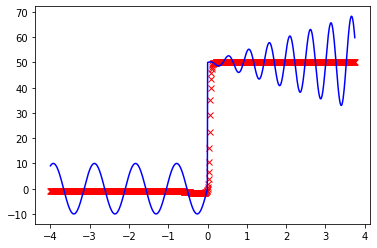

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [12]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.1980745712462348
